##### Copyright 2020 The TensorFlow Hub Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/text/tutorials/classify_text_with_bert"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/text/blob/master/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/text/docs/tutorials/classify_text_with_bert.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
  <td>
    <a href="https://tfhub.dev/google/collections/bert/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png" />See TF Hub model</a>
  </td>
</table>

# Classify text with BERT

This tutorial contains complete code to fine-tune BERT to perform sentiment analysis on a dataset of plain-text IMDB movie reviews.
In addition to training a model, you will learn how to preprocess text into an appropriate format.

In this notebook, you will:

- Load the IMDB dataset
- Load a BERT model from TensorFlow Hub
- Build your own model by combining BERT with a classifier
- Train your own model, fine-tuning BERT as part of that
- Save your model and use it to classify sentences

If you're new to working with the IMDB dataset, please see [Basic text classification](https://www.tensorflow.org/tutorials/keras/text_classification) for more details.

## About BERT

[BERT](https://arxiv.org/abs/1810.04805) and other Transformer encoder architectures have been wildly successful on a variety of tasks in NLP (natural language processing). They compute vector-space representations of natural language that are suitable for use in deep learning models. The BERT family of models uses the Transformer encoder architecture to process each token of input text in the full context of all tokens before and after, hence the name: Bidirectional Encoder Representations from Transformers. 

BERT models are usually pre-trained on a large corpus of text, then fine-tuned for specific tasks.


## Setup


In [2]:
# A dependency of the preprocessing for BERT inputs
!pip install -q -U "tensorflow-text==2.8.*"

You will use the AdamW optimizer from [tensorflow/models](https://github.com/tensorflow/models).

In [3]:
!pip install -q tf-models-official==2.7.0

In [4]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization  # to create AdamW optimizer

import matplotlib.pyplot as plt

tf.get_logger().setLevel('ERROR')

/tmpfs/src/tf_docs_env/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.9.0 and strictly below 2.12.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.4 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


## Sentiment analysis

This notebook trains a sentiment analysis model to classify movie reviews as *positive* or *negative*, based on the text of the review.

You'll use the [Large Movie Review Dataset](https://ai.stanford.edu/~amaas/data/sentiment/) that contains the text of 50,000 movie reviews from the [Internet Movie Database](https://www.imdb.com/).

### Download the IMDB dataset

Let's download and extract the dataset, then explore the directory structure.


In [5]:
url = 'https://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz'

dataset = tf.keras.utils.get_file('aclImdb_v1.tar.gz', url,
                                  untar=True, cache_dir='.',
                                  cache_subdir='')

dataset_dir = os.path.join(os.path.dirname(dataset), 'aclImdb')

train_dir = os.path.join(dataset_dir, 'train')

# remove unused folders to make it easier to load the data
remove_dir = os.path.join(train_dir, 'unsup')
shutil.rmtree(remove_dir)


   16384/84125825 [..............................] - ETA: 0s


   57344/84125825 [..............................] - ETA: 2:16


  122880/84125825 [..............................] - ETA: 2:07


  221184/84125825 [..............................] - ETA: 1:46


  368640/84125825 [..............................] - ETA: 1:24


  548864/84125825 [..............................] - ETA: 1:11


  827392/84125825 [..............................] - ETA: 56s 


 1187840/84125825 [..............................] - ETA: 45s


 1695744/84125825 [..............................] - ETA: 36s


 2351104/84125825 [..............................] - ETA: 27s


 2793472/84125825 [..............................] - ETA: 25s


 3612672/84125825 [>.............................] - ETA: 20s


 4399104/84125825 [>.............................] - ETA: 18s


 5398528/84125825 [>.............................] - ETA: 15s


 6545408/84125825 [=>............................] - ETA: 13s


 7725056/84125825 [=>............................] - ETA: 12s


 9281536/84125825 [==>...........................] - ETA: 10s


10985472/84125825 [==>...........................] - ETA: 8s 


12853248/84125825 [===>..........................] - ETA: 7s


14999552/84125825 [====>.........................] - ETA: 6s


17358848/84125825 [=====>........................] - ETA: 5s


19816448/84125825 [======>.......................] - ETA: 4s


22650880/84125825 [=======>......................] - ETA: 4s


25550848/84125825 [========>.....................] - ETA: 3s


28704768/84125825 [=========>....................] - ETA: 3s


31727616/84125825 [==========>...................] - ETA: 2s


34889728/84125825 [===========>..................] - ETA: 2s


38199296/84125825 [============>.................] - ETA: 2s


41476096/84125825 [=============>................] - ETA: 1s


44752896/84125825 [==============>...............] - ETA: 1s


47931392/84125825 [================>.............] - ETA: 1s


51322880/84125825 [=================>............] - ETA: 1s


54534144/84125825 [==================>...........] - ETA: 1s


57860096/84125825 [===================>..........] - ETA: 0s


61120512/84125825 [====================>.........] - ETA: 0s


64479232/84125825 [=====================>........] - ETA: 0s


67756032/84125825 [=======================>......] - ETA: 0s


71147520/84125825 [========================>.....] - ETA: 0s


74342400/84125825 [=========================>....] - ETA: 0s


77651968/84125825 [==========================>...] - ETA: 0s


80846848/84125825 [===========================>..] - ETA: 0s


84131840/84125825 [==============================] - 3s 0us/step



84140032/84125825 [==============================] - 3s 0us/step


Next, you will use the `text_dataset_from_directory` utility to create a labeled `tf.data.Dataset`.

The IMDB dataset has already been divided into train and test, but it lacks a validation set. Let's create a validation set using an 80:20 split of the training data by using the `validation_split` argument below.

Note:  When using the `validation_split` and `subset` arguments, make sure to either specify a random seed, or to pass `shuffle=False`, so that the validation and training splits have no overlap.

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 32
seed = 42

raw_train_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.utils.text_dataset_from_directory(
    'aclImdb/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 25000 files belonging to 2 classes.
Using 20000 files for training.


Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


Found 25000 files belonging to 2 classes.


Let's take a look at a few reviews.

In [7]:
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Review: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Review: b'"Pandemonium" is a horror movie spoof that comes off more stupid than funny. Believe me when I tell you, I love comedies. Especially comedy spoofs. "Airplane", "The Naked Gun" trilogy, "Blazing Saddles", "High Anxiety", and "Spaceballs" are some of my favorite comedies that spoof a particular genre. "Pandemonium" is not up there with those films. Most of the scenes in this movie had me sitting there in stunned silence because the movie wasn\'t all that funny. There are a few laughs in the film, but when you watch a comedy, you expect to laugh a lot more than a few times and that\'s all this film has going for it. Geez, "Scream" had more laughs than this film and that was more of a horror film. How bizarre is that?<br /><br />*1/2 (out of four)'
Label : 0 (neg)
Review: b"David Mamet is a very interesting and a very un-equal director. His first movie 'House of Games' was the one I liked best, and it set a series of films with characters whose perspective of life changes as they

2022-12-14 13:19:49.979867: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


## Loading models from TensorFlow Hub

Here you can choose which BERT model you will load from TensorFlow Hub and fine-tune. There are multiple BERT models available.

  - [BERT-Base](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3), [Uncased](https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3) and [seven more models](https://tfhub.dev/google/collections/bert/1) with trained weights released by the original BERT authors.
  - [Small BERTs](https://tfhub.dev/google/collections/bert/1) have the same general architecture but fewer and/or smaller Transformer blocks, which lets you explore tradeoffs between speed, size and quality.
  - [ALBERT](https://tfhub.dev/google/collections/albert/1): four different sizes of "A Lite BERT" that reduces model size (but not computation time) by sharing parameters between layers.
  - [BERT Experts](https://tfhub.dev/google/collections/experts/bert/1): eight models that all have the BERT-base architecture but offer a choice between different pre-training domains, to align more closely with the target task.
  - [Electra](https://tfhub.dev/google/collections/electra/1) has the same architecture as BERT (in three different sizes), but gets pre-trained as a discriminator in a set-up that resembles a Generative Adversarial Network (GAN).
  - BERT with Talking-Heads Attention and Gated GELU [[base](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1), [large](https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_large/1)] has two improvements to the core of the Transformer architecture.

The model documentation on TensorFlow Hub has more details and references to the
research literature. Follow the links above, or click on the [`tfhub.dev`](http://tfhub.dev) URL
printed after the next cell execution.

The suggestion is to start with a Small BERT (with fewer parameters) since they are faster to fine-tune. If you like a small model but with higher accuracy, ALBERT might be your next option. If you want even better accuracy, choose
one of the classic BERT sizes or their recent refinements like Electra, Talking Heads, or a BERT Expert.

Aside from the models available below, there are [multiple versions](https://tfhub.dev/google/collections/transformer_encoders_text/1) of the models that are larger and can yield even better accuracy, but they are too big to be fine-tuned on a single GPU. You will be able to do that on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).

You'll see in the code below that switching the tfhub.dev URL is enough to try any of these models, because all the differences between them are encapsulated in the SavedModels from TF Hub.

In [8]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'  #@param ["bert_en_uncased_L-12_H-768_A-12", "bert_en_cased_L-12_H-768_A-12", "bert_multi_cased_L-12_H-768_A-12", "small_bert/bert_en_uncased_L-2_H-128_A-2", "small_bert/bert_en_uncased_L-2_H-256_A-4", "small_bert/bert_en_uncased_L-2_H-512_A-8", "small_bert/bert_en_uncased_L-2_H-768_A-12", "small_bert/bert_en_uncased_L-4_H-128_A-2", "small_bert/bert_en_uncased_L-4_H-256_A-4", "small_bert/bert_en_uncased_L-4_H-512_A-8", "small_bert/bert_en_uncased_L-4_H-768_A-12", "small_bert/bert_en_uncased_L-6_H-128_A-2", "small_bert/bert_en_uncased_L-6_H-256_A-4", "small_bert/bert_en_uncased_L-6_H-512_A-8", "small_bert/bert_en_uncased_L-6_H-768_A-12", "small_bert/bert_en_uncased_L-8_H-128_A-2", "small_bert/bert_en_uncased_L-8_H-256_A-4", "small_bert/bert_en_uncased_L-8_H-512_A-8", "small_bert/bert_en_uncased_L-8_H-768_A-12", "small_bert/bert_en_uncased_L-10_H-128_A-2", "small_bert/bert_en_uncased_L-10_H-256_A-4", "small_bert/bert_en_uncased_L-10_H-512_A-8", "small_bert/bert_en_uncased_L-10_H-768_A-12", "small_bert/bert_en_uncased_L-12_H-128_A-2", "small_bert/bert_en_uncased_L-12_H-256_A-4", "small_bert/bert_en_uncased_L-12_H-512_A-8", "small_bert/bert_en_uncased_L-12_H-768_A-12", "albert_en_base", "electra_small", "electra_base", "experts_pubmed", "experts_wiki_books", "talking-heads_base"]

map_name_to_handle = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_L-12_H-768_A-12/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_L-12_H-768_A-12/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-6_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-8_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-10_H-768_A-12/1',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-128_A-2/1',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-256_A-4/1',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-512_A-8/1',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-12_H-768_A-12/1',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_base/2',
    'electra_small':
        'https://tfhub.dev/google/electra_small/2',
    'electra_base':
        'https://tfhub.dev/google/electra_base/2',
    'experts_pubmed':
        'https://tfhub.dev/google/experts/bert/pubmed/2',
    'experts_wiki_books':
        'https://tfhub.dev/google/experts/bert/wiki_books/2',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/talkheads_ggelu_bert_en_base/1',
}

map_model_to_preprocess = {
    'bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_en_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_cased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-2_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-4_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-6_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-8_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-10_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-256_A-4':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-512_A-8':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'small_bert/bert_en_uncased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'bert_multi_cased_L-12_H-768_A-12':
        'https://tfhub.dev/tensorflow/bert_multi_cased_preprocess/3',
    'albert_en_base':
        'https://tfhub.dev/tensorflow/albert_en_preprocess/3',
    'electra_small':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'electra_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_pubmed':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'experts_wiki_books':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
    'talking-heads_base':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


## The preprocessing model

Text inputs need to be transformed to numeric token ids and arranged in several Tensors before being input to BERT. TensorFlow Hub provides a matching preprocessing model for each of the BERT models discussed above, which implements this transformation using TF ops from the TF.text library. It is not necessary to run pure Python code outside your TensorFlow model to preprocess text.

The preprocessing model must be the one referenced by the documentation of the BERT model, which you can read at the URL printed above. For BERT models from the drop-down above, the preprocessing model is selected automatically.

Note: You will load the preprocessing model into a [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) to compose your fine-tuned model. This is the preferred API to load a TF2-style SavedModel from TF Hub into a Keras model.

In [9]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

Let's try the preprocessing model on some text and see the output:

In [10]:
text_test = ['this is such an amazing movie!']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_type_ids', 'input_word_ids', 'input_mask']
Shape      : (1, 128)
Word Ids   : [ 101 2023 2003 2107 2019 6429 3185  999  102    0    0    0]
Input Mask : [1 1 1 1 1 1 1 1 1 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


As you can see, now you have the 3 outputs from the preprocessing that a BERT model would use (`input_words_id`, `input_mask` and `input_type_ids`).

Some other important points:
- The input is truncated to 128 tokens. The number of tokens can be customized, and you can see more details on the [Solve GLUE tasks using BERT on a TPU colab](https://www.tensorflow.org/text/tutorials/bert_glue).
- The `input_type_ids` only have one value (0) because this is a single sentence input. For a multiple sentence input, it would have one number for each input.

Since this text preprocessor is a TensorFlow model, It can be included in your model directly.

## Using the BERT model

Before putting BERT into your own model, let's take a look at its outputs. You will load it from TF Hub and see the returned values.

In [11]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [12]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.76262885  0.99280983 -0.18611856  0.36673826  0.15233693  0.65504473
  0.9681154  -0.94862705  0.0021619  -0.9877732   0.06842698 -0.9763061 ]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.28946355  0.34321284  0.3323149  ...  0.21300808  0.71020824
  -0.05771172]
 [-0.2874203   0.31981018 -0.2301853  ...  0.58455014 -0.21329692
   0.7269214 ]
 [-0.66157     0.6887689  -0.8743298  ...  0.10877271 -0.26173168
   0.47855347]
 ...
 [-0.22561166 -0.28925633 -0.07064366 ...  0.47566074  0.83277154
   0.4002533 ]
 [-0.29824263 -0.2747314  -0.05450518 ...  0.48849723  1.095536
   0.18163356]
 [-0.443782    0.00930692  0.07223746 ...  0.17290054  1.1833245
   0.07897988]]


The BERT models return a map with 3 important keys: `pooled_output`, `sequence_output`, `encoder_outputs`:

- `pooled_output` represents each input sequence as a whole. The shape is `[batch_size, H]`. You can think of this as an embedding for the entire movie review.
- `sequence_output` represents each input token in the context. The shape is `[batch_size, seq_length, H]`. You can think of this as a contextual embedding for every token in the movie review.
- `encoder_outputs` are the intermediate activations of the `L` Transformer blocks. `outputs["encoder_outputs"][i]` is a Tensor of shape `[batch_size, seq_length, 1024]` with the outputs of the i-th Transformer block, for `0 <= i < L`. The last value of the list is equal to `sequence_output`.

For the fine-tuning you are going to use the `pooled_output` array.

## Define your model

You will create a very simple fine-tuned model, with the preprocessing model, the selected BERT model, one Dense and a Dropout layer.

Note: for more information about the base model's input and output you can follow the model's URL for documentation. Here specifically, you don't need to worry about it because the preprocessing model will take care of that for you.


In [13]:
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
  return tf.keras.Model(text_input, net)

Let's check that the model runs with the output of the preprocessing model.

In [14]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.5790214]], shape=(1, 1), dtype=float32)


The output is meaningless, of course, because the model has not been trained yet.

Let's take a look at the model's structure.

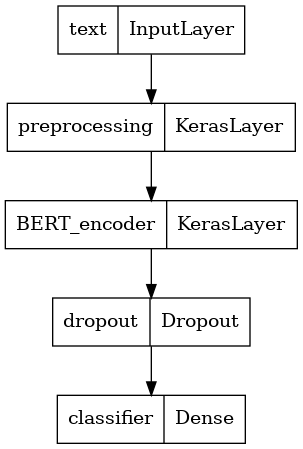

In [15]:
tf.keras.utils.plot_model(classifier_model)

## Model training

You now have all the pieces to train a model, including the preprocessing module, BERT encoder, data, and classifier.

### Loss function

Since this is a binary classification problem and the model outputs a probability (a single-unit layer), you'll use `losses.BinaryCrossentropy` loss function.


In [16]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer

For fine-tuning, let's use the same optimizer that BERT was originally trained with: the "Adaptive Moments" (Adam). This optimizer minimizes the prediction loss and does regularization by weight decay (not using moments), which is also known as [AdamW](https://arxiv.org/abs/1711.05101).

For the learning rate (`init_lr`), you will use the same schedule as BERT pre-training: linear decay of a notional initial learning rate, prefixed with a linear warm-up phase over the first 10% of training steps (`num_warmup_steps`). In line with the BERT paper, the initial learning rate is smaller for fine-tuning (best of 5e-5, 3e-5, 2e-5).

In [17]:
epochs = 5
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Loading the BERT model and training

Using the `classifier_model` you created earlier, you can compile the model with the loss, metric and optimizer.

In [18]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

Note: training time will vary depending on the complexity of the BERT model you have selected.

In [19]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/5



  1/625 [..............................] - ETA: 55:27 - loss: 0.8002 - binary_accuracy: 0.6250


  2/625 [..............................] - ETA: 1:37 - loss: 0.7647 - binary_accuracy: 0.5312 


  3/625 [..............................] - ETA: 1:36 - loss: 0.7523 - binary_accuracy: 0.4896


  4/625 [..............................] - ETA: 1:34 - loss: 0.7458 - binary_accuracy: 0.5312


  5/625 [..............................] - ETA: 1:34 - loss: 0.7506 - binary_accuracy: 0.5375


  6/625 [..............................] - ETA: 1:34 - loss: 0.7551 - binary_accuracy: 0.5417


  7/625 [..............................] - ETA: 1:33 - loss: 0.7562 - binary_accuracy: 0.5402


  8/625 [..............................] - ETA: 1:33 - loss: 0.7617 - binary_accuracy: 0.5391


  9/625 [..............................] - ETA: 1:33 - loss: 0.7566 - binary_accuracy: 0.5347


 10/625 [..............................] - ETA: 1:33 - loss: 0.7581 - binary_accuracy: 0.5188


 11/625 [..............................] - ETA: 1:34 - loss: 0.7503 - binary_accuracy: 0.5199


 12/625 [..............................] - ETA: 1:33 - loss: 0.7465 - binary_accuracy: 0.5104


 13/625 [..............................] - ETA: 1:33 - loss: 0.7442 - binary_accuracy: 0.5072


 14/625 [..............................] - ETA: 1:33 - loss: 0.7356 - binary_accuracy: 0.5134


 15/625 [..............................] - ETA: 1:33 - loss: 0.7312 - binary_accuracy: 0.5188


 16/625 [..............................] - ETA: 1:33 - loss: 0.7313 - binary_accuracy: 0.5293


 17/625 [..............................] - ETA: 1:32 - loss: 0.7324 - binary_accuracy: 0.5202


 18/625 [..............................] - ETA: 1:32 - loss: 0.7337 - binary_accuracy: 0.5156


 19/625 [..............................] - ETA: 1:32 - loss: 0.7321 - binary_accuracy: 0.5164


 20/625 [..............................] - ETA: 1:32 - loss: 0.7369 - binary_accuracy: 0.5109


 21/625 [>.............................] - ETA: 1:32 - loss: 0.7407 - binary_accuracy: 0.5015


 22/625 [>.............................] - ETA: 1:31 - loss: 0.7390 - binary_accuracy: 0.5000


 23/625 [>.............................] - ETA: 1:31 - loss: 0.7407 - binary_accuracy: 0.4959


 24/625 [>.............................] - ETA: 1:31 - loss: 0.7398 - binary_accuracy: 0.5026


 25/625 [>.............................] - ETA: 1:31 - loss: 0.7398 - binary_accuracy: 0.4988


 26/625 [>.............................] - ETA: 1:30 - loss: 0.7384 - binary_accuracy: 0.4976


 27/625 [>.............................] - ETA: 1:30 - loss: 0.7368 - binary_accuracy: 0.4942


 28/625 [>.............................] - ETA: 1:30 - loss: 0.7354 - binary_accuracy: 0.4967


 29/625 [>.............................] - ETA: 1:30 - loss: 0.7357 - binary_accuracy: 0.4925


 30/625 [>.............................] - ETA: 1:30 - loss: 0.7351 - binary_accuracy: 0.4938


 31/625 [>.............................] - ETA: 1:29 - loss: 0.7337 - binary_accuracy: 0.4950


 32/625 [>.............................] - ETA: 1:29 - loss: 0.7326 - binary_accuracy: 0.4971


 33/625 [>.............................] - ETA: 1:29 - loss: 0.7321 - binary_accuracy: 0.5019


 34/625 [>.............................] - ETA: 1:29 - loss: 0.7316 - binary_accuracy: 0.5009


 35/625 [>.............................] - ETA: 1:29 - loss: 0.7299 - binary_accuracy: 0.5036


 36/625 [>.............................] - ETA: 1:29 - loss: 0.7288 - binary_accuracy: 0.5061


 37/625 [>.............................] - ETA: 1:28 - loss: 0.7301 - binary_accuracy: 0.5068


 38/625 [>.............................] - ETA: 1:28 - loss: 0.7287 - binary_accuracy: 0.5074


 39/625 [>.............................] - ETA: 1:28 - loss: 0.7267 - binary_accuracy: 0.5104


 40/625 [>.............................] - ETA: 1:28 - loss: 0.7240 - binary_accuracy: 0.5117


 41/625 [>.............................] - ETA: 1:28 - loss: 0.7228 - binary_accuracy: 0.5152


 42/625 [=>............................] - ETA: 1:28 - loss: 0.7235 - binary_accuracy: 0.5149


 43/625 [=>............................] - ETA: 1:27 - loss: 0.7245 - binary_accuracy: 0.5145


 44/625 [=>............................] - ETA: 1:27 - loss: 0.7238 - binary_accuracy: 0.5128


 45/625 [=>............................] - ETA: 1:27 - loss: 0.7235 - binary_accuracy: 0.5118


 46/625 [=>............................] - ETA: 1:27 - loss: 0.7223 - binary_accuracy: 0.5149


 47/625 [=>............................] - ETA: 1:27 - loss: 0.7226 - binary_accuracy: 0.5160


 48/625 [=>............................] - ETA: 1:27 - loss: 0.7210 - binary_accuracy: 0.5189


 49/625 [=>............................] - ETA: 1:26 - loss: 0.7208 - binary_accuracy: 0.5185


 50/625 [=>............................] - ETA: 1:26 - loss: 0.7185 - binary_accuracy: 0.5213


 51/625 [=>............................] - ETA: 1:26 - loss: 0.7177 - binary_accuracy: 0.5208


 52/625 [=>............................] - ETA: 1:26 - loss: 0.7181 - binary_accuracy: 0.5186


 53/625 [=>............................] - ETA: 1:26 - loss: 0.7173 - binary_accuracy: 0.5189


 54/625 [=>............................] - ETA: 1:26 - loss: 0.7158 - binary_accuracy: 0.5191


 55/625 [=>............................] - ETA: 1:25 - loss: 0.7150 - binary_accuracy: 0.5182


 56/625 [=>............................] - ETA: 1:25 - loss: 0.7156 - binary_accuracy: 0.5179


 57/625 [=>............................] - ETA: 1:25 - loss: 0.7151 - binary_accuracy: 0.5186


 58/625 [=>............................] - ETA: 1:25 - loss: 0.7139 - binary_accuracy: 0.5178


 59/625 [=>............................] - ETA: 1:25 - loss: 0.7137 - binary_accuracy: 0.5196


 60/625 [=>............................] - ETA: 1:25 - loss: 0.7132 - binary_accuracy: 0.5208


 61/625 [=>............................] - ETA: 1:24 - loss: 0.7121 - binary_accuracy: 0.5236


 62/625 [=>............................] - ETA: 1:24 - loss: 0.7117 - binary_accuracy: 0.5242


 63/625 [==>...........................] - ETA: 1:24 - loss: 0.7113 - binary_accuracy: 0.5253


 64/625 [==>...........................] - ETA: 1:24 - loss: 0.7109 - binary_accuracy: 0.5264


 65/625 [==>...........................] - ETA: 1:24 - loss: 0.7103 - binary_accuracy: 0.5269


 66/625 [==>...........................] - ETA: 1:24 - loss: 0.7096 - binary_accuracy: 0.5279


 67/625 [==>...........................] - ETA: 1:24 - loss: 0.7089 - binary_accuracy: 0.5289


 68/625 [==>...........................] - ETA: 1:23 - loss: 0.7080 - binary_accuracy: 0.5303


 69/625 [==>...........................] - ETA: 1:23 - loss: 0.7067 - binary_accuracy: 0.5317


 70/625 [==>...........................] - ETA: 1:23 - loss: 0.7047 - binary_accuracy: 0.5330


 71/625 [==>...........................] - ETA: 1:23 - loss: 0.7040 - binary_accuracy: 0.5343


 72/625 [==>...........................] - ETA: 1:23 - loss: 0.7038 - binary_accuracy: 0.5334


 73/625 [==>...........................] - ETA: 1:23 - loss: 0.7029 - binary_accuracy: 0.5342


 74/625 [==>...........................] - ETA: 1:22 - loss: 0.7025 - binary_accuracy: 0.5338


 75/625 [==>...........................] - ETA: 1:22 - loss: 0.7026 - binary_accuracy: 0.5325


 76/625 [==>...........................] - ETA: 1:22 - loss: 0.7032 - binary_accuracy: 0.5312


 77/625 [==>...........................] - ETA: 1:22 - loss: 0.7032 - binary_accuracy: 0.5304


 78/625 [==>...........................] - ETA: 1:22 - loss: 0.7033 - binary_accuracy: 0.5292


 79/625 [==>...........................] - ETA: 1:22 - loss: 0.7014 - binary_accuracy: 0.5312


 80/625 [==>...........................] - ETA: 1:21 - loss: 0.7001 - binary_accuracy: 0.5320


 81/625 [==>...........................] - ETA: 1:21 - loss: 0.6992 - binary_accuracy: 0.5328


 82/625 [==>...........................] - ETA: 1:21 - loss: 0.6990 - binary_accuracy: 0.5324


 83/625 [==>...........................] - ETA: 1:21 - loss: 0.6995 - binary_accuracy: 0.5324


 84/625 [===>..........................] - ETA: 1:21 - loss: 0.6974 - binary_accuracy: 0.5346


 85/625 [===>..........................] - ETA: 1:21 - loss: 0.6983 - binary_accuracy: 0.5346


 86/625 [===>..........................] - ETA: 1:21 - loss: 0.6975 - binary_accuracy: 0.5363


 87/625 [===>..........................] - ETA: 1:20 - loss: 0.6961 - binary_accuracy: 0.5381


 88/625 [===>..........................] - ETA: 1:20 - loss: 0.6952 - binary_accuracy: 0.5384


 89/625 [===>..........................] - ETA: 1:20 - loss: 0.6960 - binary_accuracy: 0.5376


 90/625 [===>..........................] - ETA: 1:20 - loss: 0.6953 - binary_accuracy: 0.5375


 91/625 [===>..........................] - ETA: 1:20 - loss: 0.6956 - binary_accuracy: 0.5381


 92/625 [===>..........................] - ETA: 1:20 - loss: 0.6947 - binary_accuracy: 0.5391


 93/625 [===>..........................] - ETA: 1:20 - loss: 0.6930 - binary_accuracy: 0.5407


 94/625 [===>..........................] - ETA: 1:19 - loss: 0.6925 - binary_accuracy: 0.5422


 95/625 [===>..........................] - ETA: 1:19 - loss: 0.6919 - binary_accuracy: 0.5418


 96/625 [===>..........................] - ETA: 1:19 - loss: 0.6910 - binary_accuracy: 0.5430


 97/625 [===>..........................] - ETA: 1:19 - loss: 0.6897 - binary_accuracy: 0.5451


 98/625 [===>..........................] - ETA: 1:19 - loss: 0.6891 - binary_accuracy: 0.5456


 99/625 [===>..........................] - ETA: 1:19 - loss: 0.6892 - binary_accuracy: 0.5470


100/625 [===>..........................] - ETA: 1:18 - loss: 0.6886 - binary_accuracy: 0.5478


101/625 [===>..........................] - ETA: 1:18 - loss: 0.6883 - binary_accuracy: 0.5483


102/625 [===>..........................] - ETA: 1:18 - loss: 0.6876 - binary_accuracy: 0.5481


103/625 [===>..........................] - ETA: 1:18 - loss: 0.6870 - binary_accuracy: 0.5476


104/625 [===>..........................] - ETA: 1:18 - loss: 0.6865 - binary_accuracy: 0.5487


105/625 [====>.........................] - ETA: 1:18 - loss: 0.6859 - binary_accuracy: 0.5491


106/625 [====>.........................] - ETA: 1:18 - loss: 0.6851 - binary_accuracy: 0.5498


107/625 [====>.........................] - ETA: 1:18 - loss: 0.6842 - binary_accuracy: 0.5508


108/625 [====>.........................] - ETA: 1:17 - loss: 0.6832 - binary_accuracy: 0.5518


109/625 [====>.........................] - ETA: 1:17 - loss: 0.6823 - binary_accuracy: 0.5528


110/625 [====>.........................] - ETA: 1:17 - loss: 0.6827 - binary_accuracy: 0.5526


111/625 [====>.........................] - ETA: 1:17 - loss: 0.6821 - binary_accuracy: 0.5521


112/625 [====>.........................] - ETA: 1:17 - loss: 0.6810 - binary_accuracy: 0.5522


113/625 [====>.........................] - ETA: 1:17 - loss: 0.6807 - binary_accuracy: 0.5523


114/625 [====>.........................] - ETA: 1:16 - loss: 0.6805 - binary_accuracy: 0.5526


115/625 [====>.........................] - ETA: 1:16 - loss: 0.6798 - binary_accuracy: 0.5530


116/625 [====>.........................] - ETA: 1:16 - loss: 0.6795 - binary_accuracy: 0.5528


117/625 [====>.........................] - ETA: 1:16 - loss: 0.6787 - binary_accuracy: 0.5524


118/625 [====>.........................] - ETA: 1:16 - loss: 0.6780 - binary_accuracy: 0.5524


119/625 [====>.........................] - ETA: 1:16 - loss: 0.6771 - binary_accuracy: 0.5530


120/625 [====>.........................] - ETA: 1:16 - loss: 0.6768 - binary_accuracy: 0.5547


121/625 [====>.........................] - ETA: 1:15 - loss: 0.6761 - binary_accuracy: 0.5542


122/625 [====>.........................] - ETA: 1:15 - loss: 0.6756 - binary_accuracy: 0.5543


123/625 [====>.........................] - ETA: 1:15 - loss: 0.6753 - binary_accuracy: 0.5554


124/625 [====>.........................] - ETA: 1:15 - loss: 0.6745 - binary_accuracy: 0.5559


125/625 [=====>........................] - ETA: 1:15 - loss: 0.6730 - binary_accuracy: 0.5577


126/625 [=====>........................] - ETA: 1:15 - loss: 0.6724 - binary_accuracy: 0.5590


127/625 [=====>........................] - ETA: 1:15 - loss: 0.6711 - binary_accuracy: 0.5608


128/625 [=====>........................] - ETA: 1:14 - loss: 0.6699 - binary_accuracy: 0.5623


129/625 [=====>........................] - ETA: 1:14 - loss: 0.6696 - binary_accuracy: 0.5640


130/625 [=====>........................] - ETA: 1:14 - loss: 0.6699 - binary_accuracy: 0.5632


131/625 [=====>........................] - ETA: 1:14 - loss: 0.6698 - binary_accuracy: 0.5632


132/625 [=====>........................] - ETA: 1:14 - loss: 0.6688 - binary_accuracy: 0.5642


133/625 [=====>........................] - ETA: 1:14 - loss: 0.6678 - binary_accuracy: 0.5651


134/625 [=====>........................] - ETA: 1:13 - loss: 0.6674 - binary_accuracy: 0.5665


135/625 [=====>........................] - ETA: 1:13 - loss: 0.6665 - binary_accuracy: 0.5678


136/625 [=====>........................] - ETA: 1:13 - loss: 0.6650 - binary_accuracy: 0.5685


137/625 [=====>........................] - ETA: 1:13 - loss: 0.6638 - binary_accuracy: 0.5691


138/625 [=====>........................] - ETA: 1:13 - loss: 0.6629 - binary_accuracy: 0.5691


139/625 [=====>........................] - ETA: 1:13 - loss: 0.6611 - binary_accuracy: 0.5704


140/625 [=====>........................] - ETA: 1:13 - loss: 0.6614 - binary_accuracy: 0.5710


141/625 [=====>........................] - ETA: 1:12 - loss: 0.6602 - binary_accuracy: 0.5716


142/625 [=====>........................] - ETA: 1:12 - loss: 0.6592 - binary_accuracy: 0.5733


143/625 [=====>........................] - ETA: 1:12 - loss: 0.6589 - binary_accuracy: 0.5739


144/625 [=====>........................] - ETA: 1:12 - loss: 0.6582 - binary_accuracy: 0.5753


145/625 [=====>........................] - ETA: 1:12 - loss: 0.6580 - binary_accuracy: 0.5761


146/625 [======>.......................] - ETA: 1:12 - loss: 0.6572 - binary_accuracy: 0.5771


147/625 [======>.......................] - ETA: 1:11 - loss: 0.6560 - binary_accuracy: 0.5787


148/625 [======>.......................] - ETA: 1:11 - loss: 0.6552 - binary_accuracy: 0.5792


149/625 [======>.......................] - ETA: 1:11 - loss: 0.6540 - binary_accuracy: 0.5810


150/625 [======>.......................] - ETA: 1:11 - loss: 0.6547 - binary_accuracy: 0.5796


151/625 [======>.......................] - ETA: 1:11 - loss: 0.6535 - binary_accuracy: 0.5811


152/625 [======>.......................] - ETA: 1:11 - loss: 0.6524 - binary_accuracy: 0.5824


153/625 [======>.......................] - ETA: 1:11 - loss: 0.6514 - binary_accuracy: 0.5829


154/625 [======>.......................] - ETA: 1:10 - loss: 0.6511 - binary_accuracy: 0.5832


155/625 [======>.......................] - ETA: 1:10 - loss: 0.6508 - binary_accuracy: 0.5831


156/625 [======>.......................] - ETA: 1:10 - loss: 0.6493 - binary_accuracy: 0.5841


157/625 [======>.......................] - ETA: 1:10 - loss: 0.6496 - binary_accuracy: 0.5840


158/625 [======>.......................] - ETA: 1:10 - loss: 0.6487 - binary_accuracy: 0.5854


159/625 [======>.......................] - ETA: 1:10 - loss: 0.6483 - binary_accuracy: 0.5867


160/625 [======>.......................] - ETA: 1:09 - loss: 0.6471 - binary_accuracy: 0.5873


161/625 [======>.......................] - ETA: 1:09 - loss: 0.6463 - binary_accuracy: 0.5883


162/625 [======>.......................] - ETA: 1:09 - loss: 0.6454 - binary_accuracy: 0.5895


163/625 [======>.......................] - ETA: 1:09 - loss: 0.6443 - binary_accuracy: 0.5907


164/625 [======>.......................] - ETA: 1:09 - loss: 0.6438 - binary_accuracy: 0.5909


165/625 [======>.......................] - ETA: 1:09 - loss: 0.6423 - binary_accuracy: 0.5928


166/625 [======>.......................] - ETA: 1:09 - loss: 0.6416 - binary_accuracy: 0.5934


167/625 [=======>......................] - ETA: 1:08 - loss: 0.6404 - binary_accuracy: 0.5947


168/625 [=======>......................] - ETA: 1:08 - loss: 0.6401 - binary_accuracy: 0.5949


169/625 [=======>......................] - ETA: 1:08 - loss: 0.6388 - binary_accuracy: 0.5958


170/625 [=======>......................] - ETA: 1:08 - loss: 0.6383 - binary_accuracy: 0.5969


171/625 [=======>......................] - ETA: 1:08 - loss: 0.6378 - binary_accuracy: 0.5970


172/625 [=======>......................] - ETA: 1:08 - loss: 0.6366 - binary_accuracy: 0.5983


173/625 [=======>......................] - ETA: 1:07 - loss: 0.6359 - binary_accuracy: 0.5990


174/625 [=======>......................] - ETA: 1:07 - loss: 0.6345 - binary_accuracy: 0.6004


175/625 [=======>......................] - ETA: 1:07 - loss: 0.6333 - binary_accuracy: 0.6020


176/625 [=======>......................] - ETA: 1:07 - loss: 0.6330 - binary_accuracy: 0.6021


177/625 [=======>......................] - ETA: 1:07 - loss: 0.6328 - binary_accuracy: 0.6026


178/625 [=======>......................] - ETA: 1:07 - loss: 0.6324 - binary_accuracy: 0.6034


179/625 [=======>......................] - ETA: 1:07 - loss: 0.6315 - binary_accuracy: 0.6037


180/625 [=======>......................] - ETA: 1:06 - loss: 0.6304 - binary_accuracy: 0.6043


181/625 [=======>......................] - ETA: 1:06 - loss: 0.6296 - binary_accuracy: 0.6050


182/625 [=======>......................] - ETA: 1:06 - loss: 0.6293 - binary_accuracy: 0.6058


183/625 [=======>......................] - ETA: 1:06 - loss: 0.6295 - binary_accuracy: 0.6057


184/625 [=======>......................] - ETA: 1:06 - loss: 0.6295 - binary_accuracy: 0.6061


185/625 [=======>......................] - ETA: 1:06 - loss: 0.6279 - binary_accuracy: 0.6074


186/625 [=======>......................] - ETA: 1:06 - loss: 0.6272 - binary_accuracy: 0.6082


187/625 [=======>......................] - ETA: 1:05 - loss: 0.6260 - binary_accuracy: 0.6088


188/625 [========>.....................] - ETA: 1:05 - loss: 0.6252 - binary_accuracy: 0.6102


189/625 [========>.....................] - ETA: 1:05 - loss: 0.6241 - binary_accuracy: 0.6113


190/625 [========>.....................] - ETA: 1:05 - loss: 0.6240 - binary_accuracy: 0.6117


191/625 [========>.....................] - ETA: 1:05 - loss: 0.6226 - binary_accuracy: 0.6129


192/625 [========>.....................] - ETA: 1:05 - loss: 0.6215 - binary_accuracy: 0.6138


193/625 [========>.....................] - ETA: 1:04 - loss: 0.6213 - binary_accuracy: 0.6138


194/625 [========>.....................] - ETA: 1:04 - loss: 0.6207 - binary_accuracy: 0.6147


195/625 [========>.....................] - ETA: 1:04 - loss: 0.6197 - binary_accuracy: 0.6155


196/625 [========>.....................] - ETA: 1:04 - loss: 0.6202 - binary_accuracy: 0.6158


197/625 [========>.....................] - ETA: 1:04 - loss: 0.6195 - binary_accuracy: 0.6164


198/625 [========>.....................] - ETA: 1:04 - loss: 0.6185 - binary_accuracy: 0.6176


199/625 [========>.....................] - ETA: 1:04 - loss: 0.6182 - binary_accuracy: 0.6182


200/625 [========>.....................] - ETA: 1:03 - loss: 0.6175 - binary_accuracy: 0.6191


201/625 [========>.....................] - ETA: 1:03 - loss: 0.6180 - binary_accuracy: 0.6189


202/625 [========>.....................] - ETA: 1:03 - loss: 0.6168 - binary_accuracy: 0.6199


203/625 [========>.....................] - ETA: 1:03 - loss: 0.6163 - binary_accuracy: 0.6207


204/625 [========>.....................] - ETA: 1:03 - loss: 0.6161 - binary_accuracy: 0.6207


205/625 [========>.....................] - ETA: 1:03 - loss: 0.6156 - binary_accuracy: 0.6215


206/625 [========>.....................] - ETA: 1:03 - loss: 0.6151 - binary_accuracy: 0.6220


207/625 [========>.....................] - ETA: 1:02 - loss: 0.6148 - binary_accuracy: 0.6226


208/625 [========>.....................] - ETA: 1:02 - loss: 0.6145 - binary_accuracy: 0.6227


209/625 [=========>....................] - ETA: 1:02 - loss: 0.6135 - binary_accuracy: 0.6240


210/625 [=========>....................] - ETA: 1:02 - loss: 0.6129 - binary_accuracy: 0.6238


211/625 [=========>....................] - ETA: 1:02 - loss: 0.6122 - binary_accuracy: 0.6240


212/625 [=========>....................] - ETA: 1:02 - loss: 0.6117 - binary_accuracy: 0.6250


213/625 [=========>....................] - ETA: 1:01 - loss: 0.6112 - binary_accuracy: 0.6256


214/625 [=========>....................] - ETA: 1:01 - loss: 0.6103 - binary_accuracy: 0.6263


215/625 [=========>....................] - ETA: 1:01 - loss: 0.6102 - binary_accuracy: 0.6267


216/625 [=========>....................] - ETA: 1:01 - loss: 0.6102 - binary_accuracy: 0.6267


217/625 [=========>....................] - ETA: 1:01 - loss: 0.6096 - binary_accuracy: 0.6274


218/625 [=========>....................] - ETA: 1:01 - loss: 0.6083 - binary_accuracy: 0.6286


219/625 [=========>....................] - ETA: 1:01 - loss: 0.6079 - binary_accuracy: 0.6293


220/625 [=========>....................] - ETA: 1:00 - loss: 0.6074 - binary_accuracy: 0.6298


221/625 [=========>....................] - ETA: 1:00 - loss: 0.6065 - binary_accuracy: 0.6305


222/625 [=========>....................] - ETA: 1:00 - loss: 0.6059 - binary_accuracy: 0.6312


223/625 [=========>....................] - ETA: 1:00 - loss: 0.6055 - binary_accuracy: 0.6319


224/625 [=========>....................] - ETA: 1:00 - loss: 0.6053 - binary_accuracy: 0.6321


225/625 [=========>....................] - ETA: 1:00 - loss: 0.6051 - binary_accuracy: 0.6326


226/625 [=========>....................] - ETA: 1:00 - loss: 0.6038 - binary_accuracy: 0.6336


227/625 [=========>....................] - ETA: 59s - loss: 0.6027 - binary_accuracy: 0.6345 


228/625 [=========>....................] - ETA: 59s - loss: 0.6016 - binary_accuracy: 0.6356


229/625 [=========>....................] - ETA: 59s - loss: 0.6011 - binary_accuracy: 0.6359


230/625 [==========>...................] - ETA: 59s - loss: 0.6004 - binary_accuracy: 0.6368


231/625 [==========>...................] - ETA: 59s - loss: 0.5993 - binary_accuracy: 0.6379


232/625 [==========>...................] - ETA: 59s - loss: 0.5981 - binary_accuracy: 0.6390


233/625 [==========>...................] - ETA: 58s - loss: 0.5972 - binary_accuracy: 0.6398


234/625 [==========>...................] - ETA: 58s - loss: 0.5968 - binary_accuracy: 0.6404


235/625 [==========>...................] - ETA: 58s - loss: 0.5962 - binary_accuracy: 0.6411


236/625 [==========>...................] - ETA: 58s - loss: 0.5962 - binary_accuracy: 0.6412


237/625 [==========>...................] - ETA: 58s - loss: 0.5954 - binary_accuracy: 0.6417


238/625 [==========>...................] - ETA: 58s - loss: 0.5939 - binary_accuracy: 0.6429


239/625 [==========>...................] - ETA: 58s - loss: 0.5944 - binary_accuracy: 0.6428


240/625 [==========>...................] - ETA: 57s - loss: 0.5935 - binary_accuracy: 0.6435


241/625 [==========>...................] - ETA: 57s - loss: 0.5935 - binary_accuracy: 0.6438


242/625 [==========>...................] - ETA: 57s - loss: 0.5925 - binary_accuracy: 0.6446


243/625 [==========>...................] - ETA: 57s - loss: 0.5920 - binary_accuracy: 0.6452


244/625 [==========>...................] - ETA: 57s - loss: 0.5915 - binary_accuracy: 0.6457


245/625 [==========>...................] - ETA: 57s - loss: 0.5908 - binary_accuracy: 0.6467


246/625 [==========>...................] - ETA: 57s - loss: 0.5903 - binary_accuracy: 0.6472


247/625 [==========>...................] - ETA: 56s - loss: 0.5894 - binary_accuracy: 0.6480


248/625 [==========>...................] - ETA: 56s - loss: 0.5891 - binary_accuracy: 0.6484


249/625 [==========>...................] - ETA: 56s - loss: 0.5878 - binary_accuracy: 0.6493


250/625 [===========>..................] - ETA: 56s - loss: 0.5872 - binary_accuracy: 0.6501


251/625 [===========>..................] - ETA: 56s - loss: 0.5872 - binary_accuracy: 0.6504


252/625 [===========>..................] - ETA: 56s - loss: 0.5859 - binary_accuracy: 0.6512


253/625 [===========>..................] - ETA: 55s - loss: 0.5852 - binary_accuracy: 0.6517


254/625 [===========>..................] - ETA: 55s - loss: 0.5852 - binary_accuracy: 0.6517


255/625 [===========>..................] - ETA: 55s - loss: 0.5843 - binary_accuracy: 0.6526


256/625 [===========>..................] - ETA: 55s - loss: 0.5844 - binary_accuracy: 0.6530


257/625 [===========>..................] - ETA: 55s - loss: 0.5837 - binary_accuracy: 0.6537


258/625 [===========>..................] - ETA: 55s - loss: 0.5830 - binary_accuracy: 0.6543


259/625 [===========>..................] - ETA: 55s - loss: 0.5826 - binary_accuracy: 0.6547


260/625 [===========>..................] - ETA: 54s - loss: 0.5823 - binary_accuracy: 0.6550


261/625 [===========>..................] - ETA: 54s - loss: 0.5813 - binary_accuracy: 0.6559


262/625 [===========>..................] - ETA: 54s - loss: 0.5803 - binary_accuracy: 0.6567


263/625 [===========>..................] - ETA: 54s - loss: 0.5807 - binary_accuracy: 0.6566


264/625 [===========>..................] - ETA: 54s - loss: 0.5809 - binary_accuracy: 0.6570


265/625 [===========>..................] - ETA: 54s - loss: 0.5795 - binary_accuracy: 0.6580


266/625 [===========>..................] - ETA: 53s - loss: 0.5787 - binary_accuracy: 0.6586


267/625 [===========>..................] - ETA: 53s - loss: 0.5781 - binary_accuracy: 0.6589


268/625 [===========>..................] - ETA: 53s - loss: 0.5774 - binary_accuracy: 0.6599


269/625 [===========>..................] - ETA: 53s - loss: 0.5768 - binary_accuracy: 0.6603


270/625 [===========>..................] - ETA: 53s - loss: 0.5766 - binary_accuracy: 0.6604


271/625 [============>.................] - ETA: 53s - loss: 0.5761 - binary_accuracy: 0.6607


272/625 [============>.................] - ETA: 53s - loss: 0.5755 - binary_accuracy: 0.6612


273/625 [============>.................] - ETA: 52s - loss: 0.5761 - binary_accuracy: 0.6609


274/625 [============>.................] - ETA: 52s - loss: 0.5758 - binary_accuracy: 0.6614


275/625 [============>.................] - ETA: 52s - loss: 0.5757 - binary_accuracy: 0.6617


276/625 [============>.................] - ETA: 52s - loss: 0.5750 - binary_accuracy: 0.6624


277/625 [============>.................] - ETA: 52s - loss: 0.5741 - binary_accuracy: 0.6631


278/625 [============>.................] - ETA: 52s - loss: 0.5735 - binary_accuracy: 0.6637


279/625 [============>.................] - ETA: 52s - loss: 0.5729 - binary_accuracy: 0.6641


280/625 [============>.................] - ETA: 51s - loss: 0.5723 - binary_accuracy: 0.6648


281/625 [============>.................] - ETA: 51s - loss: 0.5718 - binary_accuracy: 0.6654


282/625 [============>.................] - ETA: 51s - loss: 0.5720 - binary_accuracy: 0.6653


283/625 [============>.................] - ETA: 51s - loss: 0.5715 - binary_accuracy: 0.6656


284/625 [============>.................] - ETA: 51s - loss: 0.5706 - binary_accuracy: 0.6662


285/625 [============>.................] - ETA: 51s - loss: 0.5704 - binary_accuracy: 0.6664


286/625 [============>.................] - ETA: 50s - loss: 0.5704 - binary_accuracy: 0.6665


287/625 [============>.................] - ETA: 50s - loss: 0.5702 - binary_accuracy: 0.6668


288/625 [============>.................] - ETA: 50s - loss: 0.5705 - binary_accuracy: 0.6670


289/625 [============>.................] - ETA: 50s - loss: 0.5704 - binary_accuracy: 0.6675


290/625 [============>.................] - ETA: 50s - loss: 0.5701 - binary_accuracy: 0.6679


291/625 [============>.................] - ETA: 50s - loss: 0.5700 - binary_accuracy: 0.6683


292/625 [=============>................] - ETA: 50s - loss: 0.5698 - binary_accuracy: 0.6687


293/625 [=============>................] - ETA: 49s - loss: 0.5697 - binary_accuracy: 0.6690


294/625 [=============>................] - ETA: 49s - loss: 0.5695 - binary_accuracy: 0.6694


295/625 [=============>................] - ETA: 49s - loss: 0.5696 - binary_accuracy: 0.6694


296/625 [=============>................] - ETA: 49s - loss: 0.5692 - binary_accuracy: 0.6700


297/625 [=============>................] - ETA: 49s - loss: 0.5683 - binary_accuracy: 0.6703


298/625 [=============>................] - ETA: 49s - loss: 0.5676 - binary_accuracy: 0.6708


299/625 [=============>................] - ETA: 49s - loss: 0.5676 - binary_accuracy: 0.6707


300/625 [=============>................] - ETA: 48s - loss: 0.5670 - binary_accuracy: 0.6711


301/625 [=============>................] - ETA: 48s - loss: 0.5665 - binary_accuracy: 0.6716


302/625 [=============>................] - ETA: 48s - loss: 0.5661 - binary_accuracy: 0.6723


303/625 [=============>................] - ETA: 48s - loss: 0.5660 - binary_accuracy: 0.6724


304/625 [=============>................] - ETA: 48s - loss: 0.5654 - binary_accuracy: 0.6729


305/625 [=============>................] - ETA: 48s - loss: 0.5650 - binary_accuracy: 0.6735


306/625 [=============>................] - ETA: 47s - loss: 0.5653 - binary_accuracy: 0.6733


307/625 [=============>................] - ETA: 47s - loss: 0.5649 - binary_accuracy: 0.6731


308/625 [=============>................] - ETA: 47s - loss: 0.5650 - binary_accuracy: 0.6732


309/625 [=============>................] - ETA: 47s - loss: 0.5645 - binary_accuracy: 0.6737


310/625 [=============>................] - ETA: 47s - loss: 0.5639 - binary_accuracy: 0.6744


311/625 [=============>................] - ETA: 47s - loss: 0.5641 - binary_accuracy: 0.6745


312/625 [=============>................] - ETA: 47s - loss: 0.5637 - binary_accuracy: 0.6749


313/625 [==============>...............] - ETA: 46s - loss: 0.5634 - binary_accuracy: 0.6753


314/625 [==============>...............] - ETA: 46s - loss: 0.5626 - binary_accuracy: 0.6760


315/625 [==============>...............] - ETA: 46s - loss: 0.5618 - binary_accuracy: 0.6767


316/625 [==============>...............] - ETA: 46s - loss: 0.5612 - binary_accuracy: 0.6770


317/625 [==============>...............] - ETA: 46s - loss: 0.5606 - binary_accuracy: 0.6775


318/625 [==============>...............] - ETA: 46s - loss: 0.5603 - binary_accuracy: 0.6779


319/625 [==============>...............] - ETA: 46s - loss: 0.5599 - binary_accuracy: 0.6782


320/625 [==============>...............] - ETA: 45s - loss: 0.5601 - binary_accuracy: 0.6781


321/625 [==============>...............] - ETA: 45s - loss: 0.5600 - binary_accuracy: 0.6784


322/625 [==============>...............] - ETA: 45s - loss: 0.5598 - binary_accuracy: 0.6785


323/625 [==============>...............] - ETA: 45s - loss: 0.5591 - binary_accuracy: 0.6791


324/625 [==============>...............] - ETA: 45s - loss: 0.5585 - binary_accuracy: 0.6795


325/625 [==============>...............] - ETA: 45s - loss: 0.5586 - binary_accuracy: 0.6794


326/625 [==============>...............] - ETA: 44s - loss: 0.5585 - binary_accuracy: 0.6797


327/625 [==============>...............] - ETA: 44s - loss: 0.5579 - binary_accuracy: 0.6804


328/625 [==============>...............] - ETA: 44s - loss: 0.5575 - binary_accuracy: 0.6807


329/625 [==============>...............] - ETA: 44s - loss: 0.5574 - binary_accuracy: 0.6809


330/625 [==============>...............] - ETA: 44s - loss: 0.5570 - binary_accuracy: 0.6812


331/625 [==============>...............] - ETA: 44s - loss: 0.5567 - binary_accuracy: 0.6814


332/625 [==============>...............] - ETA: 44s - loss: 0.5565 - binary_accuracy: 0.6815


333/625 [==============>...............] - ETA: 43s - loss: 0.5570 - binary_accuracy: 0.6812


334/625 [===============>..............] - ETA: 43s - loss: 0.5571 - binary_accuracy: 0.6810


335/625 [===============>..............] - ETA: 43s - loss: 0.5571 - binary_accuracy: 0.6810


336/625 [===============>..............] - ETA: 43s - loss: 0.5568 - binary_accuracy: 0.6811


337/625 [===============>..............] - ETA: 43s - loss: 0.5568 - binary_accuracy: 0.6813


338/625 [===============>..............] - ETA: 43s - loss: 0.5567 - binary_accuracy: 0.6814


339/625 [===============>..............] - ETA: 43s - loss: 0.5563 - binary_accuracy: 0.6816


340/625 [===============>..............] - ETA: 42s - loss: 0.5557 - binary_accuracy: 0.6822


341/625 [===============>..............] - ETA: 42s - loss: 0.5557 - binary_accuracy: 0.6826


342/625 [===============>..............] - ETA: 42s - loss: 0.5550 - binary_accuracy: 0.6831


343/625 [===============>..............] - ETA: 42s - loss: 0.5548 - binary_accuracy: 0.6834


344/625 [===============>..............] - ETA: 42s - loss: 0.5540 - binary_accuracy: 0.6840


345/625 [===============>..............] - ETA: 42s - loss: 0.5538 - binary_accuracy: 0.6840


346/625 [===============>..............] - ETA: 41s - loss: 0.5542 - binary_accuracy: 0.6839


347/625 [===============>..............] - ETA: 41s - loss: 0.5534 - binary_accuracy: 0.6843


348/625 [===============>..............] - ETA: 41s - loss: 0.5534 - binary_accuracy: 0.6844


349/625 [===============>..............] - ETA: 41s - loss: 0.5533 - binary_accuracy: 0.6845


350/625 [===============>..............] - ETA: 41s - loss: 0.5530 - binary_accuracy: 0.6849


351/625 [===============>..............] - ETA: 41s - loss: 0.5524 - binary_accuracy: 0.6855


352/625 [===============>..............] - ETA: 41s - loss: 0.5523 - binary_accuracy: 0.6855


353/625 [===============>..............] - ETA: 40s - loss: 0.5522 - binary_accuracy: 0.6856


354/625 [===============>..............] - ETA: 40s - loss: 0.5515 - binary_accuracy: 0.6860


355/625 [================>.............] - ETA: 40s - loss: 0.5512 - binary_accuracy: 0.6862


356/625 [================>.............] - ETA: 40s - loss: 0.5507 - binary_accuracy: 0.6865


357/625 [================>.............] - ETA: 40s - loss: 0.5499 - binary_accuracy: 0.6871


358/625 [================>.............] - ETA: 40s - loss: 0.5491 - binary_accuracy: 0.6875


359/625 [================>.............] - ETA: 40s - loss: 0.5487 - binary_accuracy: 0.6880


360/625 [================>.............] - ETA: 39s - loss: 0.5483 - binary_accuracy: 0.6885


361/625 [================>.............] - ETA: 39s - loss: 0.5478 - binary_accuracy: 0.6888


362/625 [================>.............] - ETA: 39s - loss: 0.5474 - binary_accuracy: 0.6891


363/625 [================>.............] - ETA: 39s - loss: 0.5469 - binary_accuracy: 0.6894


364/625 [================>.............] - ETA: 39s - loss: 0.5467 - binary_accuracy: 0.6897


365/625 [================>.............] - ETA: 39s - loss: 0.5461 - binary_accuracy: 0.6902


366/625 [================>.............] - ETA: 38s - loss: 0.5454 - binary_accuracy: 0.6907


367/625 [================>.............] - ETA: 38s - loss: 0.5447 - binary_accuracy: 0.6912


368/625 [================>.............] - ETA: 38s - loss: 0.5445 - binary_accuracy: 0.6913


369/625 [================>.............] - ETA: 38s - loss: 0.5442 - binary_accuracy: 0.6914


370/625 [================>.............] - ETA: 38s - loss: 0.5441 - binary_accuracy: 0.6916


371/625 [================>.............] - ETA: 38s - loss: 0.5436 - binary_accuracy: 0.6918


372/625 [================>.............] - ETA: 38s - loss: 0.5431 - binary_accuracy: 0.6920


373/625 [================>.............] - ETA: 37s - loss: 0.5426 - binary_accuracy: 0.6926


374/625 [================>.............] - ETA: 37s - loss: 0.5425 - binary_accuracy: 0.6931


375/625 [=================>............] - ETA: 37s - loss: 0.5421 - binary_accuracy: 0.6934


376/625 [=================>............] - ETA: 37s - loss: 0.5417 - binary_accuracy: 0.6937


377/625 [=================>............] - ETA: 37s - loss: 0.5420 - binary_accuracy: 0.6938


378/625 [=================>............] - ETA: 37s - loss: 0.5416 - binary_accuracy: 0.6940


379/625 [=================>............] - ETA: 37s - loss: 0.5409 - binary_accuracy: 0.6944


380/625 [=================>............] - ETA: 36s - loss: 0.5408 - binary_accuracy: 0.6946


381/625 [=================>............] - ETA: 36s - loss: 0.5400 - binary_accuracy: 0.6952


382/625 [=================>............] - ETA: 36s - loss: 0.5395 - binary_accuracy: 0.6956


383/625 [=================>............] - ETA: 36s - loss: 0.5391 - binary_accuracy: 0.6959


384/625 [=================>............] - ETA: 36s - loss: 0.5392 - binary_accuracy: 0.6961


385/625 [=================>............] - ETA: 36s - loss: 0.5393 - binary_accuracy: 0.6963


386/625 [=================>............] - ETA: 35s - loss: 0.5393 - binary_accuracy: 0.6968


387/625 [=================>............] - ETA: 35s - loss: 0.5390 - binary_accuracy: 0.6971


388/625 [=================>............] - ETA: 35s - loss: 0.5385 - binary_accuracy: 0.6976


389/625 [=================>............] - ETA: 35s - loss: 0.5378 - binary_accuracy: 0.6983


390/625 [=================>............] - ETA: 35s - loss: 0.5373 - binary_accuracy: 0.6985


391/625 [=================>............] - ETA: 35s - loss: 0.5368 - binary_accuracy: 0.6988


392/625 [=================>............] - ETA: 35s - loss: 0.5365 - binary_accuracy: 0.6990


393/625 [=================>............] - ETA: 34s - loss: 0.5368 - binary_accuracy: 0.6990


394/625 [=================>............] - ETA: 34s - loss: 0.5361 - binary_accuracy: 0.6995


395/625 [=================>............] - ETA: 34s - loss: 0.5357 - binary_accuracy: 0.6999


396/625 [==================>...........] - ETA: 34s - loss: 0.5356 - binary_accuracy: 0.7001


397/625 [==================>...........] - ETA: 34s - loss: 0.5354 - binary_accuracy: 0.7003


398/625 [==================>...........] - ETA: 34s - loss: 0.5349 - binary_accuracy: 0.7008


399/625 [==================>...........] - ETA: 33s - loss: 0.5345 - binary_accuracy: 0.7010


400/625 [==================>...........] - ETA: 33s - loss: 0.5343 - binary_accuracy: 0.7012


401/625 [==================>...........] - ETA: 33s - loss: 0.5336 - binary_accuracy: 0.7017


402/625 [==================>...........] - ETA: 33s - loss: 0.5338 - binary_accuracy: 0.7016


403/625 [==================>...........] - ETA: 33s - loss: 0.5335 - binary_accuracy: 0.7018


404/625 [==================>...........] - ETA: 33s - loss: 0.5335 - binary_accuracy: 0.7018


405/625 [==================>...........] - ETA: 33s - loss: 0.5329 - binary_accuracy: 0.7021


406/625 [==================>...........] - ETA: 32s - loss: 0.5327 - binary_accuracy: 0.7023


407/625 [==================>...........] - ETA: 32s - loss: 0.5327 - binary_accuracy: 0.7024


408/625 [==================>...........] - ETA: 32s - loss: 0.5325 - binary_accuracy: 0.7026


409/625 [==================>...........] - ETA: 32s - loss: 0.5319 - binary_accuracy: 0.7029


410/625 [==================>...........] - ETA: 32s - loss: 0.5319 - binary_accuracy: 0.7030


411/625 [==================>...........] - ETA: 32s - loss: 0.5317 - binary_accuracy: 0.7031


412/625 [==================>...........] - ETA: 32s - loss: 0.5313 - binary_accuracy: 0.7034


413/625 [==================>...........] - ETA: 31s - loss: 0.5311 - binary_accuracy: 0.7037


414/625 [==================>...........] - ETA: 31s - loss: 0.5318 - binary_accuracy: 0.7036


415/625 [==================>...........] - ETA: 31s - loss: 0.5315 - binary_accuracy: 0.7037


416/625 [==================>...........] - ETA: 31s - loss: 0.5311 - binary_accuracy: 0.7039


417/625 [===================>..........] - ETA: 31s - loss: 0.5308 - binary_accuracy: 0.7043


418/625 [===================>..........] - ETA: 31s - loss: 0.5305 - binary_accuracy: 0.7044


419/625 [===================>..........] - ETA: 30s - loss: 0.5304 - binary_accuracy: 0.7047


420/625 [===================>..........] - ETA: 30s - loss: 0.5301 - binary_accuracy: 0.7050


421/625 [===================>..........] - ETA: 30s - loss: 0.5299 - binary_accuracy: 0.7052


422/625 [===================>..........] - ETA: 30s - loss: 0.5295 - binary_accuracy: 0.7054


423/625 [===================>..........] - ETA: 30s - loss: 0.5292 - binary_accuracy: 0.7057


424/625 [===================>..........] - ETA: 30s - loss: 0.5290 - binary_accuracy: 0.7059


425/625 [===================>..........] - ETA: 30s - loss: 0.5287 - binary_accuracy: 0.7060


426/625 [===================>..........] - ETA: 29s - loss: 0.5290 - binary_accuracy: 0.7058


427/625 [===================>..........] - ETA: 29s - loss: 0.5286 - binary_accuracy: 0.7060


428/625 [===================>..........] - ETA: 29s - loss: 0.5282 - binary_accuracy: 0.7063


429/625 [===================>..........] - ETA: 29s - loss: 0.5278 - binary_accuracy: 0.7067


430/625 [===================>..........] - ETA: 29s - loss: 0.5271 - binary_accuracy: 0.7073


431/625 [===================>..........] - ETA: 29s - loss: 0.5269 - binary_accuracy: 0.7074


432/625 [===================>..........] - ETA: 29s - loss: 0.5269 - binary_accuracy: 0.7075


433/625 [===================>..........] - ETA: 28s - loss: 0.5268 - binary_accuracy: 0.7075


434/625 [===================>..........] - ETA: 28s - loss: 0.5267 - binary_accuracy: 0.7077


435/625 [===================>..........] - ETA: 28s - loss: 0.5262 - binary_accuracy: 0.7082


436/625 [===================>..........] - ETA: 28s - loss: 0.5257 - binary_accuracy: 0.7086


437/625 [===================>..........] - ETA: 28s - loss: 0.5254 - binary_accuracy: 0.7090


438/625 [====================>.........] - ETA: 28s - loss: 0.5252 - binary_accuracy: 0.7091


439/625 [====================>.........] - ETA: 27s - loss: 0.5248 - binary_accuracy: 0.7094


440/625 [====================>.........] - ETA: 27s - loss: 0.5246 - binary_accuracy: 0.7094


441/625 [====================>.........] - ETA: 27s - loss: 0.5240 - binary_accuracy: 0.7098


442/625 [====================>.........] - ETA: 27s - loss: 0.5239 - binary_accuracy: 0.7098


443/625 [====================>.........] - ETA: 27s - loss: 0.5235 - binary_accuracy: 0.7099


444/625 [====================>.........] - ETA: 27s - loss: 0.5232 - binary_accuracy: 0.7103


445/625 [====================>.........] - ETA: 27s - loss: 0.5226 - binary_accuracy: 0.7107


446/625 [====================>.........] - ETA: 26s - loss: 0.5223 - binary_accuracy: 0.7110


447/625 [====================>.........] - ETA: 26s - loss: 0.5219 - binary_accuracy: 0.7115


448/625 [====================>.........] - ETA: 26s - loss: 0.5214 - binary_accuracy: 0.7118


449/625 [====================>.........] - ETA: 26s - loss: 0.5212 - binary_accuracy: 0.7120


450/625 [====================>.........] - ETA: 26s - loss: 0.5211 - binary_accuracy: 0.7123


451/625 [====================>.........] - ETA: 26s - loss: 0.5208 - binary_accuracy: 0.7125


452/625 [====================>.........] - ETA: 26s - loss: 0.5203 - binary_accuracy: 0.7128


453/625 [====================>.........] - ETA: 25s - loss: 0.5196 - binary_accuracy: 0.7132


454/625 [====================>.........] - ETA: 25s - loss: 0.5192 - binary_accuracy: 0.7135


455/625 [====================>.........] - ETA: 25s - loss: 0.5192 - binary_accuracy: 0.7137


456/625 [====================>.........] - ETA: 25s - loss: 0.5191 - binary_accuracy: 0.7138


457/625 [====================>.........] - ETA: 25s - loss: 0.5190 - binary_accuracy: 0.7140


458/625 [====================>.........] - ETA: 25s - loss: 0.5185 - binary_accuracy: 0.7144


459/625 [=====================>........] - ETA: 24s - loss: 0.5186 - binary_accuracy: 0.7145


460/625 [=====================>........] - ETA: 24s - loss: 0.5180 - binary_accuracy: 0.7148


461/625 [=====================>........] - ETA: 24s - loss: 0.5179 - binary_accuracy: 0.7150


462/625 [=====================>........] - ETA: 24s - loss: 0.5176 - binary_accuracy: 0.7152


463/625 [=====================>........] - ETA: 24s - loss: 0.5177 - binary_accuracy: 0.7154


464/625 [=====================>........] - ETA: 24s - loss: 0.5176 - binary_accuracy: 0.7157


465/625 [=====================>........] - ETA: 24s - loss: 0.5173 - binary_accuracy: 0.7159


466/625 [=====================>........] - ETA: 23s - loss: 0.5174 - binary_accuracy: 0.7159


467/625 [=====================>........] - ETA: 23s - loss: 0.5171 - binary_accuracy: 0.7162


468/625 [=====================>........] - ETA: 23s - loss: 0.5166 - binary_accuracy: 0.7165


469/625 [=====================>........] - ETA: 23s - loss: 0.5161 - binary_accuracy: 0.7169


470/625 [=====================>........] - ETA: 23s - loss: 0.5159 - binary_accuracy: 0.7172


471/625 [=====================>........] - ETA: 23s - loss: 0.5154 - binary_accuracy: 0.7176


472/625 [=====================>........] - ETA: 23s - loss: 0.5154 - binary_accuracy: 0.7176


473/625 [=====================>........] - ETA: 22s - loss: 0.5150 - binary_accuracy: 0.7180


474/625 [=====================>........] - ETA: 22s - loss: 0.5147 - binary_accuracy: 0.7182


475/625 [=====================>........] - ETA: 22s - loss: 0.5144 - binary_accuracy: 0.7182


476/625 [=====================>........] - ETA: 22s - loss: 0.5139 - binary_accuracy: 0.7184


477/625 [=====================>........] - ETA: 22s - loss: 0.5138 - binary_accuracy: 0.7184


478/625 [=====================>........] - ETA: 22s - loss: 0.5135 - binary_accuracy: 0.7186


479/625 [=====================>........] - ETA: 21s - loss: 0.5136 - binary_accuracy: 0.7188


480/625 [======================>.......] - ETA: 21s - loss: 0.5133 - binary_accuracy: 0.7191


481/625 [======================>.......] - ETA: 21s - loss: 0.5133 - binary_accuracy: 0.7194


482/625 [======================>.......] - ETA: 21s - loss: 0.5132 - binary_accuracy: 0.7195


483/625 [======================>.......] - ETA: 21s - loss: 0.5129 - binary_accuracy: 0.7198


484/625 [======================>.......] - ETA: 21s - loss: 0.5124 - binary_accuracy: 0.7201


485/625 [======================>.......] - ETA: 21s - loss: 0.5121 - binary_accuracy: 0.7202


486/625 [======================>.......] - ETA: 20s - loss: 0.5115 - binary_accuracy: 0.7207


487/625 [======================>.......] - ETA: 20s - loss: 0.5112 - binary_accuracy: 0.7208


488/625 [======================>.......] - ETA: 20s - loss: 0.5107 - binary_accuracy: 0.7212


489/625 [======================>.......] - ETA: 20s - loss: 0.5102 - binary_accuracy: 0.7216


490/625 [======================>.......] - ETA: 20s - loss: 0.5099 - binary_accuracy: 0.7218


491/625 [======================>.......] - ETA: 20s - loss: 0.5094 - binary_accuracy: 0.7221


492/625 [======================>.......] - ETA: 20s - loss: 0.5088 - binary_accuracy: 0.7226


493/625 [======================>.......] - ETA: 19s - loss: 0.5083 - binary_accuracy: 0.7229


494/625 [======================>.......] - ETA: 19s - loss: 0.5080 - binary_accuracy: 0.7232


495/625 [======================>.......] - ETA: 19s - loss: 0.5076 - binary_accuracy: 0.7235


496/625 [======================>.......] - ETA: 19s - loss: 0.5074 - binary_accuracy: 0.7235


497/625 [======================>.......] - ETA: 19s - loss: 0.5073 - binary_accuracy: 0.7236


498/625 [======================>.......] - ETA: 19s - loss: 0.5071 - binary_accuracy: 0.7236


499/625 [======================>.......] - ETA: 18s - loss: 0.5067 - binary_accuracy: 0.7238


500/625 [=======================>......] - ETA: 18s - loss: 0.5064 - binary_accuracy: 0.7241


501/625 [=======================>......] - ETA: 18s - loss: 0.5063 - binary_accuracy: 0.7241


502/625 [=======================>......] - ETA: 18s - loss: 0.5058 - binary_accuracy: 0.7244


503/625 [=======================>......] - ETA: 18s - loss: 0.5058 - binary_accuracy: 0.7246


504/625 [=======================>......] - ETA: 18s - loss: 0.5057 - binary_accuracy: 0.7248


505/625 [=======================>......] - ETA: 18s - loss: 0.5055 - binary_accuracy: 0.7249


506/625 [=======================>......] - ETA: 17s - loss: 0.5059 - binary_accuracy: 0.7249


507/625 [=======================>......] - ETA: 17s - loss: 0.5059 - binary_accuracy: 0.7249


508/625 [=======================>......] - ETA: 17s - loss: 0.5058 - binary_accuracy: 0.7252


509/625 [=======================>......] - ETA: 17s - loss: 0.5056 - binary_accuracy: 0.7254


510/625 [=======================>......] - ETA: 17s - loss: 0.5053 - binary_accuracy: 0.7256


511/625 [=======================>......] - ETA: 17s - loss: 0.5050 - binary_accuracy: 0.7258


512/625 [=======================>......] - ETA: 16s - loss: 0.5046 - binary_accuracy: 0.7261


513/625 [=======================>......] - ETA: 16s - loss: 0.5043 - binary_accuracy: 0.7264


514/625 [=======================>......] - ETA: 16s - loss: 0.5044 - binary_accuracy: 0.7263


515/625 [=======================>......] - ETA: 16s - loss: 0.5044 - binary_accuracy: 0.7265


516/625 [=======================>......] - ETA: 16s - loss: 0.5041 - binary_accuracy: 0.7266


517/625 [=======================>......] - ETA: 16s - loss: 0.5042 - binary_accuracy: 0.7265


518/625 [=======================>......] - ETA: 16s - loss: 0.5042 - binary_accuracy: 0.7265


519/625 [=======================>......] - ETA: 15s - loss: 0.5040 - binary_accuracy: 0.7266


520/625 [=======================>......] - ETA: 15s - loss: 0.5040 - binary_accuracy: 0.7266


521/625 [========================>.....] - ETA: 15s - loss: 0.5038 - binary_accuracy: 0.7267


522/625 [========================>.....] - ETA: 15s - loss: 0.5034 - binary_accuracy: 0.7268


523/625 [========================>.....] - ETA: 15s - loss: 0.5032 - binary_accuracy: 0.7271


524/625 [========================>.....] - ETA: 15s - loss: 0.5028 - binary_accuracy: 0.7274


525/625 [========================>.....] - ETA: 15s - loss: 0.5029 - binary_accuracy: 0.7275


526/625 [========================>.....] - ETA: 14s - loss: 0.5027 - binary_accuracy: 0.7278


527/625 [========================>.....] - ETA: 14s - loss: 0.5026 - binary_accuracy: 0.7280


528/625 [========================>.....] - ETA: 14s - loss: 0.5031 - binary_accuracy: 0.7280


529/625 [========================>.....] - ETA: 14s - loss: 0.5027 - binary_accuracy: 0.7281


530/625 [========================>.....] - ETA: 14s - loss: 0.5025 - binary_accuracy: 0.7284


531/625 [========================>.....] - ETA: 14s - loss: 0.5026 - binary_accuracy: 0.7283


532/625 [========================>.....] - ETA: 13s - loss: 0.5025 - binary_accuracy: 0.7284


533/625 [========================>.....] - ETA: 13s - loss: 0.5024 - binary_accuracy: 0.7286


534/625 [========================>.....] - ETA: 13s - loss: 0.5022 - binary_accuracy: 0.7288


535/625 [========================>.....] - ETA: 13s - loss: 0.5019 - binary_accuracy: 0.7290


536/625 [========================>.....] - ETA: 13s - loss: 0.5018 - binary_accuracy: 0.7291


537/625 [========================>.....] - ETA: 13s - loss: 0.5017 - binary_accuracy: 0.7291


538/625 [========================>.....] - ETA: 13s - loss: 0.5015 - binary_accuracy: 0.7293


539/625 [========================>.....] - ETA: 12s - loss: 0.5014 - binary_accuracy: 0.7292


540/625 [========================>.....] - ETA: 12s - loss: 0.5012 - binary_accuracy: 0.7293


541/625 [========================>.....] - ETA: 12s - loss: 0.5009 - binary_accuracy: 0.7294


542/625 [=========================>....] - ETA: 12s - loss: 0.5008 - binary_accuracy: 0.7296


543/625 [=========================>....] - ETA: 12s - loss: 0.5008 - binary_accuracy: 0.7297


544/625 [=========================>....] - ETA: 12s - loss: 0.5007 - binary_accuracy: 0.7298


545/625 [=========================>....] - ETA: 12s - loss: 0.5003 - binary_accuracy: 0.7302


546/625 [=========================>....] - ETA: 11s - loss: 0.5001 - binary_accuracy: 0.7301


547/625 [=========================>....] - ETA: 11s - loss: 0.5001 - binary_accuracy: 0.7300


548/625 [=========================>....] - ETA: 11s - loss: 0.4999 - binary_accuracy: 0.7302


549/625 [=========================>....] - ETA: 11s - loss: 0.4995 - binary_accuracy: 0.7305


550/625 [=========================>....] - ETA: 11s - loss: 0.4995 - binary_accuracy: 0.7306


551/625 [=========================>....] - ETA: 11s - loss: 0.4992 - binary_accuracy: 0.7308


552/625 [=========================>....] - ETA: 10s - loss: 0.4993 - binary_accuracy: 0.7308


553/625 [=========================>....] - ETA: 10s - loss: 0.4991 - binary_accuracy: 0.7309


554/625 [=========================>....] - ETA: 10s - loss: 0.4989 - binary_accuracy: 0.7310


555/625 [=========================>....] - ETA: 10s - loss: 0.4986 - binary_accuracy: 0.7311


556/625 [=========================>....] - ETA: 10s - loss: 0.4986 - binary_accuracy: 0.7312


557/625 [=========================>....] - ETA: 10s - loss: 0.4984 - binary_accuracy: 0.7313


558/625 [=========================>....] - ETA: 10s - loss: 0.4985 - binary_accuracy: 0.7310


559/625 [=========================>....] - ETA: 9s - loss: 0.4981 - binary_accuracy: 0.7312 


560/625 [=========================>....] - ETA: 9s - loss: 0.4979 - binary_accuracy: 0.7315


561/625 [=========================>....] - ETA: 9s - loss: 0.4978 - binary_accuracy: 0.7317


562/625 [=========================>....] - ETA: 9s - loss: 0.4977 - binary_accuracy: 0.7319


563/625 [==========================>...] - ETA: 9s - loss: 0.4976 - binary_accuracy: 0.7321


564/625 [==========================>...] - ETA: 9s - loss: 0.4973 - binary_accuracy: 0.7323


565/625 [==========================>...] - ETA: 9s - loss: 0.4972 - binary_accuracy: 0.7325


566/625 [==========================>...] - ETA: 8s - loss: 0.4969 - binary_accuracy: 0.7328


567/625 [==========================>...] - ETA: 8s - loss: 0.4970 - binary_accuracy: 0.7328


568/625 [==========================>...] - ETA: 8s - loss: 0.4966 - binary_accuracy: 0.7331


569/625 [==========================>...] - ETA: 8s - loss: 0.4962 - binary_accuracy: 0.7333


570/625 [==========================>...] - ETA: 8s - loss: 0.4962 - binary_accuracy: 0.7333


571/625 [==========================>...] - ETA: 8s - loss: 0.4963 - binary_accuracy: 0.7332


572/625 [==========================>...] - ETA: 7s - loss: 0.4959 - binary_accuracy: 0.7334


573/625 [==========================>...] - ETA: 7s - loss: 0.4956 - binary_accuracy: 0.7335


574/625 [==========================>...] - ETA: 7s - loss: 0.4955 - binary_accuracy: 0.7337


575/625 [==========================>...] - ETA: 7s - loss: 0.4956 - binary_accuracy: 0.7337


576/625 [==========================>...] - ETA: 7s - loss: 0.4958 - binary_accuracy: 0.7337


577/625 [==========================>...] - ETA: 7s - loss: 0.4959 - binary_accuracy: 0.7338


578/625 [==========================>...] - ETA: 7s - loss: 0.4957 - binary_accuracy: 0.7338


579/625 [==========================>...] - ETA: 6s - loss: 0.4958 - binary_accuracy: 0.7340


580/625 [==========================>...] - ETA: 6s - loss: 0.4958 - binary_accuracy: 0.7341


581/625 [==========================>...] - ETA: 6s - loss: 0.4958 - binary_accuracy: 0.7342


582/625 [==========================>...] - ETA: 6s - loss: 0.4959 - binary_accuracy: 0.7342


583/625 [==========================>...] - ETA: 6s - loss: 0.4957 - binary_accuracy: 0.7342


584/625 [===========================>..] - ETA: 6s - loss: 0.4956 - binary_accuracy: 0.7342


585/625 [===========================>..] - ETA: 6s - loss: 0.4953 - binary_accuracy: 0.7343


586/625 [===========================>..] - ETA: 5s - loss: 0.4953 - binary_accuracy: 0.7343


587/625 [===========================>..] - ETA: 5s - loss: 0.4954 - binary_accuracy: 0.7342


588/625 [===========================>..] - ETA: 5s - loss: 0.4949 - binary_accuracy: 0.7345


589/625 [===========================>..] - ETA: 5s - loss: 0.4947 - binary_accuracy: 0.7347


590/625 [===========================>..] - ETA: 5s - loss: 0.4945 - binary_accuracy: 0.7347


591/625 [===========================>..] - ETA: 5s - loss: 0.4942 - binary_accuracy: 0.7350


592/625 [===========================>..] - ETA: 4s - loss: 0.4940 - binary_accuracy: 0.7352


593/625 [===========================>..] - ETA: 4s - loss: 0.4938 - binary_accuracy: 0.7354


594/625 [===========================>..] - ETA: 4s - loss: 0.4937 - binary_accuracy: 0.7356


595/625 [===========================>..] - ETA: 4s - loss: 0.4934 - binary_accuracy: 0.7358


596/625 [===========================>..] - ETA: 4s - loss: 0.4932 - binary_accuracy: 0.7359


597/625 [===========================>..] - ETA: 4s - loss: 0.4929 - binary_accuracy: 0.7360


598/625 [===========================>..] - ETA: 4s - loss: 0.4927 - binary_accuracy: 0.7362


599/625 [===========================>..] - ETA: 3s - loss: 0.4929 - binary_accuracy: 0.7362


600/625 [===========================>..] - ETA: 3s - loss: 0.4928 - binary_accuracy: 0.7362


601/625 [===========================>..] - ETA: 3s - loss: 0.4925 - binary_accuracy: 0.7364


602/625 [===========================>..] - ETA: 3s - loss: 0.4923 - binary_accuracy: 0.7365


603/625 [===========================>..] - ETA: 3s - loss: 0.4921 - binary_accuracy: 0.7367


604/625 [===========================>..] - ETA: 3s - loss: 0.4920 - binary_accuracy: 0.7368


605/625 [============================>.] - ETA: 3s - loss: 0.4921 - binary_accuracy: 0.7368


606/625 [============================>.] - ETA: 2s - loss: 0.4921 - binary_accuracy: 0.7369


607/625 [============================>.] - ETA: 2s - loss: 0.4917 - binary_accuracy: 0.7372


608/625 [============================>.] - ETA: 2s - loss: 0.4918 - binary_accuracy: 0.7373


609/625 [============================>.] - ETA: 2s - loss: 0.4914 - binary_accuracy: 0.7375


610/625 [============================>.] - ETA: 2s - loss: 0.4910 - binary_accuracy: 0.7377


611/625 [============================>.] - ETA: 2s - loss: 0.4908 - binary_accuracy: 0.7378


612/625 [============================>.] - ETA: 1s - loss: 0.4904 - binary_accuracy: 0.7381


613/625 [============================>.] - ETA: 1s - loss: 0.4907 - binary_accuracy: 0.7381


614/625 [============================>.] - ETA: 1s - loss: 0.4903 - binary_accuracy: 0.7383


615/625 [============================>.] - ETA: 1s - loss: 0.4902 - binary_accuracy: 0.7385


616/625 [============================>.] - ETA: 1s - loss: 0.4899 - binary_accuracy: 0.7388


617/625 [============================>.] - ETA: 1s - loss: 0.4900 - binary_accuracy: 0.7388


618/625 [============================>.] - ETA: 1s - loss: 0.4899 - binary_accuracy: 0.7388


619/625 [============================>.] - ETA: 0s - loss: 0.4895 - binary_accuracy: 0.7390


620/625 [============================>.] - ETA: 0s - loss: 0.4895 - binary_accuracy: 0.7391


621/625 [============================>.] - ETA: 0s - loss: 0.4895 - binary_accuracy: 0.7391


622/625 [============================>.] - ETA: 0s - loss: 0.4894 - binary_accuracy: 0.7391


623/625 [============================>.] - ETA: 0s - loss: 0.4892 - binary_accuracy: 0.7392


624/625 [============================>.] - ETA: 0s - loss: 0.4889 - binary_accuracy: 0.7394


625/625 [==============================] - ETA: 0s - loss: 0.4886 - binary_accuracy: 0.7397


625/625 [==============================] - 112s 171ms/step - loss: 0.4886 - binary_accuracy: 0.7397 - val_loss: 0.3860 - val_binary_accuracy: 0.8368


Epoch 2/5



  1/625 [..............................] - ETA: 1:34 - loss: 0.6789 - binary_accuracy: 0.7500


  2/625 [..............................] - ETA: 1:33 - loss: 0.5436 - binary_accuracy: 0.7969


  3/625 [..............................] - ETA: 1:33 - loss: 0.5376 - binary_accuracy: 0.8021


  4/625 [..............................] - ETA: 1:32 - loss: 0.4815 - binary_accuracy: 0.8281


  5/625 [..............................] - ETA: 1:32 - loss: 0.4443 - binary_accuracy: 0.8375


  6/625 [..............................] - ETA: 1:32 - loss: 0.4425 - binary_accuracy: 0.8333


  7/625 [..............................] - ETA: 1:32 - loss: 0.4220 - binary_accuracy: 0.8393


  8/625 [..............................] - ETA: 1:31 - loss: 0.4188 - binary_accuracy: 0.8281


  9/625 [..............................] - ETA: 1:31 - loss: 0.4439 - binary_accuracy: 0.8125


 10/625 [..............................] - ETA: 1:31 - loss: 0.4516 - binary_accuracy: 0.8031


 11/625 [..............................] - ETA: 1:31 - loss: 0.4600 - binary_accuracy: 0.7926


 12/625 [..............................] - ETA: 1:31 - loss: 0.4453 - binary_accuracy: 0.8021


 13/625 [..............................] - ETA: 1:31 - loss: 0.4456 - binary_accuracy: 0.8053


 14/625 [..............................] - ETA: 1:31 - loss: 0.4349 - binary_accuracy: 0.8058


 15/625 [..............................] - ETA: 1:30 - loss: 0.4241 - binary_accuracy: 0.8083


 16/625 [..............................] - ETA: 1:30 - loss: 0.4292 - binary_accuracy: 0.8105


 17/625 [..............................] - ETA: 1:30 - loss: 0.4221 - binary_accuracy: 0.8162


 18/625 [..............................] - ETA: 1:30 - loss: 0.4287 - binary_accuracy: 0.8090


 19/625 [..............................] - ETA: 1:30 - loss: 0.4412 - binary_accuracy: 0.8043


 20/625 [..............................] - ETA: 1:30 - loss: 0.4396 - binary_accuracy: 0.8031


 21/625 [>.............................] - ETA: 1:30 - loss: 0.4394 - binary_accuracy: 0.8036


 22/625 [>.............................] - ETA: 1:29 - loss: 0.4417 - binary_accuracy: 0.8011


 23/625 [>.............................] - ETA: 1:29 - loss: 0.4342 - binary_accuracy: 0.8030


 24/625 [>.............................] - ETA: 1:29 - loss: 0.4235 - binary_accuracy: 0.8099


 25/625 [>.............................] - ETA: 1:29 - loss: 0.4220 - binary_accuracy: 0.8087


 26/625 [>.............................] - ETA: 1:29 - loss: 0.4376 - binary_accuracy: 0.7993


 27/625 [>.............................] - ETA: 1:28 - loss: 0.4346 - binary_accuracy: 0.7975


 28/625 [>.............................] - ETA: 1:28 - loss: 0.4380 - binary_accuracy: 0.7946


 29/625 [>.............................] - ETA: 1:28 - loss: 0.4408 - binary_accuracy: 0.7909


 30/625 [>.............................] - ETA: 1:28 - loss: 0.4383 - binary_accuracy: 0.7906


 31/625 [>.............................] - ETA: 1:28 - loss: 0.4367 - binary_accuracy: 0.7913


 32/625 [>.............................] - ETA: 1:28 - loss: 0.4337 - binary_accuracy: 0.7930


 33/625 [>.............................] - ETA: 1:28 - loss: 0.4271 - binary_accuracy: 0.7964


 34/625 [>.............................] - ETA: 1:28 - loss: 0.4271 - binary_accuracy: 0.7969


 35/625 [>.............................] - ETA: 1:27 - loss: 0.4295 - binary_accuracy: 0.7955


 36/625 [>.............................] - ETA: 1:27 - loss: 0.4259 - binary_accuracy: 0.7986


 37/625 [>.............................] - ETA: 1:27 - loss: 0.4267 - binary_accuracy: 0.7990


 38/625 [>.............................] - ETA: 1:27 - loss: 0.4235 - binary_accuracy: 0.8002


 39/625 [>.............................] - ETA: 1:27 - loss: 0.4246 - binary_accuracy: 0.7997


 40/625 [>.............................] - ETA: 1:27 - loss: 0.4193 - binary_accuracy: 0.8031


 41/625 [>.............................] - ETA: 1:27 - loss: 0.4187 - binary_accuracy: 0.8049


 42/625 [=>............................] - ETA: 1:26 - loss: 0.4182 - binary_accuracy: 0.8065


 43/625 [=>............................] - ETA: 1:26 - loss: 0.4197 - binary_accuracy: 0.8060


 44/625 [=>............................] - ETA: 1:26 - loss: 0.4212 - binary_accuracy: 0.8054


 45/625 [=>............................] - ETA: 1:26 - loss: 0.4158 - binary_accuracy: 0.8090


 46/625 [=>............................] - ETA: 1:26 - loss: 0.4120 - binary_accuracy: 0.8118


 47/625 [=>............................] - ETA: 1:26 - loss: 0.4117 - binary_accuracy: 0.8125


 48/625 [=>............................] - ETA: 1:25 - loss: 0.4124 - binary_accuracy: 0.8132


 49/625 [=>............................] - ETA: 1:25 - loss: 0.4113 - binary_accuracy: 0.8131


 50/625 [=>............................] - ETA: 1:25 - loss: 0.4099 - binary_accuracy: 0.8138


 51/625 [=>............................] - ETA: 1:25 - loss: 0.4112 - binary_accuracy: 0.8125


 52/625 [=>............................] - ETA: 1:25 - loss: 0.4099 - binary_accuracy: 0.8131


 53/625 [=>............................] - ETA: 1:25 - loss: 0.4119 - binary_accuracy: 0.8125


 54/625 [=>............................] - ETA: 1:24 - loss: 0.4102 - binary_accuracy: 0.8131


 55/625 [=>............................] - ETA: 1:24 - loss: 0.4085 - binary_accuracy: 0.8148


 56/625 [=>............................] - ETA: 1:24 - loss: 0.4093 - binary_accuracy: 0.8136


 57/625 [=>............................] - ETA: 1:24 - loss: 0.4089 - binary_accuracy: 0.8136


 58/625 [=>............................] - ETA: 1:24 - loss: 0.4059 - binary_accuracy: 0.8152


 59/625 [=>............................] - ETA: 1:24 - loss: 0.4066 - binary_accuracy: 0.8146


 60/625 [=>............................] - ETA: 1:24 - loss: 0.4078 - binary_accuracy: 0.8141


 61/625 [=>............................] - ETA: 1:23 - loss: 0.4060 - binary_accuracy: 0.8151


 62/625 [=>............................] - ETA: 1:23 - loss: 0.4057 - binary_accuracy: 0.8155


 63/625 [==>...........................] - ETA: 1:23 - loss: 0.4049 - binary_accuracy: 0.8160


 64/625 [==>...........................] - ETA: 1:23 - loss: 0.4066 - binary_accuracy: 0.8145


 65/625 [==>...........................] - ETA: 1:23 - loss: 0.4054 - binary_accuracy: 0.8149


 66/625 [==>...........................] - ETA: 1:23 - loss: 0.4063 - binary_accuracy: 0.8149


 67/625 [==>...........................] - ETA: 1:22 - loss: 0.4071 - binary_accuracy: 0.8144


 68/625 [==>...........................] - ETA: 1:22 - loss: 0.4065 - binary_accuracy: 0.8153


 69/625 [==>...........................] - ETA: 1:22 - loss: 0.4059 - binary_accuracy: 0.8157


 70/625 [==>...........................] - ETA: 1:22 - loss: 0.4047 - binary_accuracy: 0.8156


 71/625 [==>...........................] - ETA: 1:22 - loss: 0.4040 - binary_accuracy: 0.8156


 72/625 [==>...........................] - ETA: 1:22 - loss: 0.4031 - binary_accuracy: 0.8164


 73/625 [==>...........................] - ETA: 1:22 - loss: 0.4028 - binary_accuracy: 0.8155


 74/625 [==>...........................] - ETA: 1:21 - loss: 0.4017 - binary_accuracy: 0.8155


 75/625 [==>...........................] - ETA: 1:21 - loss: 0.4026 - binary_accuracy: 0.8154


 76/625 [==>...........................] - ETA: 1:21 - loss: 0.4008 - binary_accuracy: 0.8166


 77/625 [==>...........................] - ETA: 1:21 - loss: 0.4013 - binary_accuracy: 0.8170


 78/625 [==>...........................] - ETA: 1:21 - loss: 0.4017 - binary_accuracy: 0.8177


 79/625 [==>...........................] - ETA: 1:21 - loss: 0.4002 - binary_accuracy: 0.8188


 80/625 [==>...........................] - ETA: 1:21 - loss: 0.3988 - binary_accuracy: 0.8195


 81/625 [==>...........................] - ETA: 1:20 - loss: 0.3970 - binary_accuracy: 0.8206


 82/625 [==>...........................] - ETA: 1:20 - loss: 0.3965 - binary_accuracy: 0.8209


 83/625 [==>...........................] - ETA: 1:20 - loss: 0.3959 - binary_accuracy: 0.8212


 84/625 [===>..........................] - ETA: 1:20 - loss: 0.3954 - binary_accuracy: 0.8211


 85/625 [===>..........................] - ETA: 1:20 - loss: 0.3946 - binary_accuracy: 0.8221


 86/625 [===>..........................] - ETA: 1:20 - loss: 0.3930 - binary_accuracy: 0.8230


 87/625 [===>..........................] - ETA: 1:20 - loss: 0.3931 - binary_accuracy: 0.8218


 88/625 [===>..........................] - ETA: 1:19 - loss: 0.3958 - binary_accuracy: 0.8207


 89/625 [===>..........................] - ETA: 1:19 - loss: 0.3964 - binary_accuracy: 0.8199


 90/625 [===>..........................] - ETA: 1:19 - loss: 0.3977 - binary_accuracy: 0.8181


 91/625 [===>..........................] - ETA: 1:19 - loss: 0.3985 - binary_accuracy: 0.8173


 92/625 [===>..........................] - ETA: 1:19 - loss: 0.3968 - binary_accuracy: 0.8176


 93/625 [===>..........................] - ETA: 1:19 - loss: 0.3957 - binary_accuracy: 0.8172


 94/625 [===>..........................] - ETA: 1:19 - loss: 0.3964 - binary_accuracy: 0.8172


 95/625 [===>..........................] - ETA: 1:18 - loss: 0.3983 - binary_accuracy: 0.8158


 96/625 [===>..........................] - ETA: 1:18 - loss: 0.3976 - binary_accuracy: 0.8167


 97/625 [===>..........................] - ETA: 1:18 - loss: 0.3979 - binary_accuracy: 0.8170


 98/625 [===>..........................] - ETA: 1:18 - loss: 0.3968 - binary_accuracy: 0.8176


 99/625 [===>..........................] - ETA: 1:18 - loss: 0.3959 - binary_accuracy: 0.8185


100/625 [===>..........................] - ETA: 1:18 - loss: 0.3956 - binary_accuracy: 0.8191


101/625 [===>..........................] - ETA: 1:18 - loss: 0.3957 - binary_accuracy: 0.8193


102/625 [===>..........................] - ETA: 1:17 - loss: 0.3957 - binary_accuracy: 0.8195


103/625 [===>..........................] - ETA: 1:17 - loss: 0.3944 - binary_accuracy: 0.8204


104/625 [===>..........................] - ETA: 1:17 - loss: 0.3953 - binary_accuracy: 0.8200


105/625 [====>.........................] - ETA: 1:17 - loss: 0.3954 - binary_accuracy: 0.8190


106/625 [====>.........................] - ETA: 1:17 - loss: 0.3947 - binary_accuracy: 0.8190


107/625 [====>.........................] - ETA: 1:17 - loss: 0.3939 - binary_accuracy: 0.8195


108/625 [====>.........................] - ETA: 1:16 - loss: 0.3921 - binary_accuracy: 0.8203


109/625 [====>.........................] - ETA: 1:16 - loss: 0.3924 - binary_accuracy: 0.8202


110/625 [====>.........................] - ETA: 1:16 - loss: 0.3928 - binary_accuracy: 0.8202


111/625 [====>.........................] - ETA: 1:16 - loss: 0.3907 - binary_accuracy: 0.8215


112/625 [====>.........................] - ETA: 1:16 - loss: 0.3915 - binary_accuracy: 0.8211


113/625 [====>.........................] - ETA: 1:16 - loss: 0.3923 - binary_accuracy: 0.8208


114/625 [====>.........................] - ETA: 1:16 - loss: 0.3920 - binary_accuracy: 0.8210


115/625 [====>.........................] - ETA: 1:15 - loss: 0.3921 - binary_accuracy: 0.8209


116/625 [====>.........................] - ETA: 1:15 - loss: 0.3923 - binary_accuracy: 0.8214


117/625 [====>.........................] - ETA: 1:15 - loss: 0.3929 - binary_accuracy: 0.8210


118/625 [====>.........................] - ETA: 1:15 - loss: 0.3918 - binary_accuracy: 0.8215


119/625 [====>.........................] - ETA: 1:15 - loss: 0.3912 - binary_accuracy: 0.8217


120/625 [====>.........................] - ETA: 1:15 - loss: 0.3908 - binary_accuracy: 0.8214


121/625 [====>.........................] - ETA: 1:15 - loss: 0.3908 - binary_accuracy: 0.8213


122/625 [====>.........................] - ETA: 1:14 - loss: 0.3934 - binary_accuracy: 0.8199


123/625 [====>.........................] - ETA: 1:14 - loss: 0.3928 - binary_accuracy: 0.8201


124/625 [====>.........................] - ETA: 1:14 - loss: 0.3913 - binary_accuracy: 0.8213


125/625 [=====>........................] - ETA: 1:14 - loss: 0.3909 - binary_accuracy: 0.8213


126/625 [=====>........................] - ETA: 1:14 - loss: 0.3913 - binary_accuracy: 0.8209


127/625 [=====>........................] - ETA: 1:14 - loss: 0.3898 - binary_accuracy: 0.8216


128/625 [=====>........................] - ETA: 1:13 - loss: 0.3883 - binary_accuracy: 0.8225


129/625 [=====>........................] - ETA: 1:13 - loss: 0.3877 - binary_accuracy: 0.8229


130/625 [=====>........................] - ETA: 1:13 - loss: 0.3887 - binary_accuracy: 0.8224


131/625 [=====>........................] - ETA: 1:13 - loss: 0.3876 - binary_accuracy: 0.8232


132/625 [=====>........................] - ETA: 1:13 - loss: 0.3876 - binary_accuracy: 0.8227


133/625 [=====>........................] - ETA: 1:13 - loss: 0.3866 - binary_accuracy: 0.8231


134/625 [=====>........................] - ETA: 1:13 - loss: 0.3879 - binary_accuracy: 0.8230


135/625 [=====>........................] - ETA: 1:12 - loss: 0.3867 - binary_accuracy: 0.8236


136/625 [=====>........................] - ETA: 1:12 - loss: 0.3849 - binary_accuracy: 0.8249


137/625 [=====>........................] - ETA: 1:12 - loss: 0.3834 - binary_accuracy: 0.8260


138/625 [=====>........................] - ETA: 1:12 - loss: 0.3839 - binary_accuracy: 0.8256


139/625 [=====>........................] - ETA: 1:12 - loss: 0.3832 - binary_accuracy: 0.8260


140/625 [=====>........................] - ETA: 1:12 - loss: 0.3831 - binary_accuracy: 0.8259


141/625 [=====>........................] - ETA: 1:12 - loss: 0.3822 - binary_accuracy: 0.8265


142/625 [=====>........................] - ETA: 1:11 - loss: 0.3820 - binary_accuracy: 0.8264


143/625 [=====>........................] - ETA: 1:11 - loss: 0.3825 - binary_accuracy: 0.8267


144/625 [=====>........................] - ETA: 1:11 - loss: 0.3838 - binary_accuracy: 0.8260


145/625 [=====>........................] - ETA: 1:11 - loss: 0.3845 - binary_accuracy: 0.8252


146/625 [======>.......................] - ETA: 1:11 - loss: 0.3843 - binary_accuracy: 0.8251


147/625 [======>.......................] - ETA: 1:11 - loss: 0.3850 - binary_accuracy: 0.8246


148/625 [======>.......................] - ETA: 1:10 - loss: 0.3845 - binary_accuracy: 0.8250


149/625 [======>.......................] - ETA: 1:10 - loss: 0.3840 - binary_accuracy: 0.8251


150/625 [======>.......................] - ETA: 1:10 - loss: 0.3847 - binary_accuracy: 0.8246


151/625 [======>.......................] - ETA: 1:10 - loss: 0.3839 - binary_accuracy: 0.8251


152/625 [======>.......................] - ETA: 1:10 - loss: 0.3838 - binary_accuracy: 0.8250


153/625 [======>.......................] - ETA: 1:10 - loss: 0.3835 - binary_accuracy: 0.8254


154/625 [======>.......................] - ETA: 1:10 - loss: 0.3832 - binary_accuracy: 0.8255


155/625 [======>.......................] - ETA: 1:09 - loss: 0.3836 - binary_accuracy: 0.8252


156/625 [======>.......................] - ETA: 1:09 - loss: 0.3825 - binary_accuracy: 0.8257


157/625 [======>.......................] - ETA: 1:09 - loss: 0.3837 - binary_accuracy: 0.8256


158/625 [======>.......................] - ETA: 1:09 - loss: 0.3837 - binary_accuracy: 0.8263


159/625 [======>.......................] - ETA: 1:09 - loss: 0.3829 - binary_accuracy: 0.8270


160/625 [======>.......................] - ETA: 1:09 - loss: 0.3825 - binary_accuracy: 0.8268


161/625 [======>.......................] - ETA: 1:09 - loss: 0.3820 - binary_accuracy: 0.8269


162/625 [======>.......................] - ETA: 1:08 - loss: 0.3810 - binary_accuracy: 0.8274


163/625 [======>.......................] - ETA: 1:08 - loss: 0.3809 - binary_accuracy: 0.8271


164/625 [======>.......................] - ETA: 1:08 - loss: 0.3812 - binary_accuracy: 0.8266


165/625 [======>.......................] - ETA: 1:08 - loss: 0.3812 - binary_accuracy: 0.8271


166/625 [======>.......................] - ETA: 1:08 - loss: 0.3808 - binary_accuracy: 0.8272


167/625 [=======>......................] - ETA: 1:08 - loss: 0.3800 - binary_accuracy: 0.8273


168/625 [=======>......................] - ETA: 1:08 - loss: 0.3796 - binary_accuracy: 0.8276


169/625 [=======>......................] - ETA: 1:07 - loss: 0.3787 - binary_accuracy: 0.8282


170/625 [=======>......................] - ETA: 1:07 - loss: 0.3785 - binary_accuracy: 0.8289


171/625 [=======>......................] - ETA: 1:07 - loss: 0.3790 - binary_accuracy: 0.8286


172/625 [=======>......................] - ETA: 1:07 - loss: 0.3778 - binary_accuracy: 0.8292


173/625 [=======>......................] - ETA: 1:07 - loss: 0.3779 - binary_accuracy: 0.8297


174/625 [=======>......................] - ETA: 1:07 - loss: 0.3773 - binary_accuracy: 0.8301


175/625 [=======>......................] - ETA: 1:07 - loss: 0.3770 - binary_accuracy: 0.8305


176/625 [=======>......................] - ETA: 1:06 - loss: 0.3773 - binary_accuracy: 0.8306


177/625 [=======>......................] - ETA: 1:06 - loss: 0.3773 - binary_accuracy: 0.8305


178/625 [=======>......................] - ETA: 1:06 - loss: 0.3780 - binary_accuracy: 0.8299


179/625 [=======>......................] - ETA: 1:06 - loss: 0.3780 - binary_accuracy: 0.8296


180/625 [=======>......................] - ETA: 1:06 - loss: 0.3783 - binary_accuracy: 0.8292


181/625 [=======>......................] - ETA: 1:06 - loss: 0.3778 - binary_accuracy: 0.8287


182/625 [=======>......................] - ETA: 1:05 - loss: 0.3776 - binary_accuracy: 0.8285


183/625 [=======>......................] - ETA: 1:05 - loss: 0.3770 - binary_accuracy: 0.8286


184/625 [=======>......................] - ETA: 1:05 - loss: 0.3770 - binary_accuracy: 0.8285


185/625 [=======>......................] - ETA: 1:05 - loss: 0.3763 - binary_accuracy: 0.8289


186/625 [=======>......................] - ETA: 1:05 - loss: 0.3762 - binary_accuracy: 0.8290


187/625 [=======>......................] - ETA: 1:05 - loss: 0.3751 - binary_accuracy: 0.8295


188/625 [========>.....................] - ETA: 1:05 - loss: 0.3750 - binary_accuracy: 0.8296


189/625 [========>.....................] - ETA: 1:04 - loss: 0.3748 - binary_accuracy: 0.8299


190/625 [========>.....................] - ETA: 1:04 - loss: 0.3760 - binary_accuracy: 0.8298


191/625 [========>.....................] - ETA: 1:04 - loss: 0.3760 - binary_accuracy: 0.8297


192/625 [========>.....................] - ETA: 1:04 - loss: 0.3761 - binary_accuracy: 0.8296


193/625 [========>.....................] - ETA: 1:04 - loss: 0.3767 - binary_accuracy: 0.8290


194/625 [========>.....................] - ETA: 1:04 - loss: 0.3773 - binary_accuracy: 0.8286


195/625 [========>.....................] - ETA: 1:04 - loss: 0.3775 - binary_accuracy: 0.8287


196/625 [========>.....................] - ETA: 1:03 - loss: 0.3794 - binary_accuracy: 0.8276


197/625 [========>.....................] - ETA: 1:03 - loss: 0.3795 - binary_accuracy: 0.8273


198/625 [========>.....................] - ETA: 1:03 - loss: 0.3793 - binary_accuracy: 0.8275


199/625 [========>.....................] - ETA: 1:03 - loss: 0.3795 - binary_accuracy: 0.8271


200/625 [========>.....................] - ETA: 1:03 - loss: 0.3786 - binary_accuracy: 0.8273


201/625 [========>.....................] - ETA: 1:03 - loss: 0.3794 - binary_accuracy: 0.8266


202/625 [========>.....................] - ETA: 1:02 - loss: 0.3786 - binary_accuracy: 0.8270


203/625 [========>.....................] - ETA: 1:02 - loss: 0.3783 - binary_accuracy: 0.8270


204/625 [========>.....................] - ETA: 1:02 - loss: 0.3779 - binary_accuracy: 0.8272


205/625 [========>.....................] - ETA: 1:02 - loss: 0.3778 - binary_accuracy: 0.8273


206/625 [========>.....................] - ETA: 1:02 - loss: 0.3783 - binary_accuracy: 0.8272


207/625 [========>.....................] - ETA: 1:02 - loss: 0.3790 - binary_accuracy: 0.8270


208/625 [========>.....................] - ETA: 1:02 - loss: 0.3796 - binary_accuracy: 0.8265


209/625 [=========>....................] - ETA: 1:01 - loss: 0.3789 - binary_accuracy: 0.8272


210/625 [=========>....................] - ETA: 1:01 - loss: 0.3794 - binary_accuracy: 0.8268


211/625 [=========>....................] - ETA: 1:01 - loss: 0.3789 - binary_accuracy: 0.8272


212/625 [=========>....................] - ETA: 1:01 - loss: 0.3794 - binary_accuracy: 0.8268


213/625 [=========>....................] - ETA: 1:01 - loss: 0.3789 - binary_accuracy: 0.8270


214/625 [=========>....................] - ETA: 1:01 - loss: 0.3782 - binary_accuracy: 0.8272


215/625 [=========>....................] - ETA: 1:01 - loss: 0.3784 - binary_accuracy: 0.8269


216/625 [=========>....................] - ETA: 1:00 - loss: 0.3782 - binary_accuracy: 0.8271


217/625 [=========>....................] - ETA: 1:00 - loss: 0.3780 - binary_accuracy: 0.8272


218/625 [=========>....................] - ETA: 1:00 - loss: 0.3775 - binary_accuracy: 0.8274


219/625 [=========>....................] - ETA: 1:00 - loss: 0.3774 - binary_accuracy: 0.8273


220/625 [=========>....................] - ETA: 1:00 - loss: 0.3778 - binary_accuracy: 0.8273


221/625 [=========>....................] - ETA: 1:00 - loss: 0.3772 - binary_accuracy: 0.8273


222/625 [=========>....................] - ETA: 1:00 - loss: 0.3767 - binary_accuracy: 0.8277


223/625 [=========>....................] - ETA: 59s - loss: 0.3769 - binary_accuracy: 0.8279 


224/625 [=========>....................] - ETA: 59s - loss: 0.3779 - binary_accuracy: 0.8273


225/625 [=========>....................] - ETA: 59s - loss: 0.3780 - binary_accuracy: 0.8274


226/625 [=========>....................] - ETA: 59s - loss: 0.3774 - binary_accuracy: 0.8274


227/625 [=========>....................] - ETA: 59s - loss: 0.3766 - binary_accuracy: 0.8278


228/625 [=========>....................] - ETA: 59s - loss: 0.3763 - binary_accuracy: 0.8279


229/625 [=========>....................] - ETA: 58s - loss: 0.3766 - binary_accuracy: 0.8276


230/625 [==========>...................] - ETA: 58s - loss: 0.3764 - binary_accuracy: 0.8277


231/625 [==========>...................] - ETA: 58s - loss: 0.3761 - binary_accuracy: 0.8281


232/625 [==========>...................] - ETA: 58s - loss: 0.3756 - binary_accuracy: 0.8283


233/625 [==========>...................] - ETA: 58s - loss: 0.3753 - binary_accuracy: 0.8286


234/625 [==========>...................] - ETA: 58s - loss: 0.3752 - binary_accuracy: 0.8285


235/625 [==========>...................] - ETA: 58s - loss: 0.3748 - binary_accuracy: 0.8287


236/625 [==========>...................] - ETA: 57s - loss: 0.3755 - binary_accuracy: 0.8284


237/625 [==========>...................] - ETA: 57s - loss: 0.3748 - binary_accuracy: 0.8286


238/625 [==========>...................] - ETA: 57s - loss: 0.3736 - binary_accuracy: 0.8293


239/625 [==========>...................] - ETA: 57s - loss: 0.3745 - binary_accuracy: 0.8288


240/625 [==========>...................] - ETA: 57s - loss: 0.3734 - binary_accuracy: 0.8294


241/625 [==========>...................] - ETA: 57s - loss: 0.3736 - binary_accuracy: 0.8292


242/625 [==========>...................] - ETA: 57s - loss: 0.3728 - binary_accuracy: 0.8297


243/625 [==========>...................] - ETA: 56s - loss: 0.3724 - binary_accuracy: 0.8300


244/625 [==========>...................] - ETA: 56s - loss: 0.3725 - binary_accuracy: 0.8295


245/625 [==========>...................] - ETA: 56s - loss: 0.3723 - binary_accuracy: 0.8295


246/625 [==========>...................] - ETA: 56s - loss: 0.3715 - binary_accuracy: 0.8298


247/625 [==========>...................] - ETA: 56s - loss: 0.3711 - binary_accuracy: 0.8300


248/625 [==========>...................] - ETA: 56s - loss: 0.3711 - binary_accuracy: 0.8300


249/625 [==========>...................] - ETA: 56s - loss: 0.3708 - binary_accuracy: 0.8301


250/625 [===========>..................] - ETA: 55s - loss: 0.3707 - binary_accuracy: 0.8301


251/625 [===========>..................] - ETA: 55s - loss: 0.3715 - binary_accuracy: 0.8299


252/625 [===========>..................] - ETA: 55s - loss: 0.3705 - binary_accuracy: 0.8306


253/625 [===========>..................] - ETA: 55s - loss: 0.3702 - binary_accuracy: 0.8309


254/625 [===========>..................] - ETA: 55s - loss: 0.3699 - binary_accuracy: 0.8312


255/625 [===========>..................] - ETA: 55s - loss: 0.3695 - binary_accuracy: 0.8315


256/625 [===========>..................] - ETA: 54s - loss: 0.3707 - binary_accuracy: 0.8312


257/625 [===========>..................] - ETA: 54s - loss: 0.3705 - binary_accuracy: 0.8312


258/625 [===========>..................] - ETA: 54s - loss: 0.3700 - binary_accuracy: 0.8314


259/625 [===========>..................] - ETA: 54s - loss: 0.3695 - binary_accuracy: 0.8318


260/625 [===========>..................] - ETA: 54s - loss: 0.3700 - binary_accuracy: 0.8317


261/625 [===========>..................] - ETA: 54s - loss: 0.3697 - binary_accuracy: 0.8319


262/625 [===========>..................] - ETA: 54s - loss: 0.3691 - binary_accuracy: 0.8319


263/625 [===========>..................] - ETA: 53s - loss: 0.3694 - binary_accuracy: 0.8317


264/625 [===========>..................] - ETA: 53s - loss: 0.3696 - binary_accuracy: 0.8318


265/625 [===========>..................] - ETA: 53s - loss: 0.3689 - binary_accuracy: 0.8320


266/625 [===========>..................] - ETA: 53s - loss: 0.3682 - binary_accuracy: 0.8325


267/625 [===========>..................] - ETA: 53s - loss: 0.3675 - binary_accuracy: 0.8330


268/625 [===========>..................] - ETA: 53s - loss: 0.3669 - binary_accuracy: 0.8336


269/625 [===========>..................] - ETA: 53s - loss: 0.3665 - binary_accuracy: 0.8340


270/625 [===========>..................] - ETA: 52s - loss: 0.3662 - binary_accuracy: 0.8340


271/625 [============>.................] - ETA: 52s - loss: 0.3660 - binary_accuracy: 0.8342


272/625 [============>.................] - ETA: 52s - loss: 0.3656 - binary_accuracy: 0.8346


273/625 [============>.................] - ETA: 52s - loss: 0.3661 - binary_accuracy: 0.8340


274/625 [============>.................] - ETA: 52s - loss: 0.3663 - binary_accuracy: 0.8339


275/625 [============>.................] - ETA: 52s - loss: 0.3666 - binary_accuracy: 0.8338


276/625 [============>.................] - ETA: 52s - loss: 0.3666 - binary_accuracy: 0.8337


277/625 [============>.................] - ETA: 51s - loss: 0.3659 - binary_accuracy: 0.8339


278/625 [============>.................] - ETA: 51s - loss: 0.3652 - binary_accuracy: 0.8343


279/625 [============>.................] - ETA: 51s - loss: 0.3649 - binary_accuracy: 0.8345


280/625 [============>.................] - ETA: 51s - loss: 0.3648 - binary_accuracy: 0.8348


281/625 [============>.................] - ETA: 51s - loss: 0.3652 - binary_accuracy: 0.8347


282/625 [============>.................] - ETA: 51s - loss: 0.3656 - binary_accuracy: 0.8344


283/625 [============>.................] - ETA: 51s - loss: 0.3655 - binary_accuracy: 0.8341


284/625 [============>.................] - ETA: 50s - loss: 0.3648 - binary_accuracy: 0.8345


285/625 [============>.................] - ETA: 50s - loss: 0.3652 - binary_accuracy: 0.8343


286/625 [============>.................] - ETA: 50s - loss: 0.3651 - binary_accuracy: 0.8342


287/625 [============>.................] - ETA: 50s - loss: 0.3651 - binary_accuracy: 0.8342


288/625 [============>.................] - ETA: 50s - loss: 0.3654 - binary_accuracy: 0.8340


289/625 [============>.................] - ETA: 50s - loss: 0.3654 - binary_accuracy: 0.8342


290/625 [============>.................] - ETA: 50s - loss: 0.3653 - binary_accuracy: 0.8344


291/625 [============>.................] - ETA: 49s - loss: 0.3653 - binary_accuracy: 0.8344


292/625 [=============>................] - ETA: 49s - loss: 0.3651 - binary_accuracy: 0.8345


293/625 [=============>................] - ETA: 49s - loss: 0.3647 - binary_accuracy: 0.8349


294/625 [=============>................] - ETA: 49s - loss: 0.3648 - binary_accuracy: 0.8350


295/625 [=============>................] - ETA: 49s - loss: 0.3645 - binary_accuracy: 0.8350


296/625 [=============>................] - ETA: 49s - loss: 0.3644 - binary_accuracy: 0.8351


297/625 [=============>................] - ETA: 48s - loss: 0.3639 - binary_accuracy: 0.8352


298/625 [=============>................] - ETA: 48s - loss: 0.3633 - binary_accuracy: 0.8355


299/625 [=============>................] - ETA: 48s - loss: 0.3633 - binary_accuracy: 0.8354


300/625 [=============>................] - ETA: 48s - loss: 0.3631 - binary_accuracy: 0.8354


301/625 [=============>................] - ETA: 48s - loss: 0.3626 - binary_accuracy: 0.8357


302/625 [=============>................] - ETA: 48s - loss: 0.3629 - binary_accuracy: 0.8354


303/625 [=============>................] - ETA: 48s - loss: 0.3633 - binary_accuracy: 0.8353


304/625 [=============>................] - ETA: 47s - loss: 0.3627 - binary_accuracy: 0.8355


305/625 [=============>................] - ETA: 47s - loss: 0.3626 - binary_accuracy: 0.8356


306/625 [=============>................] - ETA: 47s - loss: 0.3632 - binary_accuracy: 0.8354


307/625 [=============>................] - ETA: 47s - loss: 0.3629 - binary_accuracy: 0.8355


308/625 [=============>................] - ETA: 47s - loss: 0.3630 - binary_accuracy: 0.8353


309/625 [=============>................] - ETA: 47s - loss: 0.3628 - binary_accuracy: 0.8356


310/625 [=============>................] - ETA: 47s - loss: 0.3622 - binary_accuracy: 0.8359


311/625 [=============>................] - ETA: 46s - loss: 0.3622 - binary_accuracy: 0.8358


312/625 [=============>................] - ETA: 46s - loss: 0.3619 - binary_accuracy: 0.8357


313/625 [==============>...............] - ETA: 46s - loss: 0.3620 - binary_accuracy: 0.8359


314/625 [==============>...............] - ETA: 46s - loss: 0.3619 - binary_accuracy: 0.8361


315/625 [==============>...............] - ETA: 46s - loss: 0.3616 - binary_accuracy: 0.8363


316/625 [==============>...............] - ETA: 46s - loss: 0.3613 - binary_accuracy: 0.8363


317/625 [==============>...............] - ETA: 45s - loss: 0.3608 - binary_accuracy: 0.8365


318/625 [==============>...............] - ETA: 45s - loss: 0.3607 - binary_accuracy: 0.8363


319/625 [==============>...............] - ETA: 45s - loss: 0.3605 - binary_accuracy: 0.8365


320/625 [==============>...............] - ETA: 45s - loss: 0.3605 - binary_accuracy: 0.8364


321/625 [==============>...............] - ETA: 45s - loss: 0.3607 - binary_accuracy: 0.8365


322/625 [==============>...............] - ETA: 45s - loss: 0.3604 - binary_accuracy: 0.8369


323/625 [==============>...............] - ETA: 45s - loss: 0.3597 - binary_accuracy: 0.8373


324/625 [==============>...............] - ETA: 44s - loss: 0.3593 - binary_accuracy: 0.8376


325/625 [==============>...............] - ETA: 44s - loss: 0.3597 - binary_accuracy: 0.8374


326/625 [==============>...............] - ETA: 44s - loss: 0.3593 - binary_accuracy: 0.8375


327/625 [==============>...............] - ETA: 44s - loss: 0.3589 - binary_accuracy: 0.8375


328/625 [==============>...............] - ETA: 44s - loss: 0.3589 - binary_accuracy: 0.8377


329/625 [==============>...............] - ETA: 44s - loss: 0.3590 - binary_accuracy: 0.8378


330/625 [==============>...............] - ETA: 44s - loss: 0.3587 - binary_accuracy: 0.8380


331/625 [==============>...............] - ETA: 43s - loss: 0.3588 - binary_accuracy: 0.8378


332/625 [==============>...............] - ETA: 43s - loss: 0.3585 - binary_accuracy: 0.8381


333/625 [==============>...............] - ETA: 43s - loss: 0.3595 - binary_accuracy: 0.8377


334/625 [===============>..............] - ETA: 43s - loss: 0.3598 - binary_accuracy: 0.8373


335/625 [===============>..............] - ETA: 43s - loss: 0.3597 - binary_accuracy: 0.8372


336/625 [===============>..............] - ETA: 43s - loss: 0.3596 - binary_accuracy: 0.8372


337/625 [===============>..............] - ETA: 42s - loss: 0.3598 - binary_accuracy: 0.8372


338/625 [===============>..............] - ETA: 42s - loss: 0.3601 - binary_accuracy: 0.8371


339/625 [===============>..............] - ETA: 42s - loss: 0.3597 - binary_accuracy: 0.8373


340/625 [===============>..............] - ETA: 42s - loss: 0.3596 - binary_accuracy: 0.8371


341/625 [===============>..............] - ETA: 42s - loss: 0.3595 - binary_accuracy: 0.8373


342/625 [===============>..............] - ETA: 42s - loss: 0.3594 - binary_accuracy: 0.8374


343/625 [===============>..............] - ETA: 42s - loss: 0.3593 - binary_accuracy: 0.8374


344/625 [===============>..............] - ETA: 41s - loss: 0.3587 - binary_accuracy: 0.8377


345/625 [===============>..............] - ETA: 41s - loss: 0.3591 - binary_accuracy: 0.8376


346/625 [===============>..............] - ETA: 41s - loss: 0.3594 - binary_accuracy: 0.8374


347/625 [===============>..............] - ETA: 41s - loss: 0.3588 - binary_accuracy: 0.8377


348/625 [===============>..............] - ETA: 41s - loss: 0.3593 - binary_accuracy: 0.8376


349/625 [===============>..............] - ETA: 41s - loss: 0.3590 - binary_accuracy: 0.8378


350/625 [===============>..............] - ETA: 41s - loss: 0.3588 - binary_accuracy: 0.8379


351/625 [===============>..............] - ETA: 40s - loss: 0.3583 - binary_accuracy: 0.8383


352/625 [===============>..............] - ETA: 40s - loss: 0.3584 - binary_accuracy: 0.8382


353/625 [===============>..............] - ETA: 40s - loss: 0.3586 - binary_accuracy: 0.8379


354/625 [===============>..............] - ETA: 40s - loss: 0.3581 - binary_accuracy: 0.8381


355/625 [================>.............] - ETA: 40s - loss: 0.3579 - binary_accuracy: 0.8380


356/625 [================>.............] - ETA: 40s - loss: 0.3575 - binary_accuracy: 0.8382


357/625 [================>.............] - ETA: 40s - loss: 0.3571 - binary_accuracy: 0.8382


358/625 [================>.............] - ETA: 39s - loss: 0.3565 - binary_accuracy: 0.8386


359/625 [================>.............] - ETA: 39s - loss: 0.3560 - binary_accuracy: 0.8389


360/625 [================>.............] - ETA: 39s - loss: 0.3559 - binary_accuracy: 0.8390


361/625 [================>.............] - ETA: 39s - loss: 0.3558 - binary_accuracy: 0.8389


362/625 [================>.............] - ETA: 39s - loss: 0.3556 - binary_accuracy: 0.8391


363/625 [================>.............] - ETA: 39s - loss: 0.3555 - binary_accuracy: 0.8390


364/625 [================>.............] - ETA: 38s - loss: 0.3555 - binary_accuracy: 0.8390


365/625 [================>.............] - ETA: 38s - loss: 0.3552 - binary_accuracy: 0.8393


366/625 [================>.............] - ETA: 38s - loss: 0.3546 - binary_accuracy: 0.8396


367/625 [================>.............] - ETA: 38s - loss: 0.3541 - binary_accuracy: 0.8398


368/625 [================>.............] - ETA: 38s - loss: 0.3541 - binary_accuracy: 0.8400


369/625 [================>.............] - ETA: 38s - loss: 0.3538 - binary_accuracy: 0.8402


370/625 [================>.............] - ETA: 38s - loss: 0.3537 - binary_accuracy: 0.8403


371/625 [================>.............] - ETA: 37s - loss: 0.3535 - binary_accuracy: 0.8404


372/625 [================>.............] - ETA: 37s - loss: 0.3530 - binary_accuracy: 0.8407


373/625 [================>.............] - ETA: 37s - loss: 0.3528 - binary_accuracy: 0.8409


374/625 [================>.............] - ETA: 37s - loss: 0.3529 - binary_accuracy: 0.8411


375/625 [=================>............] - ETA: 37s - loss: 0.3527 - binary_accuracy: 0.8413


376/625 [=================>............] - ETA: 37s - loss: 0.3527 - binary_accuracy: 0.8413


377/625 [=================>............] - ETA: 37s - loss: 0.3528 - binary_accuracy: 0.8413


378/625 [=================>............] - ETA: 36s - loss: 0.3528 - binary_accuracy: 0.8412


379/625 [=================>............] - ETA: 36s - loss: 0.3524 - binary_accuracy: 0.8414


380/625 [=================>............] - ETA: 36s - loss: 0.3524 - binary_accuracy: 0.8414


381/625 [=================>............] - ETA: 36s - loss: 0.3517 - binary_accuracy: 0.8417


382/625 [=================>............] - ETA: 36s - loss: 0.3512 - binary_accuracy: 0.8419


383/625 [=================>............] - ETA: 36s - loss: 0.3510 - binary_accuracy: 0.8418


384/625 [=================>............] - ETA: 36s - loss: 0.3512 - binary_accuracy: 0.8417


385/625 [=================>............] - ETA: 35s - loss: 0.3513 - binary_accuracy: 0.8415


386/625 [=================>............] - ETA: 35s - loss: 0.3514 - binary_accuracy: 0.8416


387/625 [=================>............] - ETA: 35s - loss: 0.3512 - binary_accuracy: 0.8417


388/625 [=================>............] - ETA: 35s - loss: 0.3508 - binary_accuracy: 0.8421


389/625 [=================>............] - ETA: 35s - loss: 0.3503 - binary_accuracy: 0.8423


390/625 [=================>............] - ETA: 35s - loss: 0.3500 - binary_accuracy: 0.8422


391/625 [=================>............] - ETA: 34s - loss: 0.3497 - binary_accuracy: 0.8426


392/625 [=================>............] - ETA: 34s - loss: 0.3500 - binary_accuracy: 0.8426


393/625 [=================>............] - ETA: 34s - loss: 0.3506 - binary_accuracy: 0.8424


394/625 [=================>............] - ETA: 34s - loss: 0.3500 - binary_accuracy: 0.8426


395/625 [=================>............] - ETA: 34s - loss: 0.3498 - binary_accuracy: 0.8428


396/625 [==================>...........] - ETA: 34s - loss: 0.3499 - binary_accuracy: 0.8427


397/625 [==================>...........] - ETA: 34s - loss: 0.3502 - binary_accuracy: 0.8426


398/625 [==================>...........] - ETA: 33s - loss: 0.3504 - binary_accuracy: 0.8427


399/625 [==================>...........] - ETA: 33s - loss: 0.3501 - binary_accuracy: 0.8427


400/625 [==================>...........] - ETA: 33s - loss: 0.3500 - binary_accuracy: 0.8427


401/625 [==================>...........] - ETA: 33s - loss: 0.3498 - binary_accuracy: 0.8427


402/625 [==================>...........] - ETA: 33s - loss: 0.3498 - binary_accuracy: 0.8427


403/625 [==================>...........] - ETA: 33s - loss: 0.3497 - binary_accuracy: 0.8427


404/625 [==================>...........] - ETA: 33s - loss: 0.3498 - binary_accuracy: 0.8427


405/625 [==================>...........] - ETA: 32s - loss: 0.3494 - binary_accuracy: 0.8427


406/625 [==================>...........] - ETA: 32s - loss: 0.3497 - binary_accuracy: 0.8425


407/625 [==================>...........] - ETA: 32s - loss: 0.3498 - binary_accuracy: 0.8426


408/625 [==================>...........] - ETA: 32s - loss: 0.3495 - binary_accuracy: 0.8426


409/625 [==================>...........] - ETA: 32s - loss: 0.3491 - binary_accuracy: 0.8428


410/625 [==================>...........] - ETA: 32s - loss: 0.3492 - binary_accuracy: 0.8428


411/625 [==================>...........] - ETA: 31s - loss: 0.3489 - binary_accuracy: 0.8429


412/625 [==================>...........] - ETA: 31s - loss: 0.3487 - binary_accuracy: 0.8430


413/625 [==================>...........] - ETA: 31s - loss: 0.3488 - binary_accuracy: 0.8430


414/625 [==================>...........] - ETA: 31s - loss: 0.3500 - binary_accuracy: 0.8425


415/625 [==================>...........] - ETA: 31s - loss: 0.3495 - binary_accuracy: 0.8428


416/625 [==================>...........] - ETA: 31s - loss: 0.3492 - binary_accuracy: 0.8430


417/625 [===================>..........] - ETA: 31s - loss: 0.3491 - binary_accuracy: 0.8432


418/625 [===================>..........] - ETA: 30s - loss: 0.3490 - binary_accuracy: 0.8432


419/625 [===================>..........] - ETA: 30s - loss: 0.3489 - binary_accuracy: 0.8433


420/625 [===================>..........] - ETA: 30s - loss: 0.3488 - binary_accuracy: 0.8434


421/625 [===================>..........] - ETA: 30s - loss: 0.3487 - binary_accuracy: 0.8435


422/625 [===================>..........] - ETA: 30s - loss: 0.3487 - binary_accuracy: 0.8435


423/625 [===================>..........] - ETA: 30s - loss: 0.3484 - binary_accuracy: 0.8438


424/625 [===================>..........] - ETA: 30s - loss: 0.3484 - binary_accuracy: 0.8437


425/625 [===================>..........] - ETA: 29s - loss: 0.3481 - binary_accuracy: 0.8439


426/625 [===================>..........] - ETA: 29s - loss: 0.3487 - binary_accuracy: 0.8435


427/625 [===================>..........] - ETA: 29s - loss: 0.3486 - binary_accuracy: 0.8435


428/625 [===================>..........] - ETA: 29s - loss: 0.3484 - binary_accuracy: 0.8436


429/625 [===================>..........] - ETA: 29s - loss: 0.3481 - binary_accuracy: 0.8439


430/625 [===================>..........] - ETA: 29s - loss: 0.3475 - binary_accuracy: 0.8443


431/625 [===================>..........] - ETA: 29s - loss: 0.3473 - binary_accuracy: 0.8443


432/625 [===================>..........] - ETA: 28s - loss: 0.3475 - binary_accuracy: 0.8438


433/625 [===================>..........] - ETA: 28s - loss: 0.3476 - binary_accuracy: 0.8437


434/625 [===================>..........] - ETA: 28s - loss: 0.3477 - binary_accuracy: 0.8438


435/625 [===================>..........] - ETA: 28s - loss: 0.3473 - binary_accuracy: 0.8440


436/625 [===================>..........] - ETA: 28s - loss: 0.3468 - binary_accuracy: 0.8443


437/625 [===================>..........] - ETA: 28s - loss: 0.3467 - binary_accuracy: 0.8443


438/625 [====================>.........] - ETA: 27s - loss: 0.3465 - binary_accuracy: 0.8445


439/625 [====================>.........] - ETA: 27s - loss: 0.3462 - binary_accuracy: 0.8447


440/625 [====================>.........] - ETA: 27s - loss: 0.3461 - binary_accuracy: 0.8446


441/625 [====================>.........] - ETA: 27s - loss: 0.3456 - binary_accuracy: 0.8450


442/625 [====================>.........] - ETA: 27s - loss: 0.3456 - binary_accuracy: 0.8449


443/625 [====================>.........] - ETA: 27s - loss: 0.3453 - binary_accuracy: 0.8450


444/625 [====================>.........] - ETA: 27s - loss: 0.3454 - binary_accuracy: 0.8450


445/625 [====================>.........] - ETA: 26s - loss: 0.3450 - binary_accuracy: 0.8450


446/625 [====================>.........] - ETA: 26s - loss: 0.3447 - binary_accuracy: 0.8451


447/625 [====================>.........] - ETA: 26s - loss: 0.3444 - binary_accuracy: 0.8453


448/625 [====================>.........] - ETA: 26s - loss: 0.3440 - binary_accuracy: 0.8455


449/625 [====================>.........] - ETA: 26s - loss: 0.3437 - binary_accuracy: 0.8457


450/625 [====================>.........] - ETA: 26s - loss: 0.3440 - binary_accuracy: 0.8458


451/625 [====================>.........] - ETA: 26s - loss: 0.3440 - binary_accuracy: 0.8460


452/625 [====================>.........] - ETA: 25s - loss: 0.3438 - binary_accuracy: 0.8462


453/625 [====================>.........] - ETA: 25s - loss: 0.3433 - binary_accuracy: 0.8464


454/625 [====================>.........] - ETA: 25s - loss: 0.3433 - binary_accuracy: 0.8465


455/625 [====================>.........] - ETA: 25s - loss: 0.3430 - binary_accuracy: 0.8466


456/625 [====================>.........] - ETA: 25s - loss: 0.3432 - binary_accuracy: 0.8467


457/625 [====================>.........] - ETA: 25s - loss: 0.3432 - binary_accuracy: 0.8466


458/625 [====================>.........] - ETA: 24s - loss: 0.3426 - binary_accuracy: 0.8468


459/625 [=====================>........] - ETA: 24s - loss: 0.3428 - binary_accuracy: 0.8467


460/625 [=====================>........] - ETA: 24s - loss: 0.3423 - binary_accuracy: 0.8470


461/625 [=====================>........] - ETA: 24s - loss: 0.3425 - binary_accuracy: 0.8469


462/625 [=====================>........] - ETA: 24s - loss: 0.3423 - binary_accuracy: 0.8470


463/625 [=====================>........] - ETA: 24s - loss: 0.3425 - binary_accuracy: 0.8469


464/625 [=====================>........] - ETA: 24s - loss: 0.3426 - binary_accuracy: 0.8469


465/625 [=====================>........] - ETA: 23s - loss: 0.3423 - binary_accuracy: 0.8470


466/625 [=====================>........] - ETA: 23s - loss: 0.3422 - binary_accuracy: 0.8470


467/625 [=====================>........] - ETA: 23s - loss: 0.3420 - binary_accuracy: 0.8472


468/625 [=====================>........] - ETA: 23s - loss: 0.3417 - binary_accuracy: 0.8474


469/625 [=====================>........] - ETA: 23s - loss: 0.3413 - binary_accuracy: 0.8476


470/625 [=====================>........] - ETA: 23s - loss: 0.3411 - binary_accuracy: 0.8477


471/625 [=====================>........] - ETA: 23s - loss: 0.3408 - binary_accuracy: 0.8479


472/625 [=====================>........] - ETA: 22s - loss: 0.3410 - binary_accuracy: 0.8478


473/625 [=====================>........] - ETA: 22s - loss: 0.3407 - binary_accuracy: 0.8480


474/625 [=====================>........] - ETA: 22s - loss: 0.3404 - binary_accuracy: 0.8480


475/625 [=====================>........] - ETA: 22s - loss: 0.3406 - binary_accuracy: 0.8478


476/625 [=====================>........] - ETA: 22s - loss: 0.3403 - binary_accuracy: 0.8480


477/625 [=====================>........] - ETA: 22s - loss: 0.3402 - binary_accuracy: 0.8479


478/625 [=====================>........] - ETA: 21s - loss: 0.3404 - binary_accuracy: 0.8478


479/625 [=====================>........] - ETA: 21s - loss: 0.3408 - binary_accuracy: 0.8477


480/625 [======================>.......] - ETA: 21s - loss: 0.3406 - binary_accuracy: 0.8479


481/625 [======================>.......] - ETA: 21s - loss: 0.3410 - binary_accuracy: 0.8478


482/625 [======================>.......] - ETA: 21s - loss: 0.3412 - binary_accuracy: 0.8477


483/625 [======================>.......] - ETA: 21s - loss: 0.3413 - binary_accuracy: 0.8478


484/625 [======================>.......] - ETA: 21s - loss: 0.3410 - binary_accuracy: 0.8479


485/625 [======================>.......] - ETA: 20s - loss: 0.3408 - binary_accuracy: 0.8479


486/625 [======================>.......] - ETA: 20s - loss: 0.3404 - binary_accuracy: 0.8481


487/625 [======================>.......] - ETA: 20s - loss: 0.3404 - binary_accuracy: 0.8481


488/625 [======================>.......] - ETA: 20s - loss: 0.3399 - binary_accuracy: 0.8483


489/625 [======================>.......] - ETA: 20s - loss: 0.3395 - binary_accuracy: 0.8485


490/625 [======================>.......] - ETA: 20s - loss: 0.3393 - binary_accuracy: 0.8486


491/625 [======================>.......] - ETA: 20s - loss: 0.3390 - binary_accuracy: 0.8488


492/625 [======================>.......] - ETA: 19s - loss: 0.3385 - binary_accuracy: 0.8490


493/625 [======================>.......] - ETA: 19s - loss: 0.3382 - binary_accuracy: 0.8491


494/625 [======================>.......] - ETA: 19s - loss: 0.3384 - binary_accuracy: 0.8490


495/625 [======================>.......] - ETA: 19s - loss: 0.3380 - binary_accuracy: 0.8492


496/625 [======================>.......] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8494


497/625 [======================>.......] - ETA: 19s - loss: 0.3378 - binary_accuracy: 0.8493


498/625 [======================>.......] - ETA: 18s - loss: 0.3377 - binary_accuracy: 0.8493


499/625 [======================>.......] - ETA: 18s - loss: 0.3375 - binary_accuracy: 0.8494


500/625 [=======================>......] - ETA: 18s - loss: 0.3374 - binary_accuracy: 0.8496


501/625 [=======================>......] - ETA: 18s - loss: 0.3374 - binary_accuracy: 0.8496


502/625 [=======================>......] - ETA: 18s - loss: 0.3372 - binary_accuracy: 0.8498


503/625 [=======================>......] - ETA: 18s - loss: 0.3370 - binary_accuracy: 0.8500


504/625 [=======================>......] - ETA: 18s - loss: 0.3366 - binary_accuracy: 0.8502


505/625 [=======================>......] - ETA: 17s - loss: 0.3364 - binary_accuracy: 0.8502


506/625 [=======================>......] - ETA: 17s - loss: 0.3366 - binary_accuracy: 0.8502


507/625 [=======================>......] - ETA: 17s - loss: 0.3363 - binary_accuracy: 0.8504


508/625 [=======================>......] - ETA: 17s - loss: 0.3364 - binary_accuracy: 0.8503


509/625 [=======================>......] - ETA: 17s - loss: 0.3364 - binary_accuracy: 0.8504


510/625 [=======================>......] - ETA: 17s - loss: 0.3363 - binary_accuracy: 0.8504


511/625 [=======================>......] - ETA: 17s - loss: 0.3359 - binary_accuracy: 0.8506


512/625 [=======================>......] - ETA: 16s - loss: 0.3358 - binary_accuracy: 0.8508


513/625 [=======================>......] - ETA: 16s - loss: 0.3354 - binary_accuracy: 0.8509


514/625 [=======================>......] - ETA: 16s - loss: 0.3357 - binary_accuracy: 0.8507


515/625 [=======================>......] - ETA: 16s - loss: 0.3355 - binary_accuracy: 0.8508


516/625 [=======================>......] - ETA: 16s - loss: 0.3354 - binary_accuracy: 0.8508


517/625 [=======================>......] - ETA: 16s - loss: 0.3355 - binary_accuracy: 0.8508


518/625 [=======================>......] - ETA: 15s - loss: 0.3356 - binary_accuracy: 0.8507


519/625 [=======================>......] - ETA: 15s - loss: 0.3355 - binary_accuracy: 0.8507


520/625 [=======================>......] - ETA: 15s - loss: 0.3354 - binary_accuracy: 0.8506


521/625 [========================>.....] - ETA: 15s - loss: 0.3355 - binary_accuracy: 0.8506


522/625 [========================>.....] - ETA: 15s - loss: 0.3352 - binary_accuracy: 0.8508


523/625 [========================>.....] - ETA: 15s - loss: 0.3352 - binary_accuracy: 0.8507


524/625 [========================>.....] - ETA: 15s - loss: 0.3353 - binary_accuracy: 0.8507


525/625 [========================>.....] - ETA: 14s - loss: 0.3357 - binary_accuracy: 0.8507


526/625 [========================>.....] - ETA: 14s - loss: 0.3355 - binary_accuracy: 0.8508


527/625 [========================>.....] - ETA: 14s - loss: 0.3356 - binary_accuracy: 0.8507


528/625 [========================>.....] - ETA: 14s - loss: 0.3365 - binary_accuracy: 0.8505


529/625 [========================>.....] - ETA: 14s - loss: 0.3364 - binary_accuracy: 0.8505


530/625 [========================>.....] - ETA: 14s - loss: 0.3363 - binary_accuracy: 0.8504


531/625 [========================>.....] - ETA: 14s - loss: 0.3362 - binary_accuracy: 0.8503


532/625 [========================>.....] - ETA: 13s - loss: 0.3364 - binary_accuracy: 0.8502


533/625 [========================>.....] - ETA: 13s - loss: 0.3363 - binary_accuracy: 0.8503


534/625 [========================>.....] - ETA: 13s - loss: 0.3365 - binary_accuracy: 0.8502


535/625 [========================>.....] - ETA: 13s - loss: 0.3364 - binary_accuracy: 0.8502


536/625 [========================>.....] - ETA: 13s - loss: 0.3368 - binary_accuracy: 0.8503


537/625 [========================>.....] - ETA: 13s - loss: 0.3368 - binary_accuracy: 0.8503


538/625 [========================>.....] - ETA: 13s - loss: 0.3369 - binary_accuracy: 0.8503


539/625 [========================>.....] - ETA: 12s - loss: 0.3368 - binary_accuracy: 0.8503


540/625 [========================>.....] - ETA: 12s - loss: 0.3367 - binary_accuracy: 0.8504


541/625 [========================>.....] - ETA: 12s - loss: 0.3365 - binary_accuracy: 0.8506


542/625 [=========================>....] - ETA: 12s - loss: 0.3364 - binary_accuracy: 0.8506


543/625 [=========================>....] - ETA: 12s - loss: 0.3365 - binary_accuracy: 0.8507


544/625 [=========================>....] - ETA: 12s - loss: 0.3365 - binary_accuracy: 0.8506


545/625 [=========================>....] - ETA: 11s - loss: 0.3362 - binary_accuracy: 0.8506


546/625 [=========================>....] - ETA: 11s - loss: 0.3361 - binary_accuracy: 0.8506


547/625 [=========================>....] - ETA: 11s - loss: 0.3362 - binary_accuracy: 0.8505


548/625 [=========================>....] - ETA: 11s - loss: 0.3361 - binary_accuracy: 0.8504


549/625 [=========================>....] - ETA: 11s - loss: 0.3359 - binary_accuracy: 0.8504


550/625 [=========================>....] - ETA: 11s - loss: 0.3360 - binary_accuracy: 0.8505


551/625 [=========================>....] - ETA: 11s - loss: 0.3358 - binary_accuracy: 0.8504


552/625 [=========================>....] - ETA: 10s - loss: 0.3359 - binary_accuracy: 0.8504


553/625 [=========================>....] - ETA: 10s - loss: 0.3358 - binary_accuracy: 0.8505


554/625 [=========================>....] - ETA: 10s - loss: 0.3356 - binary_accuracy: 0.8505


555/625 [=========================>....] - ETA: 10s - loss: 0.3354 - binary_accuracy: 0.8506


556/625 [=========================>....] - ETA: 10s - loss: 0.3355 - binary_accuracy: 0.8506


557/625 [=========================>....] - ETA: 10s - loss: 0.3354 - binary_accuracy: 0.8505


558/625 [=========================>....] - ETA: 10s - loss: 0.3356 - binary_accuracy: 0.8503


559/625 [=========================>....] - ETA: 9s - loss: 0.3354 - binary_accuracy: 0.8505 


560/625 [=========================>....] - ETA: 9s - loss: 0.3352 - binary_accuracy: 0.8505


561/625 [=========================>....] - ETA: 9s - loss: 0.3354 - binary_accuracy: 0.8505


562/625 [=========================>....] - ETA: 9s - loss: 0.3356 - binary_accuracy: 0.8504


563/625 [==========================>...] - ETA: 9s - loss: 0.3353 - binary_accuracy: 0.8505


564/625 [==========================>...] - ETA: 9s - loss: 0.3353 - binary_accuracy: 0.8506


565/625 [==========================>...] - ETA: 8s - loss: 0.3353 - binary_accuracy: 0.8507


566/625 [==========================>...] - ETA: 8s - loss: 0.3351 - binary_accuracy: 0.8508


567/625 [==========================>...] - ETA: 8s - loss: 0.3353 - binary_accuracy: 0.8505


568/625 [==========================>...] - ETA: 8s - loss: 0.3352 - binary_accuracy: 0.8505


569/625 [==========================>...] - ETA: 8s - loss: 0.3350 - binary_accuracy: 0.8506


570/625 [==========================>...] - ETA: 8s - loss: 0.3350 - binary_accuracy: 0.8506


571/625 [==========================>...] - ETA: 8s - loss: 0.3352 - binary_accuracy: 0.8505


572/625 [==========================>...] - ETA: 7s - loss: 0.3349 - binary_accuracy: 0.8506


573/625 [==========================>...] - ETA: 7s - loss: 0.3347 - binary_accuracy: 0.8506


574/625 [==========================>...] - ETA: 7s - loss: 0.3346 - binary_accuracy: 0.8507


575/625 [==========================>...] - ETA: 7s - loss: 0.3348 - binary_accuracy: 0.8507


576/625 [==========================>...] - ETA: 7s - loss: 0.3353 - binary_accuracy: 0.8505


577/625 [==========================>...] - ETA: 7s - loss: 0.3356 - binary_accuracy: 0.8504


578/625 [==========================>...] - ETA: 7s - loss: 0.3355 - binary_accuracy: 0.8504


579/625 [==========================>...] - ETA: 6s - loss: 0.3357 - binary_accuracy: 0.8503


580/625 [==========================>...] - ETA: 6s - loss: 0.3357 - binary_accuracy: 0.8504


581/625 [==========================>...] - ETA: 6s - loss: 0.3358 - binary_accuracy: 0.8504


582/625 [==========================>...] - ETA: 6s - loss: 0.3359 - binary_accuracy: 0.8504


583/625 [==========================>...] - ETA: 6s - loss: 0.3359 - binary_accuracy: 0.8503


584/625 [===========================>..] - ETA: 6s - loss: 0.3357 - binary_accuracy: 0.8504


585/625 [===========================>..] - ETA: 5s - loss: 0.3356 - binary_accuracy: 0.8504


586/625 [===========================>..] - ETA: 5s - loss: 0.3358 - binary_accuracy: 0.8503


587/625 [===========================>..] - ETA: 5s - loss: 0.3359 - binary_accuracy: 0.8502


588/625 [===========================>..] - ETA: 5s - loss: 0.3356 - binary_accuracy: 0.8503


589/625 [===========================>..] - ETA: 5s - loss: 0.3355 - binary_accuracy: 0.8505


590/625 [===========================>..] - ETA: 5s - loss: 0.3355 - binary_accuracy: 0.8505


591/625 [===========================>..] - ETA: 5s - loss: 0.3354 - binary_accuracy: 0.8506


592/625 [===========================>..] - ETA: 4s - loss: 0.3352 - binary_accuracy: 0.8508


593/625 [===========================>..] - ETA: 4s - loss: 0.3349 - binary_accuracy: 0.8510


594/625 [===========================>..] - ETA: 4s - loss: 0.3350 - binary_accuracy: 0.8511


595/625 [===========================>..] - ETA: 4s - loss: 0.3348 - binary_accuracy: 0.8512


596/625 [===========================>..] - ETA: 4s - loss: 0.3347 - binary_accuracy: 0.8512


597/625 [===========================>..] - ETA: 4s - loss: 0.3345 - binary_accuracy: 0.8512


598/625 [===========================>..] - ETA: 4s - loss: 0.3346 - binary_accuracy: 0.8512


599/625 [===========================>..] - ETA: 3s - loss: 0.3349 - binary_accuracy: 0.8509


600/625 [===========================>..] - ETA: 3s - loss: 0.3350 - binary_accuracy: 0.8508


601/625 [===========================>..] - ETA: 3s - loss: 0.3346 - binary_accuracy: 0.8510


602/625 [===========================>..] - ETA: 3s - loss: 0.3345 - binary_accuracy: 0.8510


603/625 [===========================>..] - ETA: 3s - loss: 0.3343 - binary_accuracy: 0.8512


604/625 [===========================>..] - ETA: 3s - loss: 0.3344 - binary_accuracy: 0.8510


605/625 [============================>.] - ETA: 2s - loss: 0.3345 - binary_accuracy: 0.8510


606/625 [============================>.] - ETA: 2s - loss: 0.3348 - binary_accuracy: 0.8509


607/625 [============================>.] - ETA: 2s - loss: 0.3345 - binary_accuracy: 0.8511


608/625 [============================>.] - ETA: 2s - loss: 0.3347 - binary_accuracy: 0.8510


609/625 [============================>.] - ETA: 2s - loss: 0.3344 - binary_accuracy: 0.8512


610/625 [============================>.] - ETA: 2s - loss: 0.3342 - binary_accuracy: 0.8513


611/625 [============================>.] - ETA: 2s - loss: 0.3339 - binary_accuracy: 0.8514


612/625 [============================>.] - ETA: 1s - loss: 0.3336 - binary_accuracy: 0.8516


613/625 [============================>.] - ETA: 1s - loss: 0.3343 - binary_accuracy: 0.8514


614/625 [============================>.] - ETA: 1s - loss: 0.3341 - binary_accuracy: 0.8514


615/625 [============================>.] - ETA: 1s - loss: 0.3342 - binary_accuracy: 0.8514


616/625 [============================>.] - ETA: 1s - loss: 0.3340 - binary_accuracy: 0.8516


617/625 [============================>.] - ETA: 1s - loss: 0.3341 - binary_accuracy: 0.8515


618/625 [============================>.] - ETA: 1s - loss: 0.3341 - binary_accuracy: 0.8515


619/625 [============================>.] - ETA: 0s - loss: 0.3338 - binary_accuracy: 0.8516


620/625 [============================>.] - ETA: 0s - loss: 0.3339 - binary_accuracy: 0.8516


621/625 [============================>.] - ETA: 0s - loss: 0.3341 - binary_accuracy: 0.8514


622/625 [============================>.] - ETA: 0s - loss: 0.3342 - binary_accuracy: 0.8513


623/625 [============================>.] - ETA: 0s - loss: 0.3340 - binary_accuracy: 0.8514


624/625 [============================>.] - ETA: 0s - loss: 0.3339 - binary_accuracy: 0.8515


625/625 [==============================] - ETA: 0s - loss: 0.3338 - binary_accuracy: 0.8515


625/625 [==============================] - 106s 170ms/step - loss: 0.3338 - binary_accuracy: 0.8515 - val_loss: 0.3598 - val_binary_accuracy: 0.8480


Epoch 3/5



  1/625 [..............................] - ETA: 1:36 - loss: 0.5429 - binary_accuracy: 0.8125


  2/625 [..............................] - ETA: 1:38 - loss: 0.4254 - binary_accuracy: 0.8594


  3/625 [..............................] - ETA: 1:37 - loss: 0.3691 - binary_accuracy: 0.8854


  4/625 [..............................] - ETA: 1:35 - loss: 0.3151 - binary_accuracy: 0.8906


  5/625 [..............................] - ETA: 1:34 - loss: 0.2770 - binary_accuracy: 0.9062


  6/625 [..............................] - ETA: 1:34 - loss: 0.2803 - binary_accuracy: 0.9062


  7/625 [..............................] - ETA: 1:34 - loss: 0.2808 - binary_accuracy: 0.8973


  8/625 [..............................] - ETA: 1:34 - loss: 0.2925 - binary_accuracy: 0.8906


  9/625 [..............................] - ETA: 1:33 - loss: 0.3025 - binary_accuracy: 0.8785


 10/625 [..............................] - ETA: 1:33 - loss: 0.3171 - binary_accuracy: 0.8687


 11/625 [..............................] - ETA: 1:33 - loss: 0.3184 - binary_accuracy: 0.8665


 12/625 [..............................] - ETA: 1:32 - loss: 0.3043 - binary_accuracy: 0.8776


 13/625 [..............................] - ETA: 1:32 - loss: 0.3022 - binary_accuracy: 0.8774


 14/625 [..............................] - ETA: 1:32 - loss: 0.2986 - binary_accuracy: 0.8750


 15/625 [..............................] - ETA: 1:31 - loss: 0.2922 - binary_accuracy: 0.8750


 16/625 [..............................] - ETA: 1:31 - loss: 0.2914 - binary_accuracy: 0.8770


 17/625 [..............................] - ETA: 1:31 - loss: 0.2818 - binary_accuracy: 0.8824


 18/625 [..............................] - ETA: 1:31 - loss: 0.2922 - binary_accuracy: 0.8767


 19/625 [..............................] - ETA: 1:31 - loss: 0.3117 - binary_accuracy: 0.8684


 20/625 [..............................] - ETA: 1:30 - loss: 0.3094 - binary_accuracy: 0.8687


 21/625 [>.............................] - ETA: 1:30 - loss: 0.3097 - binary_accuracy: 0.8690


 22/625 [>.............................] - ETA: 1:30 - loss: 0.3146 - binary_accuracy: 0.8651


 23/625 [>.............................] - ETA: 1:30 - loss: 0.3105 - binary_accuracy: 0.8655


 24/625 [>.............................] - ETA: 1:30 - loss: 0.2993 - binary_accuracy: 0.8711


 25/625 [>.............................] - ETA: 1:30 - loss: 0.2963 - binary_accuracy: 0.8712


 26/625 [>.............................] - ETA: 1:30 - loss: 0.3104 - binary_accuracy: 0.8666


 27/625 [>.............................] - ETA: 1:29 - loss: 0.3047 - binary_accuracy: 0.8692


 28/625 [>.............................] - ETA: 1:29 - loss: 0.3048 - binary_accuracy: 0.8705


 29/625 [>.............................] - ETA: 1:29 - loss: 0.3075 - binary_accuracy: 0.8685


 30/625 [>.............................] - ETA: 1:29 - loss: 0.3103 - binary_accuracy: 0.8667


 31/625 [>.............................] - ETA: 1:29 - loss: 0.3065 - binary_accuracy: 0.8679


 32/625 [>.............................] - ETA: 1:29 - loss: 0.3027 - binary_accuracy: 0.8701


 33/625 [>.............................] - ETA: 1:29 - loss: 0.2992 - binary_accuracy: 0.8703


 34/625 [>.............................] - ETA: 1:29 - loss: 0.2960 - binary_accuracy: 0.8713


 35/625 [>.............................] - ETA: 1:28 - loss: 0.3014 - binary_accuracy: 0.8696


 36/625 [>.............................] - ETA: 1:28 - loss: 0.2983 - binary_accuracy: 0.8707


 37/625 [>.............................] - ETA: 1:28 - loss: 0.2980 - binary_accuracy: 0.8716


 38/625 [>.............................] - ETA: 1:28 - loss: 0.2949 - binary_accuracy: 0.8725


 39/625 [>.............................] - ETA: 1:28 - loss: 0.2977 - binary_accuracy: 0.8718


 40/625 [>.............................] - ETA: 1:28 - loss: 0.2922 - binary_accuracy: 0.8750


 41/625 [>.............................] - ETA: 1:28 - loss: 0.2924 - binary_accuracy: 0.8750


 42/625 [=>............................] - ETA: 1:27 - loss: 0.2950 - binary_accuracy: 0.8750


 43/625 [=>............................] - ETA: 1:27 - loss: 0.3010 - binary_accuracy: 0.8714


 44/625 [=>............................] - ETA: 1:27 - loss: 0.3019 - binary_accuracy: 0.8700


 45/625 [=>............................] - ETA: 1:27 - loss: 0.2984 - binary_accuracy: 0.8722


 46/625 [=>............................] - ETA: 1:27 - loss: 0.2966 - binary_accuracy: 0.8743


 47/625 [=>............................] - ETA: 1:27 - loss: 0.2942 - binary_accuracy: 0.8757


 48/625 [=>............................] - ETA: 1:27 - loss: 0.2958 - binary_accuracy: 0.8750


 49/625 [=>............................] - ETA: 1:26 - loss: 0.2976 - binary_accuracy: 0.8724


 50/625 [=>............................] - ETA: 1:26 - loss: 0.2978 - binary_accuracy: 0.8731


 51/625 [=>............................] - ETA: 1:26 - loss: 0.2986 - binary_accuracy: 0.8725


 52/625 [=>............................] - ETA: 1:26 - loss: 0.2962 - binary_accuracy: 0.8732


 53/625 [=>............................] - ETA: 1:26 - loss: 0.2977 - binary_accuracy: 0.8715


 54/625 [=>............................] - ETA: 1:26 - loss: 0.2969 - binary_accuracy: 0.8715


 55/625 [=>............................] - ETA: 1:25 - loss: 0.2960 - binary_accuracy: 0.8710


 56/625 [=>............................] - ETA: 1:25 - loss: 0.2982 - binary_accuracy: 0.8700


 57/625 [=>............................] - ETA: 1:25 - loss: 0.2961 - binary_accuracy: 0.8706


 58/625 [=>............................] - ETA: 1:25 - loss: 0.2941 - binary_accuracy: 0.8712


 59/625 [=>............................] - ETA: 1:25 - loss: 0.2948 - binary_accuracy: 0.8708


 60/625 [=>............................] - ETA: 1:25 - loss: 0.2958 - binary_accuracy: 0.8708


 61/625 [=>............................] - ETA: 1:24 - loss: 0.2956 - binary_accuracy: 0.8719


 62/625 [=>............................] - ETA: 1:24 - loss: 0.2957 - binary_accuracy: 0.8720


 63/625 [==>...........................] - ETA: 1:24 - loss: 0.2973 - binary_accuracy: 0.8720


 64/625 [==>...........................] - ETA: 1:24 - loss: 0.2978 - binary_accuracy: 0.8726


 65/625 [==>...........................] - ETA: 1:24 - loss: 0.2984 - binary_accuracy: 0.8731


 66/625 [==>...........................] - ETA: 1:24 - loss: 0.3003 - binary_accuracy: 0.8731


 67/625 [==>...........................] - ETA: 1:23 - loss: 0.3008 - binary_accuracy: 0.8717


 68/625 [==>...........................] - ETA: 1:23 - loss: 0.3005 - binary_accuracy: 0.8718


 69/625 [==>...........................] - ETA: 1:23 - loss: 0.3012 - binary_accuracy: 0.8718


 70/625 [==>...........................] - ETA: 1:23 - loss: 0.2994 - binary_accuracy: 0.8723


 71/625 [==>...........................] - ETA: 1:23 - loss: 0.2996 - binary_accuracy: 0.8724


 72/625 [==>...........................] - ETA: 1:23 - loss: 0.2980 - binary_accuracy: 0.8733


 73/625 [==>...........................] - ETA: 1:22 - loss: 0.3001 - binary_accuracy: 0.8724


 74/625 [==>...........................] - ETA: 1:22 - loss: 0.3011 - binary_accuracy: 0.8716


 75/625 [==>...........................] - ETA: 1:22 - loss: 0.3053 - binary_accuracy: 0.8692


 76/625 [==>...........................] - ETA: 1:22 - loss: 0.3069 - binary_accuracy: 0.8676


 77/625 [==>...........................] - ETA: 1:22 - loss: 0.3078 - binary_accuracy: 0.8673


 78/625 [==>...........................] - ETA: 1:22 - loss: 0.3092 - binary_accuracy: 0.8666


 79/625 [==>...........................] - ETA: 1:21 - loss: 0.3084 - binary_accuracy: 0.8671


 80/625 [==>...........................] - ETA: 1:21 - loss: 0.3064 - binary_accuracy: 0.8684


 81/625 [==>...........................] - ETA: 1:21 - loss: 0.3046 - binary_accuracy: 0.8688


 82/625 [==>...........................] - ETA: 1:21 - loss: 0.3036 - binary_accuracy: 0.8685


 83/625 [==>...........................] - ETA: 1:21 - loss: 0.3026 - binary_accuracy: 0.8694


 84/625 [===>..........................] - ETA: 1:21 - loss: 0.3016 - binary_accuracy: 0.8698


 85/625 [===>..........................] - ETA: 1:21 - loss: 0.3018 - binary_accuracy: 0.8699


 86/625 [===>..........................] - ETA: 1:20 - loss: 0.3027 - binary_accuracy: 0.8695


 87/625 [===>..........................] - ETA: 1:20 - loss: 0.3019 - binary_accuracy: 0.8700


 88/625 [===>..........................] - ETA: 1:20 - loss: 0.3005 - binary_accuracy: 0.8700


 89/625 [===>..........................] - ETA: 1:20 - loss: 0.3008 - binary_accuracy: 0.8701


 90/625 [===>..........................] - ETA: 1:20 - loss: 0.3011 - binary_accuracy: 0.8687


 91/625 [===>..........................] - ETA: 1:20 - loss: 0.3023 - binary_accuracy: 0.8688


 92/625 [===>..........................] - ETA: 1:20 - loss: 0.3017 - binary_accuracy: 0.8689


 93/625 [===>..........................] - ETA: 1:19 - loss: 0.2998 - binary_accuracy: 0.8700


 94/625 [===>..........................] - ETA: 1:19 - loss: 0.3001 - binary_accuracy: 0.8700


 95/625 [===>..........................] - ETA: 1:19 - loss: 0.3018 - binary_accuracy: 0.8691


 96/625 [===>..........................] - ETA: 1:19 - loss: 0.3019 - binary_accuracy: 0.8695


 97/625 [===>..........................] - ETA: 1:19 - loss: 0.3026 - binary_accuracy: 0.8695


 98/625 [===>..........................] - ETA: 1:19 - loss: 0.3013 - binary_accuracy: 0.8705


 99/625 [===>..........................] - ETA: 1:18 - loss: 0.3009 - binary_accuracy: 0.8699


100/625 [===>..........................] - ETA: 1:18 - loss: 0.3003 - binary_accuracy: 0.8694


101/625 [===>..........................] - ETA: 1:18 - loss: 0.3023 - binary_accuracy: 0.8682


102/625 [===>..........................] - ETA: 1:18 - loss: 0.3028 - binary_accuracy: 0.8680


103/625 [===>..........................] - ETA: 1:18 - loss: 0.3019 - binary_accuracy: 0.8683


104/625 [===>..........................] - ETA: 1:18 - loss: 0.3024 - binary_accuracy: 0.8684


105/625 [====>.........................] - ETA: 1:18 - loss: 0.3028 - binary_accuracy: 0.8682


106/625 [====>.........................] - ETA: 1:17 - loss: 0.3023 - binary_accuracy: 0.8685


107/625 [====>.........................] - ETA: 1:17 - loss: 0.3027 - binary_accuracy: 0.8686


108/625 [====>.........................] - ETA: 1:17 - loss: 0.3009 - binary_accuracy: 0.8695


109/625 [====>.........................] - ETA: 1:17 - loss: 0.3018 - binary_accuracy: 0.8690


110/625 [====>.........................] - ETA: 1:17 - loss: 0.3024 - binary_accuracy: 0.8690


111/625 [====>.........................] - ETA: 1:17 - loss: 0.3006 - binary_accuracy: 0.8699


112/625 [====>.........................] - ETA: 1:17 - loss: 0.3013 - binary_accuracy: 0.8697


113/625 [====>.........................] - ETA: 1:16 - loss: 0.3014 - binary_accuracy: 0.8695


114/625 [====>.........................] - ETA: 1:16 - loss: 0.3006 - binary_accuracy: 0.8701


115/625 [====>.........................] - ETA: 1:16 - loss: 0.3004 - binary_accuracy: 0.8704


116/625 [====>.........................] - ETA: 1:16 - loss: 0.3007 - binary_accuracy: 0.8699


117/625 [====>.........................] - ETA: 1:16 - loss: 0.3009 - binary_accuracy: 0.8689


118/625 [====>.........................] - ETA: 1:16 - loss: 0.3003 - binary_accuracy: 0.8684


119/625 [====>.........................] - ETA: 1:15 - loss: 0.2998 - binary_accuracy: 0.8682


120/625 [====>.........................] - ETA: 1:15 - loss: 0.2993 - binary_accuracy: 0.8687


121/625 [====>.........................] - ETA: 1:15 - loss: 0.2992 - binary_accuracy: 0.8691


122/625 [====>.........................] - ETA: 1:15 - loss: 0.3010 - binary_accuracy: 0.8686


123/625 [====>.........................] - ETA: 1:15 - loss: 0.3003 - binary_accuracy: 0.8686


124/625 [====>.........................] - ETA: 1:15 - loss: 0.2992 - binary_accuracy: 0.8692


125/625 [=====>........................] - ETA: 1:15 - loss: 0.2986 - binary_accuracy: 0.8700


126/625 [=====>........................] - ETA: 1:14 - loss: 0.2987 - binary_accuracy: 0.8698


127/625 [=====>........................] - ETA: 1:14 - loss: 0.2970 - binary_accuracy: 0.8708


128/625 [=====>........................] - ETA: 1:14 - loss: 0.2968 - binary_accuracy: 0.8713


129/625 [=====>........................] - ETA: 1:14 - loss: 0.2964 - binary_accuracy: 0.8716


130/625 [=====>........................] - ETA: 1:14 - loss: 0.2966 - binary_accuracy: 0.8712


131/625 [=====>........................] - ETA: 1:14 - loss: 0.2961 - binary_accuracy: 0.8714


132/625 [=====>........................] - ETA: 1:13 - loss: 0.2961 - binary_accuracy: 0.8712


133/625 [=====>........................] - ETA: 1:13 - loss: 0.2951 - binary_accuracy: 0.8715


134/625 [=====>........................] - ETA: 1:13 - loss: 0.2958 - binary_accuracy: 0.8710


135/625 [=====>........................] - ETA: 1:13 - loss: 0.2950 - binary_accuracy: 0.8711


136/625 [=====>........................] - ETA: 1:13 - loss: 0.2936 - binary_accuracy: 0.8718


137/625 [=====>........................] - ETA: 1:13 - loss: 0.2925 - binary_accuracy: 0.8725


138/625 [=====>........................] - ETA: 1:13 - loss: 0.2925 - binary_accuracy: 0.8725


139/625 [=====>........................] - ETA: 1:12 - loss: 0.2918 - binary_accuracy: 0.8728


140/625 [=====>........................] - ETA: 1:12 - loss: 0.2910 - binary_accuracy: 0.8732


141/625 [=====>........................] - ETA: 1:12 - loss: 0.2902 - binary_accuracy: 0.8734


142/625 [=====>........................] - ETA: 1:12 - loss: 0.2905 - binary_accuracy: 0.8730


143/625 [=====>........................] - ETA: 1:12 - loss: 0.2917 - binary_accuracy: 0.8728


144/625 [=====>........................] - ETA: 1:12 - loss: 0.2941 - binary_accuracy: 0.8720


145/625 [=====>........................] - ETA: 1:11 - loss: 0.2955 - binary_accuracy: 0.8709


146/625 [======>.......................] - ETA: 1:11 - loss: 0.2949 - binary_accuracy: 0.8709


147/625 [======>.......................] - ETA: 1:11 - loss: 0.2962 - binary_accuracy: 0.8710


148/625 [======>.......................] - ETA: 1:11 - loss: 0.2955 - binary_accuracy: 0.8708


149/625 [======>.......................] - ETA: 1:11 - loss: 0.2948 - binary_accuracy: 0.8710


150/625 [======>.......................] - ETA: 1:11 - loss: 0.2957 - binary_accuracy: 0.8702


151/625 [======>.......................] - ETA: 1:11 - loss: 0.2945 - binary_accuracy: 0.8709


152/625 [======>.......................] - ETA: 1:10 - loss: 0.2951 - binary_accuracy: 0.8703


153/625 [======>.......................] - ETA: 1:10 - loss: 0.2944 - binary_accuracy: 0.8709


154/625 [======>.......................] - ETA: 1:10 - loss: 0.2941 - binary_accuracy: 0.8709


155/625 [======>.......................] - ETA: 1:10 - loss: 0.2940 - binary_accuracy: 0.8712


156/625 [======>.......................] - ETA: 1:10 - loss: 0.2931 - binary_accuracy: 0.8716


157/625 [======>.......................] - ETA: 1:10 - loss: 0.2957 - binary_accuracy: 0.8708


158/625 [======>.......................] - ETA: 1:10 - loss: 0.2962 - binary_accuracy: 0.8706


159/625 [======>.......................] - ETA: 1:09 - loss: 0.2953 - binary_accuracy: 0.8711


160/625 [======>.......................] - ETA: 1:09 - loss: 0.2947 - binary_accuracy: 0.8715


161/625 [======>.......................] - ETA: 1:09 - loss: 0.2942 - binary_accuracy: 0.8719


162/625 [======>.......................] - ETA: 1:09 - loss: 0.2934 - binary_accuracy: 0.8723


163/625 [======>.......................] - ETA: 1:09 - loss: 0.2925 - binary_accuracy: 0.8727


164/625 [======>.......................] - ETA: 1:09 - loss: 0.2926 - binary_accuracy: 0.8727


165/625 [======>.......................] - ETA: 1:09 - loss: 0.2920 - binary_accuracy: 0.8729


166/625 [======>.......................] - ETA: 1:08 - loss: 0.2916 - binary_accuracy: 0.8727


167/625 [=======>......................] - ETA: 1:08 - loss: 0.2926 - binary_accuracy: 0.8720


168/625 [=======>......................] - ETA: 1:08 - loss: 0.2922 - binary_accuracy: 0.8720


169/625 [=======>......................] - ETA: 1:08 - loss: 0.2915 - binary_accuracy: 0.8724


170/625 [=======>......................] - ETA: 1:08 - loss: 0.2913 - binary_accuracy: 0.8726


171/625 [=======>......................] - ETA: 1:08 - loss: 0.2907 - binary_accuracy: 0.8728


172/625 [=======>......................] - ETA: 1:07 - loss: 0.2899 - binary_accuracy: 0.8732


173/625 [=======>......................] - ETA: 1:07 - loss: 0.2904 - binary_accuracy: 0.8730


174/625 [=======>......................] - ETA: 1:07 - loss: 0.2903 - binary_accuracy: 0.8732


175/625 [=======>......................] - ETA: 1:07 - loss: 0.2906 - binary_accuracy: 0.8732


176/625 [=======>......................] - ETA: 1:07 - loss: 0.2909 - binary_accuracy: 0.8732


177/625 [=======>......................] - ETA: 1:07 - loss: 0.2906 - binary_accuracy: 0.8734


178/625 [=======>......................] - ETA: 1:07 - loss: 0.2904 - binary_accuracy: 0.8732


179/625 [=======>......................] - ETA: 1:06 - loss: 0.2897 - binary_accuracy: 0.8738


180/625 [=======>......................] - ETA: 1:06 - loss: 0.2893 - binary_accuracy: 0.8741


181/625 [=======>......................] - ETA: 1:06 - loss: 0.2886 - binary_accuracy: 0.8745


182/625 [=======>......................] - ETA: 1:06 - loss: 0.2879 - binary_accuracy: 0.8748


183/625 [=======>......................] - ETA: 1:06 - loss: 0.2873 - binary_accuracy: 0.8753


184/625 [=======>......................] - ETA: 1:06 - loss: 0.2870 - binary_accuracy: 0.8757


185/625 [=======>......................] - ETA: 1:06 - loss: 0.2870 - binary_accuracy: 0.8755


186/625 [=======>......................] - ETA: 1:05 - loss: 0.2866 - binary_accuracy: 0.8755


187/625 [=======>......................] - ETA: 1:05 - loss: 0.2860 - binary_accuracy: 0.8755


188/625 [========>.....................] - ETA: 1:05 - loss: 0.2850 - binary_accuracy: 0.8760


189/625 [========>.....................] - ETA: 1:05 - loss: 0.2847 - binary_accuracy: 0.8763


190/625 [========>.....................] - ETA: 1:05 - loss: 0.2850 - binary_accuracy: 0.8762


191/625 [========>.....................] - ETA: 1:05 - loss: 0.2843 - binary_accuracy: 0.8765


192/625 [========>.....................] - ETA: 1:04 - loss: 0.2841 - binary_accuracy: 0.8768


193/625 [========>.....................] - ETA: 1:04 - loss: 0.2849 - binary_accuracy: 0.8766


194/625 [========>.....................] - ETA: 1:04 - loss: 0.2859 - binary_accuracy: 0.8760


195/625 [========>.....................] - ETA: 1:04 - loss: 0.2858 - binary_accuracy: 0.8761


196/625 [========>.....................] - ETA: 1:04 - loss: 0.2877 - binary_accuracy: 0.8756


197/625 [========>.....................] - ETA: 1:04 - loss: 0.2876 - binary_accuracy: 0.8758


198/625 [========>.....................] - ETA: 1:04 - loss: 0.2871 - binary_accuracy: 0.8761


199/625 [========>.....................] - ETA: 1:03 - loss: 0.2871 - binary_accuracy: 0.8761


200/625 [========>.....................] - ETA: 1:03 - loss: 0.2864 - binary_accuracy: 0.8766


201/625 [========>.....................] - ETA: 1:03 - loss: 0.2874 - binary_accuracy: 0.8759


202/625 [========>.....................] - ETA: 1:03 - loss: 0.2866 - binary_accuracy: 0.8764


203/625 [========>.....................] - ETA: 1:03 - loss: 0.2862 - binary_accuracy: 0.8765


204/625 [========>.....................] - ETA: 1:03 - loss: 0.2859 - binary_accuracy: 0.8765


205/625 [========>.....................] - ETA: 1:03 - loss: 0.2860 - binary_accuracy: 0.8762


206/625 [========>.....................] - ETA: 1:02 - loss: 0.2867 - binary_accuracy: 0.8762


207/625 [========>.....................] - ETA: 1:02 - loss: 0.2876 - binary_accuracy: 0.8762


208/625 [========>.....................] - ETA: 1:02 - loss: 0.2884 - binary_accuracy: 0.8758


209/625 [=========>....................] - ETA: 1:02 - loss: 0.2877 - binary_accuracy: 0.8760


210/625 [=========>....................] - ETA: 1:02 - loss: 0.2882 - binary_accuracy: 0.8756


211/625 [=========>....................] - ETA: 1:02 - loss: 0.2875 - binary_accuracy: 0.8762


212/625 [=========>....................] - ETA: 1:01 - loss: 0.2880 - binary_accuracy: 0.8760


213/625 [=========>....................] - ETA: 1:01 - loss: 0.2875 - binary_accuracy: 0.8763


214/625 [=========>....................] - ETA: 1:01 - loss: 0.2869 - binary_accuracy: 0.8765


215/625 [=========>....................] - ETA: 1:01 - loss: 0.2873 - binary_accuracy: 0.8763


216/625 [=========>....................] - ETA: 1:01 - loss: 0.2875 - binary_accuracy: 0.8762


217/625 [=========>....................] - ETA: 1:01 - loss: 0.2872 - binary_accuracy: 0.8762


218/625 [=========>....................] - ETA: 1:01 - loss: 0.2869 - binary_accuracy: 0.8761


219/625 [=========>....................] - ETA: 1:00 - loss: 0.2872 - binary_accuracy: 0.8761


220/625 [=========>....................] - ETA: 1:00 - loss: 0.2878 - binary_accuracy: 0.8761


221/625 [=========>....................] - ETA: 1:00 - loss: 0.2873 - binary_accuracy: 0.8764


222/625 [=========>....................] - ETA: 1:00 - loss: 0.2867 - binary_accuracy: 0.8767


223/625 [=========>....................] - ETA: 1:00 - loss: 0.2871 - binary_accuracy: 0.8767


224/625 [=========>....................] - ETA: 1:00 - loss: 0.2883 - binary_accuracy: 0.8760


225/625 [=========>....................] - ETA: 1:00 - loss: 0.2885 - binary_accuracy: 0.8758


226/625 [=========>....................] - ETA: 59s - loss: 0.2882 - binary_accuracy: 0.8757 


227/625 [=========>....................] - ETA: 59s - loss: 0.2875 - binary_accuracy: 0.8760


228/625 [=========>....................] - ETA: 59s - loss: 0.2870 - binary_accuracy: 0.8760


229/625 [=========>....................] - ETA: 59s - loss: 0.2868 - binary_accuracy: 0.8762


230/625 [==========>...................] - ETA: 59s - loss: 0.2864 - binary_accuracy: 0.8764


231/625 [==========>...................] - ETA: 59s - loss: 0.2861 - binary_accuracy: 0.8766


232/625 [==========>...................] - ETA: 58s - loss: 0.2855 - binary_accuracy: 0.8770


233/625 [==========>...................] - ETA: 58s - loss: 0.2849 - binary_accuracy: 0.8773


234/625 [==========>...................] - ETA: 58s - loss: 0.2845 - binary_accuracy: 0.8773


235/625 [==========>...................] - ETA: 58s - loss: 0.2841 - binary_accuracy: 0.8775


236/625 [==========>...................] - ETA: 58s - loss: 0.2847 - binary_accuracy: 0.8774


237/625 [==========>...................] - ETA: 58s - loss: 0.2842 - binary_accuracy: 0.8776


238/625 [==========>...................] - ETA: 58s - loss: 0.2833 - binary_accuracy: 0.8780


239/625 [==========>...................] - ETA: 57s - loss: 0.2843 - binary_accuracy: 0.8776


240/625 [==========>...................] - ETA: 57s - loss: 0.2834 - binary_accuracy: 0.8781


241/625 [==========>...................] - ETA: 57s - loss: 0.2831 - binary_accuracy: 0.8782


242/625 [==========>...................] - ETA: 57s - loss: 0.2825 - binary_accuracy: 0.8786


243/625 [==========>...................] - ETA: 57s - loss: 0.2829 - binary_accuracy: 0.8782


244/625 [==========>...................] - ETA: 57s - loss: 0.2832 - binary_accuracy: 0.8777


245/625 [==========>...................] - ETA: 57s - loss: 0.2834 - binary_accuracy: 0.8774


246/625 [==========>...................] - ETA: 56s - loss: 0.2828 - binary_accuracy: 0.8777


247/625 [==========>...................] - ETA: 56s - loss: 0.2827 - binary_accuracy: 0.8777


248/625 [==========>...................] - ETA: 56s - loss: 0.2826 - binary_accuracy: 0.8778


249/625 [==========>...................] - ETA: 56s - loss: 0.2824 - binary_accuracy: 0.8778


250/625 [===========>..................] - ETA: 56s - loss: 0.2822 - binary_accuracy: 0.8779


251/625 [===========>..................] - ETA: 56s - loss: 0.2829 - binary_accuracy: 0.8776


252/625 [===========>..................] - ETA: 55s - loss: 0.2820 - binary_accuracy: 0.8781


253/625 [===========>..................] - ETA: 55s - loss: 0.2817 - binary_accuracy: 0.8782


254/625 [===========>..................] - ETA: 55s - loss: 0.2817 - binary_accuracy: 0.8782


255/625 [===========>..................] - ETA: 55s - loss: 0.2815 - binary_accuracy: 0.8782


256/625 [===========>..................] - ETA: 55s - loss: 0.2827 - binary_accuracy: 0.8779


257/625 [===========>..................] - ETA: 55s - loss: 0.2825 - binary_accuracy: 0.8780


258/625 [===========>..................] - ETA: 55s - loss: 0.2821 - binary_accuracy: 0.8784


259/625 [===========>..................] - ETA: 54s - loss: 0.2813 - binary_accuracy: 0.8789


260/625 [===========>..................] - ETA: 54s - loss: 0.2817 - binary_accuracy: 0.8787


261/625 [===========>..................] - ETA: 54s - loss: 0.2813 - binary_accuracy: 0.8791


262/625 [===========>..................] - ETA: 54s - loss: 0.2814 - binary_accuracy: 0.8791


263/625 [===========>..................] - ETA: 54s - loss: 0.2815 - binary_accuracy: 0.8789


264/625 [===========>..................] - ETA: 54s - loss: 0.2818 - binary_accuracy: 0.8787


265/625 [===========>..................] - ETA: 54s - loss: 0.2817 - binary_accuracy: 0.8789


266/625 [===========>..................] - ETA: 53s - loss: 0.2811 - binary_accuracy: 0.8791


267/625 [===========>..................] - ETA: 53s - loss: 0.2804 - binary_accuracy: 0.8794


268/625 [===========>..................] - ETA: 53s - loss: 0.2797 - binary_accuracy: 0.8799


269/625 [===========>..................] - ETA: 53s - loss: 0.2796 - binary_accuracy: 0.8800


270/625 [===========>..................] - ETA: 53s - loss: 0.2792 - binary_accuracy: 0.8801


271/625 [============>.................] - ETA: 53s - loss: 0.2792 - binary_accuracy: 0.8801


272/625 [============>.................] - ETA: 52s - loss: 0.2792 - binary_accuracy: 0.8801


273/625 [============>.................] - ETA: 52s - loss: 0.2795 - binary_accuracy: 0.8802


274/625 [============>.................] - ETA: 52s - loss: 0.2798 - binary_accuracy: 0.8801


275/625 [============>.................] - ETA: 52s - loss: 0.2803 - binary_accuracy: 0.8800


276/625 [============>.................] - ETA: 52s - loss: 0.2803 - binary_accuracy: 0.8801


277/625 [============>.................] - ETA: 52s - loss: 0.2797 - binary_accuracy: 0.8804


278/625 [============>.................] - ETA: 52s - loss: 0.2790 - binary_accuracy: 0.8808


279/625 [============>.................] - ETA: 51s - loss: 0.2786 - binary_accuracy: 0.8810


280/625 [============>.................] - ETA: 51s - loss: 0.2788 - binary_accuracy: 0.8811


281/625 [============>.................] - ETA: 51s - loss: 0.2796 - binary_accuracy: 0.8807


282/625 [============>.................] - ETA: 51s - loss: 0.2797 - binary_accuracy: 0.8805


283/625 [============>.................] - ETA: 51s - loss: 0.2793 - binary_accuracy: 0.8807


284/625 [============>.................] - ETA: 51s - loss: 0.2785 - binary_accuracy: 0.8811


285/625 [============>.................] - ETA: 51s - loss: 0.2790 - binary_accuracy: 0.8809


286/625 [============>.................] - ETA: 50s - loss: 0.2788 - binary_accuracy: 0.8810


287/625 [============>.................] - ETA: 50s - loss: 0.2788 - binary_accuracy: 0.8809


288/625 [============>.................] - ETA: 50s - loss: 0.2789 - binary_accuracy: 0.8808


289/625 [============>.................] - ETA: 50s - loss: 0.2788 - binary_accuracy: 0.8808


290/625 [============>.................] - ETA: 50s - loss: 0.2786 - binary_accuracy: 0.8809


291/625 [============>.................] - ETA: 50s - loss: 0.2785 - binary_accuracy: 0.8810


292/625 [=============>................] - ETA: 49s - loss: 0.2783 - binary_accuracy: 0.8812


293/625 [=============>................] - ETA: 49s - loss: 0.2782 - binary_accuracy: 0.8813


294/625 [=============>................] - ETA: 49s - loss: 0.2788 - binary_accuracy: 0.8810


295/625 [=============>................] - ETA: 49s - loss: 0.2785 - binary_accuracy: 0.8811


296/625 [=============>................] - ETA: 49s - loss: 0.2785 - binary_accuracy: 0.8812


297/625 [=============>................] - ETA: 49s - loss: 0.2780 - binary_accuracy: 0.8814


298/625 [=============>................] - ETA: 49s - loss: 0.2776 - binary_accuracy: 0.8816


299/625 [=============>................] - ETA: 48s - loss: 0.2779 - binary_accuracy: 0.8816


300/625 [=============>................] - ETA: 48s - loss: 0.2776 - binary_accuracy: 0.8817


301/625 [=============>................] - ETA: 48s - loss: 0.2772 - binary_accuracy: 0.8819


302/625 [=============>................] - ETA: 48s - loss: 0.2773 - binary_accuracy: 0.8818


303/625 [=============>................] - ETA: 48s - loss: 0.2777 - binary_accuracy: 0.8818


304/625 [=============>................] - ETA: 48s - loss: 0.2771 - binary_accuracy: 0.8822


305/625 [=============>................] - ETA: 47s - loss: 0.2771 - binary_accuracy: 0.8822


306/625 [=============>................] - ETA: 47s - loss: 0.2776 - binary_accuracy: 0.8819


307/625 [=============>................] - ETA: 47s - loss: 0.2774 - binary_accuracy: 0.8819


308/625 [=============>................] - ETA: 47s - loss: 0.2772 - binary_accuracy: 0.8822


309/625 [=============>................] - ETA: 47s - loss: 0.2767 - binary_accuracy: 0.8825


310/625 [=============>................] - ETA: 47s - loss: 0.2763 - binary_accuracy: 0.8825


311/625 [=============>................] - ETA: 47s - loss: 0.2759 - binary_accuracy: 0.8827


312/625 [=============>................] - ETA: 46s - loss: 0.2758 - binary_accuracy: 0.8826


313/625 [==============>...............] - ETA: 46s - loss: 0.2755 - binary_accuracy: 0.8827


314/625 [==============>...............] - ETA: 46s - loss: 0.2751 - binary_accuracy: 0.8828


315/625 [==============>...............] - ETA: 46s - loss: 0.2749 - binary_accuracy: 0.8830


316/625 [==============>...............] - ETA: 46s - loss: 0.2745 - binary_accuracy: 0.8832


317/625 [==============>...............] - ETA: 46s - loss: 0.2741 - binary_accuracy: 0.8833


318/625 [==============>...............] - ETA: 46s - loss: 0.2740 - binary_accuracy: 0.8835


319/625 [==============>...............] - ETA: 45s - loss: 0.2739 - binary_accuracy: 0.8835


320/625 [==============>...............] - ETA: 45s - loss: 0.2741 - binary_accuracy: 0.8836


321/625 [==============>...............] - ETA: 45s - loss: 0.2746 - binary_accuracy: 0.8836


322/625 [==============>...............] - ETA: 45s - loss: 0.2746 - binary_accuracy: 0.8836


323/625 [==============>...............] - ETA: 45s - loss: 0.2740 - binary_accuracy: 0.8839


324/625 [==============>...............] - ETA: 45s - loss: 0.2737 - binary_accuracy: 0.8842


325/625 [==============>...............] - ETA: 44s - loss: 0.2742 - binary_accuracy: 0.8840


326/625 [==============>...............] - ETA: 44s - loss: 0.2737 - binary_accuracy: 0.8843


327/625 [==============>...............] - ETA: 44s - loss: 0.2733 - binary_accuracy: 0.8843


328/625 [==============>...............] - ETA: 44s - loss: 0.2736 - binary_accuracy: 0.8842


329/625 [==============>...............] - ETA: 44s - loss: 0.2741 - binary_accuracy: 0.8839


330/625 [==============>...............] - ETA: 44s - loss: 0.2737 - binary_accuracy: 0.8840


331/625 [==============>...............] - ETA: 44s - loss: 0.2738 - binary_accuracy: 0.8843


332/625 [==============>...............] - ETA: 43s - loss: 0.2738 - binary_accuracy: 0.8842


333/625 [==============>...............] - ETA: 43s - loss: 0.2748 - binary_accuracy: 0.8839


334/625 [===============>..............] - ETA: 43s - loss: 0.2751 - binary_accuracy: 0.8837


335/625 [===============>..............] - ETA: 43s - loss: 0.2751 - binary_accuracy: 0.8835


336/625 [===============>..............] - ETA: 43s - loss: 0.2750 - binary_accuracy: 0.8835


337/625 [===============>..............] - ETA: 43s - loss: 0.2755 - binary_accuracy: 0.8832


338/625 [===============>..............] - ETA: 43s - loss: 0.2761 - binary_accuracy: 0.8830


339/625 [===============>..............] - ETA: 42s - loss: 0.2761 - binary_accuracy: 0.8830


340/625 [===============>..............] - ETA: 42s - loss: 0.2760 - binary_accuracy: 0.8831


341/625 [===============>..............] - ETA: 42s - loss: 0.2756 - binary_accuracy: 0.8833


342/625 [===============>..............] - ETA: 42s - loss: 0.2756 - binary_accuracy: 0.8834


343/625 [===============>..............] - ETA: 42s - loss: 0.2754 - binary_accuracy: 0.8834


344/625 [===============>..............] - ETA: 42s - loss: 0.2749 - binary_accuracy: 0.8837


345/625 [===============>..............] - ETA: 42s - loss: 0.2754 - binary_accuracy: 0.8832


346/625 [===============>..............] - ETA: 41s - loss: 0.2759 - binary_accuracy: 0.8832


347/625 [===============>..............] - ETA: 41s - loss: 0.2754 - binary_accuracy: 0.8835


348/625 [===============>..............] - ETA: 41s - loss: 0.2756 - binary_accuracy: 0.8834


349/625 [===============>..............] - ETA: 41s - loss: 0.2754 - binary_accuracy: 0.8835


350/625 [===============>..............] - ETA: 41s - loss: 0.2751 - binary_accuracy: 0.8838


351/625 [===============>..............] - ETA: 41s - loss: 0.2746 - binary_accuracy: 0.8839


352/625 [===============>..............] - ETA: 40s - loss: 0.2748 - binary_accuracy: 0.8837


353/625 [===============>..............] - ETA: 40s - loss: 0.2754 - binary_accuracy: 0.8836


354/625 [===============>..............] - ETA: 40s - loss: 0.2750 - binary_accuracy: 0.8838


355/625 [================>.............] - ETA: 40s - loss: 0.2751 - binary_accuracy: 0.8836


356/625 [================>.............] - ETA: 40s - loss: 0.2747 - binary_accuracy: 0.8839


357/625 [================>.............] - ETA: 40s - loss: 0.2743 - binary_accuracy: 0.8840


358/625 [================>.............] - ETA: 40s - loss: 0.2740 - binary_accuracy: 0.8841


359/625 [================>.............] - ETA: 39s - loss: 0.2735 - binary_accuracy: 0.8844


360/625 [================>.............] - ETA: 39s - loss: 0.2732 - binary_accuracy: 0.8845


361/625 [================>.............] - ETA: 39s - loss: 0.2732 - binary_accuracy: 0.8843


362/625 [================>.............] - ETA: 39s - loss: 0.2729 - binary_accuracy: 0.8842


363/625 [================>.............] - ETA: 39s - loss: 0.2728 - binary_accuracy: 0.8841


364/625 [================>.............] - ETA: 39s - loss: 0.2725 - binary_accuracy: 0.8844


365/625 [================>.............] - ETA: 39s - loss: 0.2722 - binary_accuracy: 0.8846


366/625 [================>.............] - ETA: 38s - loss: 0.2717 - binary_accuracy: 0.8848


367/625 [================>.............] - ETA: 38s - loss: 0.2714 - binary_accuracy: 0.8850


368/625 [================>.............] - ETA: 38s - loss: 0.2713 - binary_accuracy: 0.8851


369/625 [================>.............] - ETA: 38s - loss: 0.2710 - binary_accuracy: 0.8852


370/625 [================>.............] - ETA: 38s - loss: 0.2708 - binary_accuracy: 0.8853


371/625 [================>.............] - ETA: 38s - loss: 0.2707 - binary_accuracy: 0.8854


372/625 [================>.............] - ETA: 37s - loss: 0.2704 - binary_accuracy: 0.8855


373/625 [================>.............] - ETA: 37s - loss: 0.2700 - binary_accuracy: 0.8856


374/625 [================>.............] - ETA: 37s - loss: 0.2699 - binary_accuracy: 0.8857


375/625 [=================>............] - ETA: 37s - loss: 0.2696 - binary_accuracy: 0.8858


376/625 [=================>............] - ETA: 37s - loss: 0.2695 - binary_accuracy: 0.8859


377/625 [=================>............] - ETA: 37s - loss: 0.2696 - binary_accuracy: 0.8859


378/625 [=================>............] - ETA: 37s - loss: 0.2695 - binary_accuracy: 0.8857


379/625 [=================>............] - ETA: 36s - loss: 0.2691 - binary_accuracy: 0.8859


380/625 [=================>............] - ETA: 36s - loss: 0.2695 - binary_accuracy: 0.8859


381/625 [=================>............] - ETA: 36s - loss: 0.2689 - binary_accuracy: 0.8862


382/625 [=================>............] - ETA: 36s - loss: 0.2686 - binary_accuracy: 0.8864


383/625 [=================>............] - ETA: 36s - loss: 0.2685 - binary_accuracy: 0.8863


384/625 [=================>............] - ETA: 36s - loss: 0.2686 - binary_accuracy: 0.8862


385/625 [=================>............] - ETA: 35s - loss: 0.2686 - binary_accuracy: 0.8861


386/625 [=================>............] - ETA: 35s - loss: 0.2686 - binary_accuracy: 0.8861


387/625 [=================>............] - ETA: 35s - loss: 0.2683 - binary_accuracy: 0.8862


388/625 [=================>............] - ETA: 35s - loss: 0.2680 - binary_accuracy: 0.8863


389/625 [=================>............] - ETA: 35s - loss: 0.2675 - binary_accuracy: 0.8864


390/625 [=================>............] - ETA: 35s - loss: 0.2672 - binary_accuracy: 0.8865


391/625 [=================>............] - ETA: 35s - loss: 0.2668 - binary_accuracy: 0.8867


392/625 [=================>............] - ETA: 34s - loss: 0.2666 - binary_accuracy: 0.8869


393/625 [=================>............] - ETA: 34s - loss: 0.2675 - binary_accuracy: 0.8866


394/625 [=================>............] - ETA: 34s - loss: 0.2672 - binary_accuracy: 0.8867


395/625 [=================>............] - ETA: 34s - loss: 0.2668 - binary_accuracy: 0.8869


396/625 [==================>...........] - ETA: 34s - loss: 0.2670 - binary_accuracy: 0.8867


397/625 [==================>...........] - ETA: 34s - loss: 0.2673 - binary_accuracy: 0.8867


398/625 [==================>...........] - ETA: 34s - loss: 0.2673 - binary_accuracy: 0.8869


399/625 [==================>...........] - ETA: 33s - loss: 0.2671 - binary_accuracy: 0.8868


400/625 [==================>...........] - ETA: 33s - loss: 0.2668 - binary_accuracy: 0.8870


401/625 [==================>...........] - ETA: 33s - loss: 0.2668 - binary_accuracy: 0.8869


402/625 [==================>...........] - ETA: 33s - loss: 0.2671 - binary_accuracy: 0.8868


403/625 [==================>...........] - ETA: 33s - loss: 0.2670 - binary_accuracy: 0.8868


404/625 [==================>...........] - ETA: 33s - loss: 0.2669 - binary_accuracy: 0.8867


405/625 [==================>...........] - ETA: 32s - loss: 0.2665 - binary_accuracy: 0.8867


406/625 [==================>...........] - ETA: 32s - loss: 0.2669 - binary_accuracy: 0.8867


407/625 [==================>...........] - ETA: 32s - loss: 0.2670 - binary_accuracy: 0.8867


408/625 [==================>...........] - ETA: 32s - loss: 0.2666 - binary_accuracy: 0.8868


409/625 [==================>...........] - ETA: 32s - loss: 0.2662 - binary_accuracy: 0.8870


410/625 [==================>...........] - ETA: 32s - loss: 0.2663 - binary_accuracy: 0.8870


411/625 [==================>...........] - ETA: 32s - loss: 0.2659 - binary_accuracy: 0.8872


412/625 [==================>...........] - ETA: 31s - loss: 0.2657 - binary_accuracy: 0.8871


413/625 [==================>...........] - ETA: 31s - loss: 0.2657 - binary_accuracy: 0.8871


414/625 [==================>...........] - ETA: 31s - loss: 0.2668 - binary_accuracy: 0.8868


415/625 [==================>...........] - ETA: 31s - loss: 0.2665 - binary_accuracy: 0.8869


416/625 [==================>...........] - ETA: 31s - loss: 0.2661 - binary_accuracy: 0.8871


417/625 [===================>..........] - ETA: 31s - loss: 0.2659 - binary_accuracy: 0.8872


418/625 [===================>..........] - ETA: 31s - loss: 0.2657 - binary_accuracy: 0.8874


419/625 [===================>..........] - ETA: 30s - loss: 0.2660 - binary_accuracy: 0.8873


420/625 [===================>..........] - ETA: 30s - loss: 0.2657 - binary_accuracy: 0.8874


421/625 [===================>..........] - ETA: 30s - loss: 0.2658 - binary_accuracy: 0.8875


422/625 [===================>..........] - ETA: 30s - loss: 0.2657 - binary_accuracy: 0.8875


423/625 [===================>..........] - ETA: 30s - loss: 0.2655 - binary_accuracy: 0.8876


424/625 [===================>..........] - ETA: 30s - loss: 0.2653 - binary_accuracy: 0.8876


425/625 [===================>..........] - ETA: 30s - loss: 0.2650 - binary_accuracy: 0.8876


426/625 [===================>..........] - ETA: 29s - loss: 0.2656 - binary_accuracy: 0.8874


427/625 [===================>..........] - ETA: 29s - loss: 0.2656 - binary_accuracy: 0.8872


428/625 [===================>..........] - ETA: 29s - loss: 0.2654 - binary_accuracy: 0.8873


429/625 [===================>..........] - ETA: 29s - loss: 0.2651 - binary_accuracy: 0.8875


430/625 [===================>..........] - ETA: 29s - loss: 0.2646 - binary_accuracy: 0.8878


431/625 [===================>..........] - ETA: 29s - loss: 0.2644 - binary_accuracy: 0.8879


432/625 [===================>..........] - ETA: 28s - loss: 0.2645 - binary_accuracy: 0.8877


433/625 [===================>..........] - ETA: 28s - loss: 0.2642 - binary_accuracy: 0.8879


434/625 [===================>..........] - ETA: 28s - loss: 0.2644 - binary_accuracy: 0.8878


435/625 [===================>..........] - ETA: 28s - loss: 0.2640 - binary_accuracy: 0.8881


436/625 [===================>..........] - ETA: 28s - loss: 0.2637 - binary_accuracy: 0.8883


437/625 [===================>..........] - ETA: 28s - loss: 0.2637 - binary_accuracy: 0.8882


438/625 [====================>.........] - ETA: 28s - loss: 0.2634 - binary_accuracy: 0.8884


439/625 [====================>.........] - ETA: 27s - loss: 0.2630 - binary_accuracy: 0.8887


440/625 [====================>.........] - ETA: 27s - loss: 0.2630 - binary_accuracy: 0.8886


441/625 [====================>.........] - ETA: 27s - loss: 0.2625 - binary_accuracy: 0.8887


442/625 [====================>.........] - ETA: 27s - loss: 0.2626 - binary_accuracy: 0.8886


443/625 [====================>.........] - ETA: 27s - loss: 0.2622 - binary_accuracy: 0.8888


444/625 [====================>.........] - ETA: 27s - loss: 0.2621 - binary_accuracy: 0.8889


445/625 [====================>.........] - ETA: 27s - loss: 0.2617 - binary_accuracy: 0.8890


446/625 [====================>.........] - ETA: 26s - loss: 0.2615 - binary_accuracy: 0.8892


447/625 [====================>.........] - ETA: 26s - loss: 0.2611 - binary_accuracy: 0.8893


448/625 [====================>.........] - ETA: 26s - loss: 0.2608 - binary_accuracy: 0.8894


449/625 [====================>.........] - ETA: 26s - loss: 0.2606 - binary_accuracy: 0.8895


450/625 [====================>.........] - ETA: 26s - loss: 0.2613 - binary_accuracy: 0.8894


451/625 [====================>.........] - ETA: 26s - loss: 0.2612 - binary_accuracy: 0.8895


452/625 [====================>.........] - ETA: 25s - loss: 0.2612 - binary_accuracy: 0.8896


453/625 [====================>.........] - ETA: 25s - loss: 0.2609 - binary_accuracy: 0.8897


454/625 [====================>.........] - ETA: 25s - loss: 0.2612 - binary_accuracy: 0.8896


455/625 [====================>.........] - ETA: 25s - loss: 0.2611 - binary_accuracy: 0.8897


456/625 [====================>.........] - ETA: 25s - loss: 0.2613 - binary_accuracy: 0.8897


457/625 [====================>.........] - ETA: 25s - loss: 0.2614 - binary_accuracy: 0.8896


458/625 [====================>.........] - ETA: 25s - loss: 0.2609 - binary_accuracy: 0.8899


459/625 [=====================>........] - ETA: 24s - loss: 0.2610 - binary_accuracy: 0.8898


460/625 [=====================>........] - ETA: 24s - loss: 0.2606 - binary_accuracy: 0.8899


461/625 [=====================>........] - ETA: 24s - loss: 0.2610 - binary_accuracy: 0.8899


462/625 [=====================>........] - ETA: 24s - loss: 0.2609 - binary_accuracy: 0.8899


463/625 [=====================>........] - ETA: 24s - loss: 0.2613 - binary_accuracy: 0.8898


464/625 [=====================>........] - ETA: 24s - loss: 0.2613 - binary_accuracy: 0.8900


465/625 [=====================>........] - ETA: 23s - loss: 0.2611 - binary_accuracy: 0.8901


466/625 [=====================>........] - ETA: 23s - loss: 0.2616 - binary_accuracy: 0.8898


467/625 [=====================>........] - ETA: 23s - loss: 0.2617 - binary_accuracy: 0.8899


468/625 [=====================>........] - ETA: 23s - loss: 0.2617 - binary_accuracy: 0.8898


469/625 [=====================>........] - ETA: 23s - loss: 0.2614 - binary_accuracy: 0.8897


470/625 [=====================>........] - ETA: 23s - loss: 0.2615 - binary_accuracy: 0.8897


471/625 [=====================>........] - ETA: 23s - loss: 0.2613 - binary_accuracy: 0.8898


472/625 [=====================>........] - ETA: 22s - loss: 0.2617 - binary_accuracy: 0.8896


473/625 [=====================>........] - ETA: 22s - loss: 0.2615 - binary_accuracy: 0.8898


474/625 [=====================>........] - ETA: 22s - loss: 0.2614 - binary_accuracy: 0.8897


475/625 [=====================>........] - ETA: 22s - loss: 0.2614 - binary_accuracy: 0.8897


476/625 [=====================>........] - ETA: 22s - loss: 0.2609 - binary_accuracy: 0.8899


477/625 [=====================>........] - ETA: 22s - loss: 0.2607 - binary_accuracy: 0.8899


478/625 [=====================>........] - ETA: 22s - loss: 0.2606 - binary_accuracy: 0.8899


479/625 [=====================>........] - ETA: 21s - loss: 0.2609 - binary_accuracy: 0.8899


480/625 [======================>.......] - ETA: 21s - loss: 0.2608 - binary_accuracy: 0.8899


481/625 [======================>.......] - ETA: 21s - loss: 0.2613 - binary_accuracy: 0.8897


482/625 [======================>.......] - ETA: 21s - loss: 0.2618 - binary_accuracy: 0.8897


483/625 [======================>.......] - ETA: 21s - loss: 0.2617 - binary_accuracy: 0.8898


484/625 [======================>.......] - ETA: 21s - loss: 0.2614 - binary_accuracy: 0.8899


485/625 [======================>.......] - ETA: 20s - loss: 0.2612 - binary_accuracy: 0.8899


486/625 [======================>.......] - ETA: 20s - loss: 0.2608 - binary_accuracy: 0.8901


487/625 [======================>.......] - ETA: 20s - loss: 0.2607 - binary_accuracy: 0.8901


488/625 [======================>.......] - ETA: 20s - loss: 0.2604 - binary_accuracy: 0.8903


489/625 [======================>.......] - ETA: 20s - loss: 0.2600 - binary_accuracy: 0.8904


490/625 [======================>.......] - ETA: 20s - loss: 0.2601 - binary_accuracy: 0.8904


491/625 [======================>.......] - ETA: 20s - loss: 0.2598 - binary_accuracy: 0.8905


492/625 [======================>.......] - ETA: 19s - loss: 0.2594 - binary_accuracy: 0.8907


493/625 [======================>.......] - ETA: 19s - loss: 0.2592 - binary_accuracy: 0.8908


494/625 [======================>.......] - ETA: 19s - loss: 0.2594 - binary_accuracy: 0.8908


495/625 [======================>.......] - ETA: 19s - loss: 0.2590 - binary_accuracy: 0.8909


496/625 [======================>.......] - ETA: 19s - loss: 0.2589 - binary_accuracy: 0.8909


497/625 [======================>.......] - ETA: 19s - loss: 0.2590 - binary_accuracy: 0.8908


498/625 [======================>.......] - ETA: 19s - loss: 0.2589 - binary_accuracy: 0.8908


499/625 [======================>.......] - ETA: 18s - loss: 0.2588 - binary_accuracy: 0.8909


500/625 [=======================>......] - ETA: 18s - loss: 0.2586 - binary_accuracy: 0.8909


501/625 [=======================>......] - ETA: 18s - loss: 0.2585 - binary_accuracy: 0.8909


502/625 [=======================>......] - ETA: 18s - loss: 0.2583 - binary_accuracy: 0.8911


503/625 [=======================>......] - ETA: 18s - loss: 0.2582 - binary_accuracy: 0.8912


504/625 [=======================>......] - ETA: 18s - loss: 0.2579 - binary_accuracy: 0.8913


505/625 [=======================>......] - ETA: 17s - loss: 0.2578 - binary_accuracy: 0.8914


506/625 [=======================>......] - ETA: 17s - loss: 0.2578 - binary_accuracy: 0.8915


507/625 [=======================>......] - ETA: 17s - loss: 0.2576 - binary_accuracy: 0.8916


508/625 [=======================>......] - ETA: 17s - loss: 0.2576 - binary_accuracy: 0.8917


509/625 [=======================>......] - ETA: 17s - loss: 0.2577 - binary_accuracy: 0.8916


510/625 [=======================>......] - ETA: 17s - loss: 0.2576 - binary_accuracy: 0.8917


511/625 [=======================>......] - ETA: 17s - loss: 0.2572 - binary_accuracy: 0.8919


512/625 [=======================>......] - ETA: 16s - loss: 0.2570 - binary_accuracy: 0.8920


513/625 [=======================>......] - ETA: 16s - loss: 0.2567 - binary_accuracy: 0.8922


514/625 [=======================>......] - ETA: 16s - loss: 0.2570 - binary_accuracy: 0.8920


515/625 [=======================>......] - ETA: 16s - loss: 0.2567 - binary_accuracy: 0.8921


516/625 [=======================>......] - ETA: 16s - loss: 0.2566 - binary_accuracy: 0.8922


517/625 [=======================>......] - ETA: 16s - loss: 0.2567 - binary_accuracy: 0.8920


518/625 [=======================>......] - ETA: 16s - loss: 0.2570 - binary_accuracy: 0.8920


519/625 [=======================>......] - ETA: 15s - loss: 0.2568 - binary_accuracy: 0.8921


520/625 [=======================>......] - ETA: 15s - loss: 0.2567 - binary_accuracy: 0.8920


521/625 [========================>.....] - ETA: 15s - loss: 0.2566 - binary_accuracy: 0.8919


522/625 [========================>.....] - ETA: 15s - loss: 0.2566 - binary_accuracy: 0.8919


523/625 [========================>.....] - ETA: 15s - loss: 0.2566 - binary_accuracy: 0.8920


524/625 [========================>.....] - ETA: 15s - loss: 0.2564 - binary_accuracy: 0.8921


525/625 [========================>.....] - ETA: 14s - loss: 0.2568 - binary_accuracy: 0.8920


526/625 [========================>.....] - ETA: 14s - loss: 0.2565 - binary_accuracy: 0.8922


527/625 [========================>.....] - ETA: 14s - loss: 0.2568 - binary_accuracy: 0.8922


528/625 [========================>.....] - ETA: 14s - loss: 0.2573 - binary_accuracy: 0.8920


529/625 [========================>.....] - ETA: 14s - loss: 0.2575 - binary_accuracy: 0.8920


530/625 [========================>.....] - ETA: 14s - loss: 0.2572 - binary_accuracy: 0.8922


531/625 [========================>.....] - ETA: 14s - loss: 0.2572 - binary_accuracy: 0.8921


532/625 [========================>.....] - ETA: 13s - loss: 0.2576 - binary_accuracy: 0.8919


533/625 [========================>.....] - ETA: 13s - loss: 0.2576 - binary_accuracy: 0.8920


534/625 [========================>.....] - ETA: 13s - loss: 0.2577 - binary_accuracy: 0.8920


535/625 [========================>.....] - ETA: 13s - loss: 0.2575 - binary_accuracy: 0.8921


536/625 [========================>.....] - ETA: 13s - loss: 0.2575 - binary_accuracy: 0.8921


537/625 [========================>.....] - ETA: 13s - loss: 0.2575 - binary_accuracy: 0.8922


538/625 [========================>.....] - ETA: 13s - loss: 0.2574 - binary_accuracy: 0.8921


539/625 [========================>.....] - ETA: 12s - loss: 0.2574 - binary_accuracy: 0.8920


540/625 [========================>.....] - ETA: 12s - loss: 0.2574 - binary_accuracy: 0.8921


541/625 [========================>.....] - ETA: 12s - loss: 0.2572 - binary_accuracy: 0.8922


542/625 [=========================>....] - ETA: 12s - loss: 0.2570 - binary_accuracy: 0.8923


543/625 [=========================>....] - ETA: 12s - loss: 0.2572 - binary_accuracy: 0.8922


544/625 [=========================>....] - ETA: 12s - loss: 0.2574 - binary_accuracy: 0.8922


545/625 [=========================>....] - ETA: 11s - loss: 0.2571 - binary_accuracy: 0.8924


546/625 [=========================>....] - ETA: 11s - loss: 0.2570 - binary_accuracy: 0.8924


547/625 [=========================>....] - ETA: 11s - loss: 0.2571 - binary_accuracy: 0.8923


548/625 [=========================>....] - ETA: 11s - loss: 0.2572 - binary_accuracy: 0.8922


549/625 [=========================>....] - ETA: 11s - loss: 0.2569 - binary_accuracy: 0.8923


550/625 [=========================>....] - ETA: 11s - loss: 0.2570 - binary_accuracy: 0.8921


551/625 [=========================>....] - ETA: 11s - loss: 0.2568 - binary_accuracy: 0.8923


552/625 [=========================>....] - ETA: 10s - loss: 0.2569 - binary_accuracy: 0.8923


553/625 [=========================>....] - ETA: 10s - loss: 0.2569 - binary_accuracy: 0.8924


554/625 [=========================>....] - ETA: 10s - loss: 0.2566 - binary_accuracy: 0.8925


555/625 [=========================>....] - ETA: 10s - loss: 0.2564 - binary_accuracy: 0.8925


556/625 [=========================>....] - ETA: 10s - loss: 0.2566 - binary_accuracy: 0.8924


557/625 [=========================>....] - ETA: 10s - loss: 0.2567 - binary_accuracy: 0.8923


558/625 [=========================>....] - ETA: 10s - loss: 0.2565 - binary_accuracy: 0.8924


559/625 [=========================>....] - ETA: 9s - loss: 0.2563 - binary_accuracy: 0.8926 


560/625 [=========================>....] - ETA: 9s - loss: 0.2561 - binary_accuracy: 0.8926


561/625 [=========================>....] - ETA: 9s - loss: 0.2564 - binary_accuracy: 0.8924


562/625 [=========================>....] - ETA: 9s - loss: 0.2565 - binary_accuracy: 0.8924


563/625 [==========================>...] - ETA: 9s - loss: 0.2564 - binary_accuracy: 0.8925


564/625 [==========================>...] - ETA: 9s - loss: 0.2563 - binary_accuracy: 0.8926


565/625 [==========================>...] - ETA: 8s - loss: 0.2564 - binary_accuracy: 0.8925


566/625 [==========================>...] - ETA: 8s - loss: 0.2562 - binary_accuracy: 0.8926


567/625 [==========================>...] - ETA: 8s - loss: 0.2563 - binary_accuracy: 0.8926


568/625 [==========================>...] - ETA: 8s - loss: 0.2563 - binary_accuracy: 0.8926


569/625 [==========================>...] - ETA: 8s - loss: 0.2560 - binary_accuracy: 0.8927


570/625 [==========================>...] - ETA: 8s - loss: 0.2559 - binary_accuracy: 0.8926


571/625 [==========================>...] - ETA: 8s - loss: 0.2560 - binary_accuracy: 0.8926


572/625 [==========================>...] - ETA: 7s - loss: 0.2557 - binary_accuracy: 0.8927


573/625 [==========================>...] - ETA: 7s - loss: 0.2555 - binary_accuracy: 0.8928


574/625 [==========================>...] - ETA: 7s - loss: 0.2555 - binary_accuracy: 0.8928


575/625 [==========================>...] - ETA: 7s - loss: 0.2559 - binary_accuracy: 0.8927


576/625 [==========================>...] - ETA: 7s - loss: 0.2565 - binary_accuracy: 0.8923


577/625 [==========================>...] - ETA: 7s - loss: 0.2569 - binary_accuracy: 0.8920


578/625 [==========================>...] - ETA: 7s - loss: 0.2567 - binary_accuracy: 0.8921


579/625 [==========================>...] - ETA: 6s - loss: 0.2569 - binary_accuracy: 0.8920


580/625 [==========================>...] - ETA: 6s - loss: 0.2570 - binary_accuracy: 0.8920


581/625 [==========================>...] - ETA: 6s - loss: 0.2569 - binary_accuracy: 0.8921


582/625 [==========================>...] - ETA: 6s - loss: 0.2573 - binary_accuracy: 0.8918


583/625 [==========================>...] - ETA: 6s - loss: 0.2573 - binary_accuracy: 0.8918


584/625 [===========================>..] - ETA: 6s - loss: 0.2571 - binary_accuracy: 0.8917


585/625 [===========================>..] - ETA: 5s - loss: 0.2570 - binary_accuracy: 0.8918


586/625 [===========================>..] - ETA: 5s - loss: 0.2574 - binary_accuracy: 0.8916


587/625 [===========================>..] - ETA: 5s - loss: 0.2577 - binary_accuracy: 0.8913


588/625 [===========================>..] - ETA: 5s - loss: 0.2573 - binary_accuracy: 0.8915


589/625 [===========================>..] - ETA: 5s - loss: 0.2573 - binary_accuracy: 0.8917


590/625 [===========================>..] - ETA: 5s - loss: 0.2571 - binary_accuracy: 0.8917


591/625 [===========================>..] - ETA: 5s - loss: 0.2569 - binary_accuracy: 0.8919


592/625 [===========================>..] - ETA: 4s - loss: 0.2566 - binary_accuracy: 0.8920


593/625 [===========================>..] - ETA: 4s - loss: 0.2566 - binary_accuracy: 0.8920


594/625 [===========================>..] - ETA: 4s - loss: 0.2567 - binary_accuracy: 0.8920


595/625 [===========================>..] - ETA: 4s - loss: 0.2567 - binary_accuracy: 0.8920


596/625 [===========================>..] - ETA: 4s - loss: 0.2566 - binary_accuracy: 0.8921


597/625 [===========================>..] - ETA: 4s - loss: 0.2564 - binary_accuracy: 0.8921


598/625 [===========================>..] - ETA: 4s - loss: 0.2564 - binary_accuracy: 0.8921


599/625 [===========================>..] - ETA: 3s - loss: 0.2566 - binary_accuracy: 0.8920


600/625 [===========================>..] - ETA: 3s - loss: 0.2568 - binary_accuracy: 0.8919


601/625 [===========================>..] - ETA: 3s - loss: 0.2567 - binary_accuracy: 0.8919


602/625 [===========================>..] - ETA: 3s - loss: 0.2568 - binary_accuracy: 0.8918


603/625 [===========================>..] - ETA: 3s - loss: 0.2567 - binary_accuracy: 0.8918


604/625 [===========================>..] - ETA: 3s - loss: 0.2569 - binary_accuracy: 0.8917


605/625 [============================>.] - ETA: 2s - loss: 0.2572 - binary_accuracy: 0.8916


606/625 [============================>.] - ETA: 2s - loss: 0.2574 - binary_accuracy: 0.8916


607/625 [============================>.] - ETA: 2s - loss: 0.2571 - binary_accuracy: 0.8917


608/625 [============================>.] - ETA: 2s - loss: 0.2574 - binary_accuracy: 0.8916


609/625 [============================>.] - ETA: 2s - loss: 0.2571 - binary_accuracy: 0.8917


610/625 [============================>.] - ETA: 2s - loss: 0.2570 - binary_accuracy: 0.8917


611/625 [============================>.] - ETA: 2s - loss: 0.2568 - binary_accuracy: 0.8917


612/625 [============================>.] - ETA: 1s - loss: 0.2566 - binary_accuracy: 0.8919


613/625 [============================>.] - ETA: 1s - loss: 0.2573 - binary_accuracy: 0.8917


614/625 [============================>.] - ETA: 1s - loss: 0.2570 - binary_accuracy: 0.8919


615/625 [============================>.] - ETA: 1s - loss: 0.2574 - binary_accuracy: 0.8917


616/625 [============================>.] - ETA: 1s - loss: 0.2574 - binary_accuracy: 0.8918


617/625 [============================>.] - ETA: 1s - loss: 0.2575 - binary_accuracy: 0.8918


618/625 [============================>.] - ETA: 1s - loss: 0.2573 - binary_accuracy: 0.8918


619/625 [============================>.] - ETA: 0s - loss: 0.2570 - binary_accuracy: 0.8920


620/625 [============================>.] - ETA: 0s - loss: 0.2571 - binary_accuracy: 0.8920


621/625 [============================>.] - ETA: 0s - loss: 0.2573 - binary_accuracy: 0.8919


622/625 [============================>.] - ETA: 0s - loss: 0.2573 - binary_accuracy: 0.8917


623/625 [============================>.] - ETA: 0s - loss: 0.2571 - binary_accuracy: 0.8918


624/625 [============================>.] - ETA: 0s - loss: 0.2570 - binary_accuracy: 0.8919


625/625 [==============================] - ETA: 0s - loss: 0.2570 - binary_accuracy: 0.8919


625/625 [==============================] - 106s 170ms/step - loss: 0.2570 - binary_accuracy: 0.8919 - val_loss: 0.3794 - val_binary_accuracy: 0.8534


Epoch 4/5



  1/625 [..............................] - ETA: 1:36 - loss: 0.3794 - binary_accuracy: 0.9062


  2/625 [..............................] - ETA: 1:34 - loss: 0.3144 - binary_accuracy: 0.9219


  3/625 [..............................] - ETA: 1:34 - loss: 0.3129 - binary_accuracy: 0.9062


  4/625 [..............................] - ETA: 1:33 - loss: 0.2534 - binary_accuracy: 0.9219


  5/625 [..............................] - ETA: 1:32 - loss: 0.2224 - binary_accuracy: 0.9250


  6/625 [..............................] - ETA: 1:32 - loss: 0.2305 - binary_accuracy: 0.9219


  7/625 [..............................] - ETA: 1:32 - loss: 0.2178 - binary_accuracy: 0.9152


  8/625 [..............................] - ETA: 1:32 - loss: 0.2168 - binary_accuracy: 0.9102


  9/625 [..............................] - ETA: 1:31 - loss: 0.2275 - binary_accuracy: 0.9097


 10/625 [..............................] - ETA: 1:32 - loss: 0.2352 - binary_accuracy: 0.9062


 11/625 [..............................] - ETA: 1:32 - loss: 0.2420 - binary_accuracy: 0.9006


 12/625 [..............................] - ETA: 1:31 - loss: 0.2294 - binary_accuracy: 0.9062


 13/625 [..............................] - ETA: 1:31 - loss: 0.2271 - binary_accuracy: 0.9087


 14/625 [..............................] - ETA: 1:31 - loss: 0.2261 - binary_accuracy: 0.9085


 15/625 [..............................] - ETA: 1:31 - loss: 0.2213 - binary_accuracy: 0.9125


 16/625 [..............................] - ETA: 1:31 - loss: 0.2188 - binary_accuracy: 0.9141


 17/625 [..............................] - ETA: 1:31 - loss: 0.2124 - binary_accuracy: 0.9154


 18/625 [..............................] - ETA: 1:30 - loss: 0.2211 - binary_accuracy: 0.9062


 19/625 [..............................] - ETA: 1:31 - loss: 0.2468 - binary_accuracy: 0.8980


 20/625 [..............................] - ETA: 1:30 - loss: 0.2485 - binary_accuracy: 0.8969


 21/625 [>.............................] - ETA: 1:30 - loss: 0.2476 - binary_accuracy: 0.8973


 22/625 [>.............................] - ETA: 1:30 - loss: 0.2512 - binary_accuracy: 0.8963


 23/625 [>.............................] - ETA: 1:30 - loss: 0.2439 - binary_accuracy: 0.8981


 24/625 [>.............................] - ETA: 1:30 - loss: 0.2350 - binary_accuracy: 0.9023


 25/625 [>.............................] - ETA: 1:30 - loss: 0.2315 - binary_accuracy: 0.9038


 26/625 [>.............................] - ETA: 1:29 - loss: 0.2524 - binary_accuracy: 0.9002


 27/625 [>.............................] - ETA: 1:29 - loss: 0.2461 - binary_accuracy: 0.9028


 28/625 [>.............................] - ETA: 1:29 - loss: 0.2482 - binary_accuracy: 0.9029


 29/625 [>.............................] - ETA: 1:29 - loss: 0.2463 - binary_accuracy: 0.9030


 30/625 [>.............................] - ETA: 1:29 - loss: 0.2465 - binary_accuracy: 0.9021


 31/625 [>.............................] - ETA: 1:29 - loss: 0.2449 - binary_accuracy: 0.9032


 32/625 [>.............................] - ETA: 1:29 - loss: 0.2409 - binary_accuracy: 0.9043


 33/625 [>.............................] - ETA: 1:28 - loss: 0.2366 - binary_accuracy: 0.9062


 34/625 [>.............................] - ETA: 1:28 - loss: 0.2323 - binary_accuracy: 0.9090


 35/625 [>.............................] - ETA: 1:28 - loss: 0.2371 - binary_accuracy: 0.9089


 36/625 [>.............................] - ETA: 1:28 - loss: 0.2335 - binary_accuracy: 0.9106


 37/625 [>.............................] - ETA: 1:28 - loss: 0.2359 - binary_accuracy: 0.9071


 38/625 [>.............................] - ETA: 1:27 - loss: 0.2360 - binary_accuracy: 0.9062


 39/625 [>.............................] - ETA: 1:27 - loss: 0.2395 - binary_accuracy: 0.9038


 40/625 [>.............................] - ETA: 1:27 - loss: 0.2345 - binary_accuracy: 0.9062


 41/625 [>.............................] - ETA: 1:27 - loss: 0.2333 - binary_accuracy: 0.9062


 42/625 [=>............................] - ETA: 1:27 - loss: 0.2321 - binary_accuracy: 0.9070


 43/625 [=>............................] - ETA: 1:27 - loss: 0.2364 - binary_accuracy: 0.9041


 44/625 [=>............................] - ETA: 1:26 - loss: 0.2396 - binary_accuracy: 0.9013


 45/625 [=>............................] - ETA: 1:26 - loss: 0.2368 - binary_accuracy: 0.9028


 46/625 [=>............................] - ETA: 1:26 - loss: 0.2336 - binary_accuracy: 0.9042


 47/625 [=>............................] - ETA: 1:26 - loss: 0.2316 - binary_accuracy: 0.9043


 48/625 [=>............................] - ETA: 1:26 - loss: 0.2341 - binary_accuracy: 0.9023


 49/625 [=>............................] - ETA: 1:26 - loss: 0.2337 - binary_accuracy: 0.9018


 50/625 [=>............................] - ETA: 1:26 - loss: 0.2346 - binary_accuracy: 0.9019


 51/625 [=>............................] - ETA: 1:25 - loss: 0.2356 - binary_accuracy: 0.9020


 52/625 [=>............................] - ETA: 1:25 - loss: 0.2334 - binary_accuracy: 0.9026


 53/625 [=>............................] - ETA: 1:25 - loss: 0.2337 - binary_accuracy: 0.9021


 54/625 [=>............................] - ETA: 1:25 - loss: 0.2313 - binary_accuracy: 0.9028


 55/625 [=>............................] - ETA: 1:25 - loss: 0.2298 - binary_accuracy: 0.9034


 56/625 [=>............................] - ETA: 1:25 - loss: 0.2322 - binary_accuracy: 0.9023


 57/625 [=>............................] - ETA: 1:24 - loss: 0.2309 - binary_accuracy: 0.9030


 58/625 [=>............................] - ETA: 1:24 - loss: 0.2284 - binary_accuracy: 0.9041


 59/625 [=>............................] - ETA: 1:24 - loss: 0.2285 - binary_accuracy: 0.9036


 60/625 [=>............................] - ETA: 1:24 - loss: 0.2285 - binary_accuracy: 0.9031


 61/625 [=>............................] - ETA: 1:24 - loss: 0.2272 - binary_accuracy: 0.9037


 62/625 [=>............................] - ETA: 1:24 - loss: 0.2288 - binary_accuracy: 0.9027


 63/625 [==>...........................] - ETA: 1:24 - loss: 0.2277 - binary_accuracy: 0.9033


 64/625 [==>...........................] - ETA: 1:23 - loss: 0.2307 - binary_accuracy: 0.9019


 65/625 [==>...........................] - ETA: 1:23 - loss: 0.2317 - binary_accuracy: 0.9024


 66/625 [==>...........................] - ETA: 1:23 - loss: 0.2327 - binary_accuracy: 0.9029


 67/625 [==>...........................] - ETA: 1:23 - loss: 0.2335 - binary_accuracy: 0.9021


 68/625 [==>...........................] - ETA: 1:23 - loss: 0.2332 - binary_accuracy: 0.9021


 69/625 [==>...........................] - ETA: 1:23 - loss: 0.2320 - binary_accuracy: 0.9022


 70/625 [==>...........................] - ETA: 1:23 - loss: 0.2308 - binary_accuracy: 0.9027


 71/625 [==>...........................] - ETA: 1:22 - loss: 0.2317 - binary_accuracy: 0.9023


 72/625 [==>...........................] - ETA: 1:22 - loss: 0.2306 - binary_accuracy: 0.9028


 73/625 [==>...........................] - ETA: 1:22 - loss: 0.2304 - binary_accuracy: 0.9015


 74/625 [==>...........................] - ETA: 1:22 - loss: 0.2311 - binary_accuracy: 0.9016


 75/625 [==>...........................] - ETA: 1:22 - loss: 0.2337 - binary_accuracy: 0.9004


 76/625 [==>...........................] - ETA: 1:22 - loss: 0.2342 - binary_accuracy: 0.9009


 77/625 [==>...........................] - ETA: 1:21 - loss: 0.2351 - binary_accuracy: 0.9010


 78/625 [==>...........................] - ETA: 1:21 - loss: 0.2344 - binary_accuracy: 0.9006


 79/625 [==>...........................] - ETA: 1:21 - loss: 0.2337 - binary_accuracy: 0.9003


 80/625 [==>...........................] - ETA: 1:21 - loss: 0.2315 - binary_accuracy: 0.9016


 81/625 [==>...........................] - ETA: 1:21 - loss: 0.2299 - binary_accuracy: 0.9020


 82/625 [==>...........................] - ETA: 1:21 - loss: 0.2284 - binary_accuracy: 0.9032


 83/625 [==>...........................] - ETA: 1:21 - loss: 0.2281 - binary_accuracy: 0.9032


 84/625 [===>..........................] - ETA: 1:20 - loss: 0.2289 - binary_accuracy: 0.9036


 85/625 [===>..........................] - ETA: 1:20 - loss: 0.2287 - binary_accuracy: 0.9040


 86/625 [===>..........................] - ETA: 1:20 - loss: 0.2277 - binary_accuracy: 0.9048


 87/625 [===>..........................] - ETA: 1:20 - loss: 0.2264 - binary_accuracy: 0.9052


 88/625 [===>..........................] - ETA: 1:20 - loss: 0.2249 - binary_accuracy: 0.9055


 89/625 [===>..........................] - ETA: 1:20 - loss: 0.2243 - binary_accuracy: 0.9062


 90/625 [===>..........................] - ETA: 1:19 - loss: 0.2244 - binary_accuracy: 0.9059


 91/625 [===>..........................] - ETA: 1:19 - loss: 0.2267 - binary_accuracy: 0.9052


 92/625 [===>..........................] - ETA: 1:19 - loss: 0.2276 - binary_accuracy: 0.9042


 93/625 [===>..........................] - ETA: 1:19 - loss: 0.2262 - binary_accuracy: 0.9049


 94/625 [===>..........................] - ETA: 1:19 - loss: 0.2285 - binary_accuracy: 0.9039


 95/625 [===>..........................] - ETA: 1:19 - loss: 0.2299 - binary_accuracy: 0.9036


 96/625 [===>..........................] - ETA: 1:19 - loss: 0.2300 - binary_accuracy: 0.9040


 97/625 [===>..........................] - ETA: 1:19 - loss: 0.2304 - binary_accuracy: 0.9043


 98/625 [===>..........................] - ETA: 1:18 - loss: 0.2293 - binary_accuracy: 0.9050


 99/625 [===>..........................] - ETA: 1:18 - loss: 0.2291 - binary_accuracy: 0.9047


100/625 [===>..........................] - ETA: 1:18 - loss: 0.2301 - binary_accuracy: 0.9044


101/625 [===>..........................] - ETA: 1:18 - loss: 0.2311 - binary_accuracy: 0.9038


102/625 [===>..........................] - ETA: 1:18 - loss: 0.2322 - binary_accuracy: 0.9038


103/625 [===>..........................] - ETA: 1:18 - loss: 0.2306 - binary_accuracy: 0.9047


104/625 [===>..........................] - ETA: 1:18 - loss: 0.2311 - binary_accuracy: 0.9047


105/625 [====>.........................] - ETA: 1:17 - loss: 0.2319 - binary_accuracy: 0.9039


106/625 [====>.........................] - ETA: 1:17 - loss: 0.2313 - binary_accuracy: 0.9042


107/625 [====>.........................] - ETA: 1:17 - loss: 0.2317 - binary_accuracy: 0.9042


108/625 [====>.........................] - ETA: 1:17 - loss: 0.2301 - binary_accuracy: 0.9051


109/625 [====>.........................] - ETA: 1:17 - loss: 0.2302 - binary_accuracy: 0.9048


110/625 [====>.........................] - ETA: 1:17 - loss: 0.2306 - binary_accuracy: 0.9051


111/625 [====>.........................] - ETA: 1:16 - loss: 0.2291 - binary_accuracy: 0.9060


112/625 [====>.........................] - ETA: 1:16 - loss: 0.2306 - binary_accuracy: 0.9057


113/625 [====>.........................] - ETA: 1:16 - loss: 0.2313 - binary_accuracy: 0.9057


114/625 [====>.........................] - ETA: 1:16 - loss: 0.2313 - binary_accuracy: 0.9054


115/625 [====>.........................] - ETA: 1:16 - loss: 0.2316 - binary_accuracy: 0.9057


116/625 [====>.........................] - ETA: 1:16 - loss: 0.2324 - binary_accuracy: 0.9057


117/625 [====>.........................] - ETA: 1:16 - loss: 0.2325 - binary_accuracy: 0.9049


118/625 [====>.........................] - ETA: 1:15 - loss: 0.2316 - binary_accuracy: 0.9052


119/625 [====>.........................] - ETA: 1:15 - loss: 0.2308 - binary_accuracy: 0.9057


120/625 [====>.........................] - ETA: 1:15 - loss: 0.2301 - binary_accuracy: 0.9065


121/625 [====>.........................] - ETA: 1:15 - loss: 0.2305 - binary_accuracy: 0.9060


122/625 [====>.........................] - ETA: 1:15 - loss: 0.2319 - binary_accuracy: 0.9057


123/625 [====>.........................] - ETA: 1:15 - loss: 0.2313 - binary_accuracy: 0.9060


124/625 [====>.........................] - ETA: 1:15 - loss: 0.2300 - binary_accuracy: 0.9065


125/625 [=====>........................] - ETA: 1:14 - loss: 0.2292 - binary_accuracy: 0.9070


126/625 [=====>........................] - ETA: 1:14 - loss: 0.2289 - binary_accuracy: 0.9072


127/625 [=====>........................] - ETA: 1:14 - loss: 0.2275 - binary_accuracy: 0.9080


128/625 [=====>........................] - ETA: 1:14 - loss: 0.2268 - binary_accuracy: 0.9082


129/625 [=====>........................] - ETA: 1:14 - loss: 0.2261 - binary_accuracy: 0.9087


130/625 [=====>........................] - ETA: 1:14 - loss: 0.2270 - binary_accuracy: 0.9084


131/625 [=====>........................] - ETA: 1:14 - loss: 0.2262 - binary_accuracy: 0.9089


132/625 [=====>........................] - ETA: 1:13 - loss: 0.2266 - binary_accuracy: 0.9081


133/625 [=====>........................] - ETA: 1:13 - loss: 0.2257 - binary_accuracy: 0.9086


134/625 [=====>........................] - ETA: 1:13 - loss: 0.2263 - binary_accuracy: 0.9079


135/625 [=====>........................] - ETA: 1:13 - loss: 0.2257 - binary_accuracy: 0.9081


136/625 [=====>........................] - ETA: 1:13 - loss: 0.2243 - binary_accuracy: 0.9088


137/625 [=====>........................] - ETA: 1:13 - loss: 0.2232 - binary_accuracy: 0.9092


138/625 [=====>........................] - ETA: 1:12 - loss: 0.2239 - binary_accuracy: 0.9085


139/625 [=====>........................] - ETA: 1:12 - loss: 0.2232 - binary_accuracy: 0.9087


140/625 [=====>........................] - ETA: 1:12 - loss: 0.2229 - binary_accuracy: 0.9087


141/625 [=====>........................] - ETA: 1:12 - loss: 0.2220 - binary_accuracy: 0.9091


142/625 [=====>........................] - ETA: 1:12 - loss: 0.2219 - binary_accuracy: 0.9091


143/625 [=====>........................] - ETA: 1:12 - loss: 0.2228 - binary_accuracy: 0.9089


144/625 [=====>........................] - ETA: 1:12 - loss: 0.2244 - binary_accuracy: 0.9084


145/625 [=====>........................] - ETA: 1:11 - loss: 0.2253 - binary_accuracy: 0.9078


146/625 [======>.......................] - ETA: 1:11 - loss: 0.2246 - binary_accuracy: 0.9077


147/625 [======>.......................] - ETA: 1:11 - loss: 0.2255 - binary_accuracy: 0.9075


148/625 [======>.......................] - ETA: 1:11 - loss: 0.2251 - binary_accuracy: 0.9077


149/625 [======>.......................] - ETA: 1:11 - loss: 0.2243 - binary_accuracy: 0.9081


150/625 [======>.......................] - ETA: 1:11 - loss: 0.2250 - binary_accuracy: 0.9077


151/625 [======>.......................] - ETA: 1:11 - loss: 0.2239 - binary_accuracy: 0.9083


152/625 [======>.......................] - ETA: 1:10 - loss: 0.2246 - binary_accuracy: 0.9079


153/625 [======>.......................] - ETA: 1:10 - loss: 0.2237 - binary_accuracy: 0.9083


154/625 [======>.......................] - ETA: 1:10 - loss: 0.2233 - binary_accuracy: 0.9085


155/625 [======>.......................] - ETA: 1:10 - loss: 0.2238 - binary_accuracy: 0.9081


156/625 [======>.......................] - ETA: 1:10 - loss: 0.2227 - binary_accuracy: 0.9087


157/625 [======>.......................] - ETA: 1:10 - loss: 0.2239 - binary_accuracy: 0.9080


158/625 [======>.......................] - ETA: 1:09 - loss: 0.2246 - binary_accuracy: 0.9080


159/625 [======>.......................] - ETA: 1:09 - loss: 0.2242 - binary_accuracy: 0.9082


160/625 [======>.......................] - ETA: 1:09 - loss: 0.2238 - binary_accuracy: 0.9086


161/625 [======>.......................] - ETA: 1:09 - loss: 0.2234 - binary_accuracy: 0.9086


162/625 [======>.......................] - ETA: 1:09 - loss: 0.2225 - binary_accuracy: 0.9090


163/625 [======>.......................] - ETA: 1:09 - loss: 0.2216 - binary_accuracy: 0.9093


164/625 [======>.......................] - ETA: 1:09 - loss: 0.2216 - binary_accuracy: 0.9095


165/625 [======>.......................] - ETA: 1:08 - loss: 0.2213 - binary_accuracy: 0.9098


166/625 [======>.......................] - ETA: 1:08 - loss: 0.2207 - binary_accuracy: 0.9102


167/625 [=======>......................] - ETA: 1:08 - loss: 0.2208 - binary_accuracy: 0.9100


168/625 [=======>......................] - ETA: 1:08 - loss: 0.2202 - binary_accuracy: 0.9103


169/625 [=======>......................] - ETA: 1:08 - loss: 0.2192 - binary_accuracy: 0.9109


170/625 [=======>......................] - ETA: 1:08 - loss: 0.2190 - binary_accuracy: 0.9107


171/625 [=======>......................] - ETA: 1:08 - loss: 0.2188 - binary_accuracy: 0.9106


172/625 [=======>......................] - ETA: 1:07 - loss: 0.2180 - binary_accuracy: 0.9110


173/625 [=======>......................] - ETA: 1:07 - loss: 0.2178 - binary_accuracy: 0.9109


174/625 [=======>......................] - ETA: 1:07 - loss: 0.2174 - binary_accuracy: 0.9111


175/625 [=======>......................] - ETA: 1:07 - loss: 0.2173 - binary_accuracy: 0.9112


176/625 [=======>......................] - ETA: 1:07 - loss: 0.2178 - binary_accuracy: 0.9112


177/625 [=======>......................] - ETA: 1:07 - loss: 0.2174 - binary_accuracy: 0.9114


178/625 [=======>......................] - ETA: 1:06 - loss: 0.2170 - binary_accuracy: 0.9115


179/625 [=======>......................] - ETA: 1:06 - loss: 0.2169 - binary_accuracy: 0.9115


180/625 [=======>......................] - ETA: 1:06 - loss: 0.2169 - binary_accuracy: 0.9111


181/625 [=======>......................] - ETA: 1:06 - loss: 0.2161 - binary_accuracy: 0.9113


182/625 [=======>......................] - ETA: 1:06 - loss: 0.2157 - binary_accuracy: 0.9112


183/625 [=======>......................] - ETA: 1:06 - loss: 0.2154 - binary_accuracy: 0.9112


184/625 [=======>......................] - ETA: 1:06 - loss: 0.2153 - binary_accuracy: 0.9115


185/625 [=======>......................] - ETA: 1:05 - loss: 0.2155 - binary_accuracy: 0.9113


186/625 [=======>......................] - ETA: 1:05 - loss: 0.2151 - binary_accuracy: 0.9113


187/625 [=======>......................] - ETA: 1:05 - loss: 0.2146 - binary_accuracy: 0.9116


188/625 [========>.....................] - ETA: 1:05 - loss: 0.2139 - binary_accuracy: 0.9121


189/625 [========>.....................] - ETA: 1:05 - loss: 0.2134 - binary_accuracy: 0.9124


190/625 [========>.....................] - ETA: 1:05 - loss: 0.2136 - binary_accuracy: 0.9122


191/625 [========>.....................] - ETA: 1:04 - loss: 0.2128 - binary_accuracy: 0.9126


192/625 [========>.....................] - ETA: 1:04 - loss: 0.2128 - binary_accuracy: 0.9124


193/625 [========>.....................] - ETA: 1:04 - loss: 0.2136 - binary_accuracy: 0.9122


194/625 [========>.....................] - ETA: 1:04 - loss: 0.2140 - binary_accuracy: 0.9120


195/625 [========>.....................] - ETA: 1:04 - loss: 0.2135 - binary_accuracy: 0.9122


196/625 [========>.....................] - ETA: 1:04 - loss: 0.2164 - binary_accuracy: 0.9115


197/625 [========>.....................] - ETA: 1:04 - loss: 0.2159 - binary_accuracy: 0.9116


198/625 [========>.....................] - ETA: 1:03 - loss: 0.2152 - binary_accuracy: 0.9118


199/625 [========>.....................] - ETA: 1:03 - loss: 0.2152 - binary_accuracy: 0.9116


200/625 [========>.....................] - ETA: 1:03 - loss: 0.2145 - binary_accuracy: 0.9120


201/625 [========>.....................] - ETA: 1:03 - loss: 0.2154 - binary_accuracy: 0.9115


202/625 [========>.....................] - ETA: 1:03 - loss: 0.2147 - binary_accuracy: 0.9118


203/625 [========>.....................] - ETA: 1:03 - loss: 0.2142 - binary_accuracy: 0.9121


204/625 [========>.....................] - ETA: 1:03 - loss: 0.2138 - binary_accuracy: 0.9122


205/625 [========>.....................] - ETA: 1:02 - loss: 0.2140 - binary_accuracy: 0.9122


206/625 [========>.....................] - ETA: 1:02 - loss: 0.2142 - binary_accuracy: 0.9125


207/625 [========>.....................] - ETA: 1:02 - loss: 0.2156 - binary_accuracy: 0.9120


208/625 [========>.....................] - ETA: 1:02 - loss: 0.2160 - binary_accuracy: 0.9120


209/625 [=========>....................] - ETA: 1:02 - loss: 0.2154 - binary_accuracy: 0.9121


210/625 [=========>....................] - ETA: 1:02 - loss: 0.2161 - binary_accuracy: 0.9122


211/625 [=========>....................] - ETA: 1:02 - loss: 0.2154 - binary_accuracy: 0.9126


212/625 [=========>....................] - ETA: 1:01 - loss: 0.2157 - binary_accuracy: 0.9126


213/625 [=========>....................] - ETA: 1:01 - loss: 0.2150 - binary_accuracy: 0.9129


214/625 [=========>....................] - ETA: 1:01 - loss: 0.2146 - binary_accuracy: 0.9130


215/625 [=========>....................] - ETA: 1:01 - loss: 0.2148 - binary_accuracy: 0.9131


216/625 [=========>....................] - ETA: 1:01 - loss: 0.2153 - binary_accuracy: 0.9130


217/625 [=========>....................] - ETA: 1:01 - loss: 0.2148 - binary_accuracy: 0.9133


218/625 [=========>....................] - ETA: 1:00 - loss: 0.2142 - binary_accuracy: 0.9136


219/625 [=========>....................] - ETA: 1:00 - loss: 0.2144 - binary_accuracy: 0.9135


220/625 [=========>....................] - ETA: 1:00 - loss: 0.2155 - binary_accuracy: 0.9132


221/625 [=========>....................] - ETA: 1:00 - loss: 0.2152 - binary_accuracy: 0.9132


222/625 [=========>....................] - ETA: 1:00 - loss: 0.2147 - binary_accuracy: 0.9134


223/625 [=========>....................] - ETA: 1:00 - loss: 0.2152 - binary_accuracy: 0.9135


224/625 [=========>....................] - ETA: 1:00 - loss: 0.2158 - binary_accuracy: 0.9132


225/625 [=========>....................] - ETA: 59s - loss: 0.2162 - binary_accuracy: 0.9128 


226/625 [=========>....................] - ETA: 59s - loss: 0.2161 - binary_accuracy: 0.9129


227/625 [=========>....................] - ETA: 59s - loss: 0.2154 - binary_accuracy: 0.9131


228/625 [=========>....................] - ETA: 59s - loss: 0.2150 - binary_accuracy: 0.9132


229/625 [=========>....................] - ETA: 59s - loss: 0.2146 - binary_accuracy: 0.9132


230/625 [==========>...................] - ETA: 59s - loss: 0.2143 - binary_accuracy: 0.9133


231/625 [==========>...................] - ETA: 58s - loss: 0.2139 - binary_accuracy: 0.9136


232/625 [==========>...................] - ETA: 58s - loss: 0.2135 - binary_accuracy: 0.9137


233/625 [==========>...................] - ETA: 58s - loss: 0.2129 - binary_accuracy: 0.9138


234/625 [==========>...................] - ETA: 58s - loss: 0.2126 - binary_accuracy: 0.9139


235/625 [==========>...................] - ETA: 58s - loss: 0.2120 - binary_accuracy: 0.9141


236/625 [==========>...................] - ETA: 58s - loss: 0.2125 - binary_accuracy: 0.9139


237/625 [==========>...................] - ETA: 58s - loss: 0.2125 - binary_accuracy: 0.9139


238/625 [==========>...................] - ETA: 57s - loss: 0.2117 - binary_accuracy: 0.9143


239/625 [==========>...................] - ETA: 57s - loss: 0.2131 - binary_accuracy: 0.9138


240/625 [==========>...................] - ETA: 57s - loss: 0.2124 - binary_accuracy: 0.9142


241/625 [==========>...................] - ETA: 57s - loss: 0.2123 - binary_accuracy: 0.9140


242/625 [==========>...................] - ETA: 57s - loss: 0.2117 - binary_accuracy: 0.9144


243/625 [==========>...................] - ETA: 57s - loss: 0.2112 - binary_accuracy: 0.9146


244/625 [==========>...................] - ETA: 56s - loss: 0.2114 - binary_accuracy: 0.9144


245/625 [==========>...................] - ETA: 56s - loss: 0.2114 - binary_accuracy: 0.9144


246/625 [==========>...................] - ETA: 56s - loss: 0.2107 - binary_accuracy: 0.9146


247/625 [==========>...................] - ETA: 56s - loss: 0.2113 - binary_accuracy: 0.9142


248/625 [==========>...................] - ETA: 56s - loss: 0.2109 - binary_accuracy: 0.9144


249/625 [==========>...................] - ETA: 56s - loss: 0.2105 - binary_accuracy: 0.9145


250/625 [===========>..................] - ETA: 56s - loss: 0.2102 - binary_accuracy: 0.9146


251/625 [===========>..................] - ETA: 55s - loss: 0.2107 - binary_accuracy: 0.9143


252/625 [===========>..................] - ETA: 55s - loss: 0.2099 - binary_accuracy: 0.9147


253/625 [===========>..................] - ETA: 55s - loss: 0.2095 - binary_accuracy: 0.9148


254/625 [===========>..................] - ETA: 55s - loss: 0.2095 - binary_accuracy: 0.9149


255/625 [===========>..................] - ETA: 55s - loss: 0.2096 - binary_accuracy: 0.9147


256/625 [===========>..................] - ETA: 55s - loss: 0.2113 - binary_accuracy: 0.9143


257/625 [===========>..................] - ETA: 54s - loss: 0.2113 - binary_accuracy: 0.9144


258/625 [===========>..................] - ETA: 54s - loss: 0.2108 - binary_accuracy: 0.9146


259/625 [===========>..................] - ETA: 54s - loss: 0.2103 - binary_accuracy: 0.9149


260/625 [===========>..................] - ETA: 54s - loss: 0.2113 - binary_accuracy: 0.9148


261/625 [===========>..................] - ETA: 54s - loss: 0.2109 - binary_accuracy: 0.9150


262/625 [===========>..................] - ETA: 54s - loss: 0.2105 - binary_accuracy: 0.9150


263/625 [===========>..................] - ETA: 54s - loss: 0.2102 - binary_accuracy: 0.9152


264/625 [===========>..................] - ETA: 53s - loss: 0.2105 - binary_accuracy: 0.9150


265/625 [===========>..................] - ETA: 53s - loss: 0.2100 - binary_accuracy: 0.9152


266/625 [===========>..................] - ETA: 53s - loss: 0.2093 - binary_accuracy: 0.9154


267/625 [===========>..................] - ETA: 53s - loss: 0.2087 - binary_accuracy: 0.9157


268/625 [===========>..................] - ETA: 53s - loss: 0.2081 - binary_accuracy: 0.9160


269/625 [===========>..................] - ETA: 53s - loss: 0.2078 - binary_accuracy: 0.9161


270/625 [===========>..................] - ETA: 53s - loss: 0.2076 - binary_accuracy: 0.9162


271/625 [============>.................] - ETA: 52s - loss: 0.2074 - binary_accuracy: 0.9162


272/625 [============>.................] - ETA: 52s - loss: 0.2071 - binary_accuracy: 0.9162


273/625 [============>.................] - ETA: 52s - loss: 0.2076 - binary_accuracy: 0.9161


274/625 [============>.................] - ETA: 52s - loss: 0.2080 - binary_accuracy: 0.9158


275/625 [============>.................] - ETA: 52s - loss: 0.2084 - binary_accuracy: 0.9156


276/625 [============>.................] - ETA: 52s - loss: 0.2082 - binary_accuracy: 0.9158


277/625 [============>.................] - ETA: 51s - loss: 0.2078 - binary_accuracy: 0.9158


278/625 [============>.................] - ETA: 51s - loss: 0.2073 - binary_accuracy: 0.9161


279/625 [============>.................] - ETA: 51s - loss: 0.2070 - binary_accuracy: 0.9163


280/625 [============>.................] - ETA: 51s - loss: 0.2071 - binary_accuracy: 0.9164


281/625 [============>.................] - ETA: 51s - loss: 0.2079 - binary_accuracy: 0.9160


282/625 [============>.................] - ETA: 51s - loss: 0.2085 - binary_accuracy: 0.9159


283/625 [============>.................] - ETA: 51s - loss: 0.2079 - binary_accuracy: 0.9162


284/625 [============>.................] - ETA: 50s - loss: 0.2073 - binary_accuracy: 0.9164


285/625 [============>.................] - ETA: 50s - loss: 0.2078 - binary_accuracy: 0.9159


286/625 [============>.................] - ETA: 50s - loss: 0.2074 - binary_accuracy: 0.9160


287/625 [============>.................] - ETA: 50s - loss: 0.2075 - binary_accuracy: 0.9159


288/625 [============>.................] - ETA: 50s - loss: 0.2078 - binary_accuracy: 0.9157


289/625 [============>.................] - ETA: 50s - loss: 0.2076 - binary_accuracy: 0.9158


290/625 [============>.................] - ETA: 50s - loss: 0.2075 - binary_accuracy: 0.9157


291/625 [============>.................] - ETA: 49s - loss: 0.2072 - binary_accuracy: 0.9158


292/625 [=============>................] - ETA: 49s - loss: 0.2067 - binary_accuracy: 0.9160


293/625 [=============>................] - ETA: 49s - loss: 0.2064 - binary_accuracy: 0.9161


294/625 [=============>................] - ETA: 49s - loss: 0.2066 - binary_accuracy: 0.9162


295/625 [=============>................] - ETA: 49s - loss: 0.2063 - binary_accuracy: 0.9164


296/625 [=============>................] - ETA: 49s - loss: 0.2065 - binary_accuracy: 0.9166


297/625 [=============>................] - ETA: 48s - loss: 0.2059 - binary_accuracy: 0.9169


298/625 [=============>................] - ETA: 48s - loss: 0.2056 - binary_accuracy: 0.9171


299/625 [=============>................] - ETA: 48s - loss: 0.2058 - binary_accuracy: 0.9172


300/625 [=============>................] - ETA: 48s - loss: 0.2057 - binary_accuracy: 0.9173


301/625 [=============>................] - ETA: 48s - loss: 0.2051 - binary_accuracy: 0.9176


302/625 [=============>................] - ETA: 48s - loss: 0.2055 - binary_accuracy: 0.9176


303/625 [=============>................] - ETA: 48s - loss: 0.2062 - binary_accuracy: 0.9175


304/625 [=============>................] - ETA: 47s - loss: 0.2058 - binary_accuracy: 0.9177


305/625 [=============>................] - ETA: 47s - loss: 0.2056 - binary_accuracy: 0.9177


306/625 [=============>................] - ETA: 47s - loss: 0.2060 - binary_accuracy: 0.9176


307/625 [=============>................] - ETA: 47s - loss: 0.2056 - binary_accuracy: 0.9178


308/625 [=============>................] - ETA: 47s - loss: 0.2055 - binary_accuracy: 0.9178


309/625 [=============>................] - ETA: 47s - loss: 0.2051 - binary_accuracy: 0.9180


310/625 [=============>................] - ETA: 47s - loss: 0.2047 - binary_accuracy: 0.9179


311/625 [=============>................] - ETA: 46s - loss: 0.2048 - binary_accuracy: 0.9181


312/625 [=============>................] - ETA: 46s - loss: 0.2048 - binary_accuracy: 0.9179


313/625 [==============>...............] - ETA: 46s - loss: 0.2047 - binary_accuracy: 0.9179


314/625 [==============>...............] - ETA: 46s - loss: 0.2050 - binary_accuracy: 0.9178


315/625 [==============>...............] - ETA: 46s - loss: 0.2048 - binary_accuracy: 0.9179


316/625 [==============>...............] - ETA: 46s - loss: 0.2048 - binary_accuracy: 0.9178


317/625 [==============>...............] - ETA: 45s - loss: 0.2043 - binary_accuracy: 0.9180


318/625 [==============>...............] - ETA: 45s - loss: 0.2044 - binary_accuracy: 0.9179


319/625 [==============>...............] - ETA: 45s - loss: 0.2044 - binary_accuracy: 0.9180


320/625 [==============>...............] - ETA: 45s - loss: 0.2046 - binary_accuracy: 0.9179


321/625 [==============>...............] - ETA: 45s - loss: 0.2048 - binary_accuracy: 0.9178


322/625 [==============>...............] - ETA: 45s - loss: 0.2047 - binary_accuracy: 0.9179


323/625 [==============>...............] - ETA: 45s - loss: 0.2042 - binary_accuracy: 0.9180


324/625 [==============>...............] - ETA: 44s - loss: 0.2038 - binary_accuracy: 0.9181


325/625 [==============>...............] - ETA: 44s - loss: 0.2043 - binary_accuracy: 0.9179


326/625 [==============>...............] - ETA: 44s - loss: 0.2039 - binary_accuracy: 0.9181


327/625 [==============>...............] - ETA: 44s - loss: 0.2035 - binary_accuracy: 0.9183


328/625 [==============>...............] - ETA: 44s - loss: 0.2037 - binary_accuracy: 0.9183


329/625 [==============>...............] - ETA: 44s - loss: 0.2045 - binary_accuracy: 0.9180


330/625 [==============>...............] - ETA: 44s - loss: 0.2041 - binary_accuracy: 0.9182


331/625 [==============>...............] - ETA: 43s - loss: 0.2050 - binary_accuracy: 0.9178


332/625 [==============>...............] - ETA: 43s - loss: 0.2046 - binary_accuracy: 0.9179


333/625 [==============>...............] - ETA: 43s - loss: 0.2058 - binary_accuracy: 0.9176


334/625 [===============>..............] - ETA: 43s - loss: 0.2060 - binary_accuracy: 0.9174


335/625 [===============>..............] - ETA: 43s - loss: 0.2060 - binary_accuracy: 0.9174


336/625 [===============>..............] - ETA: 43s - loss: 0.2061 - binary_accuracy: 0.9174


337/625 [===============>..............] - ETA: 43s - loss: 0.2062 - binary_accuracy: 0.9173


338/625 [===============>..............] - ETA: 42s - loss: 0.2069 - binary_accuracy: 0.9172


339/625 [===============>..............] - ETA: 42s - loss: 0.2067 - binary_accuracy: 0.9172


340/625 [===============>..............] - ETA: 42s - loss: 0.2068 - binary_accuracy: 0.9172


341/625 [===============>..............] - ETA: 42s - loss: 0.2068 - binary_accuracy: 0.9172


342/625 [===============>..............] - ETA: 42s - loss: 0.2066 - binary_accuracy: 0.9171


343/625 [===============>..............] - ETA: 42s - loss: 0.2065 - binary_accuracy: 0.9170


344/625 [===============>..............] - ETA: 41s - loss: 0.2061 - binary_accuracy: 0.9172


345/625 [===============>..............] - ETA: 41s - loss: 0.2069 - binary_accuracy: 0.9170


346/625 [===============>..............] - ETA: 41s - loss: 0.2076 - binary_accuracy: 0.9168


347/625 [===============>..............] - ETA: 41s - loss: 0.2071 - binary_accuracy: 0.9170


348/625 [===============>..............] - ETA: 41s - loss: 0.2071 - binary_accuracy: 0.9168


349/625 [===============>..............] - ETA: 41s - loss: 0.2068 - binary_accuracy: 0.9168


350/625 [===============>..............] - ETA: 41s - loss: 0.2067 - binary_accuracy: 0.9170


351/625 [===============>..............] - ETA: 40s - loss: 0.2063 - binary_accuracy: 0.9172


352/625 [===============>..............] - ETA: 40s - loss: 0.2066 - binary_accuracy: 0.9173


353/625 [===============>..............] - ETA: 40s - loss: 0.2074 - binary_accuracy: 0.9170


354/625 [===============>..............] - ETA: 40s - loss: 0.2070 - binary_accuracy: 0.9171


355/625 [================>.............] - ETA: 40s - loss: 0.2068 - binary_accuracy: 0.9171


356/625 [================>.............] - ETA: 40s - loss: 0.2068 - binary_accuracy: 0.9170


357/625 [================>.............] - ETA: 40s - loss: 0.2065 - binary_accuracy: 0.9173


358/625 [================>.............] - ETA: 39s - loss: 0.2060 - binary_accuracy: 0.9175


359/625 [================>.............] - ETA: 39s - loss: 0.2059 - binary_accuracy: 0.9176


360/625 [================>.............] - ETA: 39s - loss: 0.2057 - binary_accuracy: 0.9176


361/625 [================>.............] - ETA: 39s - loss: 0.2056 - binary_accuracy: 0.9176


362/625 [================>.............] - ETA: 39s - loss: 0.2052 - binary_accuracy: 0.9178


363/625 [================>.............] - ETA: 39s - loss: 0.2052 - binary_accuracy: 0.9180


364/625 [================>.............] - ETA: 39s - loss: 0.2050 - binary_accuracy: 0.9180


365/625 [================>.............] - ETA: 38s - loss: 0.2047 - binary_accuracy: 0.9181


366/625 [================>.............] - ETA: 38s - loss: 0.2043 - binary_accuracy: 0.9182


367/625 [================>.............] - ETA: 38s - loss: 0.2040 - binary_accuracy: 0.9183


368/625 [================>.............] - ETA: 38s - loss: 0.2039 - binary_accuracy: 0.9183


369/625 [================>.............] - ETA: 38s - loss: 0.2036 - binary_accuracy: 0.9184


370/625 [================>.............] - ETA: 38s - loss: 0.2035 - binary_accuracy: 0.9183


371/625 [================>.............] - ETA: 37s - loss: 0.2035 - binary_accuracy: 0.9184


372/625 [================>.............] - ETA: 37s - loss: 0.2032 - binary_accuracy: 0.9185


373/625 [================>.............] - ETA: 37s - loss: 0.2027 - binary_accuracy: 0.9187


374/625 [================>.............] - ETA: 37s - loss: 0.2026 - binary_accuracy: 0.9188


375/625 [=================>............] - ETA: 37s - loss: 0.2024 - binary_accuracy: 0.9188


376/625 [=================>............] - ETA: 37s - loss: 0.2024 - binary_accuracy: 0.9189


377/625 [=================>............] - ETA: 37s - loss: 0.2025 - binary_accuracy: 0.9188


378/625 [=================>............] - ETA: 36s - loss: 0.2024 - binary_accuracy: 0.9188


379/625 [=================>............] - ETA: 36s - loss: 0.2020 - binary_accuracy: 0.9190


380/625 [=================>............] - ETA: 36s - loss: 0.2020 - binary_accuracy: 0.9190


381/625 [=================>............] - ETA: 36s - loss: 0.2016 - binary_accuracy: 0.9192


382/625 [=================>............] - ETA: 36s - loss: 0.2011 - binary_accuracy: 0.9194


383/625 [=================>............] - ETA: 36s - loss: 0.2010 - binary_accuracy: 0.9194


384/625 [=================>............] - ETA: 36s - loss: 0.2011 - binary_accuracy: 0.9194


385/625 [=================>............] - ETA: 35s - loss: 0.2007 - binary_accuracy: 0.9196


386/625 [=================>............] - ETA: 35s - loss: 0.2006 - binary_accuracy: 0.9197


387/625 [=================>............] - ETA: 35s - loss: 0.2002 - binary_accuracy: 0.9198


388/625 [=================>............] - ETA: 35s - loss: 0.2000 - binary_accuracy: 0.9199


389/625 [=================>............] - ETA: 35s - loss: 0.1996 - binary_accuracy: 0.9201


390/625 [=================>............] - ETA: 35s - loss: 0.1995 - binary_accuracy: 0.9200


391/625 [=================>............] - ETA: 35s - loss: 0.1991 - binary_accuracy: 0.9202


392/625 [=================>............] - ETA: 34s - loss: 0.1990 - binary_accuracy: 0.9202


393/625 [=================>............] - ETA: 34s - loss: 0.2000 - binary_accuracy: 0.9200


394/625 [=================>............] - ETA: 34s - loss: 0.1997 - binary_accuracy: 0.9201


395/625 [=================>............] - ETA: 34s - loss: 0.1995 - binary_accuracy: 0.9203


396/625 [==================>...........] - ETA: 34s - loss: 0.1996 - binary_accuracy: 0.9201


397/625 [==================>...........] - ETA: 34s - loss: 0.1997 - binary_accuracy: 0.9202


398/625 [==================>...........] - ETA: 33s - loss: 0.1998 - binary_accuracy: 0.9202


399/625 [==================>...........] - ETA: 33s - loss: 0.1995 - binary_accuracy: 0.9203


400/625 [==================>...........] - ETA: 33s - loss: 0.1992 - binary_accuracy: 0.9205


401/625 [==================>...........] - ETA: 33s - loss: 0.1993 - binary_accuracy: 0.9204


402/625 [==================>...........] - ETA: 33s - loss: 0.1996 - binary_accuracy: 0.9202


403/625 [==================>...........] - ETA: 33s - loss: 0.1997 - binary_accuracy: 0.9201


404/625 [==================>...........] - ETA: 33s - loss: 0.1997 - binary_accuracy: 0.9200


405/625 [==================>...........] - ETA: 32s - loss: 0.1995 - binary_accuracy: 0.9200


406/625 [==================>...........] - ETA: 32s - loss: 0.1999 - binary_accuracy: 0.9200


407/625 [==================>...........] - ETA: 32s - loss: 0.1999 - binary_accuracy: 0.9200


408/625 [==================>...........] - ETA: 32s - loss: 0.1995 - binary_accuracy: 0.9201


409/625 [==================>...........] - ETA: 32s - loss: 0.1991 - binary_accuracy: 0.9203


410/625 [==================>...........] - ETA: 32s - loss: 0.1990 - binary_accuracy: 0.9203


411/625 [==================>...........] - ETA: 32s - loss: 0.1987 - binary_accuracy: 0.9204


412/625 [==================>...........] - ETA: 31s - loss: 0.1985 - binary_accuracy: 0.9205


413/625 [==================>...........] - ETA: 31s - loss: 0.1982 - binary_accuracy: 0.9206


414/625 [==================>...........] - ETA: 31s - loss: 0.1994 - binary_accuracy: 0.9201


415/625 [==================>...........] - ETA: 31s - loss: 0.1992 - binary_accuracy: 0.9202


416/625 [==================>...........] - ETA: 31s - loss: 0.1988 - binary_accuracy: 0.9204


417/625 [===================>..........] - ETA: 31s - loss: 0.1985 - binary_accuracy: 0.9204


418/625 [===================>..........] - ETA: 30s - loss: 0.1987 - binary_accuracy: 0.9205


419/625 [===================>..........] - ETA: 30s - loss: 0.1989 - binary_accuracy: 0.9203


420/625 [===================>..........] - ETA: 30s - loss: 0.1987 - binary_accuracy: 0.9204


421/625 [===================>..........] - ETA: 30s - loss: 0.1987 - binary_accuracy: 0.9204


422/625 [===================>..........] - ETA: 30s - loss: 0.1985 - binary_accuracy: 0.9205


423/625 [===================>..........] - ETA: 30s - loss: 0.1984 - binary_accuracy: 0.9205


424/625 [===================>..........] - ETA: 30s - loss: 0.1985 - binary_accuracy: 0.9204


425/625 [===================>..........] - ETA: 29s - loss: 0.1983 - binary_accuracy: 0.9204


426/625 [===================>..........] - ETA: 29s - loss: 0.1989 - binary_accuracy: 0.9200


427/625 [===================>..........] - ETA: 29s - loss: 0.1991 - binary_accuracy: 0.9198


428/625 [===================>..........] - ETA: 29s - loss: 0.1989 - binary_accuracy: 0.9198


429/625 [===================>..........] - ETA: 29s - loss: 0.1987 - binary_accuracy: 0.9198


430/625 [===================>..........] - ETA: 29s - loss: 0.1983 - binary_accuracy: 0.9200


431/625 [===================>..........] - ETA: 29s - loss: 0.1981 - binary_accuracy: 0.9200


432/625 [===================>..........] - ETA: 28s - loss: 0.1986 - binary_accuracy: 0.9196


433/625 [===================>..........] - ETA: 28s - loss: 0.1983 - binary_accuracy: 0.9198


434/625 [===================>..........] - ETA: 28s - loss: 0.1984 - binary_accuracy: 0.9198


435/625 [===================>..........] - ETA: 28s - loss: 0.1980 - binary_accuracy: 0.9200


436/625 [===================>..........] - ETA: 28s - loss: 0.1976 - binary_accuracy: 0.9202


437/625 [===================>..........] - ETA: 28s - loss: 0.1974 - binary_accuracy: 0.9201


438/625 [====================>.........] - ETA: 27s - loss: 0.1972 - binary_accuracy: 0.9202


439/625 [====================>.........] - ETA: 27s - loss: 0.1969 - binary_accuracy: 0.9203


440/625 [====================>.........] - ETA: 27s - loss: 0.1967 - binary_accuracy: 0.9204


441/625 [====================>.........] - ETA: 27s - loss: 0.1963 - binary_accuracy: 0.9206


442/625 [====================>.........] - ETA: 27s - loss: 0.1966 - binary_accuracy: 0.9204


443/625 [====================>.........] - ETA: 27s - loss: 0.1962 - binary_accuracy: 0.9206


444/625 [====================>.........] - ETA: 27s - loss: 0.1960 - binary_accuracy: 0.9207


445/625 [====================>.........] - ETA: 26s - loss: 0.1958 - binary_accuracy: 0.9207


446/625 [====================>.........] - ETA: 26s - loss: 0.1955 - binary_accuracy: 0.9208


447/625 [====================>.........] - ETA: 26s - loss: 0.1952 - binary_accuracy: 0.9210


448/625 [====================>.........] - ETA: 26s - loss: 0.1948 - binary_accuracy: 0.9212


449/625 [====================>.........] - ETA: 26s - loss: 0.1944 - binary_accuracy: 0.9214


450/625 [====================>.........] - ETA: 26s - loss: 0.1947 - binary_accuracy: 0.9212


451/625 [====================>.........] - ETA: 26s - loss: 0.1948 - binary_accuracy: 0.9212


452/625 [====================>.........] - ETA: 25s - loss: 0.1951 - binary_accuracy: 0.9211


453/625 [====================>.........] - ETA: 25s - loss: 0.1947 - binary_accuracy: 0.9213


454/625 [====================>.........] - ETA: 25s - loss: 0.1946 - binary_accuracy: 0.9213


455/625 [====================>.........] - ETA: 25s - loss: 0.1948 - binary_accuracy: 0.9214


456/625 [====================>.........] - ETA: 25s - loss: 0.1953 - binary_accuracy: 0.9213


457/625 [====================>.........] - ETA: 25s - loss: 0.1952 - binary_accuracy: 0.9213


458/625 [====================>.........] - ETA: 24s - loss: 0.1948 - binary_accuracy: 0.9215


459/625 [=====================>........] - ETA: 24s - loss: 0.1947 - binary_accuracy: 0.9214


460/625 [=====================>........] - ETA: 24s - loss: 0.1945 - binary_accuracy: 0.9216


461/625 [=====================>........] - ETA: 24s - loss: 0.1949 - binary_accuracy: 0.9215


462/625 [=====================>........] - ETA: 24s - loss: 0.1950 - binary_accuracy: 0.9215


463/625 [=====================>........] - ETA: 24s - loss: 0.1951 - binary_accuracy: 0.9215


464/625 [=====================>........] - ETA: 24s - loss: 0.1950 - binary_accuracy: 0.9215


465/625 [=====================>........] - ETA: 23s - loss: 0.1948 - binary_accuracy: 0.9216


466/625 [=====================>........] - ETA: 23s - loss: 0.1950 - binary_accuracy: 0.9215


467/625 [=====================>........] - ETA: 23s - loss: 0.1952 - binary_accuracy: 0.9214


468/625 [=====================>........] - ETA: 23s - loss: 0.1949 - binary_accuracy: 0.9215


469/625 [=====================>........] - ETA: 23s - loss: 0.1947 - binary_accuracy: 0.9216


470/625 [=====================>........] - ETA: 23s - loss: 0.1947 - binary_accuracy: 0.9215


471/625 [=====================>........] - ETA: 23s - loss: 0.1945 - binary_accuracy: 0.9216


472/625 [=====================>........] - ETA: 22s - loss: 0.1951 - binary_accuracy: 0.9213


473/625 [=====================>........] - ETA: 22s - loss: 0.1951 - binary_accuracy: 0.9214


474/625 [=====================>........] - ETA: 22s - loss: 0.1949 - binary_accuracy: 0.9213


475/625 [=====================>........] - ETA: 22s - loss: 0.1948 - binary_accuracy: 0.9213


476/625 [=====================>........] - ETA: 22s - loss: 0.1944 - binary_accuracy: 0.9215


477/625 [=====================>........] - ETA: 22s - loss: 0.1941 - binary_accuracy: 0.9216


478/625 [=====================>........] - ETA: 21s - loss: 0.1940 - binary_accuracy: 0.9217


479/625 [=====================>........] - ETA: 21s - loss: 0.1945 - binary_accuracy: 0.9216


480/625 [======================>.......] - ETA: 21s - loss: 0.1944 - binary_accuracy: 0.9216


481/625 [======================>.......] - ETA: 21s - loss: 0.1951 - binary_accuracy: 0.9214


482/625 [======================>.......] - ETA: 21s - loss: 0.1953 - binary_accuracy: 0.9214


483/625 [======================>.......] - ETA: 21s - loss: 0.1956 - binary_accuracy: 0.9213


484/625 [======================>.......] - ETA: 21s - loss: 0.1954 - binary_accuracy: 0.9214


485/625 [======================>.......] - ETA: 20s - loss: 0.1953 - binary_accuracy: 0.9214


486/625 [======================>.......] - ETA: 20s - loss: 0.1951 - binary_accuracy: 0.9215


487/625 [======================>.......] - ETA: 20s - loss: 0.1952 - binary_accuracy: 0.9214


488/625 [======================>.......] - ETA: 20s - loss: 0.1950 - binary_accuracy: 0.9215


489/625 [======================>.......] - ETA: 20s - loss: 0.1948 - binary_accuracy: 0.9216


490/625 [======================>.......] - ETA: 20s - loss: 0.1947 - binary_accuracy: 0.9216


491/625 [======================>.......] - ETA: 20s - loss: 0.1944 - binary_accuracy: 0.9218


492/625 [======================>.......] - ETA: 19s - loss: 0.1940 - binary_accuracy: 0.9219


493/625 [======================>.......] - ETA: 19s - loss: 0.1938 - binary_accuracy: 0.9220


494/625 [======================>.......] - ETA: 19s - loss: 0.1939 - binary_accuracy: 0.9219


495/625 [======================>.......] - ETA: 19s - loss: 0.1936 - binary_accuracy: 0.9221


496/625 [======================>.......] - ETA: 19s - loss: 0.1936 - binary_accuracy: 0.9221


497/625 [======================>.......] - ETA: 19s - loss: 0.1935 - binary_accuracy: 0.9221


498/625 [======================>.......] - ETA: 19s - loss: 0.1935 - binary_accuracy: 0.9221


499/625 [======================>.......] - ETA: 18s - loss: 0.1933 - binary_accuracy: 0.9222


500/625 [=======================>......] - ETA: 18s - loss: 0.1933 - binary_accuracy: 0.9222


501/625 [=======================>......] - ETA: 18s - loss: 0.1935 - binary_accuracy: 0.9220


502/625 [=======================>......] - ETA: 18s - loss: 0.1934 - binary_accuracy: 0.9219


503/625 [=======================>......] - ETA: 18s - loss: 0.1933 - binary_accuracy: 0.9218


504/625 [=======================>......] - ETA: 18s - loss: 0.1931 - binary_accuracy: 0.9219


505/625 [=======================>......] - ETA: 17s - loss: 0.1930 - binary_accuracy: 0.9219


506/625 [=======================>......] - ETA: 17s - loss: 0.1934 - binary_accuracy: 0.9218


507/625 [=======================>......] - ETA: 17s - loss: 0.1932 - binary_accuracy: 0.9218


508/625 [=======================>......] - ETA: 17s - loss: 0.1932 - binary_accuracy: 0.9218


509/625 [=======================>......] - ETA: 17s - loss: 0.1930 - binary_accuracy: 0.9219


510/625 [=======================>......] - ETA: 17s - loss: 0.1928 - binary_accuracy: 0.9219


511/625 [=======================>......] - ETA: 17s - loss: 0.1925 - binary_accuracy: 0.9221


512/625 [=======================>......] - ETA: 16s - loss: 0.1926 - binary_accuracy: 0.9221


513/625 [=======================>......] - ETA: 16s - loss: 0.1923 - binary_accuracy: 0.9223


514/625 [=======================>......] - ETA: 16s - loss: 0.1926 - binary_accuracy: 0.9221


515/625 [=======================>......] - ETA: 16s - loss: 0.1923 - binary_accuracy: 0.9222


516/625 [=======================>......] - ETA: 16s - loss: 0.1920 - binary_accuracy: 0.9224


517/625 [=======================>......] - ETA: 16s - loss: 0.1919 - binary_accuracy: 0.9224


518/625 [=======================>......] - ETA: 16s - loss: 0.1923 - binary_accuracy: 0.9222


519/625 [=======================>......] - ETA: 15s - loss: 0.1920 - binary_accuracy: 0.9224


520/625 [=======================>......] - ETA: 15s - loss: 0.1917 - binary_accuracy: 0.9225


521/625 [========================>.....] - ETA: 15s - loss: 0.1917 - binary_accuracy: 0.9225


522/625 [========================>.....] - ETA: 15s - loss: 0.1919 - binary_accuracy: 0.9224


523/625 [========================>.....] - ETA: 15s - loss: 0.1917 - binary_accuracy: 0.9225


524/625 [========================>.....] - ETA: 15s - loss: 0.1915 - binary_accuracy: 0.9227


525/625 [========================>.....] - ETA: 14s - loss: 0.1919 - binary_accuracy: 0.9225


526/625 [========================>.....] - ETA: 14s - loss: 0.1917 - binary_accuracy: 0.9226


527/625 [========================>.....] - ETA: 14s - loss: 0.1917 - binary_accuracy: 0.9225


528/625 [========================>.....] - ETA: 14s - loss: 0.1920 - binary_accuracy: 0.9224


529/625 [========================>.....] - ETA: 14s - loss: 0.1922 - binary_accuracy: 0.9224


530/625 [========================>.....] - ETA: 14s - loss: 0.1921 - binary_accuracy: 0.9223


531/625 [========================>.....] - ETA: 14s - loss: 0.1924 - binary_accuracy: 0.9223


532/625 [========================>.....] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9222


533/625 [========================>.....] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9223


534/625 [========================>.....] - ETA: 13s - loss: 0.1926 - binary_accuracy: 0.9222


535/625 [========================>.....] - ETA: 13s - loss: 0.1925 - binary_accuracy: 0.9222


536/625 [========================>.....] - ETA: 13s - loss: 0.1928 - binary_accuracy: 0.9222


537/625 [========================>.....] - ETA: 13s - loss: 0.1929 - binary_accuracy: 0.9221


538/625 [========================>.....] - ETA: 13s - loss: 0.1928 - binary_accuracy: 0.9221


539/625 [========================>.....] - ETA: 12s - loss: 0.1927 - binary_accuracy: 0.9221


540/625 [========================>.....] - ETA: 12s - loss: 0.1929 - binary_accuracy: 0.9220


541/625 [========================>.....] - ETA: 12s - loss: 0.1930 - binary_accuracy: 0.9221


542/625 [=========================>....] - ETA: 12s - loss: 0.1931 - binary_accuracy: 0.9220


543/625 [=========================>....] - ETA: 12s - loss: 0.1933 - binary_accuracy: 0.9219


544/625 [=========================>....] - ETA: 12s - loss: 0.1935 - binary_accuracy: 0.9219


545/625 [=========================>....] - ETA: 11s - loss: 0.1933 - binary_accuracy: 0.9220


546/625 [=========================>....] - ETA: 11s - loss: 0.1934 - binary_accuracy: 0.9220


547/625 [=========================>....] - ETA: 11s - loss: 0.1937 - binary_accuracy: 0.9220


548/625 [=========================>....] - ETA: 11s - loss: 0.1936 - binary_accuracy: 0.9219


549/625 [=========================>....] - ETA: 11s - loss: 0.1935 - binary_accuracy: 0.9220


550/625 [=========================>....] - ETA: 11s - loss: 0.1938 - binary_accuracy: 0.9219


551/625 [=========================>....] - ETA: 11s - loss: 0.1935 - binary_accuracy: 0.9220


552/625 [=========================>....] - ETA: 10s - loss: 0.1938 - binary_accuracy: 0.9219


553/625 [=========================>....] - ETA: 10s - loss: 0.1938 - binary_accuracy: 0.9218


554/625 [=========================>....] - ETA: 10s - loss: 0.1935 - binary_accuracy: 0.9219


555/625 [=========================>....] - ETA: 10s - loss: 0.1934 - binary_accuracy: 0.9219


556/625 [=========================>....] - ETA: 10s - loss: 0.1938 - binary_accuracy: 0.9217


557/625 [=========================>....] - ETA: 10s - loss: 0.1939 - binary_accuracy: 0.9215


558/625 [=========================>....] - ETA: 10s - loss: 0.1937 - binary_accuracy: 0.9215


559/625 [=========================>....] - ETA: 9s - loss: 0.1936 - binary_accuracy: 0.9216 


560/625 [=========================>....] - ETA: 9s - loss: 0.1937 - binary_accuracy: 0.9215


561/625 [=========================>....] - ETA: 9s - loss: 0.1939 - binary_accuracy: 0.9214


562/625 [=========================>....] - ETA: 9s - loss: 0.1940 - binary_accuracy: 0.9213


563/625 [==========================>...] - ETA: 9s - loss: 0.1937 - binary_accuracy: 0.9215


564/625 [==========================>...] - ETA: 9s - loss: 0.1936 - binary_accuracy: 0.9215


565/625 [==========================>...] - ETA: 8s - loss: 0.1936 - binary_accuracy: 0.9215


566/625 [==========================>...] - ETA: 8s - loss: 0.1934 - binary_accuracy: 0.9215


567/625 [==========================>...] - ETA: 8s - loss: 0.1935 - binary_accuracy: 0.9215


568/625 [==========================>...] - ETA: 8s - loss: 0.1934 - binary_accuracy: 0.9215


569/625 [==========================>...] - ETA: 8s - loss: 0.1931 - binary_accuracy: 0.9216


570/625 [==========================>...] - ETA: 8s - loss: 0.1930 - binary_accuracy: 0.9217


571/625 [==========================>...] - ETA: 8s - loss: 0.1931 - binary_accuracy: 0.9215


572/625 [==========================>...] - ETA: 7s - loss: 0.1930 - binary_accuracy: 0.9216


573/625 [==========================>...] - ETA: 7s - loss: 0.1928 - binary_accuracy: 0.9217


574/625 [==========================>...] - ETA: 7s - loss: 0.1929 - binary_accuracy: 0.9217


575/625 [==========================>...] - ETA: 7s - loss: 0.1935 - binary_accuracy: 0.9216


576/625 [==========================>...] - ETA: 7s - loss: 0.1943 - binary_accuracy: 0.9213


577/625 [==========================>...] - ETA: 7s - loss: 0.1947 - binary_accuracy: 0.9211


578/625 [==========================>...] - ETA: 7s - loss: 0.1945 - binary_accuracy: 0.9212


579/625 [==========================>...] - ETA: 6s - loss: 0.1948 - binary_accuracy: 0.9211


580/625 [==========================>...] - ETA: 6s - loss: 0.1950 - binary_accuracy: 0.9210


581/625 [==========================>...] - ETA: 6s - loss: 0.1949 - binary_accuracy: 0.9209


582/625 [==========================>...] - ETA: 6s - loss: 0.1953 - binary_accuracy: 0.9209


583/625 [==========================>...] - ETA: 6s - loss: 0.1955 - binary_accuracy: 0.9207


584/625 [===========================>..] - ETA: 6s - loss: 0.1955 - binary_accuracy: 0.9207


585/625 [===========================>..] - ETA: 5s - loss: 0.1952 - binary_accuracy: 0.9208


586/625 [===========================>..] - ETA: 5s - loss: 0.1954 - binary_accuracy: 0.9208


587/625 [===========================>..] - ETA: 5s - loss: 0.1955 - binary_accuracy: 0.9207


588/625 [===========================>..] - ETA: 5s - loss: 0.1953 - binary_accuracy: 0.9208


589/625 [===========================>..] - ETA: 5s - loss: 0.1951 - binary_accuracy: 0.9209


590/625 [===========================>..] - ETA: 5s - loss: 0.1949 - binary_accuracy: 0.9210


591/625 [===========================>..] - ETA: 5s - loss: 0.1948 - binary_accuracy: 0.9210


592/625 [===========================>..] - ETA: 4s - loss: 0.1945 - binary_accuracy: 0.9211


593/625 [===========================>..] - ETA: 4s - loss: 0.1945 - binary_accuracy: 0.9212


594/625 [===========================>..] - ETA: 4s - loss: 0.1947 - binary_accuracy: 0.9212


595/625 [===========================>..] - ETA: 4s - loss: 0.1949 - binary_accuracy: 0.9212


596/625 [===========================>..] - ETA: 4s - loss: 0.1948 - binary_accuracy: 0.9213


597/625 [===========================>..] - ETA: 4s - loss: 0.1946 - binary_accuracy: 0.9213


598/625 [===========================>..] - ETA: 4s - loss: 0.1945 - binary_accuracy: 0.9214


599/625 [===========================>..] - ETA: 3s - loss: 0.1948 - binary_accuracy: 0.9212


600/625 [===========================>..] - ETA: 3s - loss: 0.1947 - binary_accuracy: 0.9213


601/625 [===========================>..] - ETA: 3s - loss: 0.1945 - binary_accuracy: 0.9214


602/625 [===========================>..] - ETA: 3s - loss: 0.1945 - binary_accuracy: 0.9214


603/625 [===========================>..] - ETA: 3s - loss: 0.1943 - binary_accuracy: 0.9215


604/625 [===========================>..] - ETA: 3s - loss: 0.1943 - binary_accuracy: 0.9214


605/625 [============================>.] - ETA: 2s - loss: 0.1944 - binary_accuracy: 0.9214


606/625 [============================>.] - ETA: 2s - loss: 0.1944 - binary_accuracy: 0.9215


607/625 [============================>.] - ETA: 2s - loss: 0.1942 - binary_accuracy: 0.9215


608/625 [============================>.] - ETA: 2s - loss: 0.1945 - binary_accuracy: 0.9215


609/625 [============================>.] - ETA: 2s - loss: 0.1943 - binary_accuracy: 0.9216


610/625 [============================>.] - ETA: 2s - loss: 0.1942 - binary_accuracy: 0.9216


611/625 [============================>.] - ETA: 2s - loss: 0.1941 - binary_accuracy: 0.9215


612/625 [============================>.] - ETA: 1s - loss: 0.1938 - binary_accuracy: 0.9216


613/625 [============================>.] - ETA: 1s - loss: 0.1946 - binary_accuracy: 0.9214


614/625 [============================>.] - ETA: 1s - loss: 0.1944 - binary_accuracy: 0.9215


615/625 [============================>.] - ETA: 1s - loss: 0.1944 - binary_accuracy: 0.9215


616/625 [============================>.] - ETA: 1s - loss: 0.1945 - binary_accuracy: 0.9216


617/625 [============================>.] - ETA: 1s - loss: 0.1947 - binary_accuracy: 0.9215


618/625 [============================>.] - ETA: 1s - loss: 0.1946 - binary_accuracy: 0.9215


619/625 [============================>.] - ETA: 0s - loss: 0.1943 - binary_accuracy: 0.9216


620/625 [============================>.] - ETA: 0s - loss: 0.1942 - binary_accuracy: 0.9216


621/625 [============================>.] - ETA: 0s - loss: 0.1943 - binary_accuracy: 0.9216


622/625 [============================>.] - ETA: 0s - loss: 0.1943 - binary_accuracy: 0.9216


623/625 [============================>.] - ETA: 0s - loss: 0.1942 - binary_accuracy: 0.9215


624/625 [============================>.] - ETA: 0s - loss: 0.1942 - binary_accuracy: 0.9216


625/625 [==============================] - ETA: 0s - loss: 0.1941 - binary_accuracy: 0.9216


625/625 [==============================] - 106s 170ms/step - loss: 0.1941 - binary_accuracy: 0.9216 - val_loss: 0.4379 - val_binary_accuracy: 0.8540


Epoch 5/5



  1/625 [..............................] - ETA: 1:34 - loss: 0.3409 - binary_accuracy: 0.8750


  2/625 [..............................] - ETA: 1:35 - loss: 0.2386 - binary_accuracy: 0.9219


  3/625 [..............................] - ETA: 1:34 - loss: 0.2805 - binary_accuracy: 0.9062


  4/625 [..............................] - ETA: 1:33 - loss: 0.2203 - binary_accuracy: 0.9219


  5/625 [..............................] - ETA: 1:32 - loss: 0.1913 - binary_accuracy: 0.9312


  6/625 [..............................] - ETA: 1:33 - loss: 0.1959 - binary_accuracy: 0.9375


  7/625 [..............................] - ETA: 1:32 - loss: 0.1815 - binary_accuracy: 0.9464


  8/625 [..............................] - ETA: 1:32 - loss: 0.1842 - binary_accuracy: 0.9414


  9/625 [..............................] - ETA: 1:32 - loss: 0.2078 - binary_accuracy: 0.9340


 10/625 [..............................] - ETA: 1:32 - loss: 0.2080 - binary_accuracy: 0.9344


 11/625 [..............................] - ETA: 1:32 - loss: 0.2027 - binary_accuracy: 0.9347


 12/625 [..............................] - ETA: 1:32 - loss: 0.1895 - binary_accuracy: 0.9401


 13/625 [..............................] - ETA: 1:31 - loss: 0.1862 - binary_accuracy: 0.9423


 14/625 [..............................] - ETA: 1:31 - loss: 0.1836 - binary_accuracy: 0.9375


 15/625 [..............................] - ETA: 1:31 - loss: 0.1790 - binary_accuracy: 0.9396


 16/625 [..............................] - ETA: 1:31 - loss: 0.1732 - binary_accuracy: 0.9434


 17/625 [..............................] - ETA: 1:31 - loss: 0.1667 - binary_accuracy: 0.9449


 18/625 [..............................] - ETA: 1:31 - loss: 0.1656 - binary_accuracy: 0.9444


 19/625 [..............................] - ETA: 1:31 - loss: 0.1895 - binary_accuracy: 0.9375


 20/625 [..............................] - ETA: 1:30 - loss: 0.1837 - binary_accuracy: 0.9406


 21/625 [>.............................] - ETA: 1:30 - loss: 0.1807 - binary_accuracy: 0.9405


 22/625 [>.............................] - ETA: 1:30 - loss: 0.1836 - binary_accuracy: 0.9375


 23/625 [>.............................] - ETA: 1:30 - loss: 0.1763 - binary_accuracy: 0.9402


 24/625 [>.............................] - ETA: 1:30 - loss: 0.1695 - binary_accuracy: 0.9427


 25/625 [>.............................] - ETA: 1:30 - loss: 0.1659 - binary_accuracy: 0.9438


 26/625 [>.............................] - ETA: 1:29 - loss: 0.1874 - binary_accuracy: 0.9375


 27/625 [>.............................] - ETA: 1:29 - loss: 0.1858 - binary_accuracy: 0.9363


 28/625 [>.............................] - ETA: 1:29 - loss: 0.1915 - binary_accuracy: 0.9342


 29/625 [>.............................] - ETA: 1:29 - loss: 0.1897 - binary_accuracy: 0.9332


 30/625 [>.............................] - ETA: 1:29 - loss: 0.1911 - binary_accuracy: 0.9333


 31/625 [>.............................] - ETA: 1:29 - loss: 0.1906 - binary_accuracy: 0.9315


 32/625 [>.............................] - ETA: 1:29 - loss: 0.1863 - binary_accuracy: 0.9336


 33/625 [>.............................] - ETA: 1:29 - loss: 0.1822 - binary_accuracy: 0.9347


 34/625 [>.............................] - ETA: 1:28 - loss: 0.1788 - binary_accuracy: 0.9347


 35/625 [>.............................] - ETA: 1:28 - loss: 0.1821 - binary_accuracy: 0.9348


 36/625 [>.............................] - ETA: 1:28 - loss: 0.1789 - binary_accuracy: 0.9366


 37/625 [>.............................] - ETA: 1:28 - loss: 0.1807 - binary_accuracy: 0.9367


 38/625 [>.............................] - ETA: 1:28 - loss: 0.1803 - binary_accuracy: 0.9367


 39/625 [>.............................] - ETA: 1:28 - loss: 0.1817 - binary_accuracy: 0.9367


 40/625 [>.............................] - ETA: 1:27 - loss: 0.1776 - binary_accuracy: 0.9383


 41/625 [>.............................] - ETA: 1:27 - loss: 0.1771 - binary_accuracy: 0.9383


 42/625 [=>............................] - ETA: 1:27 - loss: 0.1766 - binary_accuracy: 0.9382


 43/625 [=>............................] - ETA: 1:27 - loss: 0.1810 - binary_accuracy: 0.9353


 44/625 [=>............................] - ETA: 1:27 - loss: 0.1841 - binary_accuracy: 0.9347


 45/625 [=>............................] - ETA: 1:27 - loss: 0.1814 - binary_accuracy: 0.9354


 46/625 [=>............................] - ETA: 1:27 - loss: 0.1784 - binary_accuracy: 0.9361


 47/625 [=>............................] - ETA: 1:26 - loss: 0.1769 - binary_accuracy: 0.9368


 48/625 [=>............................] - ETA: 1:26 - loss: 0.1782 - binary_accuracy: 0.9362


 49/625 [=>............................] - ETA: 1:26 - loss: 0.1772 - binary_accuracy: 0.9369


 50/625 [=>............................] - ETA: 1:26 - loss: 0.1781 - binary_accuracy: 0.9362


 51/625 [=>............................] - ETA: 1:26 - loss: 0.1786 - binary_accuracy: 0.9369


 52/625 [=>............................] - ETA: 1:26 - loss: 0.1765 - binary_accuracy: 0.9375


 53/625 [=>............................] - ETA: 1:25 - loss: 0.1777 - binary_accuracy: 0.9375


 54/625 [=>............................] - ETA: 1:25 - loss: 0.1768 - binary_accuracy: 0.9375


 55/625 [=>............................] - ETA: 1:25 - loss: 0.1757 - binary_accuracy: 0.9375


 56/625 [=>............................] - ETA: 1:25 - loss: 0.1768 - binary_accuracy: 0.9358


 57/625 [=>............................] - ETA: 1:25 - loss: 0.1752 - binary_accuracy: 0.9359


 58/625 [=>............................] - ETA: 1:25 - loss: 0.1739 - binary_accuracy: 0.9359


 59/625 [=>............................] - ETA: 1:24 - loss: 0.1733 - binary_accuracy: 0.9359


 60/625 [=>............................] - ETA: 1:24 - loss: 0.1720 - binary_accuracy: 0.9365


 61/625 [=>............................] - ETA: 1:24 - loss: 0.1714 - binary_accuracy: 0.9365


 62/625 [=>............................] - ETA: 1:24 - loss: 0.1729 - binary_accuracy: 0.9360


 63/625 [==>...........................] - ETA: 1:24 - loss: 0.1721 - binary_accuracy: 0.9365


 64/625 [==>...........................] - ETA: 1:24 - loss: 0.1721 - binary_accuracy: 0.9370


 65/625 [==>...........................] - ETA: 1:24 - loss: 0.1757 - binary_accuracy: 0.9356


 66/625 [==>...........................] - ETA: 1:23 - loss: 0.1796 - binary_accuracy: 0.9337


 67/625 [==>...........................] - ETA: 1:23 - loss: 0.1794 - binary_accuracy: 0.9333


 68/625 [==>...........................] - ETA: 1:23 - loss: 0.1792 - binary_accuracy: 0.9334


 69/625 [==>...........................] - ETA: 1:23 - loss: 0.1782 - binary_accuracy: 0.9334


 70/625 [==>...........................] - ETA: 1:23 - loss: 0.1777 - binary_accuracy: 0.9335


 71/625 [==>...........................] - ETA: 1:23 - loss: 0.1771 - binary_accuracy: 0.9331


 72/625 [==>...........................] - ETA: 1:22 - loss: 0.1764 - binary_accuracy: 0.9332


 73/625 [==>...........................] - ETA: 1:22 - loss: 0.1770 - binary_accuracy: 0.9328


 74/625 [==>...........................] - ETA: 1:22 - loss: 0.1762 - binary_accuracy: 0.9329


 75/625 [==>...........................] - ETA: 1:22 - loss: 0.1760 - binary_accuracy: 0.9321


 76/625 [==>...........................] - ETA: 1:22 - loss: 0.1765 - binary_accuracy: 0.9317


 77/625 [==>...........................] - ETA: 1:22 - loss: 0.1779 - binary_accuracy: 0.9314


 78/625 [==>...........................] - ETA: 1:22 - loss: 0.1767 - binary_accuracy: 0.9319


 79/625 [==>...........................] - ETA: 1:21 - loss: 0.1760 - binary_accuracy: 0.9320


 80/625 [==>...........................] - ETA: 1:21 - loss: 0.1746 - binary_accuracy: 0.9324


 81/625 [==>...........................] - ETA: 1:21 - loss: 0.1732 - binary_accuracy: 0.9329


 82/625 [==>...........................] - ETA: 1:21 - loss: 0.1722 - binary_accuracy: 0.9329


 83/625 [==>...........................] - ETA: 1:21 - loss: 0.1719 - binary_accuracy: 0.9330


 84/625 [===>..........................] - ETA: 1:21 - loss: 0.1726 - binary_accuracy: 0.9330


 85/625 [===>..........................] - ETA: 1:21 - loss: 0.1726 - binary_accuracy: 0.9335


 86/625 [===>..........................] - ETA: 1:20 - loss: 0.1714 - binary_accuracy: 0.9342


 87/625 [===>..........................] - ETA: 1:20 - loss: 0.1723 - binary_accuracy: 0.9339


 88/625 [===>..........................] - ETA: 1:20 - loss: 0.1717 - binary_accuracy: 0.9336


 89/625 [===>..........................] - ETA: 1:20 - loss: 0.1722 - binary_accuracy: 0.9329


 90/625 [===>..........................] - ETA: 1:20 - loss: 0.1747 - binary_accuracy: 0.9319


 91/625 [===>..........................] - ETA: 1:20 - loss: 0.1748 - binary_accuracy: 0.9320


 92/625 [===>..........................] - ETA: 1:19 - loss: 0.1757 - binary_accuracy: 0.9321


 93/625 [===>..........................] - ETA: 1:19 - loss: 0.1743 - binary_accuracy: 0.9325


 94/625 [===>..........................] - ETA: 1:19 - loss: 0.1733 - binary_accuracy: 0.9328


 95/625 [===>..........................] - ETA: 1:19 - loss: 0.1754 - binary_accuracy: 0.9322


 96/625 [===>..........................] - ETA: 1:19 - loss: 0.1757 - binary_accuracy: 0.9323


 97/625 [===>..........................] - ETA: 1:19 - loss: 0.1763 - binary_accuracy: 0.9327


 98/625 [===>..........................] - ETA: 1:19 - loss: 0.1756 - binary_accuracy: 0.9327


 99/625 [===>..........................] - ETA: 1:18 - loss: 0.1757 - binary_accuracy: 0.9328


100/625 [===>..........................] - ETA: 1:18 - loss: 0.1766 - binary_accuracy: 0.9322


101/625 [===>..........................] - ETA: 1:18 - loss: 0.1763 - binary_accuracy: 0.9322


102/625 [===>..........................] - ETA: 1:18 - loss: 0.1776 - binary_accuracy: 0.9323


103/625 [===>..........................] - ETA: 1:18 - loss: 0.1766 - binary_accuracy: 0.9326


104/625 [===>..........................] - ETA: 1:18 - loss: 0.1776 - binary_accuracy: 0.9324


105/625 [====>.........................] - ETA: 1:18 - loss: 0.1769 - binary_accuracy: 0.9324


106/625 [====>.........................] - ETA: 1:17 - loss: 0.1760 - binary_accuracy: 0.9325


107/625 [====>.........................] - ETA: 1:17 - loss: 0.1758 - binary_accuracy: 0.9322


108/625 [====>.........................] - ETA: 1:17 - loss: 0.1745 - binary_accuracy: 0.9329


109/625 [====>.........................] - ETA: 1:17 - loss: 0.1738 - binary_accuracy: 0.9332


110/625 [====>.........................] - ETA: 1:17 - loss: 0.1744 - binary_accuracy: 0.9332


111/625 [====>.........................] - ETA: 1:17 - loss: 0.1742 - binary_accuracy: 0.9336


112/625 [====>.........................] - ETA: 1:17 - loss: 0.1760 - binary_accuracy: 0.9330


113/625 [====>.........................] - ETA: 1:16 - loss: 0.1753 - binary_accuracy: 0.9331


114/625 [====>.........................] - ETA: 1:16 - loss: 0.1753 - binary_accuracy: 0.9328


115/625 [====>.........................] - ETA: 1:16 - loss: 0.1752 - binary_accuracy: 0.9329


116/625 [====>.........................] - ETA: 1:16 - loss: 0.1769 - binary_accuracy: 0.9329


117/625 [====>.........................] - ETA: 1:16 - loss: 0.1777 - binary_accuracy: 0.9319


118/625 [====>.........................] - ETA: 1:16 - loss: 0.1769 - binary_accuracy: 0.9322


119/625 [====>.........................] - ETA: 1:15 - loss: 0.1760 - binary_accuracy: 0.9322


120/625 [====>.........................] - ETA: 1:15 - loss: 0.1755 - binary_accuracy: 0.9320


121/625 [====>.........................] - ETA: 1:15 - loss: 0.1751 - binary_accuracy: 0.9323


122/625 [====>.........................] - ETA: 1:15 - loss: 0.1764 - binary_accuracy: 0.9321


123/625 [====>.........................] - ETA: 1:15 - loss: 0.1757 - binary_accuracy: 0.9324


124/625 [====>.........................] - ETA: 1:15 - loss: 0.1745 - binary_accuracy: 0.9330


125/625 [=====>........................] - ETA: 1:15 - loss: 0.1740 - binary_accuracy: 0.9333


126/625 [=====>........................] - ETA: 1:14 - loss: 0.1740 - binary_accuracy: 0.9330


127/625 [=====>........................] - ETA: 1:14 - loss: 0.1729 - binary_accuracy: 0.9333


128/625 [=====>........................] - ETA: 1:14 - loss: 0.1719 - binary_accuracy: 0.9338


129/625 [=====>........................] - ETA: 1:14 - loss: 0.1713 - binary_accuracy: 0.9344


130/625 [=====>........................] - ETA: 1:14 - loss: 0.1721 - binary_accuracy: 0.9341


131/625 [=====>........................] - ETA: 1:14 - loss: 0.1714 - binary_accuracy: 0.9344


132/625 [=====>........................] - ETA: 1:14 - loss: 0.1709 - binary_accuracy: 0.9342


133/625 [=====>........................] - ETA: 1:13 - loss: 0.1705 - binary_accuracy: 0.9342


134/625 [=====>........................] - ETA: 1:13 - loss: 0.1714 - binary_accuracy: 0.9338


135/625 [=====>........................] - ETA: 1:13 - loss: 0.1709 - binary_accuracy: 0.9340


136/625 [=====>........................] - ETA: 1:13 - loss: 0.1698 - binary_accuracy: 0.9345


137/625 [=====>........................] - ETA: 1:13 - loss: 0.1687 - binary_accuracy: 0.9350


138/625 [=====>........................] - ETA: 1:13 - loss: 0.1689 - binary_accuracy: 0.9350


139/625 [=====>........................] - ETA: 1:12 - loss: 0.1684 - binary_accuracy: 0.9350


140/625 [=====>........................] - ETA: 1:12 - loss: 0.1676 - binary_accuracy: 0.9355


141/625 [=====>........................] - ETA: 1:12 - loss: 0.1668 - binary_accuracy: 0.9359


142/625 [=====>........................] - ETA: 1:12 - loss: 0.1668 - binary_accuracy: 0.9360


143/625 [=====>........................] - ETA: 1:12 - loss: 0.1690 - binary_accuracy: 0.9353


144/625 [=====>........................] - ETA: 1:12 - loss: 0.1703 - binary_accuracy: 0.9351


145/625 [=====>........................] - ETA: 1:12 - loss: 0.1711 - binary_accuracy: 0.9345


146/625 [======>.......................] - ETA: 1:11 - loss: 0.1714 - binary_accuracy: 0.9345


147/625 [======>.......................] - ETA: 1:11 - loss: 0.1735 - binary_accuracy: 0.9341


148/625 [======>.......................] - ETA: 1:11 - loss: 0.1737 - binary_accuracy: 0.9337


149/625 [======>.......................] - ETA: 1:11 - loss: 0.1729 - binary_accuracy: 0.9339


150/625 [======>.......................] - ETA: 1:11 - loss: 0.1733 - binary_accuracy: 0.9335


151/625 [======>.......................] - ETA: 1:11 - loss: 0.1727 - binary_accuracy: 0.9338


152/625 [======>.......................] - ETA: 1:11 - loss: 0.1735 - binary_accuracy: 0.9332


153/625 [======>.......................] - ETA: 1:10 - loss: 0.1728 - binary_accuracy: 0.9334


154/625 [======>.......................] - ETA: 1:10 - loss: 0.1725 - binary_accuracy: 0.9332


155/625 [======>.......................] - ETA: 1:10 - loss: 0.1722 - binary_accuracy: 0.9335


156/625 [======>.......................] - ETA: 1:10 - loss: 0.1712 - binary_accuracy: 0.9339


157/625 [======>.......................] - ETA: 1:10 - loss: 0.1731 - binary_accuracy: 0.9327


158/625 [======>.......................] - ETA: 1:10 - loss: 0.1733 - binary_accuracy: 0.9328


159/625 [======>.......................] - ETA: 1:10 - loss: 0.1730 - binary_accuracy: 0.9328


160/625 [======>.......................] - ETA: 1:09 - loss: 0.1725 - binary_accuracy: 0.9332


161/625 [======>.......................] - ETA: 1:09 - loss: 0.1726 - binary_accuracy: 0.9332


162/625 [======>.......................] - ETA: 1:09 - loss: 0.1716 - binary_accuracy: 0.9336


163/625 [======>.......................] - ETA: 1:09 - loss: 0.1711 - binary_accuracy: 0.9337


164/625 [======>.......................] - ETA: 1:09 - loss: 0.1717 - binary_accuracy: 0.9335


165/625 [======>.......................] - ETA: 1:09 - loss: 0.1711 - binary_accuracy: 0.9337


166/625 [======>.......................] - ETA: 1:08 - loss: 0.1710 - binary_accuracy: 0.9337


167/625 [=======>......................] - ETA: 1:08 - loss: 0.1716 - binary_accuracy: 0.9334


168/625 [=======>......................] - ETA: 1:08 - loss: 0.1714 - binary_accuracy: 0.9336


169/625 [=======>......................] - ETA: 1:08 - loss: 0.1710 - binary_accuracy: 0.9338


170/625 [=======>......................] - ETA: 1:08 - loss: 0.1716 - binary_accuracy: 0.9336


171/625 [=======>......................] - ETA: 1:08 - loss: 0.1710 - binary_accuracy: 0.9340


172/625 [=======>......................] - ETA: 1:08 - loss: 0.1702 - binary_accuracy: 0.9344


173/625 [=======>......................] - ETA: 1:07 - loss: 0.1699 - binary_accuracy: 0.9346


174/625 [=======>......................] - ETA: 1:07 - loss: 0.1693 - binary_accuracy: 0.9348


175/625 [=======>......................] - ETA: 1:07 - loss: 0.1692 - binary_accuracy: 0.9350


176/625 [=======>......................] - ETA: 1:07 - loss: 0.1699 - binary_accuracy: 0.9348


177/625 [=======>......................] - ETA: 1:07 - loss: 0.1694 - binary_accuracy: 0.9350


178/625 [=======>......................] - ETA: 1:07 - loss: 0.1690 - binary_accuracy: 0.9352


179/625 [=======>......................] - ETA: 1:07 - loss: 0.1691 - binary_accuracy: 0.9349


180/625 [=======>......................] - ETA: 1:06 - loss: 0.1687 - binary_accuracy: 0.9351


181/625 [=======>......................] - ETA: 1:06 - loss: 0.1683 - binary_accuracy: 0.9351


182/625 [=======>......................] - ETA: 1:06 - loss: 0.1678 - binary_accuracy: 0.9353


183/625 [=======>......................] - ETA: 1:06 - loss: 0.1671 - binary_accuracy: 0.9356


184/625 [=======>......................] - ETA: 1:06 - loss: 0.1675 - binary_accuracy: 0.9351


185/625 [=======>......................] - ETA: 1:06 - loss: 0.1671 - binary_accuracy: 0.9351


186/625 [=======>......................] - ETA: 1:06 - loss: 0.1666 - binary_accuracy: 0.9355


187/625 [=======>......................] - ETA: 1:05 - loss: 0.1670 - binary_accuracy: 0.9352


188/625 [========>.....................] - ETA: 1:05 - loss: 0.1663 - binary_accuracy: 0.9355


189/625 [========>.....................] - ETA: 1:05 - loss: 0.1663 - binary_accuracy: 0.9354


190/625 [========>.....................] - ETA: 1:05 - loss: 0.1663 - binary_accuracy: 0.9354


191/625 [========>.....................] - ETA: 1:05 - loss: 0.1657 - binary_accuracy: 0.9355


192/625 [========>.....................] - ETA: 1:05 - loss: 0.1659 - binary_accuracy: 0.9352


193/625 [========>.....................] - ETA: 1:04 - loss: 0.1668 - binary_accuracy: 0.9352


194/625 [========>.....................] - ETA: 1:04 - loss: 0.1677 - binary_accuracy: 0.9349


195/625 [========>.....................] - ETA: 1:04 - loss: 0.1672 - binary_accuracy: 0.9353


196/625 [========>.....................] - ETA: 1:04 - loss: 0.1695 - binary_accuracy: 0.9346


197/625 [========>.....................] - ETA: 1:04 - loss: 0.1691 - binary_accuracy: 0.9348


198/625 [========>.....................] - ETA: 1:04 - loss: 0.1688 - binary_accuracy: 0.9348


199/625 [========>.....................] - ETA: 1:04 - loss: 0.1684 - binary_accuracy: 0.9350


200/625 [========>.....................] - ETA: 1:03 - loss: 0.1677 - binary_accuracy: 0.9353


201/625 [========>.....................] - ETA: 1:03 - loss: 0.1686 - binary_accuracy: 0.9350


202/625 [========>.....................] - ETA: 1:03 - loss: 0.1680 - binary_accuracy: 0.9353


203/625 [========>.....................] - ETA: 1:03 - loss: 0.1674 - binary_accuracy: 0.9357


204/625 [========>.....................] - ETA: 1:03 - loss: 0.1670 - binary_accuracy: 0.9358


205/625 [========>.....................] - ETA: 1:03 - loss: 0.1673 - binary_accuracy: 0.9355


206/625 [========>.....................] - ETA: 1:02 - loss: 0.1682 - binary_accuracy: 0.9354


207/625 [========>.....................] - ETA: 1:02 - loss: 0.1697 - binary_accuracy: 0.9351


208/625 [========>.....................] - ETA: 1:02 - loss: 0.1706 - binary_accuracy: 0.9348


209/625 [=========>....................] - ETA: 1:02 - loss: 0.1699 - binary_accuracy: 0.9351


210/625 [=========>....................] - ETA: 1:02 - loss: 0.1706 - binary_accuracy: 0.9348


211/625 [=========>....................] - ETA: 1:02 - loss: 0.1700 - binary_accuracy: 0.9350


212/625 [=========>....................] - ETA: 1:02 - loss: 0.1696 - binary_accuracy: 0.9351


213/625 [=========>....................] - ETA: 1:01 - loss: 0.1693 - binary_accuracy: 0.9352


214/625 [=========>....................] - ETA: 1:01 - loss: 0.1692 - binary_accuracy: 0.9346


215/625 [=========>....................] - ETA: 1:01 - loss: 0.1690 - binary_accuracy: 0.9346


216/625 [=========>....................] - ETA: 1:01 - loss: 0.1695 - binary_accuracy: 0.9343


217/625 [=========>....................] - ETA: 1:01 - loss: 0.1690 - binary_accuracy: 0.9345


218/625 [=========>....................] - ETA: 1:01 - loss: 0.1687 - binary_accuracy: 0.9346


219/625 [=========>....................] - ETA: 1:01 - loss: 0.1689 - binary_accuracy: 0.9344


220/625 [=========>....................] - ETA: 1:00 - loss: 0.1698 - binary_accuracy: 0.9341


221/625 [=========>....................] - ETA: 1:00 - loss: 0.1702 - binary_accuracy: 0.9341


222/625 [=========>....................] - ETA: 1:00 - loss: 0.1698 - binary_accuracy: 0.9343


223/625 [=========>....................] - ETA: 1:00 - loss: 0.1706 - binary_accuracy: 0.9340


224/625 [=========>....................] - ETA: 1:00 - loss: 0.1718 - binary_accuracy: 0.9335


225/625 [=========>....................] - ETA: 1:00 - loss: 0.1719 - binary_accuracy: 0.9336


226/625 [=========>....................] - ETA: 59s - loss: 0.1718 - binary_accuracy: 0.9336 


227/625 [=========>....................] - ETA: 59s - loss: 0.1712 - binary_accuracy: 0.9338


228/625 [=========>....................] - ETA: 59s - loss: 0.1714 - binary_accuracy: 0.9338


229/625 [=========>....................] - ETA: 59s - loss: 0.1714 - binary_accuracy: 0.9337


230/625 [==========>...................] - ETA: 59s - loss: 0.1713 - binary_accuracy: 0.9334


231/625 [==========>...................] - ETA: 59s - loss: 0.1709 - binary_accuracy: 0.9337


232/625 [==========>...................] - ETA: 59s - loss: 0.1707 - binary_accuracy: 0.9339


233/625 [==========>...................] - ETA: 58s - loss: 0.1701 - binary_accuracy: 0.9341


234/625 [==========>...................] - ETA: 58s - loss: 0.1697 - binary_accuracy: 0.9343


235/625 [==========>...................] - ETA: 58s - loss: 0.1699 - binary_accuracy: 0.9342


236/625 [==========>...................] - ETA: 58s - loss: 0.1706 - binary_accuracy: 0.9342


237/625 [==========>...................] - ETA: 58s - loss: 0.1706 - binary_accuracy: 0.9341


238/625 [==========>...................] - ETA: 58s - loss: 0.1699 - binary_accuracy: 0.9343


239/625 [==========>...................] - ETA: 58s - loss: 0.1710 - binary_accuracy: 0.9337


240/625 [==========>...................] - ETA: 57s - loss: 0.1705 - binary_accuracy: 0.9340


241/625 [==========>...................] - ETA: 57s - loss: 0.1700 - binary_accuracy: 0.9341


242/625 [==========>...................] - ETA: 57s - loss: 0.1697 - binary_accuracy: 0.9343


243/625 [==========>...................] - ETA: 57s - loss: 0.1693 - binary_accuracy: 0.9345


244/625 [==========>...................] - ETA: 57s - loss: 0.1692 - binary_accuracy: 0.9346


245/625 [==========>...................] - ETA: 57s - loss: 0.1692 - binary_accuracy: 0.9346


246/625 [==========>...................] - ETA: 56s - loss: 0.1686 - binary_accuracy: 0.9348


247/625 [==========>...................] - ETA: 56s - loss: 0.1693 - binary_accuracy: 0.9343


248/625 [==========>...................] - ETA: 56s - loss: 0.1690 - binary_accuracy: 0.9343


249/625 [==========>...................] - ETA: 56s - loss: 0.1689 - binary_accuracy: 0.9344


250/625 [===========>..................] - ETA: 56s - loss: 0.1687 - binary_accuracy: 0.9345


251/625 [===========>..................] - ETA: 56s - loss: 0.1689 - binary_accuracy: 0.9344


252/625 [===========>..................] - ETA: 56s - loss: 0.1683 - binary_accuracy: 0.9346


253/625 [===========>..................] - ETA: 55s - loss: 0.1683 - binary_accuracy: 0.9345


254/625 [===========>..................] - ETA: 55s - loss: 0.1685 - binary_accuracy: 0.9344


255/625 [===========>..................] - ETA: 55s - loss: 0.1686 - binary_accuracy: 0.9346


256/625 [===========>..................] - ETA: 55s - loss: 0.1699 - binary_accuracy: 0.9341


257/625 [===========>..................] - ETA: 55s - loss: 0.1698 - binary_accuracy: 0.9341


258/625 [===========>..................] - ETA: 55s - loss: 0.1693 - binary_accuracy: 0.9344


259/625 [===========>..................] - ETA: 54s - loss: 0.1689 - binary_accuracy: 0.9346


260/625 [===========>..................] - ETA: 54s - loss: 0.1699 - binary_accuracy: 0.9344


261/625 [===========>..................] - ETA: 54s - loss: 0.1695 - binary_accuracy: 0.9345


262/625 [===========>..................] - ETA: 54s - loss: 0.1691 - binary_accuracy: 0.9348


263/625 [===========>..................] - ETA: 54s - loss: 0.1691 - binary_accuracy: 0.9346


264/625 [===========>..................] - ETA: 54s - loss: 0.1690 - binary_accuracy: 0.9347


265/625 [===========>..................] - ETA: 54s - loss: 0.1685 - binary_accuracy: 0.9348


266/625 [===========>..................] - ETA: 53s - loss: 0.1680 - binary_accuracy: 0.9350


267/625 [===========>..................] - ETA: 53s - loss: 0.1675 - binary_accuracy: 0.9353


268/625 [===========>..................] - ETA: 53s - loss: 0.1670 - binary_accuracy: 0.9355


269/625 [===========>..................] - ETA: 53s - loss: 0.1666 - binary_accuracy: 0.9358


270/625 [===========>..................] - ETA: 53s - loss: 0.1662 - binary_accuracy: 0.9359


271/625 [============>.................] - ETA: 53s - loss: 0.1661 - binary_accuracy: 0.9358


272/625 [============>.................] - ETA: 53s - loss: 0.1658 - binary_accuracy: 0.9359


273/625 [============>.................] - ETA: 52s - loss: 0.1668 - binary_accuracy: 0.9353


274/625 [============>.................] - ETA: 52s - loss: 0.1673 - binary_accuracy: 0.9352


275/625 [============>.................] - ETA: 52s - loss: 0.1677 - binary_accuracy: 0.9349


276/625 [============>.................] - ETA: 52s - loss: 0.1677 - binary_accuracy: 0.9349


277/625 [============>.................] - ETA: 52s - loss: 0.1674 - binary_accuracy: 0.9350


278/625 [============>.................] - ETA: 52s - loss: 0.1668 - binary_accuracy: 0.9353


279/625 [============>.................] - ETA: 51s - loss: 0.1664 - binary_accuracy: 0.9354


280/625 [============>.................] - ETA: 51s - loss: 0.1661 - binary_accuracy: 0.9354


281/625 [============>.................] - ETA: 51s - loss: 0.1675 - binary_accuracy: 0.9349


282/625 [============>.................] - ETA: 51s - loss: 0.1677 - binary_accuracy: 0.9347


283/625 [============>.................] - ETA: 51s - loss: 0.1674 - binary_accuracy: 0.9348


284/625 [============>.................] - ETA: 51s - loss: 0.1669 - binary_accuracy: 0.9351


285/625 [============>.................] - ETA: 51s - loss: 0.1675 - binary_accuracy: 0.9348


286/625 [============>.................] - ETA: 50s - loss: 0.1671 - binary_accuracy: 0.9349


287/625 [============>.................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9348


288/625 [============>.................] - ETA: 50s - loss: 0.1669 - binary_accuracy: 0.9348


289/625 [============>.................] - ETA: 50s - loss: 0.1666 - binary_accuracy: 0.9349


290/625 [============>.................] - ETA: 50s - loss: 0.1665 - binary_accuracy: 0.9349


291/625 [============>.................] - ETA: 50s - loss: 0.1661 - binary_accuracy: 0.9351


292/625 [=============>................] - ETA: 50s - loss: 0.1662 - binary_accuracy: 0.9351


293/625 [=============>................] - ETA: 49s - loss: 0.1657 - binary_accuracy: 0.9354


294/625 [=============>................] - ETA: 49s - loss: 0.1662 - binary_accuracy: 0.9354


295/625 [=============>................] - ETA: 49s - loss: 0.1659 - binary_accuracy: 0.9356


296/625 [=============>................] - ETA: 49s - loss: 0.1663 - binary_accuracy: 0.9355


297/625 [=============>................] - ETA: 49s - loss: 0.1662 - binary_accuracy: 0.9356


298/625 [=============>................] - ETA: 49s - loss: 0.1658 - binary_accuracy: 0.9358


299/625 [=============>................] - ETA: 48s - loss: 0.1661 - binary_accuracy: 0.9357


300/625 [=============>................] - ETA: 48s - loss: 0.1657 - binary_accuracy: 0.9359


301/625 [=============>................] - ETA: 48s - loss: 0.1652 - binary_accuracy: 0.9362


302/625 [=============>................] - ETA: 48s - loss: 0.1654 - binary_accuracy: 0.9362


303/625 [=============>................] - ETA: 48s - loss: 0.1659 - binary_accuracy: 0.9360


304/625 [=============>................] - ETA: 48s - loss: 0.1656 - binary_accuracy: 0.9361


305/625 [=============>................] - ETA: 48s - loss: 0.1655 - binary_accuracy: 0.9361


306/625 [=============>................] - ETA: 47s - loss: 0.1663 - binary_accuracy: 0.9359


307/625 [=============>................] - ETA: 47s - loss: 0.1660 - binary_accuracy: 0.9361


308/625 [=============>................] - ETA: 47s - loss: 0.1656 - binary_accuracy: 0.9363


309/625 [=============>................] - ETA: 47s - loss: 0.1653 - binary_accuracy: 0.9365


310/625 [=============>................] - ETA: 47s - loss: 0.1650 - binary_accuracy: 0.9366


311/625 [=============>................] - ETA: 47s - loss: 0.1648 - binary_accuracy: 0.9367


312/625 [=============>................] - ETA: 46s - loss: 0.1648 - binary_accuracy: 0.9365


313/625 [==============>...............] - ETA: 46s - loss: 0.1645 - binary_accuracy: 0.9366


314/625 [==============>...............] - ETA: 46s - loss: 0.1646 - binary_accuracy: 0.9366


315/625 [==============>...............] - ETA: 46s - loss: 0.1646 - binary_accuracy: 0.9367


316/625 [==============>...............] - ETA: 46s - loss: 0.1643 - binary_accuracy: 0.9368


317/625 [==============>...............] - ETA: 46s - loss: 0.1641 - binary_accuracy: 0.9368


318/625 [==============>...............] - ETA: 46s - loss: 0.1639 - binary_accuracy: 0.9368


319/625 [==============>...............] - ETA: 45s - loss: 0.1639 - binary_accuracy: 0.9369


320/625 [==============>...............] - ETA: 45s - loss: 0.1638 - binary_accuracy: 0.9369


321/625 [==============>...............] - ETA: 45s - loss: 0.1642 - binary_accuracy: 0.9368


322/625 [==============>...............] - ETA: 45s - loss: 0.1640 - binary_accuracy: 0.9369


323/625 [==============>...............] - ETA: 45s - loss: 0.1635 - binary_accuracy: 0.9371


324/625 [==============>...............] - ETA: 45s - loss: 0.1632 - binary_accuracy: 0.9372


325/625 [==============>...............] - ETA: 45s - loss: 0.1632 - binary_accuracy: 0.9371


326/625 [==============>...............] - ETA: 44s - loss: 0.1629 - binary_accuracy: 0.9372


327/625 [==============>...............] - ETA: 44s - loss: 0.1626 - binary_accuracy: 0.9373


328/625 [==============>...............] - ETA: 44s - loss: 0.1624 - binary_accuracy: 0.9374


329/625 [==============>...............] - ETA: 44s - loss: 0.1627 - binary_accuracy: 0.9374


330/625 [==============>...............] - ETA: 44s - loss: 0.1623 - binary_accuracy: 0.9376


331/625 [==============>...............] - ETA: 44s - loss: 0.1626 - binary_accuracy: 0.9374


332/625 [==============>...............] - ETA: 43s - loss: 0.1623 - binary_accuracy: 0.9375


333/625 [==============>...............] - ETA: 43s - loss: 0.1636 - binary_accuracy: 0.9372


334/625 [===============>..............] - ETA: 43s - loss: 0.1638 - binary_accuracy: 0.9370


335/625 [===============>..............] - ETA: 43s - loss: 0.1636 - binary_accuracy: 0.9372


336/625 [===============>..............] - ETA: 43s - loss: 0.1637 - binary_accuracy: 0.9372


337/625 [===============>..............] - ETA: 43s - loss: 0.1637 - binary_accuracy: 0.9372


338/625 [===============>..............] - ETA: 43s - loss: 0.1643 - binary_accuracy: 0.9372


339/625 [===============>..............] - ETA: 42s - loss: 0.1642 - binary_accuracy: 0.9372


340/625 [===============>..............] - ETA: 42s - loss: 0.1642 - binary_accuracy: 0.9373


341/625 [===============>..............] - ETA: 42s - loss: 0.1642 - binary_accuracy: 0.9373


342/625 [===============>..............] - ETA: 42s - loss: 0.1639 - binary_accuracy: 0.9374


343/625 [===============>..............] - ETA: 42s - loss: 0.1638 - binary_accuracy: 0.9375


344/625 [===============>..............] - ETA: 42s - loss: 0.1633 - binary_accuracy: 0.9377


345/625 [===============>..............] - ETA: 42s - loss: 0.1643 - binary_accuracy: 0.9374


346/625 [===============>..............] - ETA: 41s - loss: 0.1647 - binary_accuracy: 0.9372


347/625 [===============>..............] - ETA: 41s - loss: 0.1644 - binary_accuracy: 0.9373


348/625 [===============>..............] - ETA: 41s - loss: 0.1646 - binary_accuracy: 0.9371


349/625 [===============>..............] - ETA: 41s - loss: 0.1644 - binary_accuracy: 0.9372


350/625 [===============>..............] - ETA: 41s - loss: 0.1640 - binary_accuracy: 0.9374


351/625 [===============>..............] - ETA: 41s - loss: 0.1636 - binary_accuracy: 0.9376


352/625 [===============>..............] - ETA: 40s - loss: 0.1639 - binary_accuracy: 0.9375


353/625 [===============>..............] - ETA: 40s - loss: 0.1649 - binary_accuracy: 0.9371


354/625 [===============>..............] - ETA: 40s - loss: 0.1645 - binary_accuracy: 0.9372


355/625 [================>.............] - ETA: 40s - loss: 0.1646 - binary_accuracy: 0.9371


356/625 [================>.............] - ETA: 40s - loss: 0.1645 - binary_accuracy: 0.9371


357/625 [================>.............] - ETA: 40s - loss: 0.1643 - binary_accuracy: 0.9371


358/625 [================>.............] - ETA: 40s - loss: 0.1638 - binary_accuracy: 0.9372


359/625 [================>.............] - ETA: 39s - loss: 0.1635 - binary_accuracy: 0.9374


360/625 [================>.............] - ETA: 39s - loss: 0.1634 - binary_accuracy: 0.9375


361/625 [================>.............] - ETA: 39s - loss: 0.1633 - binary_accuracy: 0.9376


362/625 [================>.............] - ETA: 39s - loss: 0.1631 - binary_accuracy: 0.9376


363/625 [================>.............] - ETA: 39s - loss: 0.1632 - binary_accuracy: 0.9374


364/625 [================>.............] - ETA: 39s - loss: 0.1636 - binary_accuracy: 0.9374


365/625 [================>.............] - ETA: 38s - loss: 0.1633 - binary_accuracy: 0.9376


366/625 [================>.............] - ETA: 38s - loss: 0.1629 - binary_accuracy: 0.9378


367/625 [================>.............] - ETA: 38s - loss: 0.1626 - binary_accuracy: 0.9378


368/625 [================>.............] - ETA: 38s - loss: 0.1627 - binary_accuracy: 0.9378


369/625 [================>.............] - ETA: 38s - loss: 0.1625 - binary_accuracy: 0.9379


370/625 [================>.............] - ETA: 38s - loss: 0.1622 - binary_accuracy: 0.9380


371/625 [================>.............] - ETA: 38s - loss: 0.1620 - binary_accuracy: 0.9381


372/625 [================>.............] - ETA: 37s - loss: 0.1618 - binary_accuracy: 0.9382


373/625 [================>.............] - ETA: 37s - loss: 0.1614 - binary_accuracy: 0.9383


374/625 [================>.............] - ETA: 37s - loss: 0.1614 - binary_accuracy: 0.9383


375/625 [=================>............] - ETA: 37s - loss: 0.1613 - binary_accuracy: 0.9383


376/625 [=================>............] - ETA: 37s - loss: 0.1614 - binary_accuracy: 0.9384


377/625 [=================>............] - ETA: 37s - loss: 0.1616 - binary_accuracy: 0.9383


378/625 [=================>............] - ETA: 37s - loss: 0.1616 - binary_accuracy: 0.9383


379/625 [=================>............] - ETA: 36s - loss: 0.1612 - binary_accuracy: 0.9385


380/625 [=================>............] - ETA: 36s - loss: 0.1616 - binary_accuracy: 0.9384


381/625 [=================>............] - ETA: 36s - loss: 0.1612 - binary_accuracy: 0.9386


382/625 [=================>............] - ETA: 36s - loss: 0.1609 - binary_accuracy: 0.9387


383/625 [=================>............] - ETA: 36s - loss: 0.1608 - binary_accuracy: 0.9386


384/625 [=================>............] - ETA: 36s - loss: 0.1609 - binary_accuracy: 0.9386


385/625 [=================>............] - ETA: 35s - loss: 0.1606 - binary_accuracy: 0.9387


386/625 [=================>............] - ETA: 35s - loss: 0.1604 - binary_accuracy: 0.9387


387/625 [=================>............] - ETA: 35s - loss: 0.1602 - binary_accuracy: 0.9388


388/625 [=================>............] - ETA: 35s - loss: 0.1599 - binary_accuracy: 0.9389


389/625 [=================>............] - ETA: 35s - loss: 0.1596 - binary_accuracy: 0.9390


390/625 [=================>............] - ETA: 35s - loss: 0.1596 - binary_accuracy: 0.9389


391/625 [=================>............] - ETA: 35s - loss: 0.1593 - binary_accuracy: 0.9389


392/625 [=================>............] - ETA: 34s - loss: 0.1592 - binary_accuracy: 0.9389


393/625 [=================>............] - ETA: 34s - loss: 0.1600 - binary_accuracy: 0.9387


394/625 [=================>............] - ETA: 34s - loss: 0.1596 - binary_accuracy: 0.9388


395/625 [=================>............] - ETA: 34s - loss: 0.1594 - binary_accuracy: 0.9389


396/625 [==================>...........] - ETA: 34s - loss: 0.1596 - binary_accuracy: 0.9388


397/625 [==================>...........] - ETA: 34s - loss: 0.1600 - binary_accuracy: 0.9387


398/625 [==================>...........] - ETA: 34s - loss: 0.1603 - binary_accuracy: 0.9387


399/625 [==================>...........] - ETA: 33s - loss: 0.1601 - binary_accuracy: 0.9388


400/625 [==================>...........] - ETA: 33s - loss: 0.1599 - binary_accuracy: 0.9388


401/625 [==================>...........] - ETA: 33s - loss: 0.1598 - binary_accuracy: 0.9388


402/625 [==================>...........] - ETA: 33s - loss: 0.1597 - binary_accuracy: 0.9388


403/625 [==================>...........] - ETA: 33s - loss: 0.1598 - binary_accuracy: 0.9388


404/625 [==================>...........] - ETA: 33s - loss: 0.1597 - binary_accuracy: 0.9387


405/625 [==================>...........] - ETA: 32s - loss: 0.1594 - binary_accuracy: 0.9389


406/625 [==================>...........] - ETA: 32s - loss: 0.1598 - binary_accuracy: 0.9388


407/625 [==================>...........] - ETA: 32s - loss: 0.1595 - binary_accuracy: 0.9390


408/625 [==================>...........] - ETA: 32s - loss: 0.1593 - binary_accuracy: 0.9390


409/625 [==================>...........] - ETA: 32s - loss: 0.1589 - binary_accuracy: 0.9392


410/625 [==================>...........] - ETA: 32s - loss: 0.1588 - binary_accuracy: 0.9392


411/625 [==================>...........] - ETA: 32s - loss: 0.1585 - binary_accuracy: 0.9393


412/625 [==================>...........] - ETA: 31s - loss: 0.1582 - binary_accuracy: 0.9395


413/625 [==================>...........] - ETA: 31s - loss: 0.1581 - binary_accuracy: 0.9395


414/625 [==================>...........] - ETA: 31s - loss: 0.1590 - binary_accuracy: 0.9390


415/625 [==================>...........] - ETA: 31s - loss: 0.1587 - binary_accuracy: 0.9391


416/625 [==================>...........] - ETA: 31s - loss: 0.1583 - binary_accuracy: 0.9392


417/625 [===================>..........] - ETA: 31s - loss: 0.1581 - binary_accuracy: 0.9393


418/625 [===================>..........] - ETA: 31s - loss: 0.1581 - binary_accuracy: 0.9393


419/625 [===================>..........] - ETA: 30s - loss: 0.1584 - binary_accuracy: 0.9392


420/625 [===================>..........] - ETA: 30s - loss: 0.1584 - binary_accuracy: 0.9392


421/625 [===================>..........] - ETA: 30s - loss: 0.1585 - binary_accuracy: 0.9393


422/625 [===================>..........] - ETA: 30s - loss: 0.1582 - binary_accuracy: 0.9394


423/625 [===================>..........] - ETA: 30s - loss: 0.1580 - binary_accuracy: 0.9395


424/625 [===================>..........] - ETA: 30s - loss: 0.1580 - binary_accuracy: 0.9396


425/625 [===================>..........] - ETA: 29s - loss: 0.1577 - binary_accuracy: 0.9397


426/625 [===================>..........] - ETA: 29s - loss: 0.1579 - binary_accuracy: 0.9397


427/625 [===================>..........] - ETA: 29s - loss: 0.1580 - binary_accuracy: 0.9395


428/625 [===================>..........] - ETA: 29s - loss: 0.1578 - binary_accuracy: 0.9396


429/625 [===================>..........] - ETA: 29s - loss: 0.1575 - binary_accuracy: 0.9398


430/625 [===================>..........] - ETA: 29s - loss: 0.1572 - binary_accuracy: 0.9399


431/625 [===================>..........] - ETA: 29s - loss: 0.1570 - binary_accuracy: 0.9400


432/625 [===================>..........] - ETA: 28s - loss: 0.1573 - binary_accuracy: 0.9397


433/625 [===================>..........] - ETA: 28s - loss: 0.1570 - binary_accuracy: 0.9398


434/625 [===================>..........] - ETA: 28s - loss: 0.1571 - binary_accuracy: 0.9399


435/625 [===================>..........] - ETA: 28s - loss: 0.1568 - binary_accuracy: 0.9400


436/625 [===================>..........] - ETA: 28s - loss: 0.1565 - binary_accuracy: 0.9402


437/625 [===================>..........] - ETA: 28s - loss: 0.1564 - binary_accuracy: 0.9401


438/625 [====================>.........] - ETA: 28s - loss: 0.1562 - binary_accuracy: 0.9401


439/625 [====================>.........] - ETA: 27s - loss: 0.1559 - binary_accuracy: 0.9403


440/625 [====================>.........] - ETA: 27s - loss: 0.1561 - binary_accuracy: 0.9401


441/625 [====================>.........] - ETA: 27s - loss: 0.1558 - binary_accuracy: 0.9403


442/625 [====================>.........] - ETA: 27s - loss: 0.1562 - binary_accuracy: 0.9401


443/625 [====================>.........] - ETA: 27s - loss: 0.1559 - binary_accuracy: 0.9403


444/625 [====================>.........] - ETA: 27s - loss: 0.1557 - binary_accuracy: 0.9404


445/625 [====================>.........] - ETA: 26s - loss: 0.1555 - binary_accuracy: 0.9404


446/625 [====================>.........] - ETA: 26s - loss: 0.1553 - binary_accuracy: 0.9404


447/625 [====================>.........] - ETA: 26s - loss: 0.1551 - binary_accuracy: 0.9404


448/625 [====================>.........] - ETA: 26s - loss: 0.1549 - binary_accuracy: 0.9405


449/625 [====================>.........] - ETA: 26s - loss: 0.1547 - binary_accuracy: 0.9406


450/625 [====================>.........] - ETA: 26s - loss: 0.1549 - binary_accuracy: 0.9404


451/625 [====================>.........] - ETA: 26s - loss: 0.1550 - binary_accuracy: 0.9404


452/625 [====================>.........] - ETA: 25s - loss: 0.1551 - binary_accuracy: 0.9405


453/625 [====================>.........] - ETA: 25s - loss: 0.1549 - binary_accuracy: 0.9405


454/625 [====================>.........] - ETA: 25s - loss: 0.1547 - binary_accuracy: 0.9407


455/625 [====================>.........] - ETA: 25s - loss: 0.1545 - binary_accuracy: 0.9408


456/625 [====================>.........] - ETA: 25s - loss: 0.1547 - binary_accuracy: 0.9407


457/625 [====================>.........] - ETA: 25s - loss: 0.1548 - binary_accuracy: 0.9407


458/625 [====================>.........] - ETA: 25s - loss: 0.1545 - binary_accuracy: 0.9408


459/625 [=====================>........] - ETA: 24s - loss: 0.1547 - binary_accuracy: 0.9408


460/625 [=====================>........] - ETA: 24s - loss: 0.1545 - binary_accuracy: 0.9409


461/625 [=====================>........] - ETA: 24s - loss: 0.1550 - binary_accuracy: 0.9408


462/625 [=====================>........] - ETA: 24s - loss: 0.1551 - binary_accuracy: 0.9407


463/625 [=====================>........] - ETA: 24s - loss: 0.1552 - binary_accuracy: 0.9407


464/625 [=====================>........] - ETA: 24s - loss: 0.1553 - binary_accuracy: 0.9407


465/625 [=====================>........] - ETA: 23s - loss: 0.1552 - binary_accuracy: 0.9407


466/625 [=====================>........] - ETA: 23s - loss: 0.1554 - binary_accuracy: 0.9407


467/625 [=====================>........] - ETA: 23s - loss: 0.1554 - binary_accuracy: 0.9407


468/625 [=====================>........] - ETA: 23s - loss: 0.1551 - binary_accuracy: 0.9408


469/625 [=====================>........] - ETA: 23s - loss: 0.1549 - binary_accuracy: 0.9410


470/625 [=====================>........] - ETA: 23s - loss: 0.1549 - binary_accuracy: 0.9410


471/625 [=====================>........] - ETA: 23s - loss: 0.1548 - binary_accuracy: 0.9410


472/625 [=====================>........] - ETA: 22s - loss: 0.1553 - binary_accuracy: 0.9409


473/625 [=====================>........] - ETA: 22s - loss: 0.1553 - binary_accuracy: 0.9409


474/625 [=====================>........] - ETA: 22s - loss: 0.1551 - binary_accuracy: 0.9410


475/625 [=====================>........] - ETA: 22s - loss: 0.1550 - binary_accuracy: 0.9410


476/625 [=====================>........] - ETA: 22s - loss: 0.1548 - binary_accuracy: 0.9410


477/625 [=====================>........] - ETA: 22s - loss: 0.1547 - binary_accuracy: 0.9410


478/625 [=====================>........] - ETA: 22s - loss: 0.1547 - binary_accuracy: 0.9410


479/625 [=====================>........] - ETA: 21s - loss: 0.1550 - binary_accuracy: 0.9409


480/625 [======================>.......] - ETA: 21s - loss: 0.1549 - binary_accuracy: 0.9410


481/625 [======================>.......] - ETA: 21s - loss: 0.1553 - binary_accuracy: 0.9409


482/625 [======================>.......] - ETA: 21s - loss: 0.1557 - binary_accuracy: 0.9408


483/625 [======================>.......] - ETA: 21s - loss: 0.1560 - binary_accuracy: 0.9408


484/625 [======================>.......] - ETA: 21s - loss: 0.1557 - binary_accuracy: 0.9409


485/625 [======================>.......] - ETA: 20s - loss: 0.1556 - binary_accuracy: 0.9410


486/625 [======================>.......] - ETA: 20s - loss: 0.1554 - binary_accuracy: 0.9410


487/625 [======================>.......] - ETA: 20s - loss: 0.1552 - binary_accuracy: 0.9411


488/625 [======================>.......] - ETA: 20s - loss: 0.1550 - binary_accuracy: 0.9412


489/625 [======================>.......] - ETA: 20s - loss: 0.1550 - binary_accuracy: 0.9411


490/625 [======================>.......] - ETA: 20s - loss: 0.1548 - binary_accuracy: 0.9411


491/625 [======================>.......] - ETA: 20s - loss: 0.1546 - binary_accuracy: 0.9412


492/625 [======================>.......] - ETA: 19s - loss: 0.1543 - binary_accuracy: 0.9413


493/625 [======================>.......] - ETA: 19s - loss: 0.1542 - binary_accuracy: 0.9414


494/625 [======================>.......] - ETA: 19s - loss: 0.1544 - binary_accuracy: 0.9413


495/625 [======================>.......] - ETA: 19s - loss: 0.1541 - binary_accuracy: 0.9414


496/625 [======================>.......] - ETA: 19s - loss: 0.1540 - binary_accuracy: 0.9413


497/625 [======================>.......] - ETA: 19s - loss: 0.1539 - binary_accuracy: 0.9415


498/625 [======================>.......] - ETA: 19s - loss: 0.1538 - binary_accuracy: 0.9415


499/625 [======================>.......] - ETA: 18s - loss: 0.1536 - binary_accuracy: 0.9416


500/625 [=======================>......] - ETA: 18s - loss: 0.1537 - binary_accuracy: 0.9416


501/625 [=======================>......] - ETA: 18s - loss: 0.1538 - binary_accuracy: 0.9415


502/625 [=======================>......] - ETA: 18s - loss: 0.1537 - binary_accuracy: 0.9415


503/625 [=======================>......] - ETA: 18s - loss: 0.1536 - binary_accuracy: 0.9415


504/625 [=======================>......] - ETA: 18s - loss: 0.1533 - binary_accuracy: 0.9417


505/625 [=======================>......] - ETA: 17s - loss: 0.1534 - binary_accuracy: 0.9416


506/625 [=======================>......] - ETA: 17s - loss: 0.1537 - binary_accuracy: 0.9415


507/625 [=======================>......] - ETA: 17s - loss: 0.1536 - binary_accuracy: 0.9415


508/625 [=======================>......] - ETA: 17s - loss: 0.1537 - binary_accuracy: 0.9416


509/625 [=======================>......] - ETA: 17s - loss: 0.1538 - binary_accuracy: 0.9416


510/625 [=======================>......] - ETA: 17s - loss: 0.1537 - binary_accuracy: 0.9416


511/625 [=======================>......] - ETA: 17s - loss: 0.1534 - binary_accuracy: 0.9417


512/625 [=======================>......] - ETA: 16s - loss: 0.1535 - binary_accuracy: 0.9417


513/625 [=======================>......] - ETA: 16s - loss: 0.1532 - binary_accuracy: 0.9418


514/625 [=======================>......] - ETA: 16s - loss: 0.1534 - binary_accuracy: 0.9418


515/625 [=======================>......] - ETA: 16s - loss: 0.1531 - binary_accuracy: 0.9419


516/625 [=======================>......] - ETA: 16s - loss: 0.1529 - binary_accuracy: 0.9420


517/625 [=======================>......] - ETA: 16s - loss: 0.1527 - binary_accuracy: 0.9420


518/625 [=======================>......] - ETA: 16s - loss: 0.1534 - binary_accuracy: 0.9417


519/625 [=======================>......] - ETA: 15s - loss: 0.1532 - binary_accuracy: 0.9418


520/625 [=======================>......] - ETA: 15s - loss: 0.1531 - binary_accuracy: 0.9419


521/625 [========================>.....] - ETA: 15s - loss: 0.1530 - binary_accuracy: 0.9419


522/625 [========================>.....] - ETA: 15s - loss: 0.1531 - binary_accuracy: 0.9418


523/625 [========================>.....] - ETA: 15s - loss: 0.1529 - binary_accuracy: 0.9419


524/625 [========================>.....] - ETA: 15s - loss: 0.1529 - binary_accuracy: 0.9419


525/625 [========================>.....] - ETA: 14s - loss: 0.1534 - binary_accuracy: 0.9418


526/625 [========================>.....] - ETA: 14s - loss: 0.1532 - binary_accuracy: 0.9420


527/625 [========================>.....] - ETA: 14s - loss: 0.1533 - binary_accuracy: 0.9419


528/625 [========================>.....] - ETA: 14s - loss: 0.1539 - binary_accuracy: 0.9418


529/625 [========================>.....] - ETA: 14s - loss: 0.1541 - binary_accuracy: 0.9416


530/625 [========================>.....] - ETA: 14s - loss: 0.1539 - binary_accuracy: 0.9417


531/625 [========================>.....] - ETA: 14s - loss: 0.1541 - binary_accuracy: 0.9416


532/625 [========================>.....] - ETA: 13s - loss: 0.1541 - binary_accuracy: 0.9415


533/625 [========================>.....] - ETA: 13s - loss: 0.1543 - binary_accuracy: 0.9415


534/625 [========================>.....] - ETA: 13s - loss: 0.1542 - binary_accuracy: 0.9415


535/625 [========================>.....] - ETA: 13s - loss: 0.1542 - binary_accuracy: 0.9415


536/625 [========================>.....] - ETA: 13s - loss: 0.1546 - binary_accuracy: 0.9415


537/625 [========================>.....] - ETA: 13s - loss: 0.1548 - binary_accuracy: 0.9414


538/625 [========================>.....] - ETA: 13s - loss: 0.1547 - binary_accuracy: 0.9414


539/625 [========================>.....] - ETA: 12s - loss: 0.1546 - binary_accuracy: 0.9414


540/625 [========================>.....] - ETA: 12s - loss: 0.1548 - binary_accuracy: 0.9414


541/625 [========================>.....] - ETA: 12s - loss: 0.1548 - binary_accuracy: 0.9415


542/625 [=========================>....] - ETA: 12s - loss: 0.1547 - binary_accuracy: 0.9415


543/625 [=========================>....] - ETA: 12s - loss: 0.1549 - binary_accuracy: 0.9415


544/625 [=========================>....] - ETA: 12s - loss: 0.1551 - binary_accuracy: 0.9415


545/625 [=========================>....] - ETA: 11s - loss: 0.1549 - binary_accuracy: 0.9416


546/625 [=========================>....] - ETA: 11s - loss: 0.1548 - binary_accuracy: 0.9416


547/625 [=========================>....] - ETA: 11s - loss: 0.1549 - binary_accuracy: 0.9416


548/625 [=========================>....] - ETA: 11s - loss: 0.1550 - binary_accuracy: 0.9414


549/625 [=========================>....] - ETA: 11s - loss: 0.1548 - binary_accuracy: 0.9415


550/625 [=========================>....] - ETA: 11s - loss: 0.1553 - binary_accuracy: 0.9414


551/625 [=========================>....] - ETA: 11s - loss: 0.1553 - binary_accuracy: 0.9415


552/625 [=========================>....] - ETA: 10s - loss: 0.1555 - binary_accuracy: 0.9414


553/625 [=========================>....] - ETA: 10s - loss: 0.1555 - binary_accuracy: 0.9415


554/625 [=========================>....] - ETA: 10s - loss: 0.1553 - binary_accuracy: 0.9416


555/625 [=========================>....] - ETA: 10s - loss: 0.1554 - binary_accuracy: 0.9415


556/625 [=========================>....] - ETA: 10s - loss: 0.1553 - binary_accuracy: 0.9415


557/625 [=========================>....] - ETA: 10s - loss: 0.1553 - binary_accuracy: 0.9415


558/625 [=========================>....] - ETA: 10s - loss: 0.1551 - binary_accuracy: 0.9415


559/625 [=========================>....] - ETA: 9s - loss: 0.1551 - binary_accuracy: 0.9415 


560/625 [=========================>....] - ETA: 9s - loss: 0.1549 - binary_accuracy: 0.9416


561/625 [=========================>....] - ETA: 9s - loss: 0.1552 - binary_accuracy: 0.9415


562/625 [=========================>....] - ETA: 9s - loss: 0.1553 - binary_accuracy: 0.9414


563/625 [==========================>...] - ETA: 9s - loss: 0.1551 - binary_accuracy: 0.9415


564/625 [==========================>...] - ETA: 9s - loss: 0.1551 - binary_accuracy: 0.9415


565/625 [==========================>...] - ETA: 8s - loss: 0.1552 - binary_accuracy: 0.9415


566/625 [==========================>...] - ETA: 8s - loss: 0.1550 - binary_accuracy: 0.9416


567/625 [==========================>...] - ETA: 8s - loss: 0.1551 - binary_accuracy: 0.9416


568/625 [==========================>...] - ETA: 8s - loss: 0.1549 - binary_accuracy: 0.9417


569/625 [==========================>...] - ETA: 8s - loss: 0.1548 - binary_accuracy: 0.9417


570/625 [==========================>...] - ETA: 8s - loss: 0.1547 - binary_accuracy: 0.9417


571/625 [==========================>...] - ETA: 8s - loss: 0.1547 - binary_accuracy: 0.9417


572/625 [==========================>...] - ETA: 7s - loss: 0.1547 - binary_accuracy: 0.9417


573/625 [==========================>...] - ETA: 7s - loss: 0.1544 - binary_accuracy: 0.9418


574/625 [==========================>...] - ETA: 7s - loss: 0.1545 - binary_accuracy: 0.9418


575/625 [==========================>...] - ETA: 7s - loss: 0.1551 - binary_accuracy: 0.9417


576/625 [==========================>...] - ETA: 7s - loss: 0.1559 - binary_accuracy: 0.9415


577/625 [==========================>...] - ETA: 7s - loss: 0.1562 - binary_accuracy: 0.9413


578/625 [==========================>...] - ETA: 7s - loss: 0.1561 - binary_accuracy: 0.9413


579/625 [==========================>...] - ETA: 6s - loss: 0.1561 - binary_accuracy: 0.9412


580/625 [==========================>...] - ETA: 6s - loss: 0.1561 - binary_accuracy: 0.9412


581/625 [==========================>...] - ETA: 6s - loss: 0.1561 - binary_accuracy: 0.9410


582/625 [==========================>...] - ETA: 6s - loss: 0.1564 - binary_accuracy: 0.9410


583/625 [==========================>...] - ETA: 6s - loss: 0.1566 - binary_accuracy: 0.9410


584/625 [===========================>..] - ETA: 6s - loss: 0.1565 - binary_accuracy: 0.9410


585/625 [===========================>..] - ETA: 5s - loss: 0.1564 - binary_accuracy: 0.9410


586/625 [===========================>..] - ETA: 5s - loss: 0.1566 - binary_accuracy: 0.9410


587/625 [===========================>..] - ETA: 5s - loss: 0.1566 - binary_accuracy: 0.9409


588/625 [===========================>..] - ETA: 5s - loss: 0.1564 - binary_accuracy: 0.9410


589/625 [===========================>..] - ETA: 5s - loss: 0.1564 - binary_accuracy: 0.9410


590/625 [===========================>..] - ETA: 5s - loss: 0.1561 - binary_accuracy: 0.9411


591/625 [===========================>..] - ETA: 5s - loss: 0.1561 - binary_accuracy: 0.9411


592/625 [===========================>..] - ETA: 4s - loss: 0.1559 - binary_accuracy: 0.9412


593/625 [===========================>..] - ETA: 4s - loss: 0.1558 - binary_accuracy: 0.9412


594/625 [===========================>..] - ETA: 4s - loss: 0.1562 - binary_accuracy: 0.9411


595/625 [===========================>..] - ETA: 4s - loss: 0.1562 - binary_accuracy: 0.9411


596/625 [===========================>..] - ETA: 4s - loss: 0.1564 - binary_accuracy: 0.9411


597/625 [===========================>..] - ETA: 4s - loss: 0.1562 - binary_accuracy: 0.9411


598/625 [===========================>..] - ETA: 4s - loss: 0.1561 - binary_accuracy: 0.9411


599/625 [===========================>..] - ETA: 3s - loss: 0.1564 - binary_accuracy: 0.9410


600/625 [===========================>..] - ETA: 3s - loss: 0.1566 - binary_accuracy: 0.9409


601/625 [===========================>..] - ETA: 3s - loss: 0.1564 - binary_accuracy: 0.9410


602/625 [===========================>..] - ETA: 3s - loss: 0.1564 - binary_accuracy: 0.9409


603/625 [===========================>..] - ETA: 3s - loss: 0.1564 - binary_accuracy: 0.9409


604/625 [===========================>..] - ETA: 3s - loss: 0.1568 - binary_accuracy: 0.9407


605/625 [============================>.] - ETA: 2s - loss: 0.1569 - binary_accuracy: 0.9406


606/625 [============================>.] - ETA: 2s - loss: 0.1570 - binary_accuracy: 0.9406


607/625 [============================>.] - ETA: 2s - loss: 0.1568 - binary_accuracy: 0.9407


608/625 [============================>.] - ETA: 2s - loss: 0.1570 - binary_accuracy: 0.9406


609/625 [============================>.] - ETA: 2s - loss: 0.1568 - binary_accuracy: 0.9407


610/625 [============================>.] - ETA: 2s - loss: 0.1568 - binary_accuracy: 0.9407


611/625 [============================>.] - ETA: 2s - loss: 0.1567 - binary_accuracy: 0.9407


612/625 [============================>.] - ETA: 1s - loss: 0.1565 - binary_accuracy: 0.9408


613/625 [============================>.] - ETA: 1s - loss: 0.1570 - binary_accuracy: 0.9406


614/625 [============================>.] - ETA: 1s - loss: 0.1568 - binary_accuracy: 0.9407


615/625 [============================>.] - ETA: 1s - loss: 0.1570 - binary_accuracy: 0.9405


616/625 [============================>.] - ETA: 1s - loss: 0.1570 - binary_accuracy: 0.9405


617/625 [============================>.] - ETA: 1s - loss: 0.1572 - binary_accuracy: 0.9405


618/625 [============================>.] - ETA: 1s - loss: 0.1572 - binary_accuracy: 0.9404


619/625 [============================>.] - ETA: 0s - loss: 0.1570 - binary_accuracy: 0.9405


620/625 [============================>.] - ETA: 0s - loss: 0.1569 - binary_accuracy: 0.9405


621/625 [============================>.] - ETA: 0s - loss: 0.1573 - binary_accuracy: 0.9404


622/625 [============================>.] - ETA: 0s - loss: 0.1573 - binary_accuracy: 0.9403


623/625 [============================>.] - ETA: 0s - loss: 0.1573 - binary_accuracy: 0.9403


624/625 [============================>.] - ETA: 0s - loss: 0.1574 - binary_accuracy: 0.9403


625/625 [==============================] - ETA: 0s - loss: 0.1572 - binary_accuracy: 0.9403


625/625 [==============================] - 106s 170ms/step - loss: 0.1572 - binary_accuracy: 0.9403 - val_loss: 0.4618 - val_binary_accuracy: 0.8566


### Evaluate the model

Let's see how the model performs. Two values will be returned. Loss (a number which represents the error, lower values are better), and accuracy.

In [20]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


  1/782 [..............................] - ETA: 1:20 - loss: 0.3483 - binary_accuracy: 0.9375


  2/782 [..............................] - ETA: 1:02 - loss: 0.4323 - binary_accuracy: 0.9062


  3/782 [..............................] - ETA: 1:01 - loss: 0.3245 - binary_accuracy: 0.9271


  4/782 [..............................] - ETA: 1:02 - loss: 0.4161 - binary_accuracy: 0.8984


  5/782 [..............................] - ETA: 1:02 - loss: 0.4447 - binary_accuracy: 0.8813


  6/782 [..............................] - ETA: 1:02 - loss: 0.4049 - binary_accuracy: 0.8802


  7/782 [..............................] - ETA: 1:02 - loss: 0.4049 - binary_accuracy: 0.8795


  8/782 [..............................] - ETA: 1:02 - loss: 0.4104 - binary_accuracy: 0.8750


  9/782 [..............................] - ETA: 1:01 - loss: 0.3901 - binary_accuracy: 0.8819


 10/782 [..............................] - ETA: 1:01 - loss: 0.4264 - binary_accuracy: 0.8687


 11/782 [..............................] - ETA: 1:02 - loss: 0.4300 - binary_accuracy: 0.8693


 12/782 [..............................] - ETA: 1:01 - loss: 0.4341 - binary_accuracy: 0.8724


 13/782 [..............................] - ETA: 1:02 - loss: 0.4686 - binary_accuracy: 0.8630


 14/782 [..............................] - ETA: 1:01 - loss: 0.4584 - binary_accuracy: 0.8638


 15/782 [..............................] - ETA: 1:01 - loss: 0.4544 - binary_accuracy: 0.8583


 16/782 [..............................] - ETA: 1:01 - loss: 0.4803 - binary_accuracy: 0.8496


 17/782 [..............................] - ETA: 1:01 - loss: 0.4605 - binary_accuracy: 0.8548


 18/782 [..............................] - ETA: 1:01 - loss: 0.4660 - binary_accuracy: 0.8542


 19/782 [..............................] - ETA: 1:01 - loss: 0.4681 - binary_accuracy: 0.8520


 20/782 [..............................] - ETA: 1:01 - loss: 0.4635 - binary_accuracy: 0.8531


 21/782 [..............................] - ETA: 1:01 - loss: 0.4417 - binary_accuracy: 0.8601


 22/782 [..............................] - ETA: 1:01 - loss: 0.4469 - binary_accuracy: 0.8580


 23/782 [..............................] - ETA: 1:01 - loss: 0.4302 - binary_accuracy: 0.8641


 24/782 [..............................] - ETA: 1:01 - loss: 0.4355 - binary_accuracy: 0.8620


 25/782 [..............................] - ETA: 1:01 - loss: 0.4308 - binary_accuracy: 0.8625


 26/782 [..............................] - ETA: 1:01 - loss: 0.4369 - binary_accuracy: 0.8606


 27/782 [>.............................] - ETA: 1:01 - loss: 0.4267 - binary_accuracy: 0.8646


 28/782 [>.............................] - ETA: 1:01 - loss: 0.4396 - binary_accuracy: 0.8627


 29/782 [>.............................] - ETA: 1:00 - loss: 0.4473 - binary_accuracy: 0.8610


 30/782 [>.............................] - ETA: 1:00 - loss: 0.4477 - binary_accuracy: 0.8615


 31/782 [>.............................] - ETA: 1:00 - loss: 0.4478 - binary_accuracy: 0.8619


 32/782 [>.............................] - ETA: 1:00 - loss: 0.4365 - binary_accuracy: 0.8643


 33/782 [>.............................] - ETA: 1:00 - loss: 0.4310 - binary_accuracy: 0.8655


 34/782 [>.............................] - ETA: 1:00 - loss: 0.4316 - binary_accuracy: 0.8640


 35/782 [>.............................] - ETA: 1:00 - loss: 0.4386 - binary_accuracy: 0.8625


 36/782 [>.............................] - ETA: 1:00 - loss: 0.4425 - binary_accuracy: 0.8611


 37/782 [>.............................] - ETA: 1:00 - loss: 0.4407 - binary_accuracy: 0.8615


 38/782 [>.............................] - ETA: 59s - loss: 0.4398 - binary_accuracy: 0.8618 


 39/782 [>.............................] - ETA: 59s - loss: 0.4426 - binary_accuracy: 0.8598


 40/782 [>.............................] - ETA: 59s - loss: 0.4446 - binary_accuracy: 0.8594


 41/782 [>.............................] - ETA: 59s - loss: 0.4496 - binary_accuracy: 0.8582


 42/782 [>.............................] - ETA: 59s - loss: 0.4482 - binary_accuracy: 0.8594


 43/782 [>.............................] - ETA: 59s - loss: 0.4411 - binary_accuracy: 0.8619


 44/782 [>.............................] - ETA: 59s - loss: 0.4391 - binary_accuracy: 0.8629


 45/782 [>.............................] - ETA: 59s - loss: 0.4446 - binary_accuracy: 0.8597


 46/782 [>.............................] - ETA: 59s - loss: 0.4421 - binary_accuracy: 0.8601


 47/782 [>.............................] - ETA: 59s - loss: 0.4429 - binary_accuracy: 0.8584


 48/782 [>.............................] - ETA: 59s - loss: 0.4567 - binary_accuracy: 0.8561


 49/782 [>.............................] - ETA: 59s - loss: 0.4571 - binary_accuracy: 0.8559


 50/782 [>.............................] - ETA: 59s - loss: 0.4624 - binary_accuracy: 0.8531


 51/782 [>.............................] - ETA: 58s - loss: 0.4610 - binary_accuracy: 0.8542


 52/782 [>.............................] - ETA: 58s - loss: 0.4559 - binary_accuracy: 0.8558


 53/782 [=>............................] - ETA: 58s - loss: 0.4521 - binary_accuracy: 0.8573


 54/782 [=>............................] - ETA: 58s - loss: 0.4556 - binary_accuracy: 0.8565


 55/782 [=>............................] - ETA: 58s - loss: 0.4574 - binary_accuracy: 0.8545


 56/782 [=>............................] - ETA: 58s - loss: 0.4545 - binary_accuracy: 0.8560


 57/782 [=>............................] - ETA: 58s - loss: 0.4500 - binary_accuracy: 0.8575


 58/782 [=>............................] - ETA: 58s - loss: 0.4459 - binary_accuracy: 0.8578


 59/782 [=>............................] - ETA: 58s - loss: 0.4554 - binary_accuracy: 0.8554


 60/782 [=>............................] - ETA: 58s - loss: 0.4568 - binary_accuracy: 0.8547


 61/782 [=>............................] - ETA: 58s - loss: 0.4528 - binary_accuracy: 0.8555


 62/782 [=>............................] - ETA: 58s - loss: 0.4570 - binary_accuracy: 0.8548


 63/782 [=>............................] - ETA: 58s - loss: 0.4511 - binary_accuracy: 0.8566


 64/782 [=>............................] - ETA: 58s - loss: 0.4507 - binary_accuracy: 0.8574


 65/782 [=>............................] - ETA: 57s - loss: 0.4468 - binary_accuracy: 0.8587


 66/782 [=>............................] - ETA: 57s - loss: 0.4461 - binary_accuracy: 0.8584


 67/782 [=>............................] - ETA: 57s - loss: 0.4532 - binary_accuracy: 0.8573


 68/782 [=>............................] - ETA: 57s - loss: 0.4594 - binary_accuracy: 0.8571


 69/782 [=>............................] - ETA: 57s - loss: 0.4587 - binary_accuracy: 0.8573


 70/782 [=>............................] - ETA: 57s - loss: 0.4615 - binary_accuracy: 0.8562


 71/782 [=>............................] - ETA: 57s - loss: 0.4579 - binary_accuracy: 0.8561


 72/782 [=>............................] - ETA: 57s - loss: 0.4574 - binary_accuracy: 0.8555


 73/782 [=>............................] - ETA: 57s - loss: 0.4527 - binary_accuracy: 0.8570


 74/782 [=>............................] - ETA: 57s - loss: 0.4512 - binary_accuracy: 0.8577


 75/782 [=>............................] - ETA: 57s - loss: 0.4486 - binary_accuracy: 0.8579


 76/782 [=>............................] - ETA: 57s - loss: 0.4484 - binary_accuracy: 0.8586


 77/782 [=>............................] - ETA: 57s - loss: 0.4463 - binary_accuracy: 0.8592


 78/782 [=>............................] - ETA: 56s - loss: 0.4436 - binary_accuracy: 0.8594


 79/782 [==>...........................] - ETA: 56s - loss: 0.4416 - binary_accuracy: 0.8600


 80/782 [==>...........................] - ETA: 56s - loss: 0.4375 - binary_accuracy: 0.8613


 81/782 [==>...........................] - ETA: 56s - loss: 0.4343 - binary_accuracy: 0.8619


 82/782 [==>...........................] - ETA: 56s - loss: 0.4383 - binary_accuracy: 0.8617


 83/782 [==>...........................] - ETA: 56s - loss: 0.4391 - binary_accuracy: 0.8611


 84/782 [==>...........................] - ETA: 56s - loss: 0.4388 - binary_accuracy: 0.8616


 85/782 [==>...........................] - ETA: 56s - loss: 0.4398 - binary_accuracy: 0.8614


 86/782 [==>...........................] - ETA: 56s - loss: 0.4416 - binary_accuracy: 0.8605


 87/782 [==>...........................] - ETA: 56s - loss: 0.4452 - binary_accuracy: 0.8596


 88/782 [==>...........................] - ETA: 56s - loss: 0.4455 - binary_accuracy: 0.8594


 89/782 [==>...........................] - ETA: 56s - loss: 0.4509 - binary_accuracy: 0.8581


 90/782 [==>...........................] - ETA: 56s - loss: 0.4506 - binary_accuracy: 0.8583


 91/782 [==>...........................] - ETA: 56s - loss: 0.4497 - binary_accuracy: 0.8585


 92/782 [==>...........................] - ETA: 55s - loss: 0.4473 - binary_accuracy: 0.8594


 93/782 [==>...........................] - ETA: 55s - loss: 0.4467 - binary_accuracy: 0.8599


 94/782 [==>...........................] - ETA: 55s - loss: 0.4448 - binary_accuracy: 0.8604


 95/782 [==>...........................] - ETA: 55s - loss: 0.4414 - binary_accuracy: 0.8615


 96/782 [==>...........................] - ETA: 55s - loss: 0.4391 - binary_accuracy: 0.8620


 97/782 [==>...........................] - ETA: 55s - loss: 0.4352 - binary_accuracy: 0.8631


 98/782 [==>...........................] - ETA: 55s - loss: 0.4369 - binary_accuracy: 0.8622


 99/782 [==>...........................] - ETA: 55s - loss: 0.4370 - binary_accuracy: 0.8624


100/782 [==>...........................] - ETA: 55s - loss: 0.4356 - binary_accuracy: 0.8628


101/782 [==>...........................] - ETA: 55s - loss: 0.4416 - binary_accuracy: 0.8614


102/782 [==>...........................] - ETA: 55s - loss: 0.4380 - binary_accuracy: 0.8621


103/782 [==>...........................] - ETA: 55s - loss: 0.4348 - binary_accuracy: 0.8632


104/782 [==>...........................] - ETA: 54s - loss: 0.4343 - binary_accuracy: 0.8633


105/782 [===>..........................] - ETA: 54s - loss: 0.4316 - binary_accuracy: 0.8640


106/782 [===>..........................] - ETA: 54s - loss: 0.4315 - binary_accuracy: 0.8635


107/782 [===>..........................] - ETA: 54s - loss: 0.4327 - binary_accuracy: 0.8636


108/782 [===>..........................] - ETA: 54s - loss: 0.4317 - binary_accuracy: 0.8631


109/782 [===>..........................] - ETA: 54s - loss: 0.4326 - binary_accuracy: 0.8627


110/782 [===>..........................] - ETA: 54s - loss: 0.4324 - binary_accuracy: 0.8631


111/782 [===>..........................] - ETA: 54s - loss: 0.4358 - binary_accuracy: 0.8626


112/782 [===>..........................] - ETA: 54s - loss: 0.4353 - binary_accuracy: 0.8627


113/782 [===>..........................] - ETA: 54s - loss: 0.4353 - binary_accuracy: 0.8628


114/782 [===>..........................] - ETA: 54s - loss: 0.4388 - binary_accuracy: 0.8618


115/782 [===>..........................] - ETA: 54s - loss: 0.4384 - binary_accuracy: 0.8617


116/782 [===>..........................] - ETA: 53s - loss: 0.4386 - binary_accuracy: 0.8618


117/782 [===>..........................] - ETA: 53s - loss: 0.4358 - binary_accuracy: 0.8627


118/782 [===>..........................] - ETA: 53s - loss: 0.4337 - binary_accuracy: 0.8636


119/782 [===>..........................] - ETA: 53s - loss: 0.4337 - binary_accuracy: 0.8637


120/782 [===>..........................] - ETA: 53s - loss: 0.4321 - binary_accuracy: 0.8641


121/782 [===>..........................] - ETA: 53s - loss: 0.4290 - binary_accuracy: 0.8649


122/782 [===>..........................] - ETA: 53s - loss: 0.4307 - binary_accuracy: 0.8642


123/782 [===>..........................] - ETA: 53s - loss: 0.4314 - binary_accuracy: 0.8638


124/782 [===>..........................] - ETA: 53s - loss: 0.4301 - binary_accuracy: 0.8642


125/782 [===>..........................] - ETA: 53s - loss: 0.4298 - binary_accuracy: 0.8645


126/782 [===>..........................] - ETA: 53s - loss: 0.4319 - binary_accuracy: 0.8638


127/782 [===>..........................] - ETA: 53s - loss: 0.4331 - binary_accuracy: 0.8634


128/782 [===>..........................] - ETA: 53s - loss: 0.4326 - binary_accuracy: 0.8638


129/782 [===>..........................] - ETA: 52s - loss: 0.4344 - binary_accuracy: 0.8636


130/782 [===>..........................] - ETA: 52s - loss: 0.4373 - binary_accuracy: 0.8627


131/782 [====>.........................] - ETA: 52s - loss: 0.4411 - binary_accuracy: 0.8614


132/782 [====>.........................] - ETA: 52s - loss: 0.4403 - binary_accuracy: 0.8613


133/782 [====>.........................] - ETA: 52s - loss: 0.4409 - binary_accuracy: 0.8604


134/782 [====>.........................] - ETA: 52s - loss: 0.4417 - binary_accuracy: 0.8603


135/782 [====>.........................] - ETA: 52s - loss: 0.4411 - binary_accuracy: 0.8606


136/782 [====>.........................] - ETA: 52s - loss: 0.4402 - binary_accuracy: 0.8612


137/782 [====>.........................] - ETA: 52s - loss: 0.4423 - binary_accuracy: 0.8604


138/782 [====>.........................] - ETA: 52s - loss: 0.4436 - binary_accuracy: 0.8601


139/782 [====>.........................] - ETA: 52s - loss: 0.4423 - binary_accuracy: 0.8602


140/782 [====>.........................] - ETA: 52s - loss: 0.4417 - binary_accuracy: 0.8603


141/782 [====>.........................] - ETA: 52s - loss: 0.4431 - binary_accuracy: 0.8599


142/782 [====>.........................] - ETA: 51s - loss: 0.4440 - binary_accuracy: 0.8592


143/782 [====>.........................] - ETA: 51s - loss: 0.4434 - binary_accuracy: 0.8593


144/782 [====>.........................] - ETA: 51s - loss: 0.4433 - binary_accuracy: 0.8594


145/782 [====>.........................] - ETA: 51s - loss: 0.4440 - binary_accuracy: 0.8593


146/782 [====>.........................] - ETA: 51s - loss: 0.4471 - binary_accuracy: 0.8589


147/782 [====>.........................] - ETA: 51s - loss: 0.4471 - binary_accuracy: 0.8593


148/782 [====>.........................] - ETA: 51s - loss: 0.4486 - binary_accuracy: 0.8590


149/782 [====>.........................] - ETA: 51s - loss: 0.4486 - binary_accuracy: 0.8589


150/782 [====>.........................] - ETA: 51s - loss: 0.4507 - binary_accuracy: 0.8587


151/782 [====>.........................] - ETA: 51s - loss: 0.4497 - binary_accuracy: 0.8589


152/782 [====>.........................] - ETA: 51s - loss: 0.4501 - binary_accuracy: 0.8592


153/782 [====>.........................] - ETA: 51s - loss: 0.4493 - binary_accuracy: 0.8591


154/782 [====>.........................] - ETA: 51s - loss: 0.4508 - binary_accuracy: 0.8588


155/782 [====>.........................] - ETA: 50s - loss: 0.4496 - binary_accuracy: 0.8591


156/782 [====>.........................] - ETA: 50s - loss: 0.4481 - binary_accuracy: 0.8596


157/782 [=====>........................] - ETA: 50s - loss: 0.4471 - binary_accuracy: 0.8601


158/782 [=====>........................] - ETA: 50s - loss: 0.4456 - binary_accuracy: 0.8606


159/782 [=====>........................] - ETA: 50s - loss: 0.4476 - binary_accuracy: 0.8599


160/782 [=====>........................] - ETA: 50s - loss: 0.4460 - binary_accuracy: 0.8602


161/782 [=====>........................] - ETA: 50s - loss: 0.4454 - binary_accuracy: 0.8604


162/782 [=====>........................] - ETA: 50s - loss: 0.4439 - binary_accuracy: 0.8607


163/782 [=====>........................] - ETA: 50s - loss: 0.4430 - binary_accuracy: 0.8610


164/782 [=====>........................] - ETA: 50s - loss: 0.4439 - binary_accuracy: 0.8611


165/782 [=====>........................] - ETA: 50s - loss: 0.4418 - binary_accuracy: 0.8617


166/782 [=====>........................] - ETA: 49s - loss: 0.4426 - binary_accuracy: 0.8614


167/782 [=====>........................] - ETA: 49s - loss: 0.4424 - binary_accuracy: 0.8613


168/782 [=====>........................] - ETA: 49s - loss: 0.4425 - binary_accuracy: 0.8605


169/782 [=====>........................] - ETA: 49s - loss: 0.4439 - binary_accuracy: 0.8602


170/782 [=====>........................] - ETA: 49s - loss: 0.4431 - binary_accuracy: 0.8603


171/782 [=====>........................] - ETA: 49s - loss: 0.4425 - binary_accuracy: 0.8604


172/782 [=====>........................] - ETA: 49s - loss: 0.4409 - binary_accuracy: 0.8608


173/782 [=====>........................] - ETA: 49s - loss: 0.4444 - binary_accuracy: 0.8602


174/782 [=====>........................] - ETA: 49s - loss: 0.4435 - binary_accuracy: 0.8603


175/782 [=====>........................] - ETA: 49s - loss: 0.4414 - binary_accuracy: 0.8609


176/782 [=====>........................] - ETA: 49s - loss: 0.4413 - binary_accuracy: 0.8610


177/782 [=====>........................] - ETA: 49s - loss: 0.4410 - binary_accuracy: 0.8612


178/782 [=====>........................] - ETA: 48s - loss: 0.4407 - binary_accuracy: 0.8611


179/782 [=====>........................] - ETA: 48s - loss: 0.4398 - binary_accuracy: 0.8612


180/782 [=====>........................] - ETA: 48s - loss: 0.4410 - binary_accuracy: 0.8609


181/782 [=====>........................] - ETA: 48s - loss: 0.4411 - binary_accuracy: 0.8607


182/782 [=====>........................] - ETA: 48s - loss: 0.4410 - binary_accuracy: 0.8607


183/782 [======>.......................] - ETA: 48s - loss: 0.4412 - binary_accuracy: 0.8605


184/782 [======>.......................] - ETA: 48s - loss: 0.4413 - binary_accuracy: 0.8602


185/782 [======>.......................] - ETA: 48s - loss: 0.4407 - binary_accuracy: 0.8606


186/782 [======>.......................] - ETA: 48s - loss: 0.4405 - binary_accuracy: 0.8602


187/782 [======>.......................] - ETA: 48s - loss: 0.4408 - binary_accuracy: 0.8603


188/782 [======>.......................] - ETA: 48s - loss: 0.4393 - binary_accuracy: 0.8607


189/782 [======>.......................] - ETA: 48s - loss: 0.4384 - binary_accuracy: 0.8608


190/782 [======>.......................] - ETA: 47s - loss: 0.4366 - binary_accuracy: 0.8612


191/782 [======>.......................] - ETA: 47s - loss: 0.4356 - binary_accuracy: 0.8617


192/782 [======>.......................] - ETA: 47s - loss: 0.4351 - binary_accuracy: 0.8618


193/782 [======>.......................] - ETA: 47s - loss: 0.4357 - binary_accuracy: 0.8616


194/782 [======>.......................] - ETA: 47s - loss: 0.4355 - binary_accuracy: 0.8615


195/782 [======>.......................] - ETA: 47s - loss: 0.4358 - binary_accuracy: 0.8617


196/782 [======>.......................] - ETA: 47s - loss: 0.4369 - binary_accuracy: 0.8614


197/782 [======>.......................] - ETA: 47s - loss: 0.4359 - binary_accuracy: 0.8617


198/782 [======>.......................] - ETA: 47s - loss: 0.4350 - binary_accuracy: 0.8619


199/782 [======>.......................] - ETA: 47s - loss: 0.4343 - binary_accuracy: 0.8618


200/782 [======>.......................] - ETA: 47s - loss: 0.4363 - binary_accuracy: 0.8614


201/782 [======>.......................] - ETA: 47s - loss: 0.4358 - binary_accuracy: 0.8618


202/782 [======>.......................] - ETA: 46s - loss: 0.4342 - binary_accuracy: 0.8622


203/782 [======>.......................] - ETA: 46s - loss: 0.4353 - binary_accuracy: 0.8619


204/782 [======>.......................] - ETA: 46s - loss: 0.4345 - binary_accuracy: 0.8623


205/782 [======>.......................] - ETA: 46s - loss: 0.4346 - binary_accuracy: 0.8623


206/782 [======>.......................] - ETA: 46s - loss: 0.4351 - binary_accuracy: 0.8621


207/782 [======>.......................] - ETA: 46s - loss: 0.4350 - binary_accuracy: 0.8620


208/782 [======>.......................] - ETA: 46s - loss: 0.4344 - binary_accuracy: 0.8619


209/782 [=======>......................] - ETA: 46s - loss: 0.4361 - binary_accuracy: 0.8615


210/782 [=======>......................] - ETA: 46s - loss: 0.4374 - binary_accuracy: 0.8612


211/782 [=======>......................] - ETA: 46s - loss: 0.4370 - binary_accuracy: 0.8612


212/782 [=======>......................] - ETA: 46s - loss: 0.4355 - binary_accuracy: 0.8613


213/782 [=======>......................] - ETA: 46s - loss: 0.4357 - binary_accuracy: 0.8611


214/782 [=======>......................] - ETA: 45s - loss: 0.4355 - binary_accuracy: 0.8610


215/782 [=======>......................] - ETA: 45s - loss: 0.4362 - binary_accuracy: 0.8610


216/782 [=======>......................] - ETA: 45s - loss: 0.4373 - binary_accuracy: 0.8605


217/782 [=======>......................] - ETA: 45s - loss: 0.4368 - binary_accuracy: 0.8603


218/782 [=======>......................] - ETA: 45s - loss: 0.4375 - binary_accuracy: 0.8601


219/782 [=======>......................] - ETA: 45s - loss: 0.4391 - binary_accuracy: 0.8597


220/782 [=======>......................] - ETA: 45s - loss: 0.4375 - binary_accuracy: 0.8604


221/782 [=======>......................] - ETA: 45s - loss: 0.4371 - binary_accuracy: 0.8604


222/782 [=======>......................] - ETA: 45s - loss: 0.4388 - binary_accuracy: 0.8601


223/782 [=======>......................] - ETA: 45s - loss: 0.4396 - binary_accuracy: 0.8601


224/782 [=======>......................] - ETA: 45s - loss: 0.4384 - binary_accuracy: 0.8605


225/782 [=======>......................] - ETA: 45s - loss: 0.4383 - binary_accuracy: 0.8607


226/782 [=======>......................] - ETA: 45s - loss: 0.4402 - binary_accuracy: 0.8602


227/782 [=======>......................] - ETA: 44s - loss: 0.4428 - binary_accuracy: 0.8601


228/782 [=======>......................] - ETA: 44s - loss: 0.4446 - binary_accuracy: 0.8598


229/782 [=======>......................] - ETA: 44s - loss: 0.4452 - binary_accuracy: 0.8599


230/782 [=======>......................] - ETA: 44s - loss: 0.4451 - binary_accuracy: 0.8601


231/782 [=======>......................] - ETA: 44s - loss: 0.4437 - binary_accuracy: 0.8603


232/782 [=======>......................] - ETA: 44s - loss: 0.4444 - binary_accuracy: 0.8600


233/782 [=======>......................] - ETA: 44s - loss: 0.4446 - binary_accuracy: 0.8601


234/782 [=======>......................] - ETA: 44s - loss: 0.4448 - binary_accuracy: 0.8602


235/782 [========>.....................] - ETA: 44s - loss: 0.4451 - binary_accuracy: 0.8601


236/782 [========>.....................] - ETA: 44s - loss: 0.4438 - binary_accuracy: 0.8604


237/782 [========>.....................] - ETA: 44s - loss: 0.4443 - binary_accuracy: 0.8604


238/782 [========>.....................] - ETA: 44s - loss: 0.4439 - binary_accuracy: 0.8606


239/782 [========>.....................] - ETA: 43s - loss: 0.4433 - binary_accuracy: 0.8606


240/782 [========>.....................] - ETA: 43s - loss: 0.4444 - binary_accuracy: 0.8604


241/782 [========>.....................] - ETA: 43s - loss: 0.4448 - binary_accuracy: 0.8603


242/782 [========>.....................] - ETA: 43s - loss: 0.4455 - binary_accuracy: 0.8601


243/782 [========>.....................] - ETA: 43s - loss: 0.4450 - binary_accuracy: 0.8602


244/782 [========>.....................] - ETA: 43s - loss: 0.4447 - binary_accuracy: 0.8601


245/782 [========>.....................] - ETA: 43s - loss: 0.4452 - binary_accuracy: 0.8601


246/782 [========>.....................] - ETA: 43s - loss: 0.4448 - binary_accuracy: 0.8600


247/782 [========>.....................] - ETA: 43s - loss: 0.4440 - binary_accuracy: 0.8601


248/782 [========>.....................] - ETA: 43s - loss: 0.4433 - binary_accuracy: 0.8601


249/782 [========>.....................] - ETA: 43s - loss: 0.4432 - binary_accuracy: 0.8602


250/782 [========>.....................] - ETA: 43s - loss: 0.4435 - binary_accuracy: 0.8597


251/782 [========>.....................] - ETA: 42s - loss: 0.4427 - binary_accuracy: 0.8601


252/782 [========>.....................] - ETA: 42s - loss: 0.4428 - binary_accuracy: 0.8599


253/782 [========>.....................] - ETA: 42s - loss: 0.4425 - binary_accuracy: 0.8599


254/782 [========>.....................] - ETA: 42s - loss: 0.4421 - binary_accuracy: 0.8597


255/782 [========>.....................] - ETA: 42s - loss: 0.4430 - binary_accuracy: 0.8593


256/782 [========>.....................] - ETA: 42s - loss: 0.4439 - binary_accuracy: 0.8593


257/782 [========>.....................] - ETA: 42s - loss: 0.4431 - binary_accuracy: 0.8593


258/782 [========>.....................] - ETA: 42s - loss: 0.4432 - binary_accuracy: 0.8593


259/782 [========>.....................] - ETA: 42s - loss: 0.4441 - binary_accuracy: 0.8590


260/782 [========>.....................] - ETA: 42s - loss: 0.4440 - binary_accuracy: 0.8591


261/782 [=========>....................] - ETA: 42s - loss: 0.4440 - binary_accuracy: 0.8591


262/782 [=========>....................] - ETA: 42s - loss: 0.4437 - binary_accuracy: 0.8590


263/782 [=========>....................] - ETA: 41s - loss: 0.4435 - binary_accuracy: 0.8591


264/782 [=========>....................] - ETA: 41s - loss: 0.4436 - binary_accuracy: 0.8588


265/782 [=========>....................] - ETA: 41s - loss: 0.4429 - binary_accuracy: 0.8588


266/782 [=========>....................] - ETA: 41s - loss: 0.4420 - binary_accuracy: 0.8589


267/782 [=========>....................] - ETA: 41s - loss: 0.4422 - binary_accuracy: 0.8588


268/782 [=========>....................] - ETA: 41s - loss: 0.4416 - binary_accuracy: 0.8589


269/782 [=========>....................] - ETA: 41s - loss: 0.4431 - binary_accuracy: 0.8585


270/782 [=========>....................] - ETA: 41s - loss: 0.4424 - binary_accuracy: 0.8588


271/782 [=========>....................] - ETA: 41s - loss: 0.4420 - binary_accuracy: 0.8590


272/782 [=========>....................] - ETA: 41s - loss: 0.4439 - binary_accuracy: 0.8587


273/782 [=========>....................] - ETA: 41s - loss: 0.4441 - binary_accuracy: 0.8587


274/782 [=========>....................] - ETA: 41s - loss: 0.4440 - binary_accuracy: 0.8588


275/782 [=========>....................] - ETA: 41s - loss: 0.4445 - binary_accuracy: 0.8584


276/782 [=========>....................] - ETA: 40s - loss: 0.4441 - binary_accuracy: 0.8586


277/782 [=========>....................] - ETA: 40s - loss: 0.4443 - binary_accuracy: 0.8585


278/782 [=========>....................] - ETA: 40s - loss: 0.4436 - binary_accuracy: 0.8588


279/782 [=========>....................] - ETA: 40s - loss: 0.4435 - binary_accuracy: 0.8588


280/782 [=========>....................] - ETA: 40s - loss: 0.4441 - binary_accuracy: 0.8587


281/782 [=========>....................] - ETA: 40s - loss: 0.4449 - binary_accuracy: 0.8585


282/782 [=========>....................] - ETA: 40s - loss: 0.4458 - binary_accuracy: 0.8582


283/782 [=========>....................] - ETA: 40s - loss: 0.4450 - binary_accuracy: 0.8583


284/782 [=========>....................] - ETA: 40s - loss: 0.4452 - binary_accuracy: 0.8583


285/782 [=========>....................] - ETA: 40s - loss: 0.4449 - binary_accuracy: 0.8583


286/782 [=========>....................] - ETA: 40s - loss: 0.4453 - binary_accuracy: 0.8584


287/782 [==========>...................] - ETA: 40s - loss: 0.4446 - binary_accuracy: 0.8584


288/782 [==========>...................] - ETA: 40s - loss: 0.4437 - binary_accuracy: 0.8585


289/782 [==========>...................] - ETA: 39s - loss: 0.4446 - binary_accuracy: 0.8585


290/782 [==========>...................] - ETA: 39s - loss: 0.4438 - binary_accuracy: 0.8585


291/782 [==========>...................] - ETA: 39s - loss: 0.4455 - binary_accuracy: 0.8584


292/782 [==========>...................] - ETA: 39s - loss: 0.4454 - binary_accuracy: 0.8582


293/782 [==========>...................] - ETA: 39s - loss: 0.4467 - binary_accuracy: 0.8578


294/782 [==========>...................] - ETA: 39s - loss: 0.4472 - binary_accuracy: 0.8578


295/782 [==========>...................] - ETA: 39s - loss: 0.4465 - binary_accuracy: 0.8578


296/782 [==========>...................] - ETA: 39s - loss: 0.4461 - binary_accuracy: 0.8578


297/782 [==========>...................] - ETA: 39s - loss: 0.4455 - binary_accuracy: 0.8581


298/782 [==========>...................] - ETA: 39s - loss: 0.4452 - binary_accuracy: 0.8580


299/782 [==========>...................] - ETA: 39s - loss: 0.4444 - binary_accuracy: 0.8583


300/782 [==========>...................] - ETA: 39s - loss: 0.4453 - binary_accuracy: 0.8582


301/782 [==========>...................] - ETA: 38s - loss: 0.4459 - binary_accuracy: 0.8580


302/782 [==========>...................] - ETA: 38s - loss: 0.4477 - binary_accuracy: 0.8575


303/782 [==========>...................] - ETA: 38s - loss: 0.4471 - binary_accuracy: 0.8577


304/782 [==========>...................] - ETA: 38s - loss: 0.4475 - binary_accuracy: 0.8575


305/782 [==========>...................] - ETA: 38s - loss: 0.4481 - binary_accuracy: 0.8574


306/782 [==========>...................] - ETA: 38s - loss: 0.4480 - binary_accuracy: 0.8574


307/782 [==========>...................] - ETA: 38s - loss: 0.4486 - binary_accuracy: 0.8573


308/782 [==========>...................] - ETA: 38s - loss: 0.4492 - binary_accuracy: 0.8571


309/782 [==========>...................] - ETA: 38s - loss: 0.4494 - binary_accuracy: 0.8572


310/782 [==========>...................] - ETA: 38s - loss: 0.4489 - binary_accuracy: 0.8573


311/782 [==========>...................] - ETA: 38s - loss: 0.4492 - binary_accuracy: 0.8572


312/782 [==========>...................] - ETA: 38s - loss: 0.4494 - binary_accuracy: 0.8571


313/782 [===========>..................] - ETA: 37s - loss: 0.4503 - binary_accuracy: 0.8568


314/782 [===========>..................] - ETA: 37s - loss: 0.4504 - binary_accuracy: 0.8569


315/782 [===========>..................] - ETA: 37s - loss: 0.4508 - binary_accuracy: 0.8569


316/782 [===========>..................] - ETA: 37s - loss: 0.4516 - binary_accuracy: 0.8566


317/782 [===========>..................] - ETA: 37s - loss: 0.4520 - binary_accuracy: 0.8564


318/782 [===========>..................] - ETA: 37s - loss: 0.4514 - binary_accuracy: 0.8563


319/782 [===========>..................] - ETA: 37s - loss: 0.4524 - binary_accuracy: 0.8560


320/782 [===========>..................] - ETA: 37s - loss: 0.4516 - binary_accuracy: 0.8562


321/782 [===========>..................] - ETA: 37s - loss: 0.4517 - binary_accuracy: 0.8563


322/782 [===========>..................] - ETA: 37s - loss: 0.4519 - binary_accuracy: 0.8561


323/782 [===========>..................] - ETA: 37s - loss: 0.4509 - binary_accuracy: 0.8563


324/782 [===========>..................] - ETA: 37s - loss: 0.4516 - binary_accuracy: 0.8561


325/782 [===========>..................] - ETA: 36s - loss: 0.4524 - binary_accuracy: 0.8559


326/782 [===========>..................] - ETA: 36s - loss: 0.4520 - binary_accuracy: 0.8559


327/782 [===========>..................] - ETA: 36s - loss: 0.4524 - binary_accuracy: 0.8560


328/782 [===========>..................] - ETA: 36s - loss: 0.4529 - binary_accuracy: 0.8558


329/782 [===========>..................] - ETA: 36s - loss: 0.4542 - binary_accuracy: 0.8555


330/782 [===========>..................] - ETA: 36s - loss: 0.4546 - binary_accuracy: 0.8553


331/782 [===========>..................] - ETA: 36s - loss: 0.4544 - binary_accuracy: 0.8554


332/782 [===========>..................] - ETA: 36s - loss: 0.4546 - binary_accuracy: 0.8552


333/782 [===========>..................] - ETA: 36s - loss: 0.4554 - binary_accuracy: 0.8550


334/782 [===========>..................] - ETA: 36s - loss: 0.4562 - binary_accuracy: 0.8547


335/782 [===========>..................] - ETA: 36s - loss: 0.4558 - binary_accuracy: 0.8549


336/782 [===========>..................] - ETA: 36s - loss: 0.4556 - binary_accuracy: 0.8549


337/782 [===========>..................] - ETA: 36s - loss: 0.4552 - binary_accuracy: 0.8550


338/782 [===========>..................] - ETA: 35s - loss: 0.4548 - binary_accuracy: 0.8549


339/782 [============>.................] - ETA: 35s - loss: 0.4551 - binary_accuracy: 0.8547


340/782 [============>.................] - ETA: 35s - loss: 0.4564 - binary_accuracy: 0.8543


341/782 [============>.................] - ETA: 35s - loss: 0.4565 - binary_accuracy: 0.8545


342/782 [============>.................] - ETA: 35s - loss: 0.4578 - binary_accuracy: 0.8542


343/782 [============>.................] - ETA: 35s - loss: 0.4583 - binary_accuracy: 0.8540


344/782 [============>.................] - ETA: 35s - loss: 0.4577 - binary_accuracy: 0.8542


345/782 [============>.................] - ETA: 35s - loss: 0.4570 - binary_accuracy: 0.8543


346/782 [============>.................] - ETA: 35s - loss: 0.4575 - binary_accuracy: 0.8542


347/782 [============>.................] - ETA: 35s - loss: 0.4598 - binary_accuracy: 0.8537


348/782 [============>.................] - ETA: 35s - loss: 0.4587 - binary_accuracy: 0.8541


349/782 [============>.................] - ETA: 35s - loss: 0.4586 - binary_accuracy: 0.8541


350/782 [============>.................] - ETA: 35s - loss: 0.4588 - binary_accuracy: 0.8538


351/782 [============>.................] - ETA: 34s - loss: 0.4593 - binary_accuracy: 0.8537


352/782 [============>.................] - ETA: 34s - loss: 0.4593 - binary_accuracy: 0.8536


353/782 [============>.................] - ETA: 34s - loss: 0.4594 - binary_accuracy: 0.8536


354/782 [============>.................] - ETA: 34s - loss: 0.4586 - binary_accuracy: 0.8539


355/782 [============>.................] - ETA: 34s - loss: 0.4586 - binary_accuracy: 0.8540


356/782 [============>.................] - ETA: 34s - loss: 0.4579 - binary_accuracy: 0.8542


357/782 [============>.................] - ETA: 34s - loss: 0.4575 - binary_accuracy: 0.8542


358/782 [============>.................] - ETA: 34s - loss: 0.4564 - binary_accuracy: 0.8545


359/782 [============>.................] - ETA: 34s - loss: 0.4572 - binary_accuracy: 0.8542


360/782 [============>.................] - ETA: 34s - loss: 0.4570 - binary_accuracy: 0.8542


361/782 [============>.................] - ETA: 34s - loss: 0.4566 - binary_accuracy: 0.8544


362/782 [============>.................] - ETA: 34s - loss: 0.4571 - binary_accuracy: 0.8541


363/782 [============>.................] - ETA: 33s - loss: 0.4565 - binary_accuracy: 0.8543


364/782 [============>.................] - ETA: 33s - loss: 0.4564 - binary_accuracy: 0.8544


365/782 [=============>................] - ETA: 33s - loss: 0.4573 - binary_accuracy: 0.8540


366/782 [=============>................] - ETA: 33s - loss: 0.4578 - binary_accuracy: 0.8539


367/782 [=============>................] - ETA: 33s - loss: 0.4581 - binary_accuracy: 0.8539


368/782 [=============>................] - ETA: 33s - loss: 0.4579 - binary_accuracy: 0.8538


369/782 [=============>................] - ETA: 33s - loss: 0.4584 - binary_accuracy: 0.8537


370/782 [=============>................] - ETA: 33s - loss: 0.4575 - binary_accuracy: 0.8539


371/782 [=============>................] - ETA: 33s - loss: 0.4565 - binary_accuracy: 0.8542


372/782 [=============>................] - ETA: 33s - loss: 0.4568 - binary_accuracy: 0.8541


373/782 [=============>................] - ETA: 33s - loss: 0.4575 - binary_accuracy: 0.8540


374/782 [=============>................] - ETA: 33s - loss: 0.4568 - binary_accuracy: 0.8542


375/782 [=============>................] - ETA: 33s - loss: 0.4560 - binary_accuracy: 0.8543


376/782 [=============>................] - ETA: 32s - loss: 0.4567 - binary_accuracy: 0.8542


377/782 [=============>................] - ETA: 32s - loss: 0.4567 - binary_accuracy: 0.8543


378/782 [=============>................] - ETA: 32s - loss: 0.4562 - binary_accuracy: 0.8543


379/782 [=============>................] - ETA: 32s - loss: 0.4563 - binary_accuracy: 0.8542


380/782 [=============>................] - ETA: 32s - loss: 0.4561 - binary_accuracy: 0.8544


381/782 [=============>................] - ETA: 32s - loss: 0.4550 - binary_accuracy: 0.8547


382/782 [=============>................] - ETA: 32s - loss: 0.4548 - binary_accuracy: 0.8546


383/782 [=============>................] - ETA: 32s - loss: 0.4551 - binary_accuracy: 0.8546


384/782 [=============>................] - ETA: 32s - loss: 0.4552 - binary_accuracy: 0.8546


385/782 [=============>................] - ETA: 32s - loss: 0.4554 - binary_accuracy: 0.8545


386/782 [=============>................] - ETA: 32s - loss: 0.4555 - binary_accuracy: 0.8545


387/782 [=============>................] - ETA: 32s - loss: 0.4552 - binary_accuracy: 0.8545


388/782 [=============>................] - ETA: 31s - loss: 0.4555 - binary_accuracy: 0.8544


389/782 [=============>................] - ETA: 31s - loss: 0.4559 - binary_accuracy: 0.8543


390/782 [=============>................] - ETA: 31s - loss: 0.4555 - binary_accuracy: 0.8543


391/782 [==============>...............] - ETA: 31s - loss: 0.4547 - binary_accuracy: 0.8547


392/782 [==============>...............] - ETA: 31s - loss: 0.4548 - binary_accuracy: 0.8548


393/782 [==============>...............] - ETA: 31s - loss: 0.4545 - binary_accuracy: 0.8548


394/782 [==============>...............] - ETA: 31s - loss: 0.4546 - binary_accuracy: 0.8546


395/782 [==============>...............] - ETA: 31s - loss: 0.4543 - binary_accuracy: 0.8547


396/782 [==============>...............] - ETA: 31s - loss: 0.4552 - binary_accuracy: 0.8546


397/782 [==============>...............] - ETA: 31s - loss: 0.4550 - binary_accuracy: 0.8546


398/782 [==============>...............] - ETA: 31s - loss: 0.4550 - binary_accuracy: 0.8546


399/782 [==============>...............] - ETA: 31s - loss: 0.4553 - binary_accuracy: 0.8545


400/782 [==============>...............] - ETA: 31s - loss: 0.4546 - binary_accuracy: 0.8547


401/782 [==============>...............] - ETA: 30s - loss: 0.4542 - binary_accuracy: 0.8548


402/782 [==============>...............] - ETA: 30s - loss: 0.4539 - binary_accuracy: 0.8549


403/782 [==============>...............] - ETA: 30s - loss: 0.4545 - binary_accuracy: 0.8548


404/782 [==============>...............] - ETA: 30s - loss: 0.4543 - binary_accuracy: 0.8547


405/782 [==============>...............] - ETA: 30s - loss: 0.4546 - binary_accuracy: 0.8546


406/782 [==============>...............] - ETA: 30s - loss: 0.4543 - binary_accuracy: 0.8548


407/782 [==============>...............] - ETA: 30s - loss: 0.4540 - binary_accuracy: 0.8550


408/782 [==============>...............] - ETA: 30s - loss: 0.4545 - binary_accuracy: 0.8550


409/782 [==============>...............] - ETA: 30s - loss: 0.4536 - binary_accuracy: 0.8554


410/782 [==============>...............] - ETA: 30s - loss: 0.4529 - binary_accuracy: 0.8554


411/782 [==============>...............] - ETA: 30s - loss: 0.4531 - binary_accuracy: 0.8553


412/782 [==============>...............] - ETA: 30s - loss: 0.4536 - binary_accuracy: 0.8552


413/782 [==============>...............] - ETA: 29s - loss: 0.4537 - binary_accuracy: 0.8552


414/782 [==============>...............] - ETA: 29s - loss: 0.4541 - binary_accuracy: 0.8552


415/782 [==============>...............] - ETA: 29s - loss: 0.4543 - binary_accuracy: 0.8551


416/782 [==============>...............] - ETA: 29s - loss: 0.4537 - binary_accuracy: 0.8553


417/782 [==============>...............] - ETA: 29s - loss: 0.4541 - binary_accuracy: 0.8553


418/782 [===============>..............] - ETA: 29s - loss: 0.4545 - binary_accuracy: 0.8553


419/782 [===============>..............] - ETA: 29s - loss: 0.4549 - binary_accuracy: 0.8553


420/782 [===============>..............] - ETA: 29s - loss: 0.4546 - binary_accuracy: 0.8554


421/782 [===============>..............] - ETA: 29s - loss: 0.4544 - binary_accuracy: 0.8555


422/782 [===============>..............] - ETA: 29s - loss: 0.4541 - binary_accuracy: 0.8556


423/782 [===============>..............] - ETA: 29s - loss: 0.4549 - binary_accuracy: 0.8553


424/782 [===============>..............] - ETA: 29s - loss: 0.4547 - binary_accuracy: 0.8555


425/782 [===============>..............] - ETA: 28s - loss: 0.4554 - binary_accuracy: 0.8553


426/782 [===============>..............] - ETA: 28s - loss: 0.4552 - binary_accuracy: 0.8553


427/782 [===============>..............] - ETA: 28s - loss: 0.4548 - binary_accuracy: 0.8555


428/782 [===============>..............] - ETA: 28s - loss: 0.4550 - binary_accuracy: 0.8554


429/782 [===============>..............] - ETA: 28s - loss: 0.4543 - binary_accuracy: 0.8555


430/782 [===============>..............] - ETA: 28s - loss: 0.4541 - binary_accuracy: 0.8554


431/782 [===============>..............] - ETA: 28s - loss: 0.4534 - binary_accuracy: 0.8556


432/782 [===============>..............] - ETA: 28s - loss: 0.4531 - binary_accuracy: 0.8556


433/782 [===============>..............] - ETA: 28s - loss: 0.4525 - binary_accuracy: 0.8557


434/782 [===============>..............] - ETA: 28s - loss: 0.4521 - binary_accuracy: 0.8557


435/782 [===============>..............] - ETA: 28s - loss: 0.4517 - binary_accuracy: 0.8558


436/782 [===============>..............] - ETA: 28s - loss: 0.4514 - binary_accuracy: 0.8559


437/782 [===============>..............] - ETA: 28s - loss: 0.4505 - binary_accuracy: 0.8562


438/782 [===============>..............] - ETA: 27s - loss: 0.4496 - binary_accuracy: 0.8565


439/782 [===============>..............] - ETA: 27s - loss: 0.4500 - binary_accuracy: 0.8565


440/782 [===============>..............] - ETA: 27s - loss: 0.4498 - binary_accuracy: 0.8566


441/782 [===============>..............] - ETA: 27s - loss: 0.4504 - binary_accuracy: 0.8566


442/782 [===============>..............] - ETA: 27s - loss: 0.4499 - binary_accuracy: 0.8567


443/782 [===============>..............] - ETA: 27s - loss: 0.4512 - binary_accuracy: 0.8565


444/782 [================>.............] - ETA: 27s - loss: 0.4514 - binary_accuracy: 0.8563


445/782 [================>.............] - ETA: 27s - loss: 0.4512 - binary_accuracy: 0.8564


446/782 [================>.............] - ETA: 27s - loss: 0.4515 - binary_accuracy: 0.8563


447/782 [================>.............] - ETA: 27s - loss: 0.4515 - binary_accuracy: 0.8563


448/782 [================>.............] - ETA: 27s - loss: 0.4517 - binary_accuracy: 0.8563


449/782 [================>.............] - ETA: 27s - loss: 0.4516 - binary_accuracy: 0.8561


450/782 [================>.............] - ETA: 26s - loss: 0.4519 - binary_accuracy: 0.8562


451/782 [================>.............] - ETA: 26s - loss: 0.4511 - binary_accuracy: 0.8564


452/782 [================>.............] - ETA: 26s - loss: 0.4513 - binary_accuracy: 0.8564


453/782 [================>.............] - ETA: 26s - loss: 0.4505 - binary_accuracy: 0.8566


454/782 [================>.............] - ETA: 26s - loss: 0.4507 - binary_accuracy: 0.8564


455/782 [================>.............] - ETA: 26s - loss: 0.4505 - binary_accuracy: 0.8565


456/782 [================>.............] - ETA: 26s - loss: 0.4505 - binary_accuracy: 0.8564


457/782 [================>.............] - ETA: 26s - loss: 0.4509 - binary_accuracy: 0.8563


458/782 [================>.............] - ETA: 26s - loss: 0.4504 - binary_accuracy: 0.8564


459/782 [================>.............] - ETA: 26s - loss: 0.4507 - binary_accuracy: 0.8562


460/782 [================>.............] - ETA: 26s - loss: 0.4500 - binary_accuracy: 0.8564


461/782 [================>.............] - ETA: 26s - loss: 0.4498 - binary_accuracy: 0.8563


462/782 [================>.............] - ETA: 25s - loss: 0.4498 - binary_accuracy: 0.8563


463/782 [================>.............] - ETA: 25s - loss: 0.4500 - binary_accuracy: 0.8563


464/782 [================>.............] - ETA: 25s - loss: 0.4503 - binary_accuracy: 0.8563


465/782 [================>.............] - ETA: 25s - loss: 0.4497 - binary_accuracy: 0.8565


466/782 [================>.............] - ETA: 25s - loss: 0.4495 - binary_accuracy: 0.8566


467/782 [================>.............] - ETA: 25s - loss: 0.4499 - binary_accuracy: 0.8563


468/782 [================>.............] - ETA: 25s - loss: 0.4498 - binary_accuracy: 0.8563


469/782 [================>.............] - ETA: 25s - loss: 0.4510 - binary_accuracy: 0.8561


470/782 [=================>............] - ETA: 25s - loss: 0.4518 - binary_accuracy: 0.8559


471/782 [=================>............] - ETA: 25s - loss: 0.4525 - binary_accuracy: 0.8557


472/782 [=================>............] - ETA: 25s - loss: 0.4522 - binary_accuracy: 0.8557


473/782 [=================>............] - ETA: 25s - loss: 0.4527 - binary_accuracy: 0.8556


474/782 [=================>............] - ETA: 25s - loss: 0.4527 - binary_accuracy: 0.8556


475/782 [=================>............] - ETA: 24s - loss: 0.4528 - binary_accuracy: 0.8555


476/782 [=================>............] - ETA: 24s - loss: 0.4526 - binary_accuracy: 0.8555


477/782 [=================>............] - ETA: 24s - loss: 0.4520 - binary_accuracy: 0.8557


478/782 [=================>............] - ETA: 24s - loss: 0.4524 - binary_accuracy: 0.8556


479/782 [=================>............] - ETA: 24s - loss: 0.4522 - binary_accuracy: 0.8556


480/782 [=================>............] - ETA: 24s - loss: 0.4526 - binary_accuracy: 0.8555


481/782 [=================>............] - ETA: 24s - loss: 0.4519 - binary_accuracy: 0.8558


482/782 [=================>............] - ETA: 24s - loss: 0.4517 - binary_accuracy: 0.8557


483/782 [=================>............] - ETA: 24s - loss: 0.4522 - binary_accuracy: 0.8555


484/782 [=================>............] - ETA: 24s - loss: 0.4518 - binary_accuracy: 0.8555


485/782 [=================>............] - ETA: 24s - loss: 0.4529 - binary_accuracy: 0.8552


486/782 [=================>............] - ETA: 24s - loss: 0.4533 - binary_accuracy: 0.8551


487/782 [=================>............] - ETA: 23s - loss: 0.4531 - binary_accuracy: 0.8551


488/782 [=================>............] - ETA: 23s - loss: 0.4526 - binary_accuracy: 0.8551


489/782 [=================>............] - ETA: 23s - loss: 0.4526 - binary_accuracy: 0.8552


490/782 [=================>............] - ETA: 23s - loss: 0.4521 - binary_accuracy: 0.8552


491/782 [=================>............] - ETA: 23s - loss: 0.4517 - binary_accuracy: 0.8554


492/782 [=================>............] - ETA: 23s - loss: 0.4524 - binary_accuracy: 0.8552


493/782 [=================>............] - ETA: 23s - loss: 0.4534 - binary_accuracy: 0.8550


494/782 [=================>............] - ETA: 23s - loss: 0.4534 - binary_accuracy: 0.8549


495/782 [=================>............] - ETA: 23s - loss: 0.4531 - binary_accuracy: 0.8549


496/782 [==================>...........] - ETA: 23s - loss: 0.4529 - binary_accuracy: 0.8550


497/782 [==================>...........] - ETA: 23s - loss: 0.4529 - binary_accuracy: 0.8550


498/782 [==================>...........] - ETA: 23s - loss: 0.4527 - binary_accuracy: 0.8550


499/782 [==================>...........] - ETA: 22s - loss: 0.4531 - binary_accuracy: 0.8550


500/782 [==================>...........] - ETA: 22s - loss: 0.4535 - binary_accuracy: 0.8549


501/782 [==================>...........] - ETA: 22s - loss: 0.4533 - binary_accuracy: 0.8549


502/782 [==================>...........] - ETA: 22s - loss: 0.4527 - binary_accuracy: 0.8551


503/782 [==================>...........] - ETA: 22s - loss: 0.4527 - binary_accuracy: 0.8549


504/782 [==================>...........] - ETA: 22s - loss: 0.4536 - binary_accuracy: 0.8547


505/782 [==================>...........] - ETA: 22s - loss: 0.4536 - binary_accuracy: 0.8546


506/782 [==================>...........] - ETA: 22s - loss: 0.4535 - binary_accuracy: 0.8546


507/782 [==================>...........] - ETA: 22s - loss: 0.4533 - binary_accuracy: 0.8547


508/782 [==================>...........] - ETA: 22s - loss: 0.4529 - binary_accuracy: 0.8548


509/782 [==================>...........] - ETA: 22s - loss: 0.4536 - binary_accuracy: 0.8546


510/782 [==================>...........] - ETA: 22s - loss: 0.4533 - binary_accuracy: 0.8547


511/782 [==================>...........] - ETA: 22s - loss: 0.4530 - binary_accuracy: 0.8548


512/782 [==================>...........] - ETA: 21s - loss: 0.4535 - binary_accuracy: 0.8547


513/782 [==================>...........] - ETA: 21s - loss: 0.4541 - binary_accuracy: 0.8543


514/782 [==================>...........] - ETA: 21s - loss: 0.4534 - binary_accuracy: 0.8545


515/782 [==================>...........] - ETA: 21s - loss: 0.4544 - binary_accuracy: 0.8544


516/782 [==================>...........] - ETA: 21s - loss: 0.4548 - binary_accuracy: 0.8543


517/782 [==================>...........] - ETA: 21s - loss: 0.4543 - binary_accuracy: 0.8544


518/782 [==================>...........] - ETA: 21s - loss: 0.4540 - binary_accuracy: 0.8544


519/782 [==================>...........] - ETA: 21s - loss: 0.4539 - binary_accuracy: 0.8544


520/782 [==================>...........] - ETA: 21s - loss: 0.4538 - binary_accuracy: 0.8545


521/782 [==================>...........] - ETA: 21s - loss: 0.4537 - binary_accuracy: 0.8545


522/782 [===================>..........] - ETA: 21s - loss: 0.4542 - binary_accuracy: 0.8544


523/782 [===================>..........] - ETA: 21s - loss: 0.4535 - binary_accuracy: 0.8546


524/782 [===================>..........] - ETA: 20s - loss: 0.4534 - binary_accuracy: 0.8546


525/782 [===================>..........] - ETA: 20s - loss: 0.4542 - binary_accuracy: 0.8544


526/782 [===================>..........] - ETA: 20s - loss: 0.4540 - binary_accuracy: 0.8544


527/782 [===================>..........] - ETA: 20s - loss: 0.4539 - binary_accuracy: 0.8542


528/782 [===================>..........] - ETA: 20s - loss: 0.4534 - binary_accuracy: 0.8544


529/782 [===================>..........] - ETA: 20s - loss: 0.4535 - binary_accuracy: 0.8544


530/782 [===================>..........] - ETA: 20s - loss: 0.4531 - binary_accuracy: 0.8545


531/782 [===================>..........] - ETA: 20s - loss: 0.4528 - binary_accuracy: 0.8546


532/782 [===================>..........] - ETA: 20s - loss: 0.4529 - binary_accuracy: 0.8547


533/782 [===================>..........] - ETA: 20s - loss: 0.4528 - binary_accuracy: 0.8547


534/782 [===================>..........] - ETA: 20s - loss: 0.4526 - binary_accuracy: 0.8549


535/782 [===================>..........] - ETA: 20s - loss: 0.4528 - binary_accuracy: 0.8546


536/782 [===================>..........] - ETA: 19s - loss: 0.4527 - binary_accuracy: 0.8547


537/782 [===================>..........] - ETA: 19s - loss: 0.4529 - binary_accuracy: 0.8547


538/782 [===================>..........] - ETA: 19s - loss: 0.4526 - binary_accuracy: 0.8547


539/782 [===================>..........] - ETA: 19s - loss: 0.4527 - binary_accuracy: 0.8548


540/782 [===================>..........] - ETA: 19s - loss: 0.4527 - binary_accuracy: 0.8547


541/782 [===================>..........] - ETA: 19s - loss: 0.4525 - binary_accuracy: 0.8548


542/782 [===================>..........] - ETA: 19s - loss: 0.4537 - binary_accuracy: 0.8544


543/782 [===================>..........] - ETA: 19s - loss: 0.4540 - binary_accuracy: 0.8544


544/782 [===================>..........] - ETA: 19s - loss: 0.4544 - binary_accuracy: 0.8542


545/782 [===================>..........] - ETA: 19s - loss: 0.4544 - binary_accuracy: 0.8542


546/782 [===================>..........] - ETA: 19s - loss: 0.4547 - binary_accuracy: 0.8542


547/782 [===================>..........] - ETA: 19s - loss: 0.4543 - binary_accuracy: 0.8543


548/782 [====================>.........] - ETA: 19s - loss: 0.4548 - binary_accuracy: 0.8541


549/782 [====================>.........] - ETA: 18s - loss: 0.4544 - binary_accuracy: 0.8543


550/782 [====================>.........] - ETA: 18s - loss: 0.4540 - binary_accuracy: 0.8544


551/782 [====================>.........] - ETA: 18s - loss: 0.4547 - binary_accuracy: 0.8544


552/782 [====================>.........] - ETA: 18s - loss: 0.4551 - binary_accuracy: 0.8543


553/782 [====================>.........] - ETA: 18s - loss: 0.4545 - binary_accuracy: 0.8545


554/782 [====================>.........] - ETA: 18s - loss: 0.4546 - binary_accuracy: 0.8544


555/782 [====================>.........] - ETA: 18s - loss: 0.4548 - binary_accuracy: 0.8543


556/782 [====================>.........] - ETA: 18s - loss: 0.4549 - binary_accuracy: 0.8543


557/782 [====================>.........] - ETA: 18s - loss: 0.4554 - binary_accuracy: 0.8541


558/782 [====================>.........] - ETA: 18s - loss: 0.4556 - binary_accuracy: 0.8540


559/782 [====================>.........] - ETA: 18s - loss: 0.4559 - binary_accuracy: 0.8539


560/782 [====================>.........] - ETA: 18s - loss: 0.4559 - binary_accuracy: 0.8539


561/782 [====================>.........] - ETA: 17s - loss: 0.4555 - binary_accuracy: 0.8541


562/782 [====================>.........] - ETA: 17s - loss: 0.4553 - binary_accuracy: 0.8540


563/782 [====================>.........] - ETA: 17s - loss: 0.4557 - binary_accuracy: 0.8540


564/782 [====================>.........] - ETA: 17s - loss: 0.4553 - binary_accuracy: 0.8539


565/782 [====================>.........] - ETA: 17s - loss: 0.4549 - binary_accuracy: 0.8541


566/782 [====================>.........] - ETA: 17s - loss: 0.4555 - binary_accuracy: 0.8541


567/782 [====================>.........] - ETA: 17s - loss: 0.4553 - binary_accuracy: 0.8541


568/782 [====================>.........] - ETA: 17s - loss: 0.4551 - binary_accuracy: 0.8541


569/782 [====================>.........] - ETA: 17s - loss: 0.4557 - binary_accuracy: 0.8540


570/782 [====================>.........] - ETA: 17s - loss: 0.4557 - binary_accuracy: 0.8540


571/782 [====================>.........] - ETA: 17s - loss: 0.4552 - binary_accuracy: 0.8542


572/782 [====================>.........] - ETA: 17s - loss: 0.4553 - binary_accuracy: 0.8541


573/782 [====================>.........] - ETA: 16s - loss: 0.4555 - binary_accuracy: 0.8541


574/782 [=====================>........] - ETA: 16s - loss: 0.4556 - binary_accuracy: 0.8540


575/782 [=====================>........] - ETA: 16s - loss: 0.4555 - binary_accuracy: 0.8541


576/782 [=====================>........] - ETA: 16s - loss: 0.4553 - binary_accuracy: 0.8541


577/782 [=====================>........] - ETA: 16s - loss: 0.4552 - binary_accuracy: 0.8541


578/782 [=====================>........] - ETA: 16s - loss: 0.4551 - binary_accuracy: 0.8541


579/782 [=====================>........] - ETA: 16s - loss: 0.4550 - binary_accuracy: 0.8541


580/782 [=====================>........] - ETA: 16s - loss: 0.4551 - binary_accuracy: 0.8540


581/782 [=====================>........] - ETA: 16s - loss: 0.4556 - binary_accuracy: 0.8539


582/782 [=====================>........] - ETA: 16s - loss: 0.4559 - binary_accuracy: 0.8538


583/782 [=====================>........] - ETA: 16s - loss: 0.4559 - binary_accuracy: 0.8539


584/782 [=====================>........] - ETA: 16s - loss: 0.4567 - binary_accuracy: 0.8536


585/782 [=====================>........] - ETA: 15s - loss: 0.4572 - binary_accuracy: 0.8535


586/782 [=====================>........] - ETA: 15s - loss: 0.4577 - binary_accuracy: 0.8535


587/782 [=====================>........] - ETA: 15s - loss: 0.4574 - binary_accuracy: 0.8534


588/782 [=====================>........] - ETA: 15s - loss: 0.4570 - binary_accuracy: 0.8536


589/782 [=====================>........] - ETA: 15s - loss: 0.4574 - binary_accuracy: 0.8536


590/782 [=====================>........] - ETA: 15s - loss: 0.4576 - binary_accuracy: 0.8534


591/782 [=====================>........] - ETA: 15s - loss: 0.4581 - binary_accuracy: 0.8534


592/782 [=====================>........] - ETA: 15s - loss: 0.4581 - binary_accuracy: 0.8535


593/782 [=====================>........] - ETA: 15s - loss: 0.4581 - binary_accuracy: 0.8534


594/782 [=====================>........] - ETA: 15s - loss: 0.4577 - binary_accuracy: 0.8535


595/782 [=====================>........] - ETA: 15s - loss: 0.4571 - binary_accuracy: 0.8537


596/782 [=====================>........] - ETA: 15s - loss: 0.4572 - binary_accuracy: 0.8537


597/782 [=====================>........] - ETA: 15s - loss: 0.4573 - binary_accuracy: 0.8537


598/782 [=====================>........] - ETA: 14s - loss: 0.4569 - binary_accuracy: 0.8538


599/782 [=====================>........] - ETA: 14s - loss: 0.4570 - binary_accuracy: 0.8537


600/782 [======================>.......] - ETA: 14s - loss: 0.4566 - binary_accuracy: 0.8538


601/782 [======================>.......] - ETA: 14s - loss: 0.4578 - binary_accuracy: 0.8535


602/782 [======================>.......] - ETA: 14s - loss: 0.4582 - binary_accuracy: 0.8534


603/782 [======================>.......] - ETA: 14s - loss: 0.4585 - binary_accuracy: 0.8533


604/782 [======================>.......] - ETA: 14s - loss: 0.4582 - binary_accuracy: 0.8534


605/782 [======================>.......] - ETA: 14s - loss: 0.4583 - binary_accuracy: 0.8535


606/782 [======================>.......] - ETA: 14s - loss: 0.4582 - binary_accuracy: 0.8534


607/782 [======================>.......] - ETA: 14s - loss: 0.4584 - binary_accuracy: 0.8535


608/782 [======================>.......] - ETA: 14s - loss: 0.4584 - binary_accuracy: 0.8535


609/782 [======================>.......] - ETA: 14s - loss: 0.4580 - binary_accuracy: 0.8535


610/782 [======================>.......] - ETA: 13s - loss: 0.4583 - binary_accuracy: 0.8534


611/782 [======================>.......] - ETA: 13s - loss: 0.4586 - binary_accuracy: 0.8534


612/782 [======================>.......] - ETA: 13s - loss: 0.4591 - binary_accuracy: 0.8531


613/782 [======================>.......] - ETA: 13s - loss: 0.4588 - binary_accuracy: 0.8532


614/782 [======================>.......] - ETA: 13s - loss: 0.4585 - binary_accuracy: 0.8533


615/782 [======================>.......] - ETA: 13s - loss: 0.4590 - binary_accuracy: 0.8532


616/782 [======================>.......] - ETA: 13s - loss: 0.4591 - binary_accuracy: 0.8531


617/782 [======================>.......] - ETA: 13s - loss: 0.4595 - binary_accuracy: 0.8531


618/782 [======================>.......] - ETA: 13s - loss: 0.4592 - binary_accuracy: 0.8532


619/782 [======================>.......] - ETA: 13s - loss: 0.4595 - binary_accuracy: 0.8532


620/782 [======================>.......] - ETA: 13s - loss: 0.4592 - binary_accuracy: 0.8533


621/782 [======================>.......] - ETA: 13s - loss: 0.4590 - binary_accuracy: 0.8534


622/782 [======================>.......] - ETA: 12s - loss: 0.4597 - binary_accuracy: 0.8533


623/782 [======================>.......] - ETA: 12s - loss: 0.4593 - binary_accuracy: 0.8534


624/782 [======================>.......] - ETA: 12s - loss: 0.4595 - binary_accuracy: 0.8533


625/782 [======================>.......] - ETA: 12s - loss: 0.4593 - binary_accuracy: 0.8532


626/782 [=======================>......] - ETA: 12s - loss: 0.4591 - binary_accuracy: 0.8532


627/782 [=======================>......] - ETA: 12s - loss: 0.4587 - binary_accuracy: 0.8533


628/782 [=======================>......] - ETA: 12s - loss: 0.4587 - binary_accuracy: 0.8533


629/782 [=======================>......] - ETA: 12s - loss: 0.4589 - binary_accuracy: 0.8533


630/782 [=======================>......] - ETA: 12s - loss: 0.4594 - binary_accuracy: 0.8531


631/782 [=======================>......] - ETA: 12s - loss: 0.4596 - binary_accuracy: 0.8530


632/782 [=======================>......] - ETA: 12s - loss: 0.4594 - binary_accuracy: 0.8530


633/782 [=======================>......] - ETA: 12s - loss: 0.4595 - binary_accuracy: 0.8529


634/782 [=======================>......] - ETA: 12s - loss: 0.4596 - binary_accuracy: 0.8529


635/782 [=======================>......] - ETA: 11s - loss: 0.4600 - binary_accuracy: 0.8528


636/782 [=======================>......] - ETA: 11s - loss: 0.4596 - binary_accuracy: 0.8528


637/782 [=======================>......] - ETA: 11s - loss: 0.4599 - binary_accuracy: 0.8526


638/782 [=======================>......] - ETA: 11s - loss: 0.4602 - binary_accuracy: 0.8526


639/782 [=======================>......] - ETA: 11s - loss: 0.4599 - binary_accuracy: 0.8527


640/782 [=======================>......] - ETA: 11s - loss: 0.4599 - binary_accuracy: 0.8528


641/782 [=======================>......] - ETA: 11s - loss: 0.4595 - binary_accuracy: 0.8530


642/782 [=======================>......] - ETA: 11s - loss: 0.4592 - binary_accuracy: 0.8530


643/782 [=======================>......] - ETA: 11s - loss: 0.4588 - binary_accuracy: 0.8531


644/782 [=======================>......] - ETA: 11s - loss: 0.4594 - binary_accuracy: 0.8531


645/782 [=======================>......] - ETA: 11s - loss: 0.4589 - binary_accuracy: 0.8531


646/782 [=======================>......] - ETA: 11s - loss: 0.4591 - binary_accuracy: 0.8531


647/782 [=======================>......] - ETA: 10s - loss: 0.4589 - binary_accuracy: 0.8531


648/782 [=======================>......] - ETA: 10s - loss: 0.4588 - binary_accuracy: 0.8532


649/782 [=======================>......] - ETA: 10s - loss: 0.4594 - binary_accuracy: 0.8529


650/782 [=======================>......] - ETA: 10s - loss: 0.4594 - binary_accuracy: 0.8529


651/782 [=======================>......] - ETA: 10s - loss: 0.4590 - binary_accuracy: 0.8530


652/782 [========================>.....] - ETA: 10s - loss: 0.4592 - binary_accuracy: 0.8530


653/782 [========================>.....] - ETA: 10s - loss: 0.4591 - binary_accuracy: 0.8530


654/782 [========================>.....] - ETA: 10s - loss: 0.4595 - binary_accuracy: 0.8530


655/782 [========================>.....] - ETA: 10s - loss: 0.4597 - binary_accuracy: 0.8530


656/782 [========================>.....] - ETA: 10s - loss: 0.4598 - binary_accuracy: 0.8529


657/782 [========================>.....] - ETA: 10s - loss: 0.4596 - binary_accuracy: 0.8530


658/782 [========================>.....] - ETA: 10s - loss: 0.4594 - binary_accuracy: 0.8531


659/782 [========================>.....] - ETA: 9s - loss: 0.4594 - binary_accuracy: 0.8531 


660/782 [========================>.....] - ETA: 9s - loss: 0.4590 - binary_accuracy: 0.8532


661/782 [========================>.....] - ETA: 9s - loss: 0.4587 - binary_accuracy: 0.8533


662/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8534


663/782 [========================>.....] - ETA: 9s - loss: 0.4581 - binary_accuracy: 0.8535


664/782 [========================>.....] - ETA: 9s - loss: 0.4580 - binary_accuracy: 0.8535


665/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8535


666/782 [========================>.....] - ETA: 9s - loss: 0.4584 - binary_accuracy: 0.8535


667/782 [========================>.....] - ETA: 9s - loss: 0.4585 - binary_accuracy: 0.8535


668/782 [========================>.....] - ETA: 9s - loss: 0.4585 - binary_accuracy: 0.8534


669/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8535


670/782 [========================>.....] - ETA: 9s - loss: 0.4583 - binary_accuracy: 0.8535


671/782 [========================>.....] - ETA: 9s - loss: 0.4585 - binary_accuracy: 0.8533


672/782 [========================>.....] - ETA: 8s - loss: 0.4582 - binary_accuracy: 0.8534


673/782 [========================>.....] - ETA: 8s - loss: 0.4584 - binary_accuracy: 0.8532


674/782 [========================>.....] - ETA: 8s - loss: 0.4589 - binary_accuracy: 0.8530


675/782 [========================>.....] - ETA: 8s - loss: 0.4588 - binary_accuracy: 0.8531


676/782 [========================>.....] - ETA: 8s - loss: 0.4588 - binary_accuracy: 0.8531


677/782 [========================>.....] - ETA: 8s - loss: 0.4588 - binary_accuracy: 0.8531


678/782 [=========================>....] - ETA: 8s - loss: 0.4588 - binary_accuracy: 0.8532


679/782 [=========================>....] - ETA: 8s - loss: 0.4585 - binary_accuracy: 0.8532


680/782 [=========================>....] - ETA: 8s - loss: 0.4586 - binary_accuracy: 0.8533


681/782 [=========================>....] - ETA: 8s - loss: 0.4582 - binary_accuracy: 0.8533


682/782 [=========================>....] - ETA: 8s - loss: 0.4581 - binary_accuracy: 0.8534


683/782 [=========================>....] - ETA: 8s - loss: 0.4581 - binary_accuracy: 0.8533


684/782 [=========================>....] - ETA: 7s - loss: 0.4579 - binary_accuracy: 0.8534


685/782 [=========================>....] - ETA: 7s - loss: 0.4576 - binary_accuracy: 0.8535


686/782 [=========================>....] - ETA: 7s - loss: 0.4573 - binary_accuracy: 0.8535


687/782 [=========================>....] - ETA: 7s - loss: 0.4568 - binary_accuracy: 0.8536


688/782 [=========================>....] - ETA: 7s - loss: 0.4566 - binary_accuracy: 0.8537


689/782 [=========================>....] - ETA: 7s - loss: 0.4569 - binary_accuracy: 0.8536


690/782 [=========================>....] - ETA: 7s - loss: 0.4573 - binary_accuracy: 0.8534


691/782 [=========================>....] - ETA: 7s - loss: 0.4571 - binary_accuracy: 0.8535


692/782 [=========================>....] - ETA: 7s - loss: 0.4570 - binary_accuracy: 0.8535


693/782 [=========================>....] - ETA: 7s - loss: 0.4571 - binary_accuracy: 0.8535


694/782 [=========================>....] - ETA: 7s - loss: 0.4573 - binary_accuracy: 0.8535


695/782 [=========================>....] - ETA: 7s - loss: 0.4573 - binary_accuracy: 0.8534


696/782 [=========================>....] - ETA: 6s - loss: 0.4570 - binary_accuracy: 0.8535


697/782 [=========================>....] - ETA: 6s - loss: 0.4566 - binary_accuracy: 0.8536


698/782 [=========================>....] - ETA: 6s - loss: 0.4565 - binary_accuracy: 0.8536


699/782 [=========================>....] - ETA: 6s - loss: 0.4562 - binary_accuracy: 0.8536


700/782 [=========================>....] - ETA: 6s - loss: 0.4558 - binary_accuracy: 0.8537


701/782 [=========================>....] - ETA: 6s - loss: 0.4556 - binary_accuracy: 0.8537


702/782 [=========================>....] - ETA: 6s - loss: 0.4558 - binary_accuracy: 0.8536


703/782 [=========================>....] - ETA: 6s - loss: 0.4555 - binary_accuracy: 0.8538


704/782 [==========================>...] - ETA: 6s - loss: 0.4553 - binary_accuracy: 0.8538


705/782 [==========================>...] - ETA: 6s - loss: 0.4557 - binary_accuracy: 0.8536


706/782 [==========================>...] - ETA: 6s - loss: 0.4557 - binary_accuracy: 0.8537


707/782 [==========================>...] - ETA: 6s - loss: 0.4561 - binary_accuracy: 0.8536


708/782 [==========================>...] - ETA: 6s - loss: 0.4560 - binary_accuracy: 0.8536


709/782 [==========================>...] - ETA: 5s - loss: 0.4559 - binary_accuracy: 0.8536


710/782 [==========================>...] - ETA: 5s - loss: 0.4558 - binary_accuracy: 0.8537


711/782 [==========================>...] - ETA: 5s - loss: 0.4556 - binary_accuracy: 0.8538


712/782 [==========================>...] - ETA: 5s - loss: 0.4560 - binary_accuracy: 0.8537


713/782 [==========================>...] - ETA: 5s - loss: 0.4556 - binary_accuracy: 0.8539


714/782 [==========================>...] - ETA: 5s - loss: 0.4556 - binary_accuracy: 0.8538


715/782 [==========================>...] - ETA: 5s - loss: 0.4554 - binary_accuracy: 0.8538


716/782 [==========================>...] - ETA: 5s - loss: 0.4557 - binary_accuracy: 0.8537


717/782 [==========================>...] - ETA: 5s - loss: 0.4564 - binary_accuracy: 0.8536


718/782 [==========================>...] - ETA: 5s - loss: 0.4564 - binary_accuracy: 0.8536


719/782 [==========================>...] - ETA: 5s - loss: 0.4561 - binary_accuracy: 0.8537


720/782 [==========================>...] - ETA: 5s - loss: 0.4562 - binary_accuracy: 0.8537


721/782 [==========================>...] - ETA: 4s - loss: 0.4562 - binary_accuracy: 0.8536


722/782 [==========================>...] - ETA: 4s - loss: 0.4557 - binary_accuracy: 0.8538


723/782 [==========================>...] - ETA: 4s - loss: 0.4557 - binary_accuracy: 0.8537


724/782 [==========================>...] - ETA: 4s - loss: 0.4553 - binary_accuracy: 0.8538


725/782 [==========================>...] - ETA: 4s - loss: 0.4553 - binary_accuracy: 0.8538


726/782 [==========================>...] - ETA: 4s - loss: 0.4547 - binary_accuracy: 0.8540


727/782 [==========================>...] - ETA: 4s - loss: 0.4546 - binary_accuracy: 0.8540


728/782 [==========================>...] - ETA: 4s - loss: 0.4552 - binary_accuracy: 0.8539


729/782 [==========================>...] - ETA: 4s - loss: 0.4548 - binary_accuracy: 0.8540


730/782 [===========================>..] - ETA: 4s - loss: 0.4551 - binary_accuracy: 0.8539


731/782 [===========================>..] - ETA: 4s - loss: 0.4550 - binary_accuracy: 0.8539


732/782 [===========================>..] - ETA: 4s - loss: 0.4556 - binary_accuracy: 0.8538


733/782 [===========================>..] - ETA: 3s - loss: 0.4552 - binary_accuracy: 0.8540


734/782 [===========================>..] - ETA: 3s - loss: 0.4550 - binary_accuracy: 0.8541


735/782 [===========================>..] - ETA: 3s - loss: 0.4548 - binary_accuracy: 0.8541


736/782 [===========================>..] - ETA: 3s - loss: 0.4554 - binary_accuracy: 0.8540


737/782 [===========================>..] - ETA: 3s - loss: 0.4552 - binary_accuracy: 0.8540


738/782 [===========================>..] - ETA: 3s - loss: 0.4551 - binary_accuracy: 0.8540


739/782 [===========================>..] - ETA: 3s - loss: 0.4550 - binary_accuracy: 0.8540


740/782 [===========================>..] - ETA: 3s - loss: 0.4549 - binary_accuracy: 0.8540


741/782 [===========================>..] - ETA: 3s - loss: 0.4549 - binary_accuracy: 0.8540


742/782 [===========================>..] - ETA: 3s - loss: 0.4550 - binary_accuracy: 0.8539


743/782 [===========================>..] - ETA: 3s - loss: 0.4550 - binary_accuracy: 0.8539


744/782 [===========================>..] - ETA: 3s - loss: 0.4556 - binary_accuracy: 0.8537


745/782 [===========================>..] - ETA: 3s - loss: 0.4556 - binary_accuracy: 0.8538


746/782 [===========================>..] - ETA: 2s - loss: 0.4556 - binary_accuracy: 0.8538


747/782 [===========================>..] - ETA: 2s - loss: 0.4558 - binary_accuracy: 0.8537


748/782 [===========================>..] - ETA: 2s - loss: 0.4554 - binary_accuracy: 0.8539


749/782 [===========================>..] - ETA: 2s - loss: 0.4555 - binary_accuracy: 0.8538


750/782 [===========================>..] - ETA: 2s - loss: 0.4555 - binary_accuracy: 0.8538


751/782 [===========================>..] - ETA: 2s - loss: 0.4557 - binary_accuracy: 0.8537


752/782 [===========================>..] - ETA: 2s - loss: 0.4560 - binary_accuracy: 0.8536


753/782 [===========================>..] - ETA: 2s - loss: 0.4559 - binary_accuracy: 0.8537


754/782 [===========================>..] - ETA: 2s - loss: 0.4562 - binary_accuracy: 0.8538


755/782 [===========================>..] - ETA: 2s - loss: 0.4559 - binary_accuracy: 0.8538


756/782 [============================>.] - ETA: 2s - loss: 0.4557 - binary_accuracy: 0.8539


757/782 [============================>.] - ETA: 2s - loss: 0.4560 - binary_accuracy: 0.8539


758/782 [============================>.] - ETA: 1s - loss: 0.4558 - binary_accuracy: 0.8540


759/782 [============================>.] - ETA: 1s - loss: 0.4559 - binary_accuracy: 0.8539


760/782 [============================>.] - ETA: 1s - loss: 0.4563 - binary_accuracy: 0.8539


761/782 [============================>.] - ETA: 1s - loss: 0.4561 - binary_accuracy: 0.8539


762/782 [============================>.] - ETA: 1s - loss: 0.4565 - binary_accuracy: 0.8539


763/782 [============================>.] - ETA: 1s - loss: 0.4568 - binary_accuracy: 0.8539


764/782 [============================>.] - ETA: 1s - loss: 0.4567 - binary_accuracy: 0.8539


765/782 [============================>.] - ETA: 1s - loss: 0.4565 - binary_accuracy: 0.8539


766/782 [============================>.] - ETA: 1s - loss: 0.4564 - binary_accuracy: 0.8540


767/782 [============================>.] - ETA: 1s - loss: 0.4562 - binary_accuracy: 0.8541


768/782 [============================>.] - ETA: 1s - loss: 0.4559 - binary_accuracy: 0.8542


769/782 [============================>.] - ETA: 1s - loss: 0.4556 - binary_accuracy: 0.8542


770/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8543


771/782 [============================>.] - ETA: 0s - loss: 0.4557 - binary_accuracy: 0.8543


772/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8544


773/782 [============================>.] - ETA: 0s - loss: 0.4553 - binary_accuracy: 0.8544


774/782 [============================>.] - ETA: 0s - loss: 0.4557 - binary_accuracy: 0.8542


775/782 [============================>.] - ETA: 0s - loss: 0.4563 - binary_accuracy: 0.8542


776/782 [============================>.] - ETA: 0s - loss: 0.4567 - binary_accuracy: 0.8541


777/782 [============================>.] - ETA: 0s - loss: 0.4564 - binary_accuracy: 0.8541


778/782 [============================>.] - ETA: 0s - loss: 0.4566 - binary_accuracy: 0.8541


779/782 [============================>.] - ETA: 0s - loss: 0.4566 - binary_accuracy: 0.8541


780/782 [============================>.] - ETA: 0s - loss: 0.4568 - binary_accuracy: 0.8540


781/782 [============================>.] - ETA: 0s - loss: 0.4566 - binary_accuracy: 0.8539


782/782 [==============================] - 64s 81ms/step - loss: 0.4565 - binary_accuracy: 0.8539


Loss: 0.45650172233581543
Accuracy: 0.8539199829101562


### Plot the accuracy and loss over time

Based on the `History` object returned by `model.fit()`. You can plot the training and validation loss for comparison, as well as the training and validation accuracy:

dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


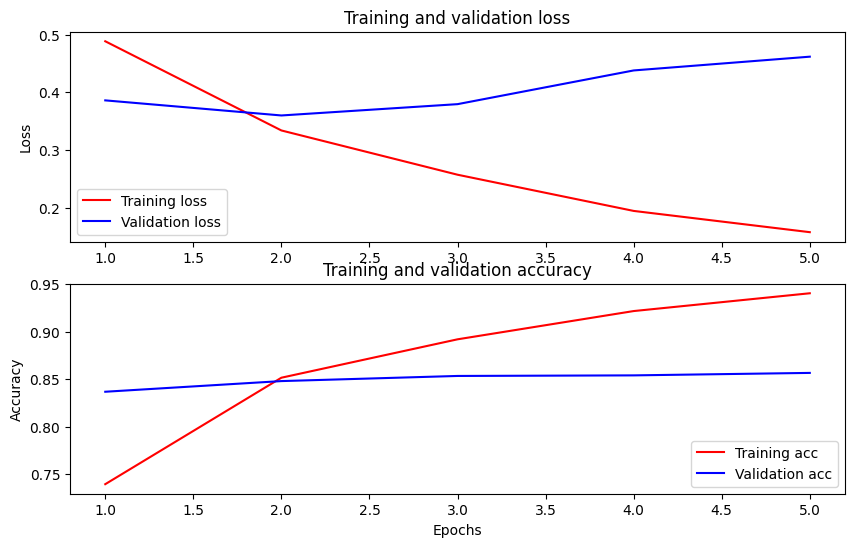

In [21]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In this plot, the red lines represent the training loss and accuracy, and the blue lines are the validation loss and accuracy.

## Export for inference

Now you just save your fine-tuned model for later use.

In [22]:
dataset_name = 'imdb'
saved_model_path = './{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

2022-12-14 13:30:05.768447: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Let's reload the model, so you can try it side by side with the model that is still in memory.

In [23]:
reloaded_model = tf.saved_model.load(saved_model_path)

Here you can test your model on any sentence you want, just add to the examples variable below.

In [24]:
def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'this is such an amazing movie!',  # this is the same sentence tried earlier
    'The movie was great!',
    'The movie was meh.',
    'The movie was okish.',
    'The movie was terrible...'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)
print('Results from the model in memory:')
print_my_examples(examples, original_results)

Results from the saved model:
input: this is such an amazing movie! : score: 0.999687
input: The movie was great!           : score: 0.994479
input: The movie was meh.             : score: 0.631272
input: The movie was okish.           : score: 0.019982
input: The movie was terrible...      : score: 0.001881

Results from the model in memory:
input: this is such an amazing movie! : score: 0.999687
input: The movie was great!           : score: 0.994479
input: The movie was meh.             : score: 0.631272
input: The movie was okish.           : score: 0.019982
input: The movie was terrible...      : score: 0.001881



If you want to use your model on [TF Serving](https://www.tensorflow.org/tfx/guide/serving), remember that it will call your SavedModel through one of its named signatures. In Python, you can test them as follows:

In [25]:
serving_results = reloaded_model \
            .signatures['serving_default'](tf.constant(examples))

serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)

input: this is such an amazing movie! : score: 0.999687
input: The movie was great!           : score: 0.994479
input: The movie was meh.             : score: 0.631272
input: The movie was okish.           : score: 0.019982
input: The movie was terrible...      : score: 0.001881



## Next steps

As a next step, you can try [Solve GLUE tasks using BERT on a TPU tutorial](https://www.tensorflow.org/text/tutorials/bert_glue), which runs on a TPU and shows you how to work with multiple inputs.